# 팀명 : Old Pine

---

## 1. EDA & Feature engineering
- 사칙연산과 도메인 지식을 통한 다양한 변수 생성으로 초기 Feature_ver.1 생성
- 생성한 모든 변수를 사용하여 lightgbm 기반 Permutation Importance 진행
- Permutation Importance를 기준으로 365개 변수에서 125개 변수로 축소
- 아래와 같은 다양한 모델을 사용하여 스태킹을 했으나 성능의 한계를 느낌
- 성능 향상을 위해 더 넓은 도메인 지식을 사용하여 Feature_ver.2 생성

## 2. Modeling
- 모든 모델은 StratifiedKfold를 사용하여 정확도 검증
- 처음에는 LightGBM 단일 모델만을 사용하였으나 test accuracy가 0.9366에서 멈춤
- 이후 스태킹을 위해 XGBoost, RandomForest, HistGradientBoost, MLPClassifier, GradientBoost, CatBoost, ExtraTree, SVM, LogisticRegression, AdaBoost의 모델들을 시도
- GridSearchCV와 RandomizedSearch, HyperOpt 등의 Parameter 튜닝 모델들을 사용하여 개별 모델들의 성능을 올리고 스태킹을 시도하였으나 train 데이터에 대해 과적합이 확인되며 오히려 성능이 떨어짐
- Feature_ver.1과 Feature_ver.2 이외에도 ver.3, ver.4를 만들어 Feature별 스태킹 및 Model별 스태킹 또한 진행하였으나 심한 과적합을 보임
- 이후 Feature_ver.1과 Feature_ver.2에만 모델을 사용하여 여러 조합을 통해 가장 높은 CV값을 보이는 모델 제출

## 3. 한계점
- EDA를 사용하여 보다 잘 구분되는 파생변수를 생성하였으나 효과가 없는 변수가 더 많았음
- 전체 데이터(320000)에서 LightGBM과 같은 좋은 모델들이 구분하지 못하는 약 6.1%의 데이터를 LogisticRegression이 약 13.5% 구분한다는 것을 확인하였으나 제대로 접목시키지 못함
- 산점도 내에서 변수간의 관계 파악을 통해 변수 생성을 할 수 있었으나 시간상 초기 생성한 360개 변수에 대해서 모두 산점도를 그려보지 못함
- Feature별 다중 스태킹과 Model별 다중 스태킹에서 과적합된 결과가 나온 이유를 파악하지 못함

---

# Import

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import math
import warnings
import sys
import sklearn
from tqdm import tqdm
import itertools
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import skew, kurtosis
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from pathlib import Path
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
import catboost
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import ExtraTreesClassifier

warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option("display.precision", 4)

# Library version

In [2]:
print('python',sys.version)

print("lightgbm",lgb.__version__)
print('sklearn',sklearn.__version__)
print('numpy',np.__version__)
print('pandas',pd.__version__)
print('xgboost',xgb.__version__)
print('catboost',catboost.__version__)

python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
lightgbm 3.0.0
sklearn 0.23.2
numpy 1.18.1
pandas 1.0.1
xgboost 1.2.0
catboost 0.24.2


# feature ver.1 
- raw data의 변수들의 조합을 이용하여 사칙연산 피쳐 생성
- www.sdss.org 에서 domain 관련 변수 추가 
- LightGBM 기반 Permutation Importance를 적용하여 365개 변수에서 240개 제거

In [3]:
trn = pd.read_csv('data/train.csv', index_col=0)
tst = pd.read_csv('data/test.csv', index_col=0)

In [4]:
all_fea=['u','g','r','i','z','redshift','dered_u','dered_g','dered_r','dered_i','dered_z','nObserve','nDetect','airmass_u','airmass_g','airmass_r','airmass_i','airmass_z']
fea=['u', 'g', 'r', 'i', 'z', 'redshift', 'dered_u', 'dered_g','dered_r', 'dered_i', 'dered_z']
fea2=['u','g','r','i','z','redshift','dered_u','dered_g','dered_r','dered_i','dered_z','nObserve','nDetect']
ugriz=['u','g','r','i','z']
dered = ['dered_u','dered_g','dered_r','dered_i','dered_z']
airmass=['airmass_u','airmass_g','airmass_r','airmass_i','airmass_z']
asinh=['asinh_mu','asinh_mg','asinh_mr','asinh_mi','asinh_mz']

In [5]:
#이상치 제거
for i in range(len(fea)):
    trn=trn[trn[fea[i]]>np.min(tst[fea[i]], axis=0)]
    trn=trn[trn[fea[i]]<np.max(tst[fea[i]], axis=0)]
    
# 설명변수와 반응변수 분리
trn_target = trn['class']
trn = trn.drop('class', axis=1)

for df in [trn,tst]:
    # 옵저브 디텍트 연속형으로 전환
    df['nObserve']=df['nObserve'].astype('float')
    df['nDetect']=df['nDetect'].astype('float')

    #카테고리별 max, min, max-min, std, sum을 구한다.
    #max-min
    df['max-min'] = df[all_fea].max(axis=1)-df[all_fea].min(axis=1)
    df['max-min_ugriz'] = df[ugriz].max(axis=1)-df[ugriz].min(axis=1)
    df['max-min_dered'] = df[dered].max(axis=1)-df[dered].min(axis=1)
    #std
    df['std'] = df[all_fea].std(axis=1)
    df['std_ugriz'] = df[ugriz].std(axis=1)
    df['std_dered'] = df[dered].std(axis=1)
    #파장별 합
    df['sum'] = df[all_fea].sum(axis=1)
    df['sum_ugriz'] = df[ugriz].sum(axis=1)
    df['sum_dered'] = df[dered].sum(axis=1)
    #파장별 최대값
    df['max'] = df[all_fea].max(axis=1)
    df['max_ugriz'] = df[ugriz].max(axis=1)
    df['max_dered'] = df[dered].max(axis=1)
    #파장별 최소값
    df['min'] = df[all_fea].min(axis=1)
    df['min_ugriz'] = df[ugriz].min(axis=1)
    df['min_dered'] = df[dered].min(axis=1)
    #파장별 max-max,min=min,sum-sum
    df['max-max']=df[ugriz].max(axis=1)-df[dered].max(axis=1)
    df['min-min']=df[ugriz].min(axis=1)-df[dered].min(axis=1)
    df['sum-sum']=df[ugriz].sum(axis=1)-df[dered].sum(axis=1)

    #왜도,첨도 구하기
    df['skew']=skew(df[ugriz],axis=1)
    df['kurtosis']=kurtosis(df[ugriz],axis=1)
    df['dered_skew']=skew(df[dered],axis=1)
    df['dered_kurtosis']=kurtosis(df[dered],axis=1)
    df['airmass_skew']=skew(df[airmass],axis=1)
    df['airmass_kurtosis']=kurtosis(df[airmass],axis=1)

    #조합으로 연산 피쳐 생성
    for c1,c2 in tqdm(itertools.combinations(fea2,2)):
        dif_col=f'diff_{c1}_{c2}'
        div_col=f'div_{c1}_{c2}'
        sum_col=f'sum_{c1}_{c2}'
        mul_col=f'mul_{c1}_{c2}'
        df[dif_col]=df[c1]-df[c2]
        df[div_col]=df[c1]/df[c2]
        df[sum_col]=df[c1]+df[c2]
        df[mul_col]=df[c1]*df[c2]

    #EDA를 통해 생성한 피쳐
    df['redshift%14'] = df['redshift']%14
    df['log_redshift']=np.log1p(df['redshift'])
    df['log_redshift']=df['log_redshift'].fillna(0)

    #도메인에서 얻은 파생변수 생성
    #출처: https://www.sdss.org/dr16/algorithms/segue_target_selection/#Legacy
    df['l-color'] = (-0.436*df['u']) + (1.129*df['g']) - (0.119*df['r']) - (0.574*df['i']) + (0.1984)
    df['s-color'] = (-0.249*df['u']) + (0.794*df['g']) - (0.555*df['r']) + (0.234)
    df['P1'] = (0.91*(df['u']-df['g'])) + (0.415*(df['g']-df['r'])) - (1.280)
     # 소수점 4자리 까지만 나타내는 asinh 변수 생성
    df['asinh_mu'] = -2.5/np.log(10)*(np.arcsinh(df.u/24.63/(2.8e-10))-22.689378693319245)
    df['asinh_mg'] = -2.5/np.log(10)*(np.arcsinh(df.g/25.11/(1.8e-10))-23.131211445598282)
    df['asinh_mr'] = -2.5/np.log(10)*(np.arcsinh(df.r/24.80/(2.4e-10))-22.843529373146502)
    df['asinh_mi'] = -2.5/np.log(10)*(np.arcsinh(df.i/24.36/(3.6e-10))-22.43806426503834)
    df['asinh_mz'] = -2.5/np.log(10)*(np.arcsinh(df.z/22.83/(1.48e-09))-21.024370929730330)

trn['class'] = trn_target

78it [00:02, 34.25it/s]
78it [00:00, 92.66it/s] 


In [6]:
trn.shape

(319954, 365)

In [7]:
tst.shape

(80000, 364)

In [8]:
ftr=trn.drop("class",axis=1)
target=trn['class']

In [8]:
lgbm_wrapper=LGBMClassifier(
        n_estimators = 500,
        boosting_type ='dart',
        learning_rate =0.1,
        num_leaves = 100,
        max_depth = 30,
        objective='multiclass',
        num_class=3,
        )
lgbm_wrapper

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=30,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_class=3, num_leaves=100,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [9]:
model=lgbm_wrapper.fit(ftr,target,eval_metric='multi_error',verbose=True)

In [10]:
perm = PermutationImportance(model, scoring = "accuracy").fit(ftr, target) 
eli5.show_weights(perm, top = ftr.shape[1], feature_names = ftr.columns.tolist())

In [9]:
#permutation importance로 하위 240개 feature 제거(30개씩 제거해본 결과 240개를 제거했을 시 가장 좋았음)
PI30_1=['dered_z','dered_g','div_dered_g_dered_z','sum_dered_i_nDetect','mul_dered_g_dered_z','sum_z_dered_i','diff_r_redshift','sum_u_redshift','sum_dered_r_nDetect','mul_g_dered_z','sum_dered_r_dered_z','div_r_nObserve','sum_i_redshift','diff_dered_g_dered_z','sum_dered_g_dered_r','sum_r_dered_z','diff_u_redshift','mul_u_dered_z','mul_dered_g_dered_r','mul_i_dered_r','div_i_dered_g','sum_r_redshift','div_u_dered_z','mul_r_z','div_g_z','diff_u_dered_z','mul_r_dered_g','sum_redshift_dered_z','u','div_redshift_dered_u']
PI30_2=['mul_dered_g_nDetect','sum_r_nObserve','sum_i_dered_r','diff_z_nObserve','mul_nObserve_nDetect','asinh_mz','nObserve','asinh_mg','diff_g_dered_z','mul_g_dered_u','log_redshift','nDetect','mul_u_z','sum_r_nDetect','div_dered_i_nObserve','sum_i_z','sum_u_dered_r','dered_i','mul_g_dered_r','mul_z_dered_i','div_g_nDetect','diff_dered_g_nObserve','mul_r_dered_z','sum_i_nDetect','diff_z_dered_g','mul_g_z','sum_z_dered_z','mul_dered_u_nObserve','div_redshift_nObserve','dered_r']
PI30_3=["mul_g_i","sum_redshift_dered_u","sum_g_i","sum_z_dered_g","sum_i_dered_z","mul_r_dered_r","div_g_i","mul_dered_r_dered_i","g","div_dered_i_nDetect","mul_dered_r_nObserve","sum_r_i","min_dered","mul_i_dered_z","div_dered_r_nObserve","diff_dered_z_nDetect","div_i_nDetect","sum_nObserve_nDetect","max_dered","mul_g_r","div_z_nObserve","sum_i_dered_u","mul_dered_r_nDetect","div_dered_g_nObserve","mul_r_i","diff_i_nDetect","sum_u_r","sum_dered_g_nDetect","div_u_nDetect","sum_u_dered_g"]
PI30_4=["div_r_nDetect","mul_u_g","diff_dered_i_nDetect","mul_u_i","mul_dered_i_nObserve","div_i_dered_i","mul_i_nDetect","mul_g_dered_g","sum_u_dered_z","mul_r_dered_i","sum_g_dered_g","sum_u_g","mul_dered_u_dered_i","sum_g_nDetect","mul_z_nObserve","mul_g_nDetect","mul_dered_i_nDetect","sum_dered_g_dered_i","mul_u_dered_i","div_dered_z_nDetect","i","sum_g_z","sum_u_dered_u","sum_g_r","sum_dered","mul_u_nDetect","mul_i_dered_i","mul_dered_g_nObserve","div_dered_g_nDetect","div_u_i"]
PI30_5=["asinh_mr","div_dered_r_nDetect","mul_z_dered_r","mul_g_nObserve","diff_u_nDetect","sum_g_dered_u","sum_redshift_dered_i","div_i_nObserve","div_g_nObserve","z","mul_dered_z_nObserve","sum_dered_r_nObserve","sum_z_dered_r","sum_u_dered_i","mul_u_dered_g","mul_dered_u_dered_r","diff_z_nDetect","sum_r_dered_r","sum_dered_u_dered_g","asinh_mi","diff_i_redshift","diff_r_nObserve","mul_i_nObserve","diff_dered_r_nObserve","sum_i_dered_i","sum_r_dered_i","diff_dered_r_nDetect","sum_u_nObserve","div_dered_u_nDetect","sum_z_dered_u"]
PI30_6=["sum_dered_i_nObserve","diff_nObserve_nDetect","mul_dered_u_dered_z","div_u_nObserve","diff_u_nObserve","diff_redshift_nDetect","mul_u_nObserve","diff_dered_g_nDetect","sum_u_z","max_ugriz","sum_g_dered_r","mul_r_nObserve","div_z_nDetect","max","mul_dered_u_nDetect","sum_i_nObserve","diff_g_nDetect","sum_dered_z_nDetect","mul_z_nDetect","mul_i_z","diff_r_nDetect","diff_g_nObserve","div_g_dered_i","mul_dered_z_nDetect","mul_i_dered_u","diff_dered_u_nObserve","div_dered_z_nObserve","mul_u_r","diff_i_nObserve","sum_ugriz"]
PI30_7=["dered_u","mul_i_dered_g","mul_r_dered_u","mul_r_nDetect","sum_dered_g_nObserve","sum-sum","diff_dered_u_dered_z","diff_dered_u_nDetect","mul_dered_r_dered_z","sum_dered_u_nObserve","diff_dered_i_nObserve","diff_g_z","diff_z_redshift","diff_i_dered_g","mul_z_dered_z","min_ugriz","diff_dered_z_nObserve","mul_g_dered_i","asinh_mu","sum_dered_u_dered_r","diff_u_z","sum_u_nDetect","std_ugriz","sum_dered_r_dered_i","sum_dered_z_nObserve","mul_dered_u_dered_g","sum_r_dered_g","mul_u_dered_r","max-min_ugriz","diff_redshift_dered_r"]
PI30_8=["div_i_redshift","sum_g_redshift","div_r_dered_r","mul_z_dered_g","sum_redshift_nDetect","diff_u_dered_u","diff_i_dered_i","diff_i_dered_u","sum_g_dered_i","diff_u_dered_i","div_g_redshift","sum_u_i","div_z_dered_r","sum_i_dered_g","sum_redshift_dered_r","sum_z_nObserve","sum_dered_u_nDetect","diff_redshift_nObserve","sum_dered_u_dered_z","div_g_dered_z","sum_z_nDetect","diff_redshift_dered_z","div_dered_g_dered_i","div_dered_u_nObserve","mul_u_dered_u","sum_r_z","r","max-min_dered","mul_dered_g_dered_i","sum_g_nObserve"]
PI240=PI30_1+PI30_2+PI30_3+PI30_4+PI30_5+PI30_6+PI30_7+PI30_8

In [10]:
trn1=trn[trn.columns.difference(PI240)].copy()
tst1=tst[tst.columns.difference(PI240)].copy()

# feature ver.2 : 
- 연산피쳐 줄이고 도메인 관련 변수를 추가적으로 생성
- redshift가 Random Forest Feature Importance에서 중요하다고 나와 redshift 관련 연산변수 추가

In [11]:
trn = pd.read_csv('data/train.csv', index_col=0)
tst = pd.read_csv('data/test.csv', index_col=0)

In [23]:
ftr=trn.drop("class",axis=1)
target=trn['class']

rf_clf = RandomForestClassifier(n_estimators = 500, 
                                random_state=9697,
                                verbose=True,
                                oob_score=True,
                                n_jobs=-1)
rf_clf.fit(ftr, target)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.2min finished


RandomForestClassifier(n_estimators=500, n_jobs=-1, oob_score=True,
                       random_state=9697, verbose=True)

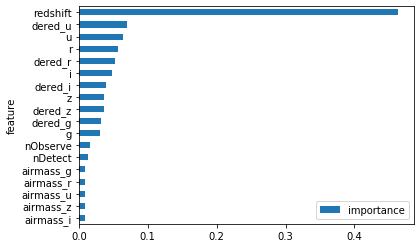

In [24]:
imp = pd.DataFrame({'feature': ftr.columns, 'importance': rf_clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [13]:
#이상치 제거
for i in range(len(fea)):
    trn=trn[trn[fea[i]]>np.min(tst[fea[i]], axis=0)]
    trn=trn[trn[fea[i]]<np.max(tst[fea[i]], axis=0)]

for df in [trn,tst]:    

    for c in ugriz[1:]:
        div_col=f'div_u_{c}'
        df[div_col]=df.u/df[c]

    for c in ugriz:
        div_col=f'div_redshift_{c}'
        mul_col=f'mul_redshift_{c}'
        df[div_col]=df.redshift/df[c]
        df[mul_col]=df.redshift*df[c]
        
    df['div_abs_redshift_mean_u']=abs(df.redshift-np.mean(df.u))
    df['redshift_2']=df.redshift**2
    df['redshift_4']=df.redshift**4

    df['log_redshift_2']=np.log(df.redshift**2)
    df['log_redshift_4']=np.log(df.redshift**4)
    df['redshift_med_2']=(df.redshift-np.median(df.redshift))**2
    df['redshift_med_3']=(df.redshift-np.median(df.redshift))**3
    df["redshift_mean_2"]=(df.redshift-np.mean(df.redshift))**2

    df['asinh_mu'] = -2.5/np.log(10)*(np.arcsinh(df.u/24.63/(2.8e-10))-22.689378693319245)
    df['asinh_mg'] = -2.5/np.log(10)*(np.arcsinh(df.g/25.11/(1.8e-10))-23.131211445598282)
    df['asinh_mr'] = -2.5/np.log(10)*(np.arcsinh(df.r/24.80/(2.4e-10))-22.843529373146502)
    df['asinh_mi'] = -2.5/np.log(10)*(np.arcsinh(df.i/24.36/(3.6e-10))-22.43806426503834)
    df['asinh_mz'] = -2.5/np.log(10)*(np.arcsinh(df.z/22.83/(1.48e-09))-21.024370929730330)

    df['redshift_u_g'] = df.redshift-df.u-df.g
    df['redshift_u_r'] = df.redshift-df.u-df.r
    df['redshift_g_r'] = df.redshift-df.g-df.r
    df['redshift_4_log_u_2'] = df.redshift**4+np.log(df.u**2)

    for c in ugriz:
        div_col=f'div_redshift_2_{c}'
        df[div_col]=df.redshift**2/df[c]
    
    for c in asinh:
        mul_col=f'mul_{c}_redshift'
        div_col=f'div_{c}_redshift'
        df[mul_col]=df[c]*df.redshift
        df[div_col]=df[c]/df.redshift
        
    for f in [ugriz,dered,airmass]:
        for c1,c2 in itertools.combinations(f,2):
            dif_col=f'diff_{c1}_{c2}'
            df[dif_col]=df[c1]-df[c2]

    # 도메인 정보를 바탕으로 변수 추가
    # 출처 : http://classic.sdss.org/dr6/algorithms/sdssUBVRITransform.html
    df['Q_U_B']=0.75*(df.u-df.g)-0.81
    df['Q_B_V']=0.62*(df.g-df.r)+0.15
    df['Q_V_R']=0.38*(df.r-df.i)-0.2
    df['Q_Rc_IC']=0.72*(df.r-df.i)-0.27
    df['Q_B']=df.g+0.17*(df.u-df.g)+0.11
    df['Q_V']=df.g-0.52*(df.g-df.r)-0.03
    df['S_U_B']=0.77*(df.u-df.g)-0.88
    df['S_B_V']=0.90*(df.g-df.r)+0.21
    df['S_V_R']=0.96*(df.r-df.i)+ 0.21
    df['S_Rc_IC']=1.02*(df.r-df.i)+0.21
    df['S_B']=df.g+0.33*(df.g-df.r)+0.20
    df['S_V']=df.g -0.58*(df.g-df.r)- 0.01
    df['l-color'] = (-0.436*df['u']) + (1.129*df['g']) - (0.119*df['r']) - (0.574*df['i']) + (0.1984)
    df['s-color'] = (-0.249*df['u']) + (0.794*df['g']) - (0.555*df['r']) + (0.234)
    
    df['domain1'] = 0.7*(df.g-df.r) + 1.2*((df.r-df.i) - 0.177) 
    df['domain2'] = (df.r-df.i) - (df.g-df.r)/4 - 0.177 
    df['domain3'] = 0.449 - (df.g-df.r)/6  
    df['domain4'] = 1.296 + 0.25*(df.r-df.i)  
    df['domain5'] =  (df.r-df.i) - (df.g-df.r)/4 - 0.18  

    del df['u']

In [14]:
trn.shape
trn2 = trn.copy()

In [15]:
tst.shape
tst2 = tst.copy()

In [16]:
print('Dataset version.1 shape : ',trn1.shape)
print('Dataset version.2 shape : ',trn2.shape)

Dataset version.1 shape :  (319954, 125)
Dataset version.2 shape :  (319954, 113)


In [17]:
n_class = 3
n_fold = 5

ftr1=trn1.drop("class",axis=1).values
target1=trn1['class'].values
tst_ar1=tst1.values

ftr2=trn2.drop("class",axis=1).values
target2=trn2['class'].values
tst2_ar=tst2.values

---

# EDA
1. 수직으로 구분하는 트리 계열 모델을 위해 커널 그래프에서 다른 변수들 보다 클래스를 구분하는 파생변수 생성하였으나 성능이 더 떨어졌음
2. 변수의 개수에 영향을 받는 모델(SVM, MLP)는 상관계수를 바탕으로 축소

div_redshift_nDetect
0    70844
2        6
1        5
Name: class, dtype: int64

diff_g_dered_u
2    125006
0     69754
1      8762
Name: class, dtype: int64

diff_dered_u_dered_r
2    125935
0     68140
1      9452
Name: class, dtype: int64

div_r_dered_u
2    70371
0    55036
1     2002
Name: class, dtype: int64

div_u_r
0    51011
2    40279
1    35486
Name: class, dtype: int64

diff_r_dered_u%2
2    71954
0    31730
1     8836
Name: class, dtype: int64

diff_g_dered_u%2
2    140290
0     59899
1     16252
Name: class, dtype: int64

diff_u_dered_r%2
2    74821
0    35084
1     5166
Name: class, dtype: int64

diff_u_g%3
0    52417
2    46381
1    36422
Name: class, dtype: int64

diff_dered_u_dered_r%3
0    89069
2    47753
1    36349
Name: class, dtype: int64

diff_u_dered_g%6
2    156425
0    110685
1     40017
Name: class, dtype: int64

s-color%10
2    137709
0     62758
1     31538
Name: class, dtype: int64

diff_u_r%11
2    91651
0    69408
1     4424
Name: class, dtype: int64

d

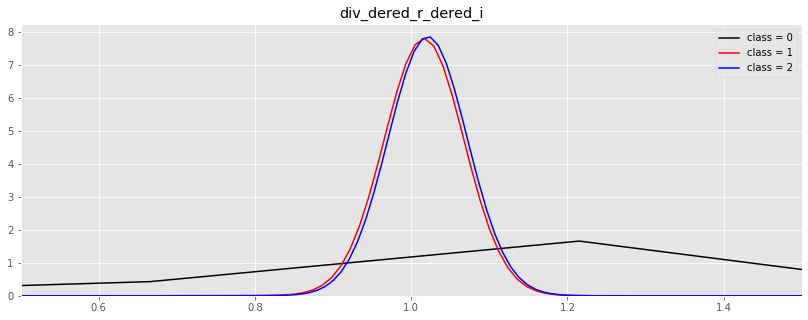

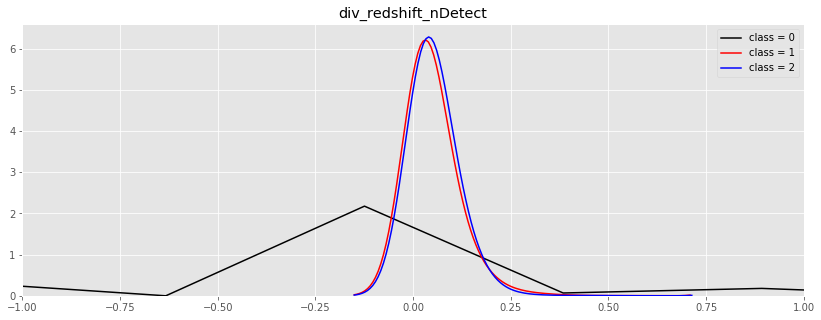

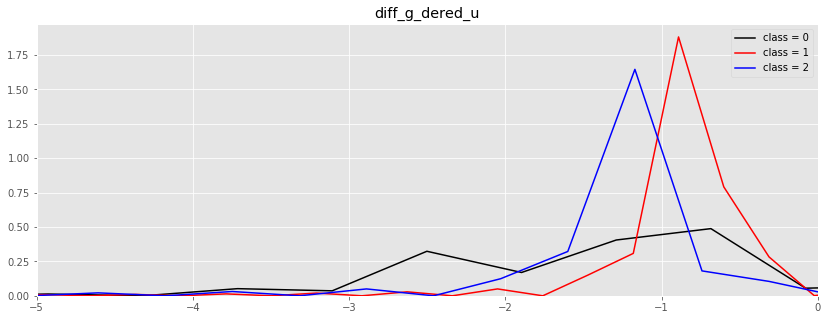

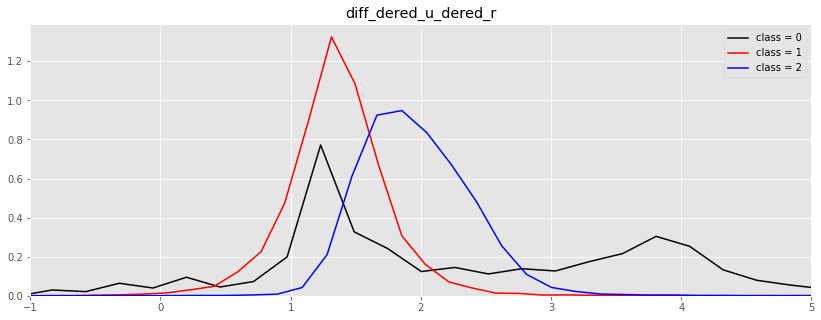

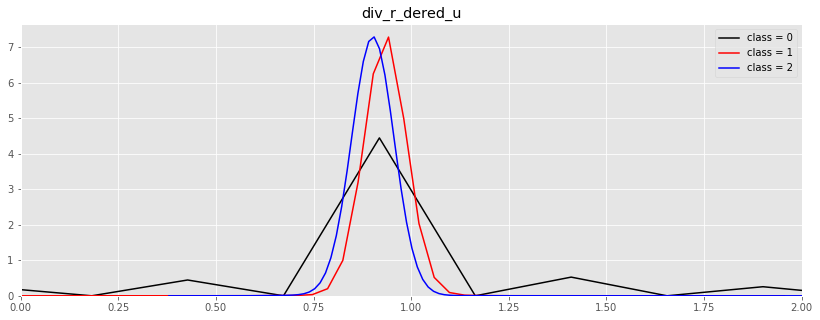

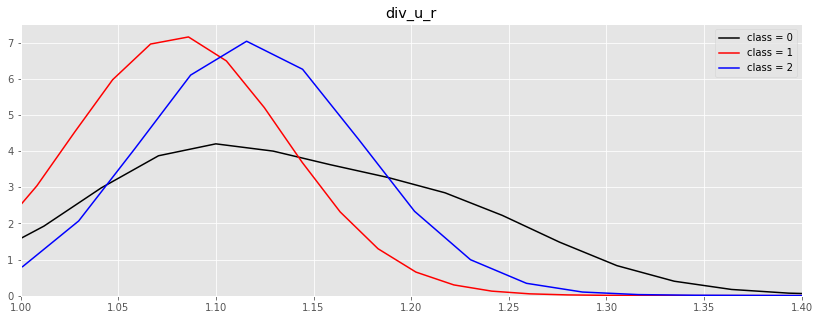

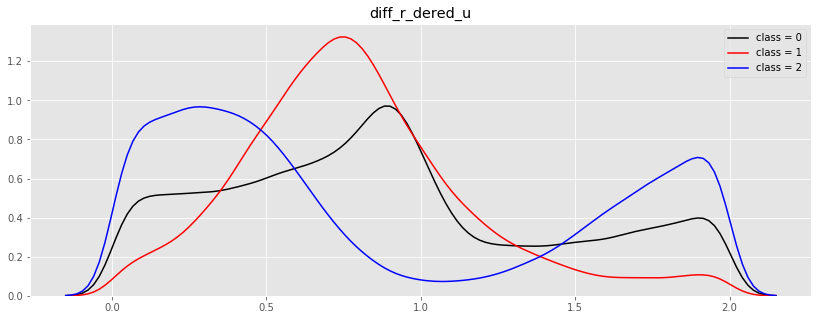

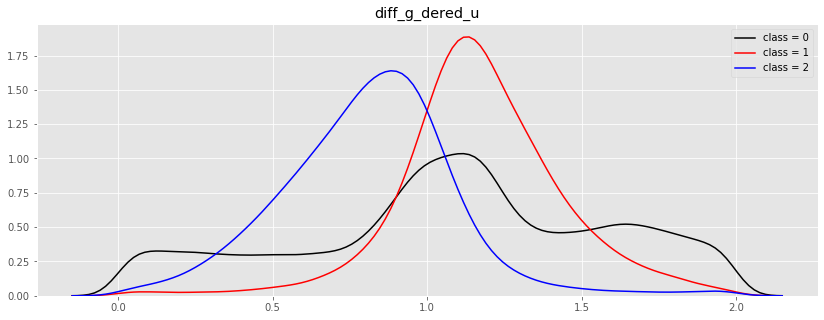

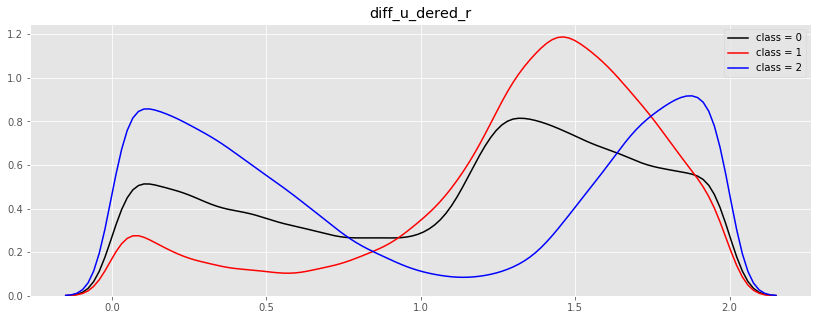

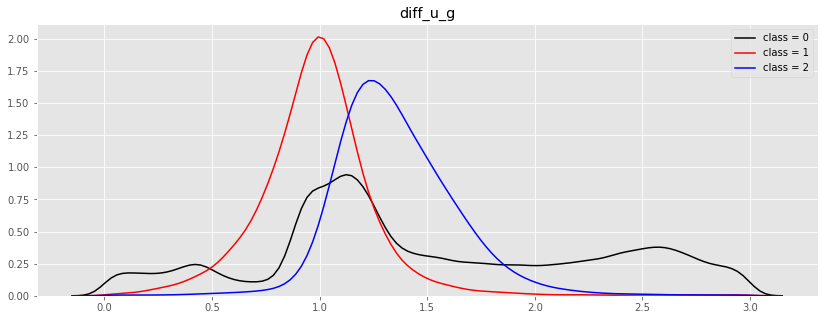

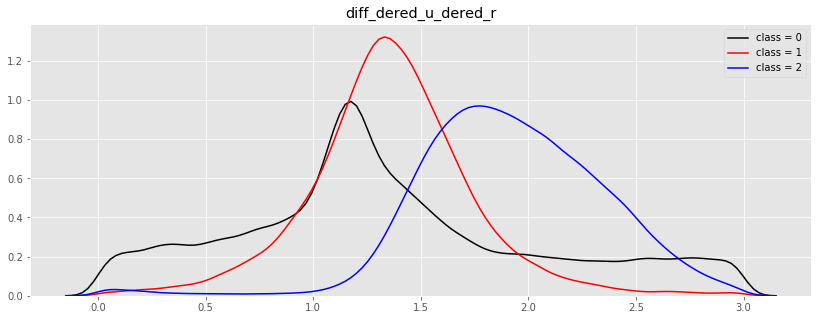

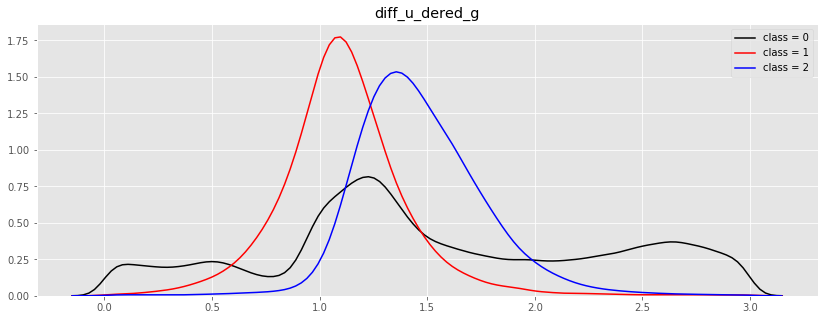

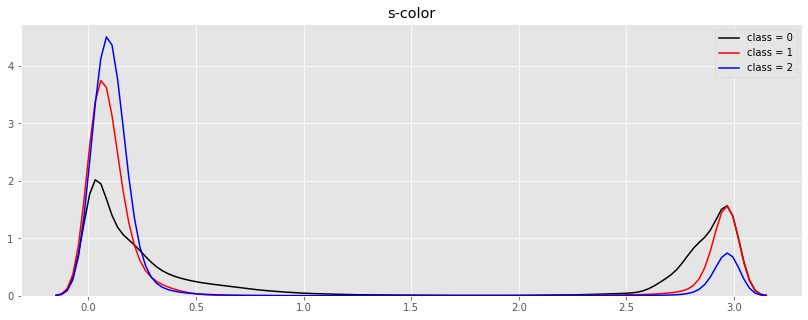

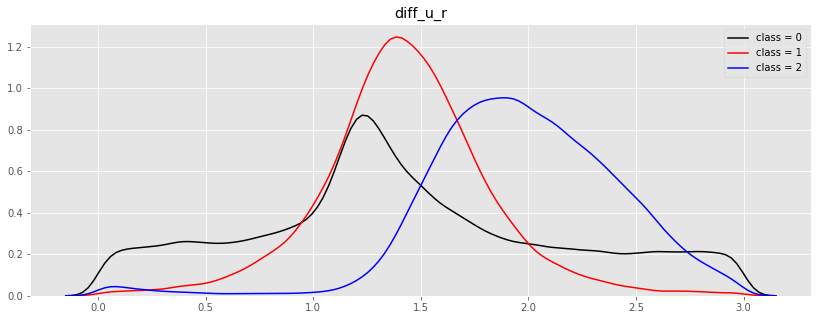

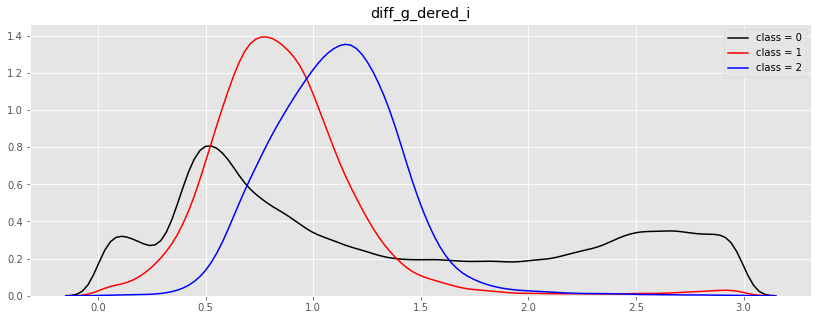

In [10]:
def kdeplot1(feature):
    plt.figure(figsize=(14, 5))
    sns.kdeplot(trn1[trn1['class'] == 0][feature].dropna(), color= 'black', label= 'class = 0', bw=0.05)
    sns.kdeplot(trn1[trn1['class'] == 1][feature].dropna(), color= 'red', label= 'class = 1', bw=0.05)
    sns.kdeplot(trn1[trn1['class'] == 2][feature].dropna(), color= 'blue', label= 'class = 2', bw=0.05)
    plt.title('{}'.format(feature))


# 기본적으로 어느정도 구분을 하는 변수들 
kdeplot1('div_dered_r_dered_i')
plt.xlim(0.5, 1.5)


kdeplot1('div_redshift_nDetect')
plt.xlim(-1, 1)
print('div_redshift_nDetect')
print(trn1[trn1['div_redshift_nDetect']<0]['class'].value_counts())
print()


kdeplot1('diff_g_dered_u')
plt.xlim(-5, 0)
print('diff_g_dered_u')
print(trn1[trn1['diff_g_dered_u']<-1]['class'].value_counts())
print()


kdeplot1('diff_dered_u_dered_r')
plt.xlim(-1, 5)
print('diff_dered_u_dered_r')
print(trn1[trn1['diff_dered_u_dered_r']>1.6]['class'].value_counts())
print()


kdeplot1('div_r_dered_u')
plt.xlim(0, 2)
print('div_r_dered_u')
print(trn1[trn1['div_r_dered_u']<0.9]['class'].value_counts())
print()


kdeplot1('div_u_r')
plt.xlim(1, 1.4)
print('div_u_r')
print(trn1[trn1['div_u_r']<1.1]['class'].value_counts())
print()


# PI기준 상위 변수들 변형
def kdeplot2(feature):
    plt.figure(figsize=(14, 5))
    sns.kdeplot(trn1[trn1['class'] == 0][feature].dropna()%2, color= 'black', label= 'class = 0', bw=0.05)
    sns.kdeplot(trn1[trn1['class'] == 1][feature].dropna()%2, color= 'red', label= 'class = 1', bw=0.05)
    sns.kdeplot(trn1[trn1['class'] == 2][feature].dropna()%2, color= 'blue', label= 'class = 2', bw=0.05)
    plt.title('{}'.format(feature))

# diff_r_dered_u%2
kdeplot2('diff_r_dered_u')
print('diff_r_dered_u%2')
print(trn1[trn1['diff_r_dered_u']%2<0.5]['class'].value_counts())
print()


# diff_g_dered_u%2
kdeplot2('diff_g_dered_u')
print('diff_g_dered_u%2')
print(trn1[trn1['diff_g_dered_u']%2<1.1]['class'].value_counts())
print()


# diff_u_dered_r%2
kdeplot2('diff_u_dered_r')
print('diff_u_dered_r%2')
print(trn1[trn1['diff_u_dered_r']%2<0.7]['class'].value_counts())
print()


def kdeplot3(feature):
    plt.figure(figsize=(14, 5))
    sns.kdeplot(trn1[trn1['class'] == 0][feature].dropna()%3, color= 'black', label= 'class = 0', bw=0.05)
    sns.kdeplot(trn1[trn1['class'] == 1][feature].dropna()%3, color= 'red', label= 'class = 1', bw=0.05)
    sns.kdeplot(trn1[trn1['class'] == 2][feature].dropna()%3, color= 'blue', label= 'class = 2', bw=0.05)
    plt.title('{}'.format(feature))

# diff_u_g%3
kdeplot3('diff_u_g')
print('diff_u_g%3')
print(trn1[trn1['diff_u_g']%3<1.2]['class'].value_counts())
print()


# diff_dered_u_dered_r%3
kdeplot3('diff_dered_u_dered_r')
print('diff_dered_u_dered_r%3')
print(trn1[trn1['diff_dered_u_dered_r']%3<1.7]['class'].value_counts())
print()


def kdeplot6(feature):
    plt.figure(figsize=(14, 5))
    sns.kdeplot(trn1[trn1['class'] == 0][feature].dropna()%6, color= 'black', label= 'class = 0', bw=0.05)
    sns.kdeplot(trn1[trn1['class'] == 1][feature].dropna()%6, color= 'red', label= 'class = 1', bw=0.05)
    sns.kdeplot(trn1[trn1['class'] == 2][feature].dropna()%6, color= 'blue', label= 'class = 2', bw=0.05)
    plt.title('{}'.format(feature))

# diff_u_dered_g%6
kdeplot6('diff_u_dered_g')
print('diff_u_dered_g%6')
print(trn1[trn1['diff_u_dered_g']%6>0.7]['class'].value_counts())
print()


def kdeplot10(feature):
    plt.figure(figsize=(14, 5))
    sns.kdeplot(trn1[trn1['class'] == 0][feature].dropna()%10, color= 'black', label= 'class = 0', bw=0.05)
    sns.kdeplot(trn1[trn1['class'] == 1][feature].dropna()%10, color= 'red', label= 'class = 1', bw=0.05)
    sns.kdeplot(trn1[trn1['class'] == 2][feature].dropna()%10, color= 'blue', label= 'class = 2', bw=0.05)
    plt.title('{}'.format(feature))
    
# s-color%10
kdeplot10('s-color')
print('s-color%10')
print(trn1[(trn1['s-color']%10>0)&(trn1['s-color']%10<0.5)]['class'].value_counts())
print()


def kdeplot11(feature):
    plt.figure(figsize=(14, 5))
    sns.kdeplot(trn1[trn1['class'] == 0][feature].dropna()%11, color= 'black', label= 'class = 0', bw=0.05)
    sns.kdeplot(trn1[trn1['class'] == 1][feature].dropna()%11, color= 'red', label= 'class = 1', bw=0.05)
    sns.kdeplot(trn1[trn1['class'] == 2][feature].dropna()%11, color= 'blue', label= 'class = 2', bw=0.05)
    plt.title('{}'.format(feature))
    
# diff_u_r%11
kdeplot11('diff_u_r')
print('diff_u_r%11')
print(trn1[trn1['diff_u_r']%11>1.9]['class'].value_counts())
print()    


def kdeplot90(feature):
    plt.figure(figsize=(14, 5))
    sns.kdeplot(trn1[trn1['class'] == 0][feature].dropna()%90, color= 'black', label= 'class = 0', bw=0.05)
    sns.kdeplot(trn1[trn1['class'] == 1][feature].dropna()%90, color= 'red', label= 'class = 1', bw=0.05)
    sns.kdeplot(trn1[trn1['class'] == 2][feature].dropna()%90, color= 'blue', label= 'class = 2', bw=0.05)
    plt.title('{}'.format(feature))
    
# diff_g_dered_i%90
kdeplot90('diff_g_dered_i')
print('diff_g_dered_i%90')
print(trn1[trn1['diff_g_dered_i']%90<2]['class'].value_counts())
print()    


In [11]:
# svm에 사용하는 상관계수 높은 변수 제거
# class가 1일 때랑 2일 때 상관계수가 높은 관측치를 제거하였을 때가 성능이 보다 좋았음.
clist = ['diff_u_i','mul_dered_i_dered_z','div_redshift_dered_r','mul_u_redshift']
corr1 = trn1.loc[trn1['class']!=0,:].corr()

cor_list=[]

for i in range(0,trn1.shape[1]):
    for j in range(0,trn1.shape[1]):
        if abs(corr1.iloc[i,j])>=0.9 and corr1.index[i]!=corr1.columns[j]:
            cor_list += [corr1.columns[j]]
            cor_list += [corr1.index[i]]

groupby=cor_list
cor_result=dict()
for ip in tqdm(cor_list):
    cor_result[ip]=cor_list.count(ip)
    
# 변수가 반복되는 횟수 출력
print(cor_result)

cols1 = list(trn1.columns[~trn1.columns.isin(list(cor_result.keys()))])

for i in clist:
    cols1.append(i)

print(cols1)

100%|██████████| 1060/1060 [00:00<00:00, 55943.05it/s]

{'diff_u_dered_g': 6, 'P1': 14, 'diff_u_dered_r': 12, 'diff_u_g': 6, 'diff_u_i': 14, 'diff_u_r': 14, 'div_u_g': 6, 'div_u_r': 14, 'airmass_i': 8, 'airmass_g': 8, 'airmass_r': 8, 'airmass_u': 8, 'airmass_z': 8, 'airmass_skew': 2, 'airmass_kurtosis': 2, 'kurtosis': 2, 'dered_kurtosis': 2, 'skew': 2, 'dered_skew': 2, 'diff_g_dered_i': 4, 'diff_dered_g_dered_i': 4, 'diff_g_i': 4, 'diff_g_r': 6, 'diff_dered_g_dered_r': 6, 'diff_r_dered_g': 2, 'div_dered_g_dered_r': 2, 'diff_i_dered_z': 4, 'diff_dered_i_dered_z': 4, 'div_dered_i_dered_z': 2, 'diff_r_i': 6, 'diff_dered_r_dered_i': 6, 'div_dered_r_dered_i': 6, 'div_r_i': 6, 'diff_r_dered_z': 4, 'diff_dered_r_dered_z': 4, 'div_dered_r_dered_z': 2, 'diff_g_dered_u': 2, 'diff_dered_u_dered_g': 4, 'div_dered_u_dered_g': 2, 'diff_dered_u_dered_r': 16, 'diff_dered_u_dered_i': 12, 'diff_r_dered_u': 14, 'div_dered_u_dered_i': 14, 'div_dered_u_dered_z': 8, 'div_i_dered_u': 8, 'div_dered_u_dered_r': 8, 'div_r_dered_u': 6, 'diff_g_dered_r': 4, 'div_g_r':

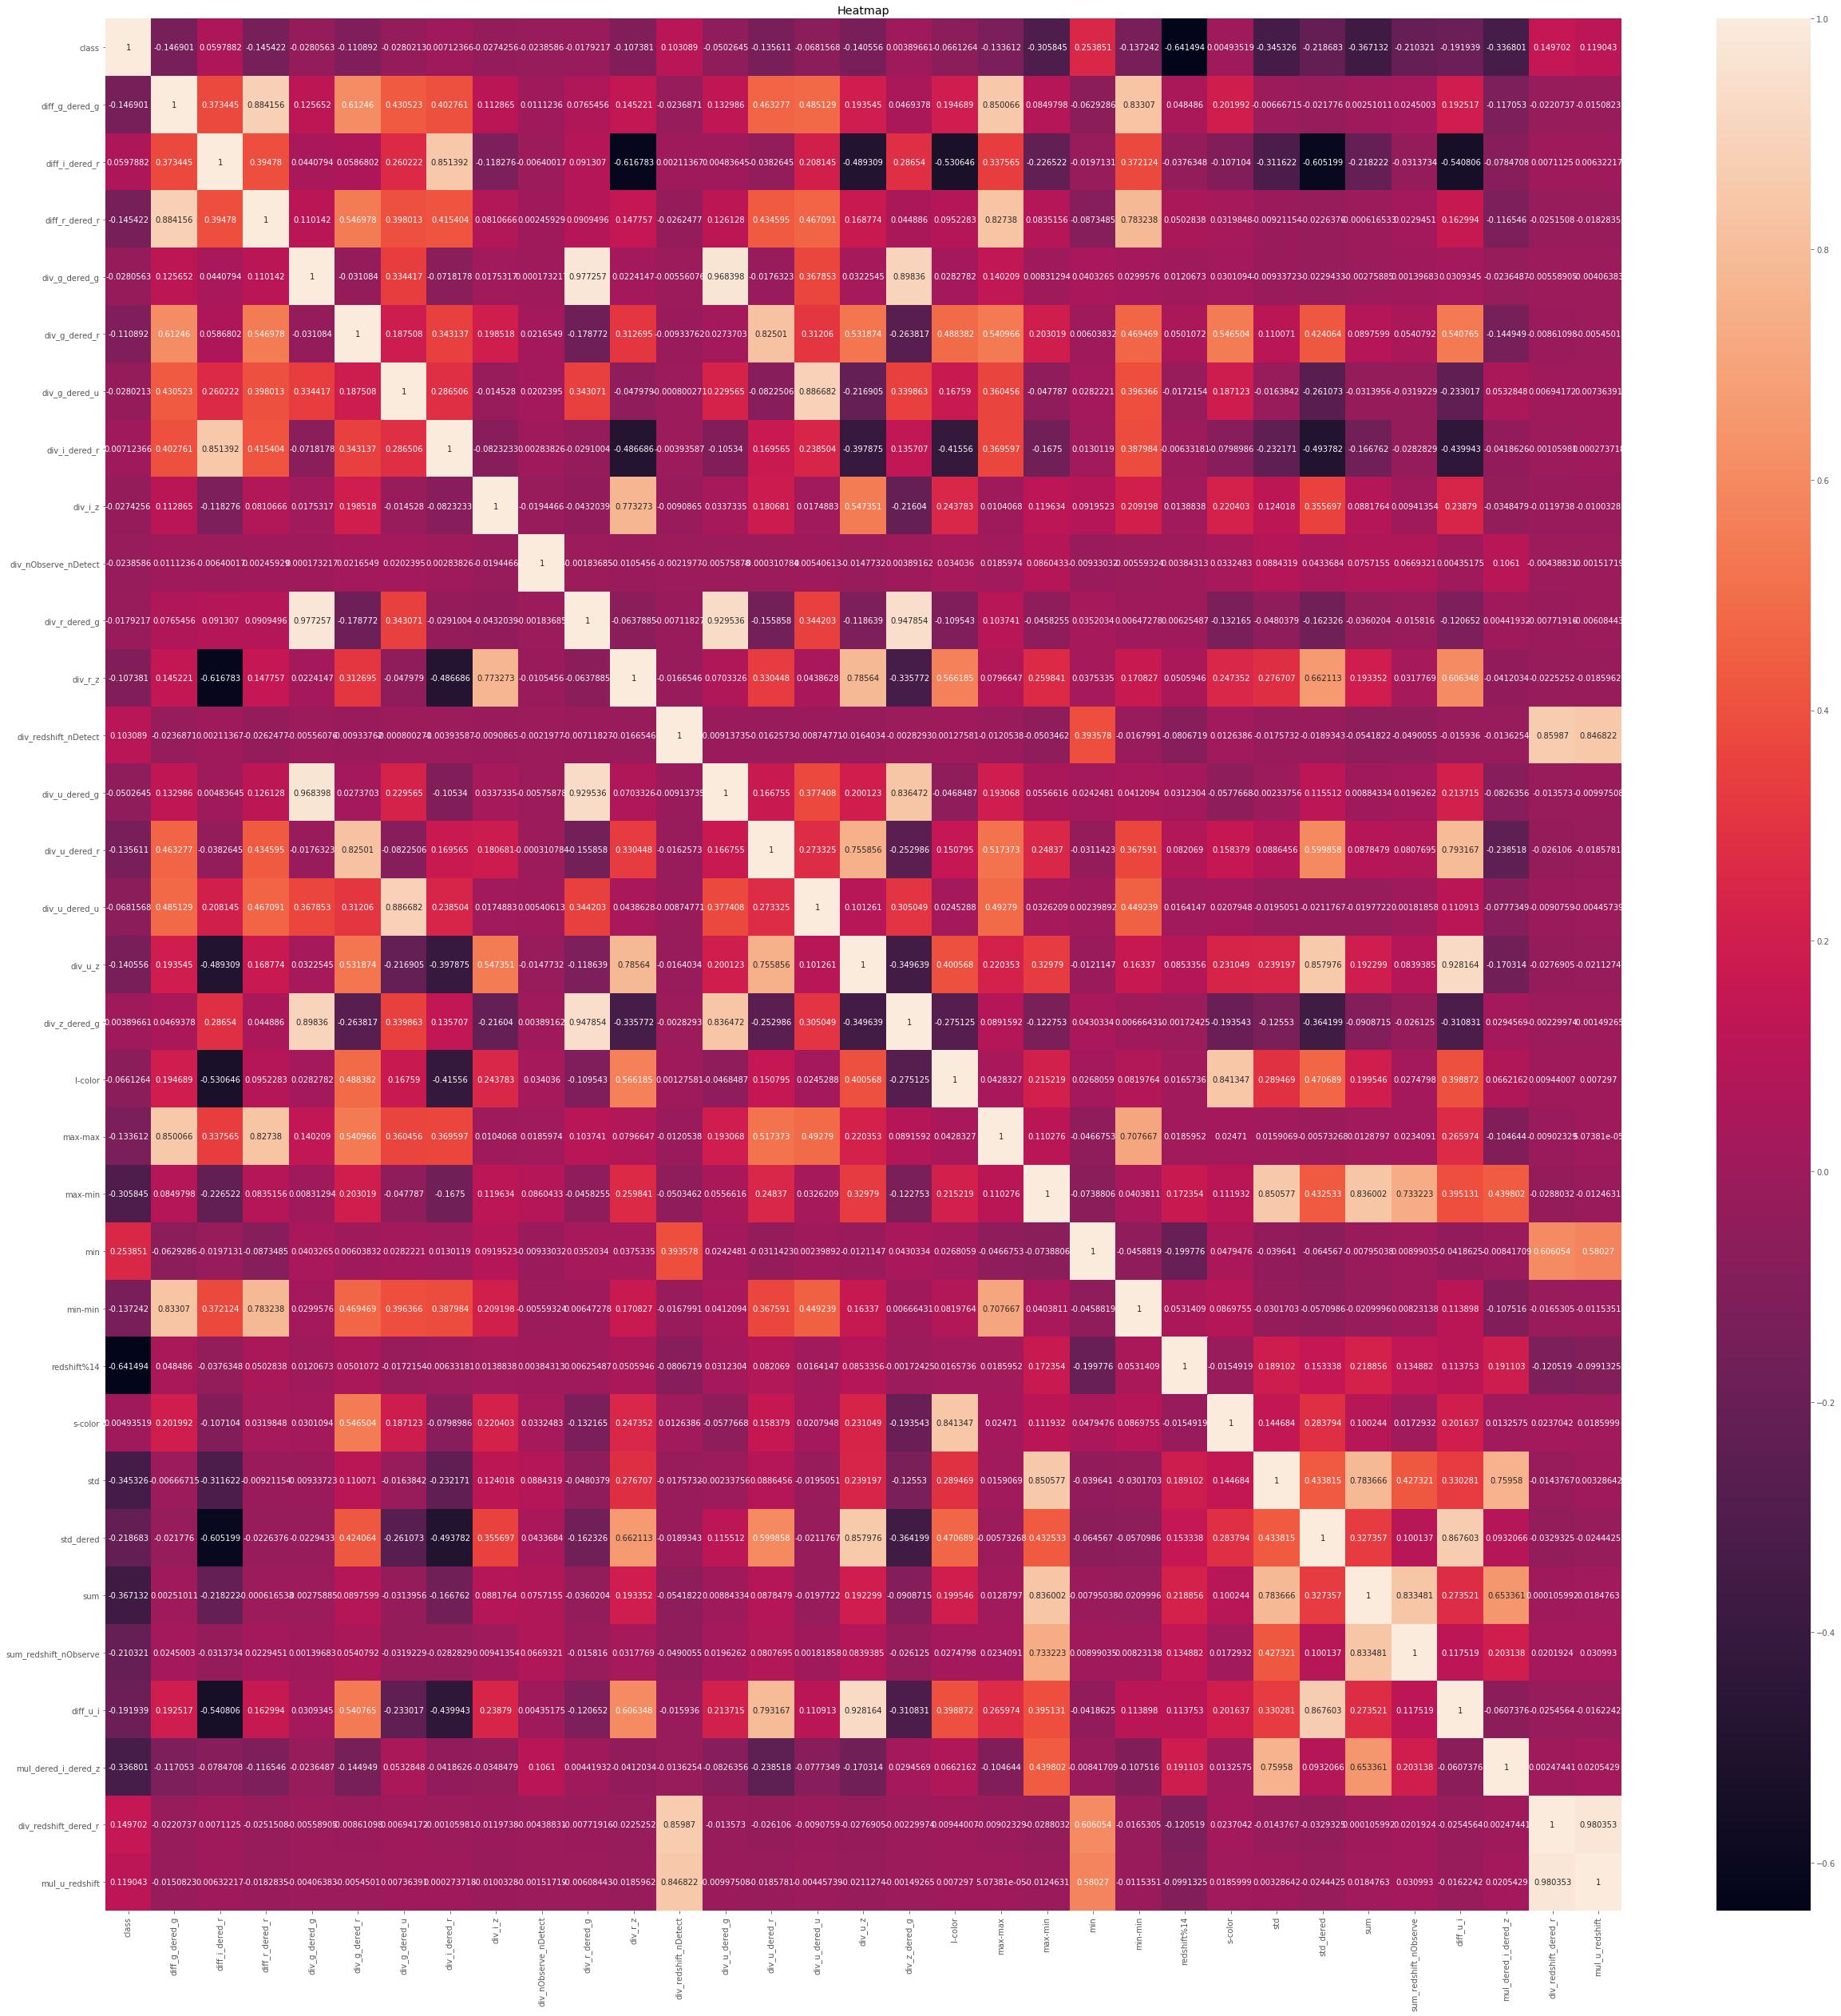

In [12]:
# SVM 히트맵
plt.figure(figsize=(35, 35))
sns.heatmap(trn1[cols1].corr(), annot=True, fmt='g')
plt.tight_layout()
plt.title("Heatmap")
plt.show()

In [13]:
# 클래스가 1과 2일때 상관계수 높은 변수 제거
corr2 = trn1.loc[trn1['class']!=0,:].corr()
cor_list2=[]
for i in range(0,trn1.loc[trn1['class']!=0,:].shape[1]):
    for j in range(0,trn1.loc[trn1['class']!=0,:].shape[1]):
        if abs(corr2.iloc[i,j])>=0.9 and corr2.index[i]!=corr2.columns[j]:
            cor_list2 += [corr2.columns[j]]
            cor_list2 += [corr2.index[i]]
groupby=cor_list2
cor_result2=dict()
for ip in tqdm(cor_list2):
    cor_result2[ip]=cor_list2.count(ip)
    
print(cor_result2)

cols2 = list(trn1.columns[~trn1.columns.isin(list(cor_result2.keys()))])
for i in ['diff_u_dered_g','P1','diff_u_dered_r','airmass_i','skew','kurtosis','diff_g_i','sum_dered_u_dered_i',
          'sum_r_dered_u','diff_redshift_dered_u','sum_z_redshift', 'mul_redshift_dered_i','mul_redshift_nObserve']:
    cols2.append(i)
print(cols2)

100%|██████████| 1060/1060 [00:00<00:00, 37955.56it/s]

{'diff_u_dered_g': 6, 'P1': 14, 'diff_u_dered_r': 12, 'diff_u_g': 6, 'diff_u_i': 14, 'diff_u_r': 14, 'div_u_g': 6, 'div_u_r': 14, 'airmass_i': 8, 'airmass_g': 8, 'airmass_r': 8, 'airmass_u': 8, 'airmass_z': 8, 'airmass_skew': 2, 'airmass_kurtosis': 2, 'kurtosis': 2, 'dered_kurtosis': 2, 'skew': 2, 'dered_skew': 2, 'diff_g_dered_i': 4, 'diff_dered_g_dered_i': 4, 'diff_g_i': 4, 'diff_g_r': 6, 'diff_dered_g_dered_r': 6, 'diff_r_dered_g': 2, 'div_dered_g_dered_r': 2, 'diff_i_dered_z': 4, 'diff_dered_i_dered_z': 4, 'div_dered_i_dered_z': 2, 'diff_r_i': 6, 'diff_dered_r_dered_i': 6, 'div_dered_r_dered_i': 6, 'div_r_i': 6, 'diff_r_dered_z': 4, 'diff_dered_r_dered_z': 4, 'div_dered_r_dered_z': 2, 'diff_g_dered_u': 2, 'diff_dered_u_dered_g': 4, 'div_dered_u_dered_g': 2, 'diff_dered_u_dered_r': 16, 'diff_dered_u_dered_i': 12, 'diff_r_dered_u': 14, 'div_dered_u_dered_i': 14, 'div_dered_u_dered_z': 8, 'div_i_dered_u': 8, 'div_dered_u_dered_r': 8, 'div_r_dered_u': 6, 'diff_g_dered_r': 4, 'div_g_r':

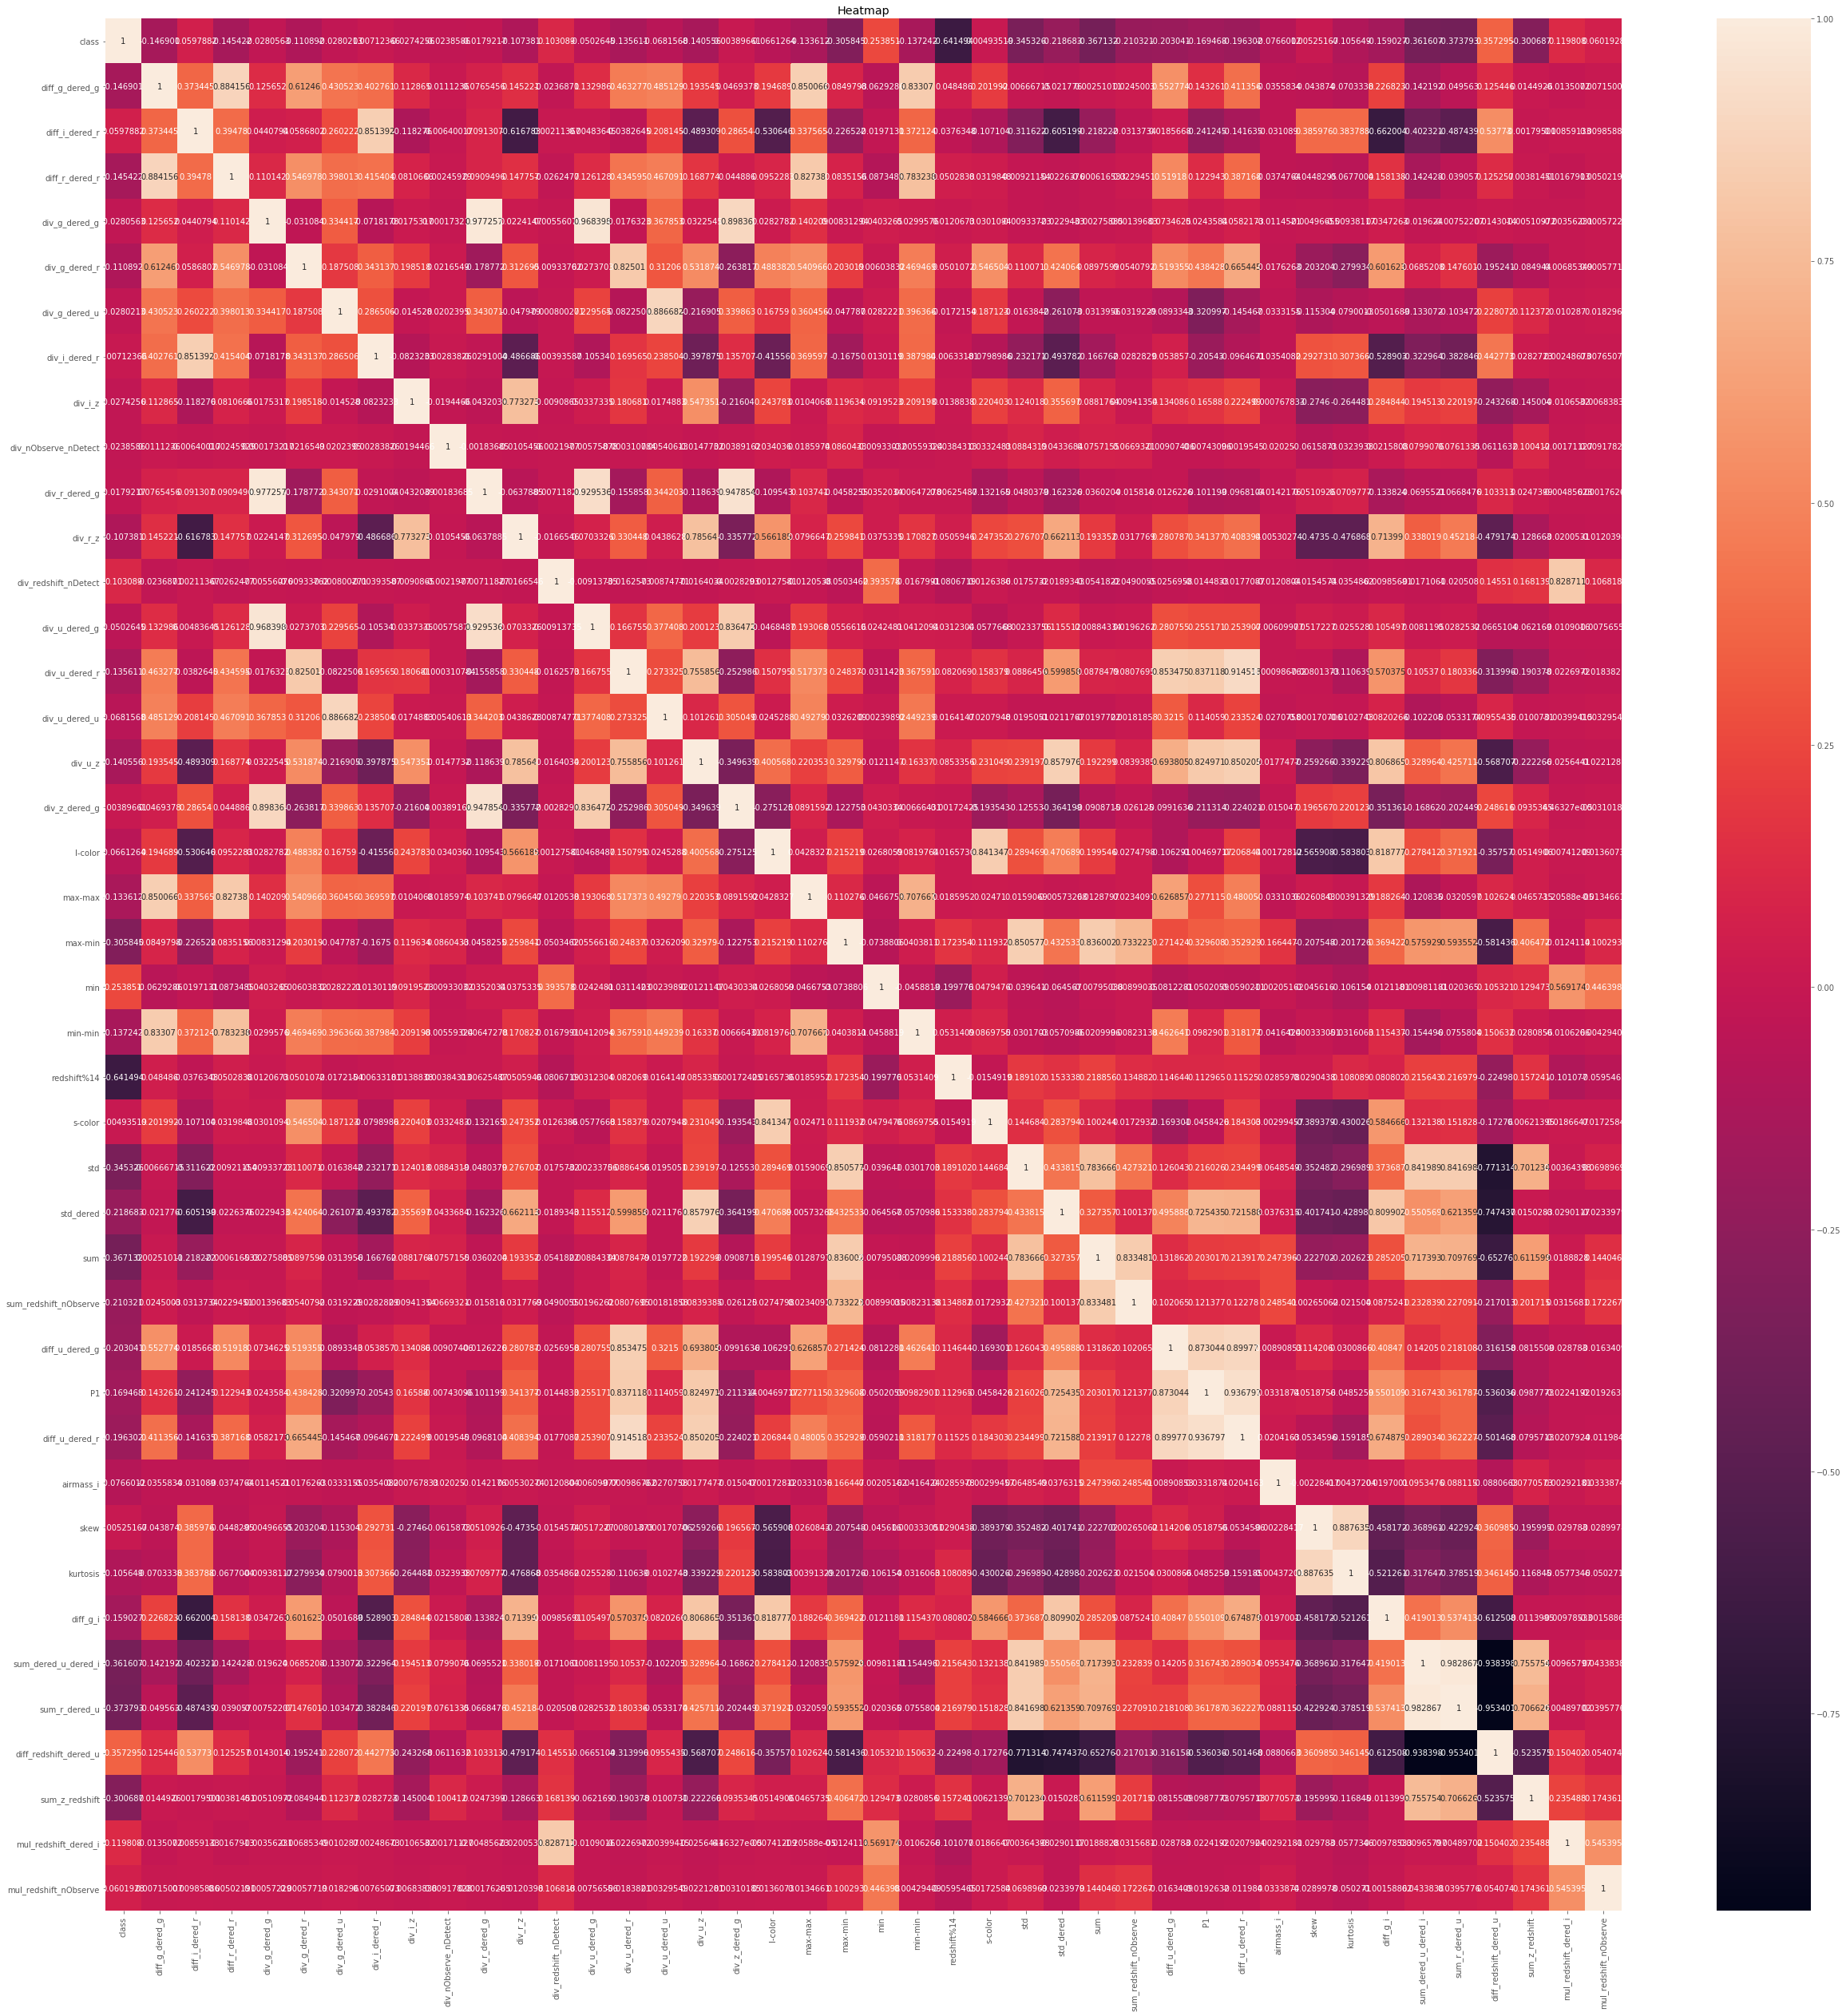

In [14]:
# MLP 히트맵
plt.figure(figsize=(35, 35))
sns.heatmap(trn1[cols2].corr(), annot=True, fmt='g')
plt.tight_layout()
plt.title("Heatmap")
plt.show()

---

## 1. XGBOOST
- Feature 1


In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(ftr1.shape)

xgb_p_val = np.zeros((ftr1.shape[0], n_class))
xgb_p_tst = np.zeros((tst_ar1.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(ftr1, target1), 1):
    print(f'training model for CV #{i}')
    xgb_clf = xgb.XGBClassifier(learning_rate=0.1,
                          n_estimators=220,
                          max_depth=10,
                          booster='dart',
                            random_state=42,
                          tree_method='exact',
                            objective='multiclass',
                            num_class=3,
                            n_jobs=-1)
    xgb_clf.fit(ftr1[i_trn], target1[i_trn],
            eval_set=[(ftr1[i_val], target1[i_val])])
    
    xgb_p_val[i_val, :] = xgb_clf.predict_proba(ftr1[i_val])
    xgb_p_tst += xgb_clf.predict_proba(tst_ar1) / n_fold
    
print(f'{accuracy_score(target1, np.argmax(xgb_p_val, axis=1)) * 100:.4f}%')
print(confusion_matrix(target1, np.argmax(xgb_p_val, axis=1)))

(319954, 124)
training model for CV #1
[0]	validation_0-merror:0.07260
[1]	validation_0-merror:0.07120
[2]	validation_0-merror:0.07045
[3]	validation_0-merror:0.07043
[4]	validation_0-merror:0.06954
[5]	validation_0-merror:0.06976
[6]	validation_0-merror:0.06959
[7]	validation_0-merror:0.06926
[8]	validation_0-merror:0.06903
[9]	validation_0-merror:0.06885
[10]	validation_0-merror:0.06868
[11]	validation_0-merror:0.06899
[12]	validation_0-merror:0.06860
[13]	validation_0-merror:0.06840
[14]	validation_0-merror:0.06810
[15]	validation_0-merror:0.06820
[16]	validation_0-merror:0.06837
[17]	validation_0-merror:0.06823
[18]	validation_0-merror:0.06815
[19]	validation_0-merror:0.06807
[20]	validation_0-merror:0.06779
[21]	validation_0-merror:0.06776
[22]	validation_0-merror:0.06764
[23]	validation_0-merror:0.06759
[24]	validation_0-merror:0.06738
[25]	validation_0-merror:0.06718
[26]	validation_0-merror:0.06713
[27]	validation_0-merror:0.06713
[28]	validation_0-merror:0.06688
[29]	validatio

[24]	validation_0-merror:0.06451
[25]	validation_0-merror:0.06454
[26]	validation_0-merror:0.06457
[27]	validation_0-merror:0.06474
[28]	validation_0-merror:0.06452
[29]	validation_0-merror:0.06456
[30]	validation_0-merror:0.06448
[31]	validation_0-merror:0.06452
[32]	validation_0-merror:0.06435
[33]	validation_0-merror:0.06424
[34]	validation_0-merror:0.06423
[35]	validation_0-merror:0.06410
[36]	validation_0-merror:0.06421
[37]	validation_0-merror:0.06412
[38]	validation_0-merror:0.06413
[39]	validation_0-merror:0.06416
[40]	validation_0-merror:0.06412
[41]	validation_0-merror:0.06404
[42]	validation_0-merror:0.06393
[43]	validation_0-merror:0.06387
[44]	validation_0-merror:0.06377
[45]	validation_0-merror:0.06374
[46]	validation_0-merror:0.06371
[47]	validation_0-merror:0.06365
[48]	validation_0-merror:0.06356
[49]	validation_0-merror:0.06368
[50]	validation_0-merror:0.06382
[51]	validation_0-merror:0.06388
[52]	validation_0-merror:0.06382
[53]	validation_0-merror:0.06376
[54]	valid

[49]	validation_0-merror:0.06592
[50]	validation_0-merror:0.06601
[51]	validation_0-merror:0.06598
[52]	validation_0-merror:0.06603
[53]	validation_0-merror:0.06587
[54]	validation_0-merror:0.06587
[55]	validation_0-merror:0.06585
[56]	validation_0-merror:0.06582
[57]	validation_0-merror:0.06585
[58]	validation_0-merror:0.06585
[59]	validation_0-merror:0.06581
[60]	validation_0-merror:0.06576
[61]	validation_0-merror:0.06578
[62]	validation_0-merror:0.06582
[63]	validation_0-merror:0.06570
[64]	validation_0-merror:0.06559
[65]	validation_0-merror:0.06560
[66]	validation_0-merror:0.06562
[67]	validation_0-merror:0.06570
[68]	validation_0-merror:0.06579
[69]	validation_0-merror:0.06584
[70]	validation_0-merror:0.06573
[71]	validation_0-merror:0.06570
[72]	validation_0-merror:0.06581
[73]	validation_0-merror:0.06570
[74]	validation_0-merror:0.06562
[75]	validation_0-merror:0.06556
[76]	validation_0-merror:0.06571
[77]	validation_0-merror:0.06565
[78]	validation_0-merror:0.06560
[79]	valid

[74]	validation_0-merror:0.06587
[75]	validation_0-merror:0.06582
[76]	validation_0-merror:0.06601
[77]	validation_0-merror:0.06603
[78]	validation_0-merror:0.06598
[79]	validation_0-merror:0.06599
[80]	validation_0-merror:0.06585
[81]	validation_0-merror:0.06588
[82]	validation_0-merror:0.06593
[83]	validation_0-merror:0.06590
[84]	validation_0-merror:0.06582
[85]	validation_0-merror:0.06590
[86]	validation_0-merror:0.06582
[87]	validation_0-merror:0.06584
[88]	validation_0-merror:0.06582
[89]	validation_0-merror:0.06581
[90]	validation_0-merror:0.06581
[91]	validation_0-merror:0.06574
[92]	validation_0-merror:0.06581
[93]	validation_0-merror:0.06579
[94]	validation_0-merror:0.06576
[95]	validation_0-merror:0.06578
[96]	validation_0-merror:0.06581
[97]	validation_0-merror:0.06582
[98]	validation_0-merror:0.06576
[99]	validation_0-merror:0.06576
[100]	validation_0-merror:0.06574
[101]	validation_0-merror:0.06579
[102]	validation_0-merror:0.06563
[103]	validation_0-merror:0.06571
[104]	

[99]	validation_0-merror:0.06363
[100]	validation_0-merror:0.06357
[101]	validation_0-merror:0.06359
[102]	validation_0-merror:0.06365
[103]	validation_0-merror:0.06367
[104]	validation_0-merror:0.06378
[105]	validation_0-merror:0.06367
[106]	validation_0-merror:0.06354
[107]	validation_0-merror:0.06353
[108]	validation_0-merror:0.06356
[109]	validation_0-merror:0.06348
[110]	validation_0-merror:0.06368
[111]	validation_0-merror:0.06363
[112]	validation_0-merror:0.06342
[113]	validation_0-merror:0.06342
[114]	validation_0-merror:0.06335
[115]	validation_0-merror:0.06334
[116]	validation_0-merror:0.06323
[117]	validation_0-merror:0.06317
[118]	validation_0-merror:0.06324
[119]	validation_0-merror:0.06331
[120]	validation_0-merror:0.06331
[121]	validation_0-merror:0.06324
[122]	validation_0-merror:0.06321
[123]	validation_0-merror:0.06313
[124]	validation_0-merror:0.06324
[125]	validation_0-merror:0.06331
[126]	validation_0-merror:0.06318
[127]	validation_0-merror:0.06328
[128]	validatio

## 2. RANDOM FOREST
- Feature 1


In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(ftr1.shape)

rf_p_val = np.zeros((ftr1.shape[0], n_class))
rf_p_tst = np.zeros((tst_ar1.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(ftr1, target1), 1):
    print(f'training model for CV #{i}')
    rf_clf = RandomForestClassifier(n_estimators = 200, 
                                random_state=2020,
                                verbose=True,
                                oob_score=True,
                                n_jobs=-1,
                               max_depth=25)
    rf_clf.fit(ftr1[i_trn], target1[i_trn])
    rf_p_val[i_val, :] = rf_clf.predict_proba(ftr1[i_val])
    rf_p_tst += rf_clf.predict_proba(tst_ar1) / n_fold
    
print(f'{accuracy_score(target1, np.argmax(rf_p_val, axis=1)) * 100:.4f}%')
print(f'{confusion_matrix(target1, np.argmax(rf_p_val, axis=1))}%')

(319954, 124)
training model for CV #1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.6s finished


training model for CV #2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.3s finished


training model for CV #3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.1s finished


training model for CV #4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished


training model for CV #5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  6.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.6s finished


93.5422%
[[119655    121    190]
 [    67  29396  13315]
 [    78   6891 150241]]%


## 3. SVM
- Feature 1


In [17]:
trn1_svm=trn1[cols1]
cols1.remove("class")

tst1_svm=tst1[cols1].values
ftr1_svm=trn1_svm.drop("class", axis=1).values
target1_svm=trn1_svm['class'].values

In [18]:
scaler = StandardScaler()
scaler.fit(ftr1_svm)
ftr1_svm = scaler.transform(ftr1_svm)
tst1_svm = scaler.transform(tst1_svm)

In [19]:
print(ftr1_svm.shape)

(319954, 32)


In [20]:
print(tst1_svm.shape)

(80000, 32)


In [29]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(ftr1_svm.shape)

svm_p_val = np.zeros((ftr1_svm.shape[0], n_class))
svm_p_tst = np.zeros((tst1_svm.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(ftr1_svm, target1_svm), 1):
    print(f'training model for CV #{i}')
    estimator = SVC(verbose=True, random_state = 117)
    svm_clf = BaggingClassifier(base_estimator=estimator,
                          n_estimators=10,
                                random_state = 117,
                          n_jobs=-1)
    svm_clf.fit(ftr1_svm[i_trn], target1_svm[i_trn])
    
    svm_p_val[i_val, :] = svm_clf.predict_proba(ftr1_svm[i_val])
    svm_p_tst += svm_clf.predict_proba(tst1_svm) / n_fold
    
print(f'{accuracy_score(target1_svm, np.argmax(svm_p_val, axis=1)) * 100:.4f}%')
print(confusion_matrix(target1_svm, np.argmax(svm_p_val, axis=1)))

training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5
92.0457%
[[119536    187    243]
 [  1003  24012  17763]
 [  1098   5156 150956]]


## 4. MLP
- Feature 1


In [21]:
trn1_mlp=trn1[cols2]
cols2.remove("class")

tst1_mlp=tst1[cols2].values
ftr1_mlp=trn1_mlp.drop("class", axis=1).values
target1_mlp=trn1_mlp['class'].values

In [22]:
scaler = StandardScaler()
scaler.fit(ftr1_mlp)
ftr1_mlp = scaler.transform(ftr1_mlp)
tst1_mlp = scaler.transform(tst1_mlp)

In [23]:
print(ftr1_mlp.shape)
print(tst1_mlp.shape)

(319954, 41)
(80000, 41)


In [24]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(ftr1_mlp.shape)

mlp_p_val = np.zeros((ftr1_mlp.shape[0], n_class))
mlp_p_tst = np.zeros((tst1_mlp.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(ftr1_mlp, target1_mlp), 1):
    print(f'training model for CV #{i}')
    mlp_clf = MLPClassifier(hidden_layer_sizes=(30,30,10),
                            max_iter=10000,
                            learning_rate_init=0.001,
                            activation='relu',
                            verbose=10,
                            n_iter_no_change=20,
                            random_state=145
                           )
    mlp_clf.fit(ftr1_mlp[i_trn], target1_mlp[i_trn])
    
    mlp_p_val[i_val, :] = mlp_clf.predict_proba(ftr1_mlp[i_val])
    mlp_p_tst += mlp_clf.predict_proba(tst1_mlp) / n_fold
    
print(f'{accuracy_score(target1_mlp, np.argmax(mlp_p_val, axis=1)) * 100:.4f}%')
print(confusion_matrix(target1_mlp, np.argmax(mlp_p_val, axis=1)))

(319954, 41)
training model for CV #1
Iteration 1, loss = 0.29674244
Iteration 2, loss = 0.19732686
Iteration 3, loss = 0.18222140
Iteration 4, loss = 0.17622225
Iteration 5, loss = 0.17310651
Iteration 6, loss = 0.17076982
Iteration 7, loss = 0.16968896
Iteration 8, loss = 0.16790423
Iteration 9, loss = 0.16711966
Iteration 10, loss = 0.16623454
Iteration 11, loss = 0.16586463
Iteration 12, loss = 0.16485784
Iteration 13, loss = 0.16435697
Iteration 14, loss = 0.16337189
Iteration 15, loss = 0.16378709
Iteration 16, loss = 0.16271153
Iteration 17, loss = 0.16222448
Iteration 18, loss = 0.16199229
Iteration 19, loss = 0.16131173
Iteration 20, loss = 0.16154147
Iteration 21, loss = 0.16051786
Iteration 22, loss = 0.16076016
Iteration 23, loss = 0.16044617
Iteration 24, loss = 0.15986980
Iteration 25, loss = 0.15948278
Iteration 26, loss = 0.15963317
Iteration 27, loss = 0.15974837
Iteration 28, loss = 0.15882907
Iteration 29, loss = 0.15850758
Iteration 30, loss = 0.15856463
Iteration 3

Iteration 31, loss = 0.15930545
Iteration 32, loss = 0.15923895
Iteration 33, loss = 0.15854628
Iteration 34, loss = 0.15857106
Iteration 35, loss = 0.15804637
Iteration 36, loss = 0.15896563
Iteration 37, loss = 0.15780674
Iteration 38, loss = 0.15848059
Iteration 39, loss = 0.15834440
Iteration 40, loss = 0.15813514
Iteration 41, loss = 0.15814453
Iteration 42, loss = 0.15751054
Iteration 43, loss = 0.15775145
Iteration 44, loss = 0.15756958
Iteration 45, loss = 0.15764140
Iteration 46, loss = 0.15798769
Iteration 47, loss = 0.15715652
Iteration 48, loss = 0.15674884
Iteration 49, loss = 0.15708960
Iteration 50, loss = 0.15659935
Iteration 51, loss = 0.15676404
Iteration 52, loss = 0.15664389
Iteration 53, loss = 0.15670679
Iteration 54, loss = 0.15693935
Iteration 55, loss = 0.15666147
Iteration 56, loss = 0.15662608
Iteration 57, loss = 0.15633104
Iteration 58, loss = 0.15631987
Iteration 59, loss = 0.15621046
Iteration 60, loss = 0.15613654
Iteration 61, loss = 0.15615972
Iteratio

Iteration 78, loss = 0.15427423
Iteration 79, loss = 0.15405760
Iteration 80, loss = 0.15377649
Iteration 81, loss = 0.15401989
Iteration 82, loss = 0.15409694
Iteration 83, loss = 0.15368341
Iteration 84, loss = 0.15369114
Iteration 85, loss = 0.15443477
Iteration 86, loss = 0.15414539
Iteration 87, loss = 0.15350830
Iteration 88, loss = 0.15348854
Iteration 89, loss = 0.15337454
Iteration 90, loss = 0.15354079
Iteration 91, loss = 0.15329287
Iteration 92, loss = 0.15363735
Iteration 93, loss = 0.15367558
Iteration 94, loss = 0.15319479
Iteration 95, loss = 0.15340063
Iteration 96, loss = 0.15316502
Iteration 97, loss = 0.15304400
Iteration 98, loss = 0.15363651
Iteration 99, loss = 0.15362465
Iteration 100, loss = 0.15283649
Iteration 101, loss = 0.15335323
Iteration 102, loss = 0.15316241
Iteration 103, loss = 0.15287117
Iteration 104, loss = 0.15319432
Iteration 105, loss = 0.15331309
Iteration 106, loss = 0.15344764
Iteration 107, loss = 0.15314009
Iteration 108, loss = 0.15266871

Iteration 97, loss = 0.15366726
Iteration 98, loss = 0.15346455
Iteration 99, loss = 0.15364231
Iteration 100, loss = 0.15378879
Iteration 101, loss = 0.15337314
Iteration 102, loss = 0.15352264
Iteration 103, loss = 0.15354370
Iteration 104, loss = 0.15365490
Iteration 105, loss = 0.15328669
Iteration 106, loss = 0.15349743
Iteration 107, loss = 0.15333872
Iteration 108, loss = 0.15334114
Iteration 109, loss = 0.15335799
Iteration 110, loss = 0.15319342
Iteration 111, loss = 0.15319896
Iteration 112, loss = 0.15323674
Iteration 113, loss = 0.15302537
Iteration 114, loss = 0.15309595
Iteration 115, loss = 0.15307462
Iteration 116, loss = 0.15336788
Iteration 117, loss = 0.15295804
Iteration 118, loss = 0.15313752
Iteration 119, loss = 0.15277263
Iteration 120, loss = 0.15306119
Iteration 121, loss = 0.15262402
Iteration 122, loss = 0.15286083
Iteration 123, loss = 0.15272997
Iteration 124, loss = 0.15257184
Iteration 125, loss = 0.15294171
Iteration 126, loss = 0.15299878
Iteration 127

Iteration 113, loss = 0.15381752
Iteration 114, loss = 0.15346831
Iteration 115, loss = 0.15358476
Iteration 116, loss = 0.15392941
Iteration 117, loss = 0.15336009
Iteration 118, loss = 0.15375450
Iteration 119, loss = 0.15389529
Iteration 120, loss = 0.15360901
Iteration 121, loss = 0.15310465
Iteration 122, loss = 0.15363899
Iteration 123, loss = 0.15329385
Iteration 124, loss = 0.15378747
Iteration 125, loss = 0.15343703
Iteration 126, loss = 0.15323320
Iteration 127, loss = 0.15333308
Iteration 128, loss = 0.15317399
Iteration 129, loss = 0.15356020
Iteration 130, loss = 0.15346959
Iteration 131, loss = 0.15285399
Iteration 132, loss = 0.15335840
Iteration 133, loss = 0.15304563
Iteration 134, loss = 0.15291840
Iteration 135, loss = 0.15292215
Iteration 136, loss = 0.15340410
Iteration 137, loss = 0.15270013
Iteration 138, loss = 0.15320595
Iteration 139, loss = 0.15314876
Iteration 140, loss = 0.15274596
Iteration 141, loss = 0.15300064
Iteration 142, loss = 0.15313084
Iteration 

## 5. GBM
- Feature 1


In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(ftr1.shape)

gb_p_val = np.zeros((ftr1.shape[0], n_class))
gb_p_tst = np.zeros((tst_ar1.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(ftr1, target1), 1):
    print(f'training model for CV #{i}')
    gb_clf = GradientBoostingClassifier(random_state=42,
                                       n_estimators = 1)

    gb_clf.fit(ftr1[i_trn], target1[i_trn])
    gb_p_val[i_val, :] = gb_clf.predict_proba(ftr1[i_val])
    gb_p_tst += gb_clf.predict_proba(tst_ar1) / n_fold 

print(f'{accuracy_score(target1, np.argmax(gb_p_val, axis=1)) * 100:.4f}%')
print(confusion_matrix(target1, np.argmax(gb_p_val, axis=1)))

(319954, 124)
training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5
93.3370%


# HistGBM
- Feature 1


In [25]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
 
print(ftr1.shape)
 
hgb_p_val = np.zeros((ftr1.shape[0], n_class))
hgb_p_tst = np.zeros((tst_ar1.shape[0], n_class))
 
for i, (i_trn, i_val) in enumerate(cv.split(ftr1, target1), 1):
    print(f'training model for CV #{i}')
    hgb_clf = HistGradientBoostingClassifier(max_iter=500,
                                                verbose=True,
                                                random_state=42
                                                )
    hgb_clf.fit(ftr1[i_trn], target1[i_trn])
    hgb_p_val[i_val, :] = hgb_clf.predict_proba(ftr1[i_val])
    hgb_p_tst += hgb_clf.predict_proba(tst_ar1) / n_fold
    
print(f'{accuracy_score(target1, np.argmax(hgb_p_val, axis=1)) * 100:.4f}%')
print(confusion_matrix(target1, np.argmax(hgb_p_val, axis=1)))

(319954, 124)
training model for CV #1
Binning 0.229 GB of training data: 4.740 s
Binning 0.025 GB of validation data: 0.150 s
Fitting gradient boosted rounds:
[1/500] 3 trees, 93 leaves (31 on avg), max depth = 9, train loss: 0.77862, val loss: 0.77894, in 0.623s
[2/500] 3 trees, 93 leaves (31 on avg), max depth = 9, train loss: 0.64137, val loss: 0.64171, in 0.579s
[3/500] 3 trees, 93 leaves (31 on avg), max depth = 9, train loss: 0.54207, val loss: 0.54238, in 0.552s
[4/500] 3 trees, 93 leaves (31 on avg), max depth = 10, train loss: 0.46721, val loss: 0.46779, in 0.606s
[5/500] 3 trees, 93 leaves (31 on avg), max depth = 10, train loss: 0.40953, val loss: 0.41024, in 0.547s
[6/500] 3 trees, 93 leaves (31 on avg), max depth = 10, train loss: 0.36444, val loss: 0.36525, in 0.565s
[7/500] 3 trees, 93 leaves (31 on avg), max depth = 11, train loss: 0.32819, val loss: 0.32900, in 0.593s
[8/500] 3 trees, 93 leaves (31 on avg), max depth = 11, train loss: 0.29915, val loss: 0.30007, in 1.

[30/500] 3 trees, 93 leaves (31 on avg), max depth = 14, train loss: 0.15599, val loss: 0.16149, in 1.008s
[31/500] 3 trees, 93 leaves (31 on avg), max depth = 13, train loss: 0.15499, val loss: 0.16084, in 0.819s
[32/500] 3 trees, 93 leaves (31 on avg), max depth = 14, train loss: 0.15406, val loss: 0.16023, in 0.774s
[33/500] 3 trees, 93 leaves (31 on avg), max depth = 14, train loss: 0.15326, val loss: 0.15978, in 0.832s
[34/500] 3 trees, 93 leaves (31 on avg), max depth = 16, train loss: 0.15254, val loss: 0.15938, in 0.767s
[35/500] 3 trees, 93 leaves (31 on avg), max depth = 10, train loss: 0.15184, val loss: 0.15895, in 0.828s
[36/500] 3 trees, 93 leaves (31 on avg), max depth = 11, train loss: 0.15249, val loss: 0.16107, in 0.822s
[37/500] 3 trees, 93 leaves (31 on avg), max depth = 11, train loss: 0.15285, val loss: 0.16385, in 0.848s
[38/500] 3 trees, 93 leaves (31 on avg), max depth = 11, train loss: 0.15882, val loss: 0.15960, in 0.924s
[39/500] 3 trees, 93 leaves (31 on av

[50/500] 3 trees, 93 leaves (31 on avg), max depth = 10, train loss: 0.15931, val loss: 0.16489, in 0.916s
Fit 150 trees in 63.768 s, (4650 total leaves)
Time spent computing histograms: 23.481s
Time spent finding best splits:  4.322s
Time spent applying splits:      2.849s
Time spent predicting:           0.152s
training model for CV #5
Binning 0.229 GB of training data: 10.390 s
Binning 0.025 GB of validation data: 0.150 s
Fitting gradient boosted rounds:
[1/500] 3 trees, 93 leaves (31 on avg), max depth = 9, train loss: 0.77888, val loss: 0.77836, in 0.995s
[2/500] 3 trees, 93 leaves (31 on avg), max depth = 9, train loss: 0.64192, val loss: 0.64107, in 1.065s
[3/500] 3 trees, 93 leaves (31 on avg), max depth = 9, train loss: 0.54290, val loss: 0.54179, in 1.203s
[4/500] 3 trees, 93 leaves (31 on avg), max depth = 11, train loss: 0.46813, val loss: 0.46696, in 1.075s
[5/500] 3 trees, 93 leaves (31 on avg), max depth = 10, train loss: 0.41050, val loss: 0.40915, in 0.961s
[6/500] 3 t

[74/500] 3 trees, 93 leaves (31 on avg), max depth = 11, train loss: 0.66839, val loss: 1.04145, in 0.860s
[75/500] 3 trees, 93 leaves (31 on avg), max depth = 11, train loss: 0.51470, val loss: 0.55242, in 0.758s
[76/500] 3 trees, 93 leaves (31 on avg), max depth = 19, train loss: 3.38410, val loss: 3.66142, in 0.906s
[77/500] 3 trees, 93 leaves (31 on avg), max depth = 14, train loss: 3.58930, val loss: 3.46319, in 0.822s
Fit 231 trees in 84.309 s, (7161 total leaves)
Time spent computing histograms: 31.314s
Time spent finding best splits:  5.540s
Time spent applying splits:      3.474s
Time spent predicting:           0.262s
93.2600%
[[119548    194    224]
 [    93  29412  13273]
 [   138   7643 149429]]


# catboost
- Feature 1


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
 
print(ftr1.shape)
 
cb_p_val = np.zeros((ftr1.shape[0], n_class))
cb_p_tst = np.zeros((tst_ar1.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(ftr1, target1), 1):
    print(f'training model for CV #{i}')
    cb_clf = CatBoostClassifier(iterations=5000,
                                loss_function='MultiClass',
                                random_seed = 2020,
                                eval_metric='Accuracy')
    cb_clf.fit(ftr1[i_trn], target1[i_trn],
    eval_set=[(ftr1[i_val], target1[i_val])])
    cb_p_val[i_val, :] = cb_clf.predict_proba(ftr1[i_val])
    cb_p_tst += cb_clf.predict_proba(tst_ar1) / n_fold
    
print(f'{accuracy_score(target1, np.argmax(cb_p_val, axis=1)) * 100:.4f}%')
print(confusion_matrix(target1, np.argmax(cb_p_val, axis=1)))


(319954, 124)
training model for CV #1
Learning rate set to 0.065236
0:	learn: 0.9093111	test: 0.9064868	best: 0.9064868 (0)	total: 1.41s	remaining: 1h 57m 14s
1:	learn: 0.9126944	test: 0.9119251	best: 0.9119251 (1)	total: 3.06s	remaining: 2h 7m 29s
2:	learn: 0.9136946	test: 0.9122220	best: 0.9122220 (2)	total: 4.24s	remaining: 1h 57m 39s
3:	learn: 0.9141087	test: 0.9116282	best: 0.9122220 (2)	total: 5.5s	remaining: 1h 54m 30s
4:	learn: 0.9144447	test: 0.9117376	best: 0.9122220 (2)	total: 6.6s	remaining: 1h 49m 57s
5:	learn: 0.9148588	test: 0.9126752	best: 0.9126752 (5)	total: 7.58s	remaining: 1h 45m 11s
6:	learn: 0.9152885	test: 0.9128627	best: 0.9128627 (6)	total: 8.55s	remaining: 1h 41m 41s
7:	learn: 0.9157730	test: 0.9138004	best: 0.9138004 (7)	total: 9.52s	remaining: 1h 38m 57s
8:	learn: 0.9160426	test: 0.9136597	best: 0.9138004 (7)	total: 10.5s	remaining: 1h 36m 52s
9:	learn: 0.9162262	test: 0.9138941	best: 0.9138941 (9)	total: 11.2s	remaining: 1h 33m 27s
10:	learn: 0.9160933	tes

88:	learn: 0.9265831	test: 0.9244269	best: 0.9244269 (88)	total: 1m 26s	remaining: 1h 19m 6s
89:	learn: 0.9266808	test: 0.9247082	best: 0.9247082 (89)	total: 1m 26s	remaining: 1h 19m 6s
90:	learn: 0.9268488	test: 0.9247238	best: 0.9247238 (90)	total: 1m 27s	remaining: 1h 18m 59s
91:	learn: 0.9269621	test: 0.9248332	best: 0.9248332 (91)	total: 1m 28s	remaining: 1h 18m 41s
92:	learn: 0.9269230	test: 0.9248176	best: 0.9248332 (91)	total: 1m 29s	remaining: 1h 18m 33s
93:	learn: 0.9269504	test: 0.9250363	best: 0.9250363 (93)	total: 1m 30s	remaining: 1h 18m 20s
94:	learn: 0.9269504	test: 0.9250051	best: 0.9250363 (93)	total: 1m 30s	remaining: 1h 18m 4s
95:	learn: 0.9270949	test: 0.9249738	best: 0.9250363 (93)	total: 1m 31s	remaining: 1h 18m 3s
96:	learn: 0.9271262	test: 0.9249738	best: 0.9250363 (93)	total: 1m 32s	remaining: 1h 18m 3s
97:	learn: 0.9272864	test: 0.9252395	best: 0.9252395 (97)	total: 1m 33s	remaining: 1h 18m 8s
98:	learn: 0.9273801	test: 0.9252395	best: 0.9252395 (97)	total: 1

174:	learn: 0.9317089	test: 0.9295370	best: 0.9295370 (174)	total: 2m 42s	remaining: 1h 14m 42s
175:	learn: 0.9317206	test: 0.9296307	best: 0.9296307 (175)	total: 2m 43s	remaining: 1h 14m 40s
176:	learn: 0.9318026	test: 0.9295526	best: 0.9296307 (175)	total: 2m 44s	remaining: 1h 14m 40s
177:	learn: 0.9318183	test: 0.9295838	best: 0.9296307 (175)	total: 2m 45s	remaining: 1h 14m 40s
178:	learn: 0.9318573	test: 0.9296776	best: 0.9296776 (178)	total: 2m 46s	remaining: 1h 14m 34s
179:	learn: 0.9319081	test: 0.9296464	best: 0.9296776 (178)	total: 2m 46s	remaining: 1h 14m 30s
180:	learn: 0.9319277	test: 0.9297245	best: 0.9297245 (180)	total: 2m 47s	remaining: 1h 14m 30s
181:	learn: 0.9319394	test: 0.9296776	best: 0.9297245 (180)	total: 2m 48s	remaining: 1h 14m 27s
182:	learn: 0.9320410	test: 0.9296464	best: 0.9297245 (180)	total: 2m 49s	remaining: 1h 14m 27s
183:	learn: 0.9320761	test: 0.9295526	best: 0.9297245 (180)	total: 2m 50s	remaining: 1h 14m 23s
184:	learn: 0.9320722	test: 0.9296151	be

260:	learn: 0.9338342	test: 0.9313028	best: 0.9313185 (259)	total: 3m 55s	remaining: 1h 11m 16s
261:	learn: 0.9338772	test: 0.9313810	best: 0.9313810 (261)	total: 3m 56s	remaining: 1h 11m 15s
262:	learn: 0.9339123	test: 0.9313028	best: 0.9313810 (261)	total: 3m 57s	remaining: 1h 11m 17s
263:	learn: 0.9339631	test: 0.9313810	best: 0.9313810 (261)	total: 3m 58s	remaining: 1h 11m 15s
264:	learn: 0.9339631	test: 0.9313497	best: 0.9313810 (261)	total: 3m 59s	remaining: 1h 11m 13s
265:	learn: 0.9339670	test: 0.9313497	best: 0.9313810 (261)	total: 3m 59s	remaining: 1h 11m 10s
266:	learn: 0.9340412	test: 0.9314747	best: 0.9314747 (266)	total: 4m 1s	remaining: 1h 11m 13s
267:	learn: 0.9340647	test: 0.9315060	best: 0.9315060 (267)	total: 4m 1s	remaining: 1h 11m 12s
268:	learn: 0.9340686	test: 0.9314279	best: 0.9315060 (267)	total: 4m 2s	remaining: 1h 11m 8s
269:	learn: 0.9340803	test: 0.9314435	best: 0.9315060 (267)	total: 4m 3s	remaining: 1h 11m 7s
270:	learn: 0.9341311	test: 0.9314435	best: 0.

346:	learn: 0.9352524	test: 0.9321936	best: 0.9323030 (335)	total: 5m 12s	remaining: 1h 9m 50s
347:	learn: 0.9352953	test: 0.9322092	best: 0.9323030 (335)	total: 5m 13s	remaining: 1h 9m 51s
348:	learn: 0.9353227	test: 0.9322405	best: 0.9323030 (335)	total: 5m 14s	remaining: 1h 9m 51s
349:	learn: 0.9353188	test: 0.9322874	best: 0.9323030 (335)	total: 5m 15s	remaining: 1h 9m 50s
350:	learn: 0.9353227	test: 0.9323342	best: 0.9323342 (350)	total: 5m 16s	remaining: 1h 9m 49s
351:	learn: 0.9353344	test: 0.9323499	best: 0.9323499 (351)	total: 5m 17s	remaining: 1h 9m 49s
352:	learn: 0.9353383	test: 0.9323342	best: 0.9323499 (351)	total: 5m 18s	remaining: 1h 9m 46s
353:	learn: 0.9354047	test: 0.9322561	best: 0.9323499 (351)	total: 5m 18s	remaining: 1h 9m 45s
354:	learn: 0.9354125	test: 0.9323030	best: 0.9323499 (351)	total: 5m 19s	remaining: 1h 9m 42s
355:	learn: 0.9354164	test: 0.9322717	best: 0.9323499 (351)	total: 5m 20s	remaining: 1h 9m 46s
356:	learn: 0.9354438	test: 0.9322717	best: 0.9323

433:	learn: 0.9363853	test: 0.9328031	best: 0.9328656 (417)	total: 6m 27s	remaining: 1h 7m 54s
434:	learn: 0.9364400	test: 0.9328187	best: 0.9328656 (417)	total: 6m 28s	remaining: 1h 7m 53s
435:	learn: 0.9364400	test: 0.9327874	best: 0.9328656 (417)	total: 6m 28s	remaining: 1h 7m 49s
436:	learn: 0.9364596	test: 0.9327405	best: 0.9328656 (417)	total: 6m 29s	remaining: 1h 7m 46s
437:	learn: 0.9364596	test: 0.9327562	best: 0.9328656 (417)	total: 6m 30s	remaining: 1h 7m 45s
438:	learn: 0.9364713	test: 0.9328031	best: 0.9328656 (417)	total: 6m 31s	remaining: 1h 7m 42s
439:	learn: 0.9365221	test: 0.9328343	best: 0.9328656 (417)	total: 6m 31s	remaining: 1h 7m 41s
440:	learn: 0.9365025	test: 0.9327874	best: 0.9328656 (417)	total: 6m 32s	remaining: 1h 7m 39s
441:	learn: 0.9365025	test: 0.9327562	best: 0.9328656 (417)	total: 6m 33s	remaining: 1h 7m 38s
442:	learn: 0.9364674	test: 0.9328343	best: 0.9328656 (417)	total: 6m 34s	remaining: 1h 7m 37s
443:	learn: 0.9365025	test: 0.9327874	best: 0.9328

520:	learn: 0.9374519	test: 0.9328812	best: 0.9330062 (512)	total: 7m 42s	remaining: 1h 6m 18s
521:	learn: 0.9374597	test: 0.9328187	best: 0.9330062 (512)	total: 7m 43s	remaining: 1h 6m 17s
522:	learn: 0.9374558	test: 0.9328031	best: 0.9330062 (512)	total: 7m 44s	remaining: 1h 6m 13s
523:	learn: 0.9374402	test: 0.9328187	best: 0.9330062 (512)	total: 7m 44s	remaining: 1h 6m 10s
524:	learn: 0.9374636	test: 0.9328656	best: 0.9330062 (512)	total: 7m 45s	remaining: 1h 6m 7s
525:	learn: 0.9374832	test: 0.9329124	best: 0.9330062 (512)	total: 7m 46s	remaining: 1h 6m 4s
526:	learn: 0.9374832	test: 0.9329281	best: 0.9330062 (512)	total: 7m 46s	remaining: 1h 6m
527:	learn: 0.9374910	test: 0.9329437	best: 0.9330062 (512)	total: 7m 47s	remaining: 1h 5m 55s
528:	learn: 0.9374988	test: 0.9330062	best: 0.9330062 (512)	total: 7m 47s	remaining: 1h 5m 53s
529:	learn: 0.9374792	test: 0.9329437	best: 0.9330062 (512)	total: 7m 48s	remaining: 1h 5m 52s
530:	learn: 0.9374871	test: 0.9329593	best: 0.9330062 (5

607:	learn: 0.9381395	test: 0.9331781	best: 0.9331937 (585)	total: 9m 3s	remaining: 1h 5m 28s
608:	learn: 0.9381473	test: 0.9332094	best: 0.9332094 (608)	total: 9m 4s	remaining: 1h 5m 27s
609:	learn: 0.9381473	test: 0.9332250	best: 0.9332250 (609)	total: 9m 5s	remaining: 1h 5m 29s
610:	learn: 0.9381864	test: 0.9332250	best: 0.9332250 (609)	total: 9m 6s	remaining: 1h 5m 27s
611:	learn: 0.9382098	test: 0.9332406	best: 0.9332406 (611)	total: 9m 7s	remaining: 1h 5m 26s
612:	learn: 0.9382254	test: 0.9331625	best: 0.9332406 (611)	total: 9m 8s	remaining: 1h 5m 25s
613:	learn: 0.9382176	test: 0.9331312	best: 0.9332406 (611)	total: 9m 9s	remaining: 1h 5m 25s
614:	learn: 0.9382215	test: 0.9331000	best: 0.9332406 (611)	total: 9m 10s	remaining: 1h 5m 23s
615:	learn: 0.9382294	test: 0.9331312	best: 0.9332406 (611)	total: 9m 11s	remaining: 1h 5m 21s
616:	learn: 0.9382254	test: 0.9331156	best: 0.9332406 (611)	total: 9m 12s	remaining: 1h 5m 21s
617:	learn: 0.9382450	test: 0.9331000	best: 0.9332406 (61

694:	learn: 0.9388935	test: 0.9331312	best: 0.9332562 (624)	total: 10m 18s	remaining: 1h 3m 49s
695:	learn: 0.9389130	test: 0.9331156	best: 0.9332562 (624)	total: 10m 19s	remaining: 1h 3m 47s
696:	learn: 0.9389209	test: 0.9331156	best: 0.9332562 (624)	total: 10m 19s	remaining: 1h 3m 45s
697:	learn: 0.9389404	test: 0.9330843	best: 0.9332562 (624)	total: 10m 20s	remaining: 1h 3m 43s
698:	learn: 0.9389521	test: 0.9331000	best: 0.9332562 (624)	total: 10m 21s	remaining: 1h 3m 44s
699:	learn: 0.9389795	test: 0.9331312	best: 0.9332562 (624)	total: 10m 22s	remaining: 1h 3m 44s
700:	learn: 0.9389638	test: 0.9331000	best: 0.9332562 (624)	total: 10m 23s	remaining: 1h 3m 44s
701:	learn: 0.9389756	test: 0.9331937	best: 0.9332562 (624)	total: 10m 24s	remaining: 1h 3m 44s
702:	learn: 0.9389912	test: 0.9331781	best: 0.9332562 (624)	total: 10m 25s	remaining: 1h 3m 45s
703:	learn: 0.9389834	test: 0.9331781	best: 0.9332562 (624)	total: 10m 26s	remaining: 1h 3m 44s
704:	learn: 0.9389677	test: 0.9332250	be

780:	learn: 0.9395460	test: 0.9333969	best: 0.9333969 (780)	total: 11m 26s	remaining: 1h 1m 50s
781:	learn: 0.9395538	test: 0.9334125	best: 0.9334125 (781)	total: 11m 27s	remaining: 1h 1m 48s
782:	learn: 0.9395616	test: 0.9333813	best: 0.9334125 (781)	total: 11m 28s	remaining: 1h 1m 47s
783:	learn: 0.9395342	test: 0.9333656	best: 0.9334125 (781)	total: 11m 29s	remaining: 1h 1m 45s
784:	learn: 0.9395616	test: 0.9333500	best: 0.9334125 (781)	total: 11m 29s	remaining: 1h 1m 44s
785:	learn: 0.9395577	test: 0.9333500	best: 0.9334125 (781)	total: 11m 30s	remaining: 1h 1m 42s
786:	learn: 0.9395694	test: 0.9333187	best: 0.9334125 (781)	total: 11m 31s	remaining: 1h 1m 40s
787:	learn: 0.9395694	test: 0.9333344	best: 0.9334125 (781)	total: 11m 32s	remaining: 1h 1m 39s
788:	learn: 0.9395655	test: 0.9333187	best: 0.9334125 (781)	total: 11m 32s	remaining: 1h 1m 38s
789:	learn: 0.9395928	test: 0.9333656	best: 0.9334125 (781)	total: 11m 33s	remaining: 1h 1m 38s
790:	learn: 0.9395889	test: 0.9333187	be

866:	learn: 0.9402453	test: 0.9335844	best: 0.9337094 (854)	total: 12m 48s	remaining: 1h 1m 4s
867:	learn: 0.9402609	test: 0.9335844	best: 0.9337094 (854)	total: 12m 49s	remaining: 1h 1m 3s
868:	learn: 0.9402570	test: 0.9336157	best: 0.9337094 (854)	total: 12m 50s	remaining: 1h 1m 2s
869:	learn: 0.9402609	test: 0.9335844	best: 0.9337094 (854)	total: 12m 51s	remaining: 1h 1m
870:	learn: 0.9402687	test: 0.9336000	best: 0.9337094 (854)	total: 12m 51s	remaining: 1h 57s
871:	learn: 0.9402765	test: 0.9336157	best: 0.9337094 (854)	total: 12m 52s	remaining: 1h 55s
872:	learn: 0.9402922	test: 0.9336000	best: 0.9337094 (854)	total: 12m 52s	remaining: 1h 53s
873:	learn: 0.9402765	test: 0.9335844	best: 0.9337094 (854)	total: 12m 53s	remaining: 1h 52s
874:	learn: 0.9403117	test: 0.9335375	best: 0.9337094 (854)	total: 12m 54s	remaining: 1h 51s
875:	learn: 0.9402882	test: 0.9336000	best: 0.9337094 (854)	total: 12m 55s	remaining: 1h 50s
876:	learn: 0.9402804	test: 0.9336313	best: 0.9337094 (854)	total

955:	learn: 0.9408000	test: 0.9337407	best: 0.9338032 (948)	total: 14m 2s	remaining: 59m 24s
956:	learn: 0.9407961	test: 0.9337094	best: 0.9338032 (948)	total: 14m 3s	remaining: 59m 23s
957:	learn: 0.9408157	test: 0.9337251	best: 0.9338032 (948)	total: 14m 4s	remaining: 59m 21s
958:	learn: 0.9408157	test: 0.9337251	best: 0.9338032 (948)	total: 14m 5s	remaining: 59m 20s
959:	learn: 0.9408313	test: 0.9336782	best: 0.9338032 (948)	total: 14m 5s	remaining: 59m 20s
960:	learn: 0.9407961	test: 0.9336469	best: 0.9338032 (948)	total: 14m 6s	remaining: 59m 19s
961:	learn: 0.9408235	test: 0.9336782	best: 0.9338032 (948)	total: 14m 7s	remaining: 59m 18s
962:	learn: 0.9408313	test: 0.9336782	best: 0.9338032 (948)	total: 14m 8s	remaining: 59m 16s
963:	learn: 0.9408235	test: 0.9336625	best: 0.9338032 (948)	total: 14m 9s	remaining: 59m 14s
964:	learn: 0.9408391	test: 0.9336157	best: 0.9338032 (948)	total: 14m 9s	remaining: 59m 14s
965:	learn: 0.9408313	test: 0.9335844	best: 0.9338032 (948)	total: 14m

1043:	learn: 0.9413392	test: 0.9338032	best: 0.9338188 (1021)	total: 15m 18s	remaining: 57m 59s
1044:	learn: 0.9413743	test: 0.9337719	best: 0.9338188 (1021)	total: 15m 18s	remaining: 57m 57s
1045:	learn: 0.9413861	test: 0.9337563	best: 0.9338188 (1021)	total: 15m 19s	remaining: 57m 57s
1046:	learn: 0.9413978	test: 0.9337563	best: 0.9338188 (1021)	total: 15m 20s	remaining: 57m 55s
1047:	learn: 0.9413900	test: 0.9337251	best: 0.9338188 (1021)	total: 15m 21s	remaining: 57m 53s
1048:	learn: 0.9414134	test: 0.9337719	best: 0.9338188 (1021)	total: 15m 21s	remaining: 57m 51s
1049:	learn: 0.9414095	test: 0.9337719	best: 0.9338188 (1021)	total: 15m 22s	remaining: 57m 50s
1050:	learn: 0.9414017	test: 0.9337563	best: 0.9338188 (1021)	total: 15m 23s	remaining: 57m 49s
1051:	learn: 0.9414017	test: 0.9337719	best: 0.9338188 (1021)	total: 15m 23s	remaining: 57m 47s
1052:	learn: 0.9414017	test: 0.9337407	best: 0.9338188 (1021)	total: 15m 24s	remaining: 57m 46s
1053:	learn: 0.9413978	test: 0.9337876	b

1129:	learn: 0.9419174	test: 0.9339907	best: 0.9339907 (1126)	total: 16m 32s	remaining: 56m 38s
1130:	learn: 0.9418939	test: 0.9339907	best: 0.9339907 (1126)	total: 16m 33s	remaining: 56m 37s
1131:	learn: 0.9419174	test: 0.9339907	best: 0.9339907 (1126)	total: 16m 33s	remaining: 56m 36s
1132:	learn: 0.9419330	test: 0.9340063	best: 0.9340063 (1132)	total: 16m 34s	remaining: 56m 35s
1133:	learn: 0.9419447	test: 0.9339907	best: 0.9340063 (1132)	total: 16m 35s	remaining: 56m 34s
1134:	learn: 0.9419525	test: 0.9340063	best: 0.9340063 (1132)	total: 16m 36s	remaining: 56m 33s
1135:	learn: 0.9419760	test: 0.9340063	best: 0.9340063 (1132)	total: 16m 37s	remaining: 56m 32s
1136:	learn: 0.9419643	test: 0.9339907	best: 0.9340063 (1132)	total: 16m 38s	remaining: 56m 31s
1137:	learn: 0.9419213	test: 0.9339751	best: 0.9340063 (1132)	total: 16m 39s	remaining: 56m 31s
1138:	learn: 0.9419330	test: 0.9339595	best: 0.9340063 (1132)	total: 16m 39s	remaining: 56m 29s
1139:	learn: 0.9419369	test: 0.9339751	b

1215:	learn: 0.9424643	test: 0.9340845	best: 0.9341626 (1205)	total: 17m 50s	remaining: 55m 31s
1216:	learn: 0.9425229	test: 0.9340532	best: 0.9341626 (1205)	total: 17m 51s	remaining: 55m 31s
1217:	learn: 0.9424995	test: 0.9340220	best: 0.9341626 (1205)	total: 17m 52s	remaining: 55m 30s
1218:	learn: 0.9424995	test: 0.9340532	best: 0.9341626 (1205)	total: 17m 53s	remaining: 55m 29s
1219:	learn: 0.9424995	test: 0.9340376	best: 0.9341626 (1205)	total: 17m 54s	remaining: 55m 29s
1220:	learn: 0.9424956	test: 0.9340376	best: 0.9341626 (1205)	total: 17m 55s	remaining: 55m 27s
1221:	learn: 0.9425268	test: 0.9340845	best: 0.9341626 (1205)	total: 17m 55s	remaining: 55m 26s
1222:	learn: 0.9425190	test: 0.9341157	best: 0.9341626 (1205)	total: 17m 56s	remaining: 55m 25s
1223:	learn: 0.9425034	test: 0.9341314	best: 0.9341626 (1205)	total: 17m 57s	remaining: 55m 25s
1224:	learn: 0.9425190	test: 0.9341001	best: 0.9341626 (1205)	total: 17m 58s	remaining: 55m 24s
1225:	learn: 0.9425425	test: 0.9340845	b

1301:	learn: 0.9430621	test: 0.9340689	best: 0.9342564 (1246)	total: 19m 10s	remaining: 54m 28s
1302:	learn: 0.9430894	test: 0.9341470	best: 0.9342564 (1246)	total: 19m 11s	remaining: 54m 27s
1303:	learn: 0.9431090	test: 0.9341939	best: 0.9342564 (1246)	total: 19m 12s	remaining: 54m 26s
1304:	learn: 0.9431324	test: 0.9341470	best: 0.9342564 (1246)	total: 19m 13s	remaining: 54m 26s
1305:	learn: 0.9431207	test: 0.9340845	best: 0.9342564 (1246)	total: 19m 14s	remaining: 54m 26s
1306:	learn: 0.9431285	test: 0.9341001	best: 0.9342564 (1246)	total: 19m 15s	remaining: 54m 25s
1307:	learn: 0.9431285	test: 0.9340845	best: 0.9342564 (1246)	total: 19m 16s	remaining: 54m 24s
1308:	learn: 0.9431246	test: 0.9340845	best: 0.9342564 (1246)	total: 19m 17s	remaining: 54m 24s
1309:	learn: 0.9431441	test: 0.9340689	best: 0.9342564 (1246)	total: 19m 18s	remaining: 54m 23s
1310:	learn: 0.9431402	test: 0.9340845	best: 0.9342564 (1246)	total: 19m 19s	remaining: 54m 23s
1311:	learn: 0.9431480	test: 0.9340689	b

1387:	learn: 0.9436051	test: 0.9339438	best: 0.9342564 (1246)	total: 20m 28s	remaining: 53m 16s
1388:	learn: 0.9435934	test: 0.9339282	best: 0.9342564 (1246)	total: 20m 29s	remaining: 53m 16s
1389:	learn: 0.9436012	test: 0.9339751	best: 0.9342564 (1246)	total: 20m 30s	remaining: 53m 15s
1390:	learn: 0.9436090	test: 0.9339907	best: 0.9342564 (1246)	total: 20m 31s	remaining: 53m 15s
1391:	learn: 0.9436129	test: 0.9339907	best: 0.9342564 (1246)	total: 20m 32s	remaining: 53m 14s
1392:	learn: 0.9436051	test: 0.9339751	best: 0.9342564 (1246)	total: 20m 33s	remaining: 53m 13s
1393:	learn: 0.9436129	test: 0.9339595	best: 0.9342564 (1246)	total: 20m 34s	remaining: 53m 12s
1394:	learn: 0.9436403	test: 0.9339595	best: 0.9342564 (1246)	total: 20m 35s	remaining: 53m 11s
1395:	learn: 0.9436481	test: 0.9340063	best: 0.9342564 (1246)	total: 20m 35s	remaining: 53m 10s
1396:	learn: 0.9436364	test: 0.9339751	best: 0.9342564 (1246)	total: 20m 36s	remaining: 53m 9s
1397:	learn: 0.9436637	test: 0.9339438	be

1473:	learn: 0.9442380	test: 0.9341626	best: 0.9342564 (1246)	total: 21m 44s	remaining: 52m
1474:	learn: 0.9442419	test: 0.9341001	best: 0.9342564 (1246)	total: 21m 45s	remaining: 51m 58s
1475:	learn: 0.9442419	test: 0.9341157	best: 0.9342564 (1246)	total: 21m 45s	remaining: 51m 58s
1476:	learn: 0.9442537	test: 0.9340689	best: 0.9342564 (1246)	total: 21m 46s	remaining: 51m 56s
1477:	learn: 0.9442576	test: 0.9341626	best: 0.9342564 (1246)	total: 21m 47s	remaining: 51m 56s
1478:	learn: 0.9442810	test: 0.9341782	best: 0.9342564 (1246)	total: 21m 48s	remaining: 51m 55s
1479:	learn: 0.9442849	test: 0.9340689	best: 0.9342564 (1246)	total: 21m 49s	remaining: 51m 54s
1480:	learn: 0.9442888	test: 0.9341001	best: 0.9342564 (1246)	total: 21m 50s	remaining: 51m 52s
1481:	learn: 0.9443005	test: 0.9341470	best: 0.9342564 (1246)	total: 21m 51s	remaining: 51m 52s
1482:	learn: 0.9443318	test: 0.9341470	best: 0.9342564 (1246)	total: 21m 52s	remaining: 51m 51s
1483:	learn: 0.9443240	test: 0.9341626	best:

1559:	learn: 0.9447186	test: 0.9342095	best: 0.9343345 (1555)	total: 23m	remaining: 50m 44s
1560:	learn: 0.9447225	test: 0.9342408	best: 0.9343345 (1555)	total: 23m 1s	remaining: 50m 44s
1561:	learn: 0.9447147	test: 0.9341939	best: 0.9343345 (1555)	total: 23m 2s	remaining: 50m 42s
1562:	learn: 0.9447420	test: 0.9341782	best: 0.9343345 (1555)	total: 23m 3s	remaining: 50m 41s
1563:	learn: 0.9447381	test: 0.9341939	best: 0.9343345 (1555)	total: 23m 4s	remaining: 50m 41s
1564:	learn: 0.9447615	test: 0.9342095	best: 0.9343345 (1555)	total: 23m 5s	remaining: 50m 40s
1565:	learn: 0.9447694	test: 0.9342251	best: 0.9343345 (1555)	total: 23m 6s	remaining: 50m 39s
1566:	learn: 0.9447576	test: 0.9341939	best: 0.9343345 (1555)	total: 23m 7s	remaining: 50m 39s
1567:	learn: 0.9447342	test: 0.9342095	best: 0.9343345 (1555)	total: 23m 8s	remaining: 50m 38s
1568:	learn: 0.9447459	test: 0.9342095	best: 0.9343345 (1555)	total: 23m 9s	remaining: 50m 37s
1569:	learn: 0.9447655	test: 0.9341939	best: 0.934334

1645:	learn: 0.9451249	test: 0.9344127	best: 0.9344752 (1604)	total: 24m 17s	remaining: 49m 30s
1646:	learn: 0.9451327	test: 0.9344595	best: 0.9344752 (1604)	total: 24m 18s	remaining: 49m 29s
1647:	learn: 0.9451366	test: 0.9344595	best: 0.9344752 (1604)	total: 24m 19s	remaining: 49m 28s
1648:	learn: 0.9451210	test: 0.9345064	best: 0.9345064 (1648)	total: 24m 20s	remaining: 49m 27s
1649:	learn: 0.9451366	test: 0.9344908	best: 0.9345064 (1648)	total: 24m 21s	remaining: 49m 26s
1650:	learn: 0.9451444	test: 0.9345064	best: 0.9345064 (1648)	total: 24m 21s	remaining: 49m 25s
1651:	learn: 0.9451249	test: 0.9345064	best: 0.9345064 (1648)	total: 24m 22s	remaining: 49m 24s
1652:	learn: 0.9451249	test: 0.9344752	best: 0.9345064 (1648)	total: 24m 23s	remaining: 49m 23s
1653:	learn: 0.9451327	test: 0.9345377	best: 0.9345377 (1653)	total: 24m 24s	remaining: 49m 22s
1654:	learn: 0.9451053	test: 0.9345533	best: 0.9345533 (1654)	total: 24m 25s	remaining: 49m 21s
1655:	learn: 0.9451288	test: 0.9345533	b

1731:	learn: 0.9455820	test: 0.9343033	best: 0.9345533 (1654)	total: 25m 32s	remaining: 48m 12s
1732:	learn: 0.9456015	test: 0.9343033	best: 0.9345533 (1654)	total: 25m 33s	remaining: 48m 11s
1733:	learn: 0.9455703	test: 0.9343033	best: 0.9345533 (1654)	total: 25m 34s	remaining: 48m 10s
1734:	learn: 0.9455703	test: 0.9342564	best: 0.9345533 (1654)	total: 25m 35s	remaining: 48m 9s
1735:	learn: 0.9455781	test: 0.9342408	best: 0.9345533 (1654)	total: 25m 36s	remaining: 48m 8s
1736:	learn: 0.9455546	test: 0.9342408	best: 0.9345533 (1654)	total: 25m 37s	remaining: 48m 7s
1737:	learn: 0.9455781	test: 0.9342564	best: 0.9345533 (1654)	total: 25m 38s	remaining: 48m 6s
1738:	learn: 0.9456289	test: 0.9342564	best: 0.9345533 (1654)	total: 25m 38s	remaining: 48m 5s
1739:	learn: 0.9456210	test: 0.9342564	best: 0.9345533 (1654)	total: 25m 39s	remaining: 48m 4s
1740:	learn: 0.9455898	test: 0.9342251	best: 0.9345533 (1654)	total: 25m 40s	remaining: 48m 4s
1741:	learn: 0.9455859	test: 0.9342564	best: 0.

1817:	learn: 0.9460313	test: 0.9343814	best: 0.9345533 (1654)	total: 26m 50s	remaining: 46m 59s
1818:	learn: 0.9460430	test: 0.9343501	best: 0.9345533 (1654)	total: 26m 51s	remaining: 46m 58s
1819:	learn: 0.9460586	test: 0.9343501	best: 0.9345533 (1654)	total: 26m 52s	remaining: 46m 57s
1820:	learn: 0.9460234	test: 0.9343345	best: 0.9345533 (1654)	total: 26m 53s	remaining: 46m 56s
1821:	learn: 0.9460625	test: 0.9343189	best: 0.9345533 (1654)	total: 26m 54s	remaining: 46m 55s
1822:	learn: 0.9460938	test: 0.9342720	best: 0.9345533 (1654)	total: 26m 55s	remaining: 46m 55s
1823:	learn: 0.9461055	test: 0.9342876	best: 0.9345533 (1654)	total: 26m 56s	remaining: 46m 54s
1824:	learn: 0.9461250	test: 0.9343189	best: 0.9345533 (1654)	total: 26m 57s	remaining: 46m 54s
1825:	learn: 0.9461250	test: 0.9343189	best: 0.9345533 (1654)	total: 26m 58s	remaining: 46m 53s
1826:	learn: 0.9461055	test: 0.9342876	best: 0.9345533 (1654)	total: 26m 59s	remaining: 46m 51s
1827:	learn: 0.9461055	test: 0.9342408	b

1903:	learn: 0.9465118	test: 0.9344908	best: 0.9346158 (1850)	total: 28m 10s	remaining: 45m 49s
1904:	learn: 0.9465157	test: 0.9345064	best: 0.9346158 (1850)	total: 28m 11s	remaining: 45m 48s
1905:	learn: 0.9465157	test: 0.9345064	best: 0.9346158 (1850)	total: 28m 12s	remaining: 45m 47s
1906:	learn: 0.9465470	test: 0.9344752	best: 0.9346158 (1850)	total: 28m 13s	remaining: 45m 46s
1907:	learn: 0.9465313	test: 0.9345064	best: 0.9346158 (1850)	total: 28m 14s	remaining: 45m 45s
1908:	learn: 0.9465313	test: 0.9345533	best: 0.9346158 (1850)	total: 28m 15s	remaining: 45m 45s
1909:	learn: 0.9465391	test: 0.9345064	best: 0.9346158 (1850)	total: 28m 16s	remaining: 45m 43s
1910:	learn: 0.9465352	test: 0.9345064	best: 0.9346158 (1850)	total: 28m 16s	remaining: 45m 42s
1911:	learn: 0.9465587	test: 0.9345220	best: 0.9346158 (1850)	total: 28m 17s	remaining: 45m 41s
1912:	learn: 0.9465548	test: 0.9345064	best: 0.9346158 (1850)	total: 28m 18s	remaining: 45m 40s
1913:	learn: 0.9465548	test: 0.9345064	b

1989:	learn: 0.9470978	test: 0.9344908	best: 0.9346314 (1977)	total: 29m 27s	remaining: 44m 33s
1990:	learn: 0.9470978	test: 0.9345377	best: 0.9346314 (1977)	total: 29m 28s	remaining: 44m 33s
1991:	learn: 0.9470783	test: 0.9345533	best: 0.9346314 (1977)	total: 29m 29s	remaining: 44m 32s
1992:	learn: 0.9470900	test: 0.9345064	best: 0.9346314 (1977)	total: 29m 30s	remaining: 44m 31s
1993:	learn: 0.9470900	test: 0.9345064	best: 0.9346314 (1977)	total: 29m 31s	remaining: 44m 31s
1994:	learn: 0.9470822	test: 0.9345064	best: 0.9346314 (1977)	total: 29m 33s	remaining: 44m 30s
1995:	learn: 0.9470744	test: 0.9345064	best: 0.9346314 (1977)	total: 29m 34s	remaining: 44m 29s
1996:	learn: 0.9471056	test: 0.9345064	best: 0.9346314 (1977)	total: 29m 34s	remaining: 44m 28s
1997:	learn: 0.9471408	test: 0.9345064	best: 0.9346314 (1977)	total: 29m 35s	remaining: 44m 28s
1998:	learn: 0.9471564	test: 0.9345689	best: 0.9346314 (1977)	total: 29m 36s	remaining: 44m 27s
1999:	learn: 0.9471525	test: 0.9345689	b

2075:	learn: 0.9476291	test: 0.9345846	best: 0.9346314 (1977)	total: 30m 44s	remaining: 43m 18s
2076:	learn: 0.9476252	test: 0.9345689	best: 0.9346314 (1977)	total: 30m 45s	remaining: 43m 17s
2077:	learn: 0.9476409	test: 0.9345846	best: 0.9346314 (1977)	total: 30m 46s	remaining: 43m 16s
2078:	learn: 0.9476487	test: 0.9346002	best: 0.9346314 (1977)	total: 30m 47s	remaining: 43m 15s
2079:	learn: 0.9476604	test: 0.9346158	best: 0.9346314 (1977)	total: 30m 48s	remaining: 43m 14s
2080:	learn: 0.9476682	test: 0.9345689	best: 0.9346314 (1977)	total: 30m 49s	remaining: 43m 13s
2081:	learn: 0.9476487	test: 0.9345846	best: 0.9346314 (1977)	total: 30m 49s	remaining: 43m 12s
2082:	learn: 0.9476252	test: 0.9345689	best: 0.9346314 (1977)	total: 30m 50s	remaining: 43m 11s
2083:	learn: 0.9476448	test: 0.9345533	best: 0.9346314 (1977)	total: 30m 51s	remaining: 43m 10s
2084:	learn: 0.9476409	test: 0.9345533	best: 0.9346314 (1977)	total: 30m 52s	remaining: 43m 9s
2085:	learn: 0.9476448	test: 0.9345533	be

2161:	learn: 0.9480550	test: 0.9347565	best: 0.9347721 (2132)	total: 32m	remaining: 42m 1s
2162:	learn: 0.9480667	test: 0.9347408	best: 0.9347721 (2132)	total: 32m 1s	remaining: 42m
2163:	learn: 0.9480784	test: 0.9347252	best: 0.9347721 (2132)	total: 32m 2s	remaining: 41m 59s
2164:	learn: 0.9480784	test: 0.9347408	best: 0.9347721 (2132)	total: 32m 3s	remaining: 41m 58s
2165:	learn: 0.9480433	test: 0.9347096	best: 0.9347721 (2132)	total: 32m 3s	remaining: 41m 57s
2166:	learn: 0.9480706	test: 0.9346314	best: 0.9347721 (2132)	total: 32m 4s	remaining: 41m 56s
2167:	learn: 0.9480550	test: 0.9346471	best: 0.9347721 (2132)	total: 32m 5s	remaining: 41m 55s
2168:	learn: 0.9480472	test: 0.9346939	best: 0.9347721 (2132)	total: 32m 6s	remaining: 41m 54s
2169:	learn: 0.9480276	test: 0.9346939	best: 0.9347721 (2132)	total: 32m 7s	remaining: 41m 54s
2170:	learn: 0.9480472	test: 0.9347096	best: 0.9347721 (2132)	total: 32m 8s	remaining: 41m 53s
2171:	learn: 0.9480472	test: 0.9347565	best: 0.9347721 (21

2247:	learn: 0.9484926	test: 0.9346783	best: 0.9348658 (2208)	total: 33m 17s	remaining: 40m 45s
2248:	learn: 0.9484769	test: 0.9346158	best: 0.9348658 (2208)	total: 33m 18s	remaining: 40m 45s
2249:	learn: 0.9484886	test: 0.9346627	best: 0.9348658 (2208)	total: 33m 19s	remaining: 40m 43s
2250:	learn: 0.9484730	test: 0.9346627	best: 0.9348658 (2208)	total: 33m 20s	remaining: 40m 42s
2251:	learn: 0.9484574	test: 0.9346471	best: 0.9348658 (2208)	total: 33m 21s	remaining: 40m 41s
2252:	learn: 0.9484808	test: 0.9346627	best: 0.9348658 (2208)	total: 33m 22s	remaining: 40m 41s
2253:	learn: 0.9484808	test: 0.9346783	best: 0.9348658 (2208)	total: 33m 22s	remaining: 40m 40s
2254:	learn: 0.9484730	test: 0.9346471	best: 0.9348658 (2208)	total: 33m 23s	remaining: 40m 39s
2255:	learn: 0.9484808	test: 0.9346471	best: 0.9348658 (2208)	total: 33m 24s	remaining: 40m 38s
2256:	learn: 0.9484808	test: 0.9346471	best: 0.9348658 (2208)	total: 33m 25s	remaining: 40m 37s
2257:	learn: 0.9484808	test: 0.9346783	b

2333:	learn: 0.9488989	test: 0.9347721	best: 0.9348658 (2208)	total: 34m 35s	remaining: 39m 30s
2334:	learn: 0.9489067	test: 0.9347721	best: 0.9348658 (2208)	total: 34m 36s	remaining: 39m 29s
2335:	learn: 0.9489184	test: 0.9347565	best: 0.9348658 (2208)	total: 34m 37s	remaining: 39m 28s
2336:	learn: 0.9489340	test: 0.9347877	best: 0.9348658 (2208)	total: 34m 38s	remaining: 39m 28s
2337:	learn: 0.9489184	test: 0.9347252	best: 0.9348658 (2208)	total: 34m 39s	remaining: 39m 27s
2338:	learn: 0.9489184	test: 0.9348033	best: 0.9348658 (2208)	total: 34m 40s	remaining: 39m 26s
2339:	learn: 0.9489223	test: 0.9348346	best: 0.9348658 (2208)	total: 34m 41s	remaining: 39m 25s
2340:	learn: 0.9489223	test: 0.9348190	best: 0.9348658 (2208)	total: 34m 41s	remaining: 39m 24s
2341:	learn: 0.9489145	test: 0.9348346	best: 0.9348658 (2208)	total: 34m 42s	remaining: 39m 23s
2342:	learn: 0.9489301	test: 0.9347877	best: 0.9348658 (2208)	total: 34m 43s	remaining: 39m 22s
2343:	learn: 0.9489223	test: 0.9347877	b

2419:	learn: 0.9492270	test: 0.9349127	best: 0.9349596 (2405)	total: 35m 50s	remaining: 38m 12s
2420:	learn: 0.9492231	test: 0.9348971	best: 0.9349596 (2405)	total: 35m 51s	remaining: 38m 11s
2421:	learn: 0.9492427	test: 0.9349127	best: 0.9349596 (2405)	total: 35m 51s	remaining: 38m 10s
2422:	learn: 0.9492622	test: 0.9349127	best: 0.9349596 (2405)	total: 35m 52s	remaining: 38m 9s
2423:	learn: 0.9492388	test: 0.9349283	best: 0.9349596 (2405)	total: 35m 53s	remaining: 38m 8s
2424:	learn: 0.9492505	test: 0.9349440	best: 0.9349596 (2405)	total: 35m 55s	remaining: 38m 8s
2425:	learn: 0.9492349	test: 0.9349283	best: 0.9349596 (2405)	total: 35m 55s	remaining: 38m 7s
2426:	learn: 0.9492544	test: 0.9349283	best: 0.9349596 (2405)	total: 35m 56s	remaining: 38m 6s
2427:	learn: 0.9492583	test: 0.9349283	best: 0.9349596 (2405)	total: 35m 57s	remaining: 38m 5s
2428:	learn: 0.9492700	test: 0.9349127	best: 0.9349596 (2405)	total: 35m 58s	remaining: 38m 4s
2429:	learn: 0.9493208	test: 0.9349440	best: 0.

2505:	learn: 0.9495435	test: 0.9349909	best: 0.9351159 (2490)	total: 37m 7s	remaining: 36m 57s
2506:	learn: 0.9495591	test: 0.9349752	best: 0.9351159 (2490)	total: 37m 8s	remaining: 36m 56s
2507:	learn: 0.9495904	test: 0.9349752	best: 0.9351159 (2490)	total: 37m 9s	remaining: 36m 55s
2508:	learn: 0.9495943	test: 0.9349752	best: 0.9351159 (2490)	total: 37m 10s	remaining: 36m 54s
2509:	learn: 0.9495826	test: 0.9349752	best: 0.9351159 (2490)	total: 37m 11s	remaining: 36m 53s
2510:	learn: 0.9495982	test: 0.9349909	best: 0.9351159 (2490)	total: 37m 12s	remaining: 36m 52s
2511:	learn: 0.9495943	test: 0.9349909	best: 0.9351159 (2490)	total: 37m 13s	remaining: 36m 51s
2512:	learn: 0.9495982	test: 0.9349283	best: 0.9351159 (2490)	total: 37m 14s	remaining: 36m 50s
2513:	learn: 0.9496138	test: 0.9349283	best: 0.9351159 (2490)	total: 37m 14s	remaining: 36m 49s
2514:	learn: 0.9496138	test: 0.9349127	best: 0.9351159 (2490)	total: 37m 15s	remaining: 36m 48s
2515:	learn: 0.9496529	test: 0.9349283	best

2591:	learn: 0.9500475	test: 0.9348346	best: 0.9351159 (2490)	total: 38m 23s	remaining: 35m 39s
2592:	learn: 0.9500514	test: 0.9348190	best: 0.9351159 (2490)	total: 38m 24s	remaining: 35m 39s
2593:	learn: 0.9500592	test: 0.9347877	best: 0.9351159 (2490)	total: 38m 24s	remaining: 35m 37s
2594:	learn: 0.9500787	test: 0.9348190	best: 0.9351159 (2490)	total: 38m 25s	remaining: 35m 36s
2595:	learn: 0.9500865	test: 0.9348502	best: 0.9351159 (2490)	total: 38m 26s	remaining: 35m 36s
2596:	learn: 0.9500904	test: 0.9348502	best: 0.9351159 (2490)	total: 38m 27s	remaining: 35m 34s
2597:	learn: 0.9501178	test: 0.9348815	best: 0.9351159 (2490)	total: 38m 28s	remaining: 35m 34s
2598:	learn: 0.9501217	test: 0.9348502	best: 0.9351159 (2490)	total: 38m 29s	remaining: 35m 33s
2599:	learn: 0.9501217	test: 0.9348658	best: 0.9351159 (2490)	total: 38m 29s	remaining: 35m 32s
2600:	learn: 0.9501217	test: 0.9348658	best: 0.9351159 (2490)	total: 38m 30s	remaining: 35m 31s
2601:	learn: 0.9501061	test: 0.9348815	b

2677:	learn: 0.9504616	test: 0.9350377	best: 0.9351159 (2490)	total: 39m 41s	remaining: 34m 24s
2678:	learn: 0.9504850	test: 0.9350065	best: 0.9351159 (2490)	total: 39m 42s	remaining: 34m 23s
2679:	learn: 0.9504928	test: 0.9349752	best: 0.9351159 (2490)	total: 39m 42s	remaining: 34m 22s
2680:	learn: 0.9504850	test: 0.9349283	best: 0.9351159 (2490)	total: 39m 43s	remaining: 34m 22s
2681:	learn: 0.9504850	test: 0.9349283	best: 0.9351159 (2490)	total: 39m 44s	remaining: 34m 21s
2682:	learn: 0.9505124	test: 0.9349283	best: 0.9351159 (2490)	total: 39m 45s	remaining: 34m 20s
2683:	learn: 0.9505046	test: 0.9348971	best: 0.9351159 (2490)	total: 39m 46s	remaining: 34m 19s
2684:	learn: 0.9504928	test: 0.9349283	best: 0.9351159 (2490)	total: 39m 47s	remaining: 34m 18s
2685:	learn: 0.9504928	test: 0.9349283	best: 0.9351159 (2490)	total: 39m 48s	remaining: 34m 17s
2686:	learn: 0.9505124	test: 0.9349596	best: 0.9351159 (2490)	total: 39m 49s	remaining: 34m 16s
2687:	learn: 0.9505163	test: 0.9349283	b

2763:	learn: 0.9508835	test: 0.9349440	best: 0.9351159 (2490)	total: 40m 56s	remaining: 33m 7s
2764:	learn: 0.9509070	test: 0.9349440	best: 0.9351159 (2490)	total: 40m 57s	remaining: 33m 6s
2765:	learn: 0.9509265	test: 0.9349283	best: 0.9351159 (2490)	total: 40m 58s	remaining: 33m 5s
2766:	learn: 0.9509148	test: 0.9349596	best: 0.9351159 (2490)	total: 40m 59s	remaining: 33m 4s
2767:	learn: 0.9509343	test: 0.9349909	best: 0.9351159 (2490)	total: 41m	remaining: 33m 3s
2768:	learn: 0.9509499	test: 0.9349909	best: 0.9351159 (2490)	total: 41m 1s	remaining: 33m 3s
2769:	learn: 0.9509538	test: 0.9349596	best: 0.9351159 (2490)	total: 41m 1s	remaining: 33m 2s
2770:	learn: 0.9509460	test: 0.9349596	best: 0.9351159 (2490)	total: 41m 2s	remaining: 33m 1s
2771:	learn: 0.9509421	test: 0.9349596	best: 0.9351159 (2490)	total: 41m 3s	remaining: 32m 59s
2772:	learn: 0.9509421	test: 0.9349596	best: 0.9351159 (2490)	total: 41m 4s	remaining: 32m 59s
2773:	learn: 0.9509460	test: 0.9349596	best: 0.9351159 (2

2849:	learn: 0.9512156	test: 0.9348971	best: 0.9351159 (2490)	total: 42m 12s	remaining: 31m 50s
2850:	learn: 0.9512234	test: 0.9349283	best: 0.9351159 (2490)	total: 42m 13s	remaining: 31m 49s
2851:	learn: 0.9512234	test: 0.9349127	best: 0.9351159 (2490)	total: 42m 13s	remaining: 31m 48s
2852:	learn: 0.9512273	test: 0.9349596	best: 0.9351159 (2490)	total: 42m 14s	remaining: 31m 47s
2853:	learn: 0.9512156	test: 0.9349596	best: 0.9351159 (2490)	total: 42m 15s	remaining: 31m 46s
2854:	learn: 0.9512156	test: 0.9349596	best: 0.9351159 (2490)	total: 42m 16s	remaining: 31m 45s
2855:	learn: 0.9512234	test: 0.9349596	best: 0.9351159 (2490)	total: 42m 17s	remaining: 31m 44s
2856:	learn: 0.9512195	test: 0.9349596	best: 0.9351159 (2490)	total: 42m 18s	remaining: 31m 44s
2857:	learn: 0.9512430	test: 0.9349596	best: 0.9351159 (2490)	total: 42m 19s	remaining: 31m 43s
2858:	learn: 0.9512469	test: 0.9349596	best: 0.9351159 (2490)	total: 42m 20s	remaining: 31m 42s
2859:	learn: 0.9512430	test: 0.9349596	b

2935:	learn: 0.9515633	test: 0.9348658	best: 0.9351159 (2490)	total: 43m 32s	remaining: 30m 36s
2936:	learn: 0.9515438	test: 0.9348815	best: 0.9351159 (2490)	total: 43m 33s	remaining: 30m 35s
2937:	learn: 0.9515399	test: 0.9348971	best: 0.9351159 (2490)	total: 43m 34s	remaining: 30m 34s
2938:	learn: 0.9515672	test: 0.9349127	best: 0.9351159 (2490)	total: 43m 35s	remaining: 30m 33s
2939:	learn: 0.9515594	test: 0.9349127	best: 0.9351159 (2490)	total: 43m 35s	remaining: 30m 32s
2940:	learn: 0.9515750	test: 0.9349127	best: 0.9351159 (2490)	total: 43m 36s	remaining: 30m 32s
2941:	learn: 0.9515828	test: 0.9348971	best: 0.9351159 (2490)	total: 43m 37s	remaining: 30m 31s
2942:	learn: 0.9516180	test: 0.9348971	best: 0.9351159 (2490)	total: 43m 38s	remaining: 30m 30s
2943:	learn: 0.9516102	test: 0.9348971	best: 0.9351159 (2490)	total: 43m 39s	remaining: 30m 29s
2944:	learn: 0.9516141	test: 0.9348658	best: 0.9351159 (2490)	total: 43m 40s	remaining: 30m 28s
2945:	learn: 0.9516297	test: 0.9348971	b

3021:	learn: 0.9519970	test: 0.9348658	best: 0.9351159 (2490)	total: 44m 48s	remaining: 29m 19s
3022:	learn: 0.9520087	test: 0.9348658	best: 0.9351159 (2490)	total: 44m 49s	remaining: 29m 18s
3023:	learn: 0.9520048	test: 0.9348502	best: 0.9351159 (2490)	total: 44m 50s	remaining: 29m 18s
3024:	learn: 0.9520126	test: 0.9348346	best: 0.9351159 (2490)	total: 44m 51s	remaining: 29m 17s
3025:	learn: 0.9520360	test: 0.9348502	best: 0.9351159 (2490)	total: 44m 52s	remaining: 29m 16s
3026:	learn: 0.9520517	test: 0.9348658	best: 0.9351159 (2490)	total: 44m 53s	remaining: 29m 15s
3027:	learn: 0.9520439	test: 0.9348502	best: 0.9351159 (2490)	total: 44m 54s	remaining: 29m 14s
3028:	learn: 0.9520517	test: 0.9348346	best: 0.9351159 (2490)	total: 44m 54s	remaining: 29m 13s
3029:	learn: 0.9520868	test: 0.9348502	best: 0.9351159 (2490)	total: 44m 55s	remaining: 29m 12s
3030:	learn: 0.9520868	test: 0.9348346	best: 0.9351159 (2490)	total: 44m 57s	remaining: 29m 12s
3031:	learn: 0.9520751	test: 0.9347877	b

3107:	learn: 0.9523486	test: 0.9349283	best: 0.9351159 (2490)	total: 46m 7s	remaining: 28m 4s
3108:	learn: 0.9523681	test: 0.9348971	best: 0.9351159 (2490)	total: 46m 8s	remaining: 28m 3s
3109:	learn: 0.9523681	test: 0.9348815	best: 0.9351159 (2490)	total: 46m 9s	remaining: 28m 3s
3110:	learn: 0.9523603	test: 0.9348815	best: 0.9351159 (2490)	total: 46m 10s	remaining: 28m 2s
3111:	learn: 0.9523564	test: 0.9348502	best: 0.9351159 (2490)	total: 46m 11s	remaining: 28m 1s
3112:	learn: 0.9523798	test: 0.9348346	best: 0.9351159 (2490)	total: 46m 11s	remaining: 28m
3113:	learn: 0.9523798	test: 0.9348190	best: 0.9351159 (2490)	total: 46m 12s	remaining: 27m 59s
3114:	learn: 0.9523837	test: 0.9348190	best: 0.9351159 (2490)	total: 46m 13s	remaining: 27m 58s
3115:	learn: 0.9524111	test: 0.9348502	best: 0.9351159 (2490)	total: 46m 14s	remaining: 27m 57s
3116:	learn: 0.9524267	test: 0.9348346	best: 0.9351159 (2490)	total: 46m 15s	remaining: 27m 56s
3117:	learn: 0.9524189	test: 0.9348190	best: 0.93511

3193:	learn: 0.9526650	test: 0.9349909	best: 0.9351159 (2490)	total: 47m 26s	remaining: 26m 49s
3194:	learn: 0.9526885	test: 0.9349909	best: 0.9351159 (2490)	total: 47m 27s	remaining: 26m 48s
3195:	learn: 0.9527197	test: 0.9349909	best: 0.9351159 (2490)	total: 47m 28s	remaining: 26m 47s
3196:	learn: 0.9527080	test: 0.9350065	best: 0.9351159 (2490)	total: 47m 28s	remaining: 26m 46s
3197:	learn: 0.9526807	test: 0.9350690	best: 0.9351159 (2490)	total: 47m 29s	remaining: 26m 45s
3198:	learn: 0.9526846	test: 0.9350690	best: 0.9351159 (2490)	total: 47m 30s	remaining: 26m 44s
3199:	learn: 0.9526885	test: 0.9350534	best: 0.9351159 (2490)	total: 47m 31s	remaining: 26m 44s
3200:	learn: 0.9526924	test: 0.9350534	best: 0.9351159 (2490)	total: 47m 32s	remaining: 26m 43s
3201:	learn: 0.9527119	test: 0.9350377	best: 0.9351159 (2490)	total: 47m 33s	remaining: 26m 42s
3202:	learn: 0.9527158	test: 0.9350690	best: 0.9351159 (2490)	total: 47m 34s	remaining: 26m 41s
3203:	learn: 0.9527236	test: 0.9350534	b

3279:	learn: 0.9530206	test: 0.9350221	best: 0.9351471 (3210)	total: 48m 43s	remaining: 25m 33s
3280:	learn: 0.9530206	test: 0.9349596	best: 0.9351471 (3210)	total: 48m 44s	remaining: 25m 32s
3281:	learn: 0.9530362	test: 0.9349909	best: 0.9351471 (3210)	total: 48m 45s	remaining: 25m 31s
3282:	learn: 0.9530518	test: 0.9350065	best: 0.9351471 (3210)	total: 48m 46s	remaining: 25m 30s
3283:	learn: 0.9530635	test: 0.9349752	best: 0.9351471 (3210)	total: 48m 47s	remaining: 25m 29s
3284:	learn: 0.9530752	test: 0.9349752	best: 0.9351471 (3210)	total: 48m 48s	remaining: 25m 28s
3285:	learn: 0.9530752	test: 0.9349752	best: 0.9351471 (3210)	total: 48m 49s	remaining: 25m 27s
3286:	learn: 0.9530596	test: 0.9349909	best: 0.9351471 (3210)	total: 48m 50s	remaining: 25m 27s
3287:	learn: 0.9530635	test: 0.9349596	best: 0.9351471 (3210)	total: 48m 51s	remaining: 25m 26s
3288:	learn: 0.9530557	test: 0.9349596	best: 0.9351471 (3210)	total: 48m 52s	remaining: 25m 25s
3289:	learn: 0.9530674	test: 0.9349440	b

3365:	learn: 0.9534894	test: 0.9350377	best: 0.9351628 (3298)	total: 50m 2s	remaining: 24m 17s
3366:	learn: 0.9534855	test: 0.9350690	best: 0.9351628 (3298)	total: 50m 3s	remaining: 24m 16s
3367:	learn: 0.9534894	test: 0.9350377	best: 0.9351628 (3298)	total: 50m 4s	remaining: 24m 15s
3368:	learn: 0.9534855	test: 0.9350377	best: 0.9351628 (3298)	total: 50m 5s	remaining: 24m 14s
3369:	learn: 0.9534777	test: 0.9350065	best: 0.9351628 (3298)	total: 50m 6s	remaining: 24m 14s
3370:	learn: 0.9534855	test: 0.9349752	best: 0.9351628 (3298)	total: 50m 7s	remaining: 24m 13s
3371:	learn: 0.9534816	test: 0.9349596	best: 0.9351628 (3298)	total: 50m 7s	remaining: 24m 12s
3372:	learn: 0.9534698	test: 0.9349596	best: 0.9351628 (3298)	total: 50m 8s	remaining: 24m 11s
3373:	learn: 0.9534777	test: 0.9350065	best: 0.9351628 (3298)	total: 50m 9s	remaining: 24m 10s
3374:	learn: 0.9534737	test: 0.9350221	best: 0.9351628 (3298)	total: 50m 10s	remaining: 24m 9s
3375:	learn: 0.9534855	test: 0.9350377	best: 0.935

3451:	learn: 0.9537550	test: 0.9349909	best: 0.9351628 (3298)	total: 51m 20s	remaining: 23m 1s
3452:	learn: 0.9537668	test: 0.9349752	best: 0.9351628 (3298)	total: 51m 21s	remaining: 23m
3453:	learn: 0.9537941	test: 0.9349440	best: 0.9351628 (3298)	total: 51m 22s	remaining: 22m 59s
3454:	learn: 0.9538019	test: 0.9349596	best: 0.9351628 (3298)	total: 51m 23s	remaining: 22m 58s
3455:	learn: 0.9538019	test: 0.9349283	best: 0.9351628 (3298)	total: 51m 23s	remaining: 22m 57s
3456:	learn: 0.9538058	test: 0.9349283	best: 0.9351628 (3298)	total: 51m 24s	remaining: 22m 56s
3457:	learn: 0.9537980	test: 0.9349596	best: 0.9351628 (3298)	total: 51m 25s	remaining: 22m 55s
3458:	learn: 0.9538019	test: 0.9349440	best: 0.9351628 (3298)	total: 51m 26s	remaining: 22m 55s
3459:	learn: 0.9538175	test: 0.9349752	best: 0.9351628 (3298)	total: 51m 27s	remaining: 22m 54s
3460:	learn: 0.9538175	test: 0.9349596	best: 0.9351628 (3298)	total: 51m 28s	remaining: 22m 53s
3461:	learn: 0.9537980	test: 0.9350221	best: 

3537:	learn: 0.9541066	test: 0.9351940	best: 0.9352409 (3523)	total: 52m 40s	remaining: 21m 46s
3538:	learn: 0.9541379	test: 0.9351471	best: 0.9352409 (3523)	total: 52m 41s	remaining: 21m 45s
3539:	learn: 0.9541535	test: 0.9351159	best: 0.9352409 (3523)	total: 52m 42s	remaining: 21m 44s
3540:	learn: 0.9541535	test: 0.9350846	best: 0.9352409 (3523)	total: 52m 43s	remaining: 21m 43s
3541:	learn: 0.9541379	test: 0.9351315	best: 0.9352409 (3523)	total: 52m 44s	remaining: 21m 42s
3542:	learn: 0.9541613	test: 0.9351628	best: 0.9352409 (3523)	total: 52m 45s	remaining: 21m 41s
3543:	learn: 0.9541692	test: 0.9351784	best: 0.9352409 (3523)	total: 52m 46s	remaining: 21m 40s
3544:	learn: 0.9541809	test: 0.9352096	best: 0.9352409 (3523)	total: 52m 47s	remaining: 21m 40s
3545:	learn: 0.9541848	test: 0.9352409	best: 0.9352409 (3523)	total: 52m 48s	remaining: 21m 39s
3546:	learn: 0.9541770	test: 0.9352253	best: 0.9352409 (3523)	total: 52m 48s	remaining: 21m 38s
3547:	learn: 0.9541535	test: 0.9352253	b

3623:	learn: 0.9544231	test: 0.9350846	best: 0.9352721 (3551)	total: 53m 59s	remaining: 20m 29s
3624:	learn: 0.9544348	test: 0.9351002	best: 0.9352721 (3551)	total: 54m	remaining: 20m 29s
3625:	learn: 0.9544739	test: 0.9351002	best: 0.9352721 (3551)	total: 54m 1s	remaining: 20m 28s
3626:	learn: 0.9544817	test: 0.9351315	best: 0.9352721 (3551)	total: 54m 2s	remaining: 20m 27s
3627:	learn: 0.9544817	test: 0.9351471	best: 0.9352721 (3551)	total: 54m 3s	remaining: 20m 26s
3628:	learn: 0.9544778	test: 0.9351315	best: 0.9352721 (3551)	total: 54m 4s	remaining: 20m 25s
3629:	learn: 0.9544895	test: 0.9351315	best: 0.9352721 (3551)	total: 54m 4s	remaining: 20m 24s
3630:	learn: 0.9545012	test: 0.9351940	best: 0.9352721 (3551)	total: 54m 6s	remaining: 20m 23s
3631:	learn: 0.9545012	test: 0.9351784	best: 0.9352721 (3551)	total: 54m 6s	remaining: 20m 22s
3632:	learn: 0.9545051	test: 0.9351628	best: 0.9352721 (3551)	total: 54m 7s	remaining: 20m 22s
3633:	learn: 0.9545012	test: 0.9352096	best: 0.93527

3709:	learn: 0.9548216	test: 0.9352409	best: 0.9353034 (3688)	total: 55m 18s	remaining: 19m 13s
3710:	learn: 0.9548255	test: 0.9351784	best: 0.9353034 (3688)	total: 55m 19s	remaining: 19m 12s
3711:	learn: 0.9548255	test: 0.9352565	best: 0.9353034 (3688)	total: 55m 20s	remaining: 19m 12s
3712:	learn: 0.9548685	test: 0.9352409	best: 0.9353034 (3688)	total: 55m 21s	remaining: 19m 11s
3713:	learn: 0.9548880	test: 0.9352409	best: 0.9353034 (3688)	total: 55m 21s	remaining: 19m 10s
3714:	learn: 0.9548763	test: 0.9352253	best: 0.9353034 (3688)	total: 55m 22s	remaining: 19m 9s
3715:	learn: 0.9548685	test: 0.9352565	best: 0.9353034 (3688)	total: 55m 23s	remaining: 19m 8s
3716:	learn: 0.9548802	test: 0.9352721	best: 0.9353034 (3688)	total: 55m 24s	remaining: 19m 7s
3717:	learn: 0.9548763	test: 0.9352565	best: 0.9353034 (3688)	total: 55m 25s	remaining: 19m 6s
3718:	learn: 0.9548724	test: 0.9352565	best: 0.9353034 (3688)	total: 55m 26s	remaining: 19m 5s
3719:	learn: 0.9548763	test: 0.9352565	best: 

3795:	learn: 0.9551107	test: 0.9351628	best: 0.9353034 (3688)	total: 56m 38s	remaining: 17m 58s
3796:	learn: 0.9551224	test: 0.9352096	best: 0.9353034 (3688)	total: 56m 40s	remaining: 17m 57s
3797:	learn: 0.9551302	test: 0.9351940	best: 0.9353034 (3688)	total: 56m 41s	remaining: 17m 56s
3798:	learn: 0.9551498	test: 0.9351940	best: 0.9353034 (3688)	total: 56m 42s	remaining: 17m 55s
3799:	learn: 0.9551420	test: 0.9351471	best: 0.9353034 (3688)	total: 56m 44s	remaining: 17m 55s
3800:	learn: 0.9551459	test: 0.9350846	best: 0.9353034 (3688)	total: 56m 45s	remaining: 17m 54s
3801:	learn: 0.9551341	test: 0.9350846	best: 0.9353034 (3688)	total: 56m 47s	remaining: 17m 53s
3802:	learn: 0.9551420	test: 0.9350690	best: 0.9353034 (3688)	total: 56m 48s	remaining: 17m 52s
3803:	learn: 0.9551420	test: 0.9350377	best: 0.9353034 (3688)	total: 56m 49s	remaining: 17m 52s
3804:	learn: 0.9551498	test: 0.9350221	best: 0.9353034 (3688)	total: 56m 50s	remaining: 17m 51s
3805:	learn: 0.9551498	test: 0.9350690	b

3881:	learn: 0.9555483	test: 0.9351315	best: 0.9353034 (3688)	total: 58m 6s	remaining: 16m 44s
3882:	learn: 0.9555365	test: 0.9351471	best: 0.9353034 (3688)	total: 58m 7s	remaining: 16m 43s
3883:	learn: 0.9555444	test: 0.9351315	best: 0.9353034 (3688)	total: 58m 9s	remaining: 16m 42s
3884:	learn: 0.9555483	test: 0.9351471	best: 0.9353034 (3688)	total: 58m 9s	remaining: 16m 41s
3885:	learn: 0.9555404	test: 0.9351471	best: 0.9353034 (3688)	total: 58m 11s	remaining: 16m 40s
3886:	learn: 0.9555561	test: 0.9351784	best: 0.9353034 (3688)	total: 58m 12s	remaining: 16m 39s
3887:	learn: 0.9555600	test: 0.9351784	best: 0.9353034 (3688)	total: 58m 13s	remaining: 16m 39s
3888:	learn: 0.9555561	test: 0.9352253	best: 0.9353034 (3688)	total: 58m 15s	remaining: 16m 38s
3889:	learn: 0.9555561	test: 0.9352096	best: 0.9353034 (3688)	total: 58m 16s	remaining: 16m 37s
3890:	learn: 0.9555678	test: 0.9352409	best: 0.9353034 (3688)	total: 58m 17s	remaining: 16m 36s
3891:	learn: 0.9555522	test: 0.9351471	best:

3967:	learn: 0.9558061	test: 0.9350221	best: 0.9353034 (3688)	total: 59m 33s	remaining: 15m 29s
3968:	learn: 0.9558100	test: 0.9350377	best: 0.9353034 (3688)	total: 59m 34s	remaining: 15m 28s
3969:	learn: 0.9558022	test: 0.9350221	best: 0.9353034 (3688)	total: 59m 35s	remaining: 15m 27s
3970:	learn: 0.9557866	test: 0.9350377	best: 0.9353034 (3688)	total: 59m 36s	remaining: 15m 26s
3971:	learn: 0.9558061	test: 0.9350065	best: 0.9353034 (3688)	total: 59m 37s	remaining: 15m 25s
3972:	learn: 0.9558217	test: 0.9350690	best: 0.9353034 (3688)	total: 59m 38s	remaining: 15m 24s
3973:	learn: 0.9558217	test: 0.9350221	best: 0.9353034 (3688)	total: 59m 39s	remaining: 15m 24s
3974:	learn: 0.9558374	test: 0.9350846	best: 0.9353034 (3688)	total: 59m 39s	remaining: 15m 23s
3975:	learn: 0.9558256	test: 0.9350846	best: 0.9353034 (3688)	total: 59m 40s	remaining: 15m 22s
3976:	learn: 0.9558217	test: 0.9350534	best: 0.9353034 (3688)	total: 59m 41s	remaining: 15m 21s
3977:	learn: 0.9558178	test: 0.9350534	b

4054:	learn: 0.9560522	test: 0.9350846	best: 0.9353034 (3688)	total: 1h 56s	remaining: 14m 12s
4055:	learn: 0.9560874	test: 0.9350690	best: 0.9353034 (3688)	total: 1h 57s	remaining: 14m 11s
4056:	learn: 0.9561148	test: 0.9350690	best: 0.9353034 (3688)	total: 1h 58s	remaining: 14m 10s
4057:	learn: 0.9561108	test: 0.9351002	best: 0.9353034 (3688)	total: 1h 59s	remaining: 14m 9s
4058:	learn: 0.9561187	test: 0.9351628	best: 0.9353034 (3688)	total: 1h 1m	remaining: 14m 8s
4059:	learn: 0.9561148	test: 0.9351471	best: 0.9353034 (3688)	total: 1h 1m 1s	remaining: 14m 7s
4060:	learn: 0.9561148	test: 0.9351471	best: 0.9353034 (3688)	total: 1h 1m 2s	remaining: 14m 6s
4061:	learn: 0.9561030	test: 0.9351315	best: 0.9353034 (3688)	total: 1h 1m 2s	remaining: 14m 5s
4062:	learn: 0.9560991	test: 0.9351002	best: 0.9353034 (3688)	total: 1h 1m 3s	remaining: 14m 4s
4063:	learn: 0.9560913	test: 0.9350846	best: 0.9353034 (3688)	total: 1h 1m 4s	remaining: 14m 4s
4064:	learn: 0.9560835	test: 0.9350846	best: 0.9

4139:	learn: 0.9563687	test: 0.9349283	best: 0.9353034 (3688)	total: 1h 2m 16s	remaining: 12m 56s
4140:	learn: 0.9563453	test: 0.9349752	best: 0.9353034 (3688)	total: 1h 2m 17s	remaining: 12m 55s
4141:	learn: 0.9563609	test: 0.9349909	best: 0.9353034 (3688)	total: 1h 2m 17s	remaining: 12m 54s
4142:	learn: 0.9563609	test: 0.9349752	best: 0.9353034 (3688)	total: 1h 2m 18s	remaining: 12m 53s
4143:	learn: 0.9563765	test: 0.9350221	best: 0.9353034 (3688)	total: 1h 2m 19s	remaining: 12m 52s
4144:	learn: 0.9563999	test: 0.9349909	best: 0.9353034 (3688)	total: 1h 2m 20s	remaining: 12m 51s
4145:	learn: 0.9564078	test: 0.9349909	best: 0.9353034 (3688)	total: 1h 2m 21s	remaining: 12m 50s
4146:	learn: 0.9564117	test: 0.9350065	best: 0.9353034 (3688)	total: 1h 2m 22s	remaining: 12m 49s
4147:	learn: 0.9564546	test: 0.9349909	best: 0.9353034 (3688)	total: 1h 2m 23s	remaining: 12m 48s
4148:	learn: 0.9564390	test: 0.9350221	best: 0.9353034 (3688)	total: 1h 2m 24s	remaining: 12m 47s
4149:	learn: 0.95645

4223:	learn: 0.9566226	test: 0.9351002	best: 0.9353034 (3688)	total: 1h 3m 36s	remaining: 11m 41s
4224:	learn: 0.9566187	test: 0.9350846	best: 0.9353034 (3688)	total: 1h 3m 37s	remaining: 11m 40s
4225:	learn: 0.9566031	test: 0.9351002	best: 0.9353034 (3688)	total: 1h 3m 38s	remaining: 11m 39s
4226:	learn: 0.9566187	test: 0.9350690	best: 0.9353034 (3688)	total: 1h 3m 39s	remaining: 11m 38s
4227:	learn: 0.9566070	test: 0.9351002	best: 0.9353034 (3688)	total: 1h 3m 40s	remaining: 11m 37s
4228:	learn: 0.9566344	test: 0.9351159	best: 0.9353034 (3688)	total: 1h 3m 41s	remaining: 11m 36s
4229:	learn: 0.9566226	test: 0.9351159	best: 0.9353034 (3688)	total: 1h 3m 42s	remaining: 11m 35s
4230:	learn: 0.9566226	test: 0.9351159	best: 0.9353034 (3688)	total: 1h 3m 43s	remaining: 11m 34s
4231:	learn: 0.9566226	test: 0.9351159	best: 0.9353034 (3688)	total: 1h 3m 43s	remaining: 11m 33s
4232:	learn: 0.9566265	test: 0.9351471	best: 0.9353034 (3688)	total: 1h 3m 44s	remaining: 11m 33s
4233:	learn: 0.95661

4307:	learn: 0.9569313	test: 0.9350690	best: 0.9353034 (3688)	total: 1h 4m 53s	remaining: 10m 25s
4308:	learn: 0.9569430	test: 0.9350846	best: 0.9353034 (3688)	total: 1h 4m 54s	remaining: 10m 24s
4309:	learn: 0.9569547	test: 0.9350690	best: 0.9353034 (3688)	total: 1h 4m 55s	remaining: 10m 23s
4310:	learn: 0.9569469	test: 0.9350065	best: 0.9353034 (3688)	total: 1h 4m 56s	remaining: 10m 22s
4311:	learn: 0.9569469	test: 0.9350065	best: 0.9353034 (3688)	total: 1h 4m 57s	remaining: 10m 21s
4312:	learn: 0.9569586	test: 0.9350377	best: 0.9353034 (3688)	total: 1h 4m 58s	remaining: 10m 20s
4313:	learn: 0.9569430	test: 0.9350377	best: 0.9353034 (3688)	total: 1h 4m 59s	remaining: 10m 20s
4314:	learn: 0.9569508	test: 0.9350377	best: 0.9353034 (3688)	total: 1h 5m	remaining: 10m 19s
4315:	learn: 0.9569196	test: 0.9350377	best: 0.9353034 (3688)	total: 1h 5m	remaining: 10m 18s
4316:	learn: 0.9569586	test: 0.9350690	best: 0.9353034 (3688)	total: 1h 5m 1s	remaining: 10m 17s
4317:	learn: 0.9569743	test: 

4392:	learn: 0.9572477	test: 0.9351784	best: 0.9353034 (3688)	total: 1h 6m 8s	remaining: 9m 8s
4393:	learn: 0.9572790	test: 0.9351940	best: 0.9353034 (3688)	total: 1h 6m 9s	remaining: 9m 7s
4394:	learn: 0.9572712	test: 0.9352565	best: 0.9353034 (3688)	total: 1h 6m 10s	remaining: 9m 6s
4395:	learn: 0.9572829	test: 0.9352096	best: 0.9353034 (3688)	total: 1h 6m 12s	remaining: 9m 5s
4396:	learn: 0.9572829	test: 0.9352565	best: 0.9353034 (3688)	total: 1h 6m 12s	remaining: 9m 4s
4397:	learn: 0.9572790	test: 0.9352565	best: 0.9353034 (3688)	total: 1h 6m 13s	remaining: 9m 3s
4398:	learn: 0.9572868	test: 0.9352253	best: 0.9353034 (3688)	total: 1h 6m 14s	remaining: 9m 3s
4399:	learn: 0.9572868	test: 0.9352409	best: 0.9353034 (3688)	total: 1h 6m 15s	remaining: 9m 2s
4400:	learn: 0.9572868	test: 0.9352409	best: 0.9353034 (3688)	total: 1h 6m 16s	remaining: 9m 1s
4401:	learn: 0.9572712	test: 0.9352253	best: 0.9353034 (3688)	total: 1h 6m 17s	remaining: 9m
4402:	learn: 0.9572829	test: 0.9352878	best: 

4477:	learn: 0.9575642	test: 0.9353034	best: 0.9354284 (4452)	total: 1h 7m 42s	remaining: 7m 53s
4478:	learn: 0.9575837	test: 0.9352878	best: 0.9354284 (4452)	total: 1h 7m 43s	remaining: 7m 52s
4479:	learn: 0.9575759	test: 0.9352878	best: 0.9354284 (4452)	total: 1h 7m 43s	remaining: 7m 51s
4480:	learn: 0.9575720	test: 0.9352721	best: 0.9354284 (4452)	total: 1h 7m 44s	remaining: 7m 50s
4481:	learn: 0.9575837	test: 0.9352253	best: 0.9354284 (4452)	total: 1h 7m 45s	remaining: 7m 49s
4482:	learn: 0.9575876	test: 0.9351784	best: 0.9354284 (4452)	total: 1h 7m 46s	remaining: 7m 48s
4483:	learn: 0.9575993	test: 0.9352253	best: 0.9354284 (4452)	total: 1h 7m 47s	remaining: 7m 48s
4484:	learn: 0.9575954	test: 0.9352253	best: 0.9354284 (4452)	total: 1h 7m 47s	remaining: 7m 47s
4485:	learn: 0.9576189	test: 0.9351940	best: 0.9354284 (4452)	total: 1h 7m 48s	remaining: 7m 46s
4486:	learn: 0.9576189	test: 0.9351940	best: 0.9354284 (4452)	total: 1h 7m 49s	remaining: 7m 45s
4487:	learn: 0.9576228	test: 0

4562:	learn: 0.9578924	test: 0.9350065	best: 0.9354284 (4452)	total: 1h 8m 56s	remaining: 6m 36s
4563:	learn: 0.9579002	test: 0.9350221	best: 0.9354284 (4452)	total: 1h 8m 57s	remaining: 6m 35s
4564:	learn: 0.9578884	test: 0.9350221	best: 0.9354284 (4452)	total: 1h 8m 58s	remaining: 6m 34s
4565:	learn: 0.9578884	test: 0.9350221	best: 0.9354284 (4452)	total: 1h 8m 59s	remaining: 6m 33s
4566:	learn: 0.9578845	test: 0.9349752	best: 0.9354284 (4452)	total: 1h 9m	remaining: 6m 32s
4567:	learn: 0.9579002	test: 0.9349909	best: 0.9354284 (4452)	total: 1h 9m 1s	remaining: 6m 31s
4568:	learn: 0.9578806	test: 0.9350221	best: 0.9354284 (4452)	total: 1h 9m 2s	remaining: 6m 30s
4569:	learn: 0.9579002	test: 0.9349909	best: 0.9354284 (4452)	total: 1h 9m 3s	remaining: 6m 29s
4570:	learn: 0.9578767	test: 0.9349909	best: 0.9354284 (4452)	total: 1h 9m 5s	remaining: 6m 29s
4571:	learn: 0.9578924	test: 0.9350065	best: 0.9354284 (4452)	total: 1h 9m 6s	remaining: 6m 28s
4572:	learn: 0.9578924	test: 0.9350065	

4647:	learn: 0.9582166	test: 0.9353034	best: 0.9354284 (4452)	total: 1h 10m 15s	remaining: 5m 19s
4648:	learn: 0.9582205	test: 0.9353034	best: 0.9354284 (4452)	total: 1h 10m 16s	remaining: 5m 18s
4649:	learn: 0.9582244	test: 0.9352878	best: 0.9354284 (4452)	total: 1h 10m 17s	remaining: 5m 17s
4650:	learn: 0.9582322	test: 0.9353347	best: 0.9354284 (4452)	total: 1h 10m 18s	remaining: 5m 16s
4651:	learn: 0.9582322	test: 0.9352878	best: 0.9354284 (4452)	total: 1h 10m 19s	remaining: 5m 15s
4652:	learn: 0.9582518	test: 0.9352878	best: 0.9354284 (4452)	total: 1h 10m 20s	remaining: 5m 14s
4653:	learn: 0.9582635	test: 0.9352721	best: 0.9354284 (4452)	total: 1h 10m 21s	remaining: 5m 13s
4654:	learn: 0.9582830	test: 0.9353034	best: 0.9354284 (4452)	total: 1h 10m 21s	remaining: 5m 12s
4655:	learn: 0.9582713	test: 0.9352878	best: 0.9354284 (4452)	total: 1h 10m 22s	remaining: 5m 12s
4656:	learn: 0.9582557	test: 0.9353190	best: 0.9354284 (4452)	total: 1h 10m 23s	remaining: 5m 11s
4657:	learn: 0.95827

4731:	learn: 0.9585487	test: 0.9352096	best: 0.9354909 (4681)	total: 1h 11m 28s	remaining: 4m 2s
4732:	learn: 0.9585760	test: 0.9352409	best: 0.9354909 (4681)	total: 1h 11m 29s	remaining: 4m 1s
4733:	learn: 0.9585721	test: 0.9352409	best: 0.9354909 (4681)	total: 1h 11m 29s	remaining: 4m 1s
4734:	learn: 0.9585643	test: 0.9352096	best: 0.9354909 (4681)	total: 1h 11m 30s	remaining: 4m
4735:	learn: 0.9585643	test: 0.9352096	best: 0.9354909 (4681)	total: 1h 11m 31s	remaining: 3m 59s
4736:	learn: 0.9585682	test: 0.9352096	best: 0.9354909 (4681)	total: 1h 11m 32s	remaining: 3m 58s
4737:	learn: 0.9585760	test: 0.9352721	best: 0.9354909 (4681)	total: 1h 11m 33s	remaining: 3m 57s
4738:	learn: 0.9585760	test: 0.9352409	best: 0.9354909 (4681)	total: 1h 11m 34s	remaining: 3m 56s
4739:	learn: 0.9585839	test: 0.9353034	best: 0.9354909 (4681)	total: 1h 11m 35s	remaining: 3m 55s
4740:	learn: 0.9585956	test: 0.9353034	best: 0.9354909 (4681)	total: 1h 11m 36s	remaining: 3m 54s
4741:	learn: 0.9585878	test

4815:	learn: 0.9587948	test: 0.9352409	best: 0.9354909 (4681)	total: 1h 12m 39s	remaining: 2m 46s
4816:	learn: 0.9587948	test: 0.9352878	best: 0.9354909 (4681)	total: 1h 12m 40s	remaining: 2m 45s
4817:	learn: 0.9588222	test: 0.9353190	best: 0.9354909 (4681)	total: 1h 12m 41s	remaining: 2m 44s
4818:	learn: 0.9588222	test: 0.9353190	best: 0.9354909 (4681)	total: 1h 12m 42s	remaining: 2m 43s
4819:	learn: 0.9588144	test: 0.9353034	best: 0.9354909 (4681)	total: 1h 12m 42s	remaining: 2m 42s
4820:	learn: 0.9588065	test: 0.9353034	best: 0.9354909 (4681)	total: 1h 12m 43s	remaining: 2m 42s
4821:	learn: 0.9588065	test: 0.9352721	best: 0.9354909 (4681)	total: 1h 12m 44s	remaining: 2m 41s
4822:	learn: 0.9588261	test: 0.9352565	best: 0.9354909 (4681)	total: 1h 12m 45s	remaining: 2m 40s
4823:	learn: 0.9588534	test: 0.9352409	best: 0.9354909 (4681)	total: 1h 12m 46s	remaining: 2m 39s
4824:	learn: 0.9588534	test: 0.9352565	best: 0.9354909 (4681)	total: 1h 12m 47s	remaining: 2m 38s
4825:	learn: 0.95884

4899:	learn: 0.9590722	test: 0.9351002	best: 0.9354909 (4681)	total: 1h 13m 50s	remaining: 1m 30s
4900:	learn: 0.9590917	test: 0.9351315	best: 0.9354909 (4681)	total: 1h 13m 51s	remaining: 1m 29s
4901:	learn: 0.9590957	test: 0.9351628	best: 0.9354909 (4681)	total: 1h 13m 52s	remaining: 1m 28s
4902:	learn: 0.9591152	test: 0.9351315	best: 0.9354909 (4681)	total: 1h 13m 53s	remaining: 1m 27s
4903:	learn: 0.9591074	test: 0.9351315	best: 0.9354909 (4681)	total: 1h 13m 54s	remaining: 1m 26s
4904:	learn: 0.9591152	test: 0.9351002	best: 0.9354909 (4681)	total: 1h 13m 54s	remaining: 1m 25s
4905:	learn: 0.9591308	test: 0.9351471	best: 0.9354909 (4681)	total: 1h 13m 55s	remaining: 1m 24s
4906:	learn: 0.9591503	test: 0.9351628	best: 0.9354909 (4681)	total: 1h 13m 56s	remaining: 1m 24s
4907:	learn: 0.9591621	test: 0.9351002	best: 0.9354909 (4681)	total: 1h 13m 57s	remaining: 1m 23s
4908:	learn: 0.9591621	test: 0.9351315	best: 0.9354909 (4681)	total: 1h 13m 58s	remaining: 1m 22s
4909:	learn: 0.95917

4984:	learn: 0.9593965	test: 0.9351784	best: 0.9354909 (4681)	total: 1h 15m	remaining: 13.5s
4985:	learn: 0.9593887	test: 0.9351784	best: 0.9354909 (4681)	total: 1h 15m 1s	remaining: 12.6s
4986:	learn: 0.9593848	test: 0.9351940	best: 0.9354909 (4681)	total: 1h 15m 2s	remaining: 11.7s
4987:	learn: 0.9593887	test: 0.9352096	best: 0.9354909 (4681)	total: 1h 15m 2s	remaining: 10.8s
4988:	learn: 0.9593730	test: 0.9352253	best: 0.9354909 (4681)	total: 1h 15m 3s	remaining: 9.93s
4989:	learn: 0.9593769	test: 0.9351784	best: 0.9354909 (4681)	total: 1h 15m 4s	remaining: 9.03s
4990:	learn: 0.9593769	test: 0.9351315	best: 0.9354909 (4681)	total: 1h 15m 5s	remaining: 8.13s
4991:	learn: 0.9593965	test: 0.9351315	best: 0.9354909 (4681)	total: 1h 15m 6s	remaining: 7.22s
4992:	learn: 0.9594082	test: 0.9351315	best: 0.9354909 (4681)	total: 1h 15m 7s	remaining: 6.32s
4993:	learn: 0.9594082	test: 0.9351159	best: 0.9354909 (4681)	total: 1h 15m 8s	remaining: 5.42s
4994:	learn: 0.9594082	test: 0.9351002	best

71:	learn: 0.9246024	test: 0.9254895	best: 0.9254895 (71)	total: 1m 3s	remaining: 1h 12m 46s
72:	learn: 0.9246493	test: 0.9255520	best: 0.9255520 (72)	total: 1m 4s	remaining: 1h 12m 32s
73:	learn: 0.9248094	test: 0.9256145	best: 0.9256145 (73)	total: 1m 5s	remaining: 1h 12m 40s
74:	learn: 0.9249071	test: 0.9255677	best: 0.9256145 (73)	total: 1m 6s	remaining: 1h 12m 20s
75:	learn: 0.9249853	test: 0.9257552	best: 0.9257552 (75)	total: 1m 6s	remaining: 1h 12m 9s
76:	learn: 0.9250751	test: 0.9256927	best: 0.9257552 (75)	total: 1m 7s	remaining: 1h 12m 2s
77:	learn: 0.9252118	test: 0.9259427	best: 0.9259427 (77)	total: 1m 8s	remaining: 1h 12m 6s
78:	learn: 0.9253369	test: 0.9259115	best: 0.9259427 (77)	total: 1m 9s	remaining: 1h 12m 14s
79:	learn: 0.9254228	test: 0.9259740	best: 0.9259740 (79)	total: 1m 10s	remaining: 1h 12m 33s
80:	learn: 0.9254463	test: 0.9260677	best: 0.9260677 (80)	total: 1m 11s	remaining: 1h 12m 24s
81:	learn: 0.9256572	test: 0.9261771	best: 0.9261771 (81)	total: 1m 12s

158:	learn: 0.9304314	test: 0.9301308	best: 0.9301308 (158)	total: 2m 14s	remaining: 1h 8m 8s
159:	learn: 0.9304665	test: 0.9301308	best: 0.9301308 (158)	total: 2m 15s	remaining: 1h 8m 10s
160:	learn: 0.9304860	test: 0.9302402	best: 0.9302402 (160)	total: 2m 16s	remaining: 1h 8m 20s
161:	learn: 0.9305407	test: 0.9302871	best: 0.9302871 (161)	total: 2m 17s	remaining: 1h 8m 18s
162:	learn: 0.9305837	test: 0.9302402	best: 0.9302871 (161)	total: 2m 18s	remaining: 1h 8m 15s
163:	learn: 0.9306189	test: 0.9302402	best: 0.9302871 (161)	total: 2m 18s	remaining: 1h 8m 14s
164:	learn: 0.9306267	test: 0.9301308	best: 0.9302871 (161)	total: 2m 19s	remaining: 1h 8m 10s
165:	learn: 0.9306736	test: 0.9303027	best: 0.9303027 (165)	total: 2m 20s	remaining: 1h 8m 8s
166:	learn: 0.9307205	test: 0.9303183	best: 0.9303183 (166)	total: 2m 21s	remaining: 1h 8m 12s
167:	learn: 0.9307283	test: 0.9303496	best: 0.9303496 (167)	total: 2m 22s	remaining: 1h 8m 10s
168:	learn: 0.9307400	test: 0.9303652	best: 0.930365

245:	learn: 0.9330567	test: 0.9317560	best: 0.9318029 (236)	total: 3m 23s	remaining: 1h 5m 30s
246:	learn: 0.9330958	test: 0.9318029	best: 0.9318029 (236)	total: 3m 24s	remaining: 1h 5m 30s
247:	learn: 0.9331231	test: 0.9318342	best: 0.9318342 (247)	total: 3m 24s	remaining: 1h 5m 24s
248:	learn: 0.9331700	test: 0.9318185	best: 0.9318342 (247)	total: 3m 25s	remaining: 1h 5m 21s
249:	learn: 0.9331583	test: 0.9317717	best: 0.9318342 (247)	total: 3m 26s	remaining: 1h 5m 18s
250:	learn: 0.9331583	test: 0.9317560	best: 0.9318342 (247)	total: 3m 27s	remaining: 1h 5m 19s
251:	learn: 0.9332052	test: 0.9318342	best: 0.9318342 (247)	total: 3m 27s	remaining: 1h 5m 17s
252:	learn: 0.9332169	test: 0.9318029	best: 0.9318342 (247)	total: 3m 28s	remaining: 1h 5m 14s
253:	learn: 0.9332638	test: 0.9318342	best: 0.9318342 (247)	total: 3m 29s	remaining: 1h 5m 12s
254:	learn: 0.9332794	test: 0.9318498	best: 0.9318498 (254)	total: 3m 29s	remaining: 1h 5m 7s
255:	learn: 0.9333146	test: 0.9318342	best: 0.93184

332:	learn: 0.9347679	test: 0.9329749	best: 0.9329749 (321)	total: 4m 31s	remaining: 1h 3m 25s
333:	learn: 0.9347601	test: 0.9329281	best: 0.9329749 (321)	total: 4m 32s	remaining: 1h 3m 27s
334:	learn: 0.9347874	test: 0.9328968	best: 0.9329749 (321)	total: 4m 33s	remaining: 1h 3m 25s
335:	learn: 0.9348226	test: 0.9328812	best: 0.9329749 (321)	total: 4m 33s	remaining: 1h 3m 22s
336:	learn: 0.9348304	test: 0.9329906	best: 0.9329906 (336)	total: 4m 34s	remaining: 1h 3m 21s
337:	learn: 0.9348226	test: 0.9329437	best: 0.9329906 (336)	total: 4m 35s	remaining: 1h 3m 16s
338:	learn: 0.9348304	test: 0.9329593	best: 0.9329906 (336)	total: 4m 35s	remaining: 1h 3m 11s
339:	learn: 0.9348929	test: 0.9329281	best: 0.9329906 (336)	total: 4m 36s	remaining: 1h 3m 9s
340:	learn: 0.9349125	test: 0.9329593	best: 0.9329906 (336)	total: 4m 37s	remaining: 1h 3m 6s
341:	learn: 0.9349007	test: 0.9329749	best: 0.9329906 (336)	total: 4m 37s	remaining: 1h 3m 5s
342:	learn: 0.9348851	test: 0.9329749	best: 0.9329906

419:	learn: 0.9358931	test: 0.9336313	best: 0.9338188 (404)	total: 5m 37s	remaining: 1h 1m 22s
420:	learn: 0.9358892	test: 0.9335844	best: 0.9338188 (404)	total: 5m 38s	remaining: 1h 1m 20s
421:	learn: 0.9358696	test: 0.9336000	best: 0.9338188 (404)	total: 5m 39s	remaining: 1h 1m 21s
422:	learn: 0.9358501	test: 0.9336000	best: 0.9338188 (404)	total: 5m 40s	remaining: 1h 1m 19s
423:	learn: 0.9358970	test: 0.9336157	best: 0.9338188 (404)	total: 5m 40s	remaining: 1h 1m 19s
424:	learn: 0.9359048	test: 0.9335688	best: 0.9338188 (404)	total: 5m 41s	remaining: 1h 1m 16s
425:	learn: 0.9359400	test: 0.9335063	best: 0.9338188 (404)	total: 5m 42s	remaining: 1h 1m 13s
426:	learn: 0.9359986	test: 0.9335063	best: 0.9338188 (404)	total: 5m 43s	remaining: 1h 1m 14s
427:	learn: 0.9360103	test: 0.9335375	best: 0.9338188 (404)	total: 5m 43s	remaining: 1h 1m 12s
428:	learn: 0.9360298	test: 0.9336000	best: 0.9338188 (404)	total: 5m 44s	remaining: 1h 1m 12s
429:	learn: 0.9360454	test: 0.9336313	best: 0.9338

508:	learn: 0.9369714	test: 0.9342876	best: 0.9342876 (508)	total: 6m 47s	remaining: 59m 51s
509:	learn: 0.9369792	test: 0.9342720	best: 0.9342876 (508)	total: 6m 47s	remaining: 59m 51s
510:	learn: 0.9370261	test: 0.9342408	best: 0.9342876 (508)	total: 6m 48s	remaining: 59m 50s
511:	learn: 0.9370143	test: 0.9342720	best: 0.9342876 (508)	total: 6m 49s	remaining: 59m 48s
512:	learn: 0.9370261	test: 0.9342720	best: 0.9342876 (508)	total: 6m 50s	remaining: 59m 47s
513:	learn: 0.9370456	test: 0.9342720	best: 0.9342876 (508)	total: 6m 50s	remaining: 59m 47s
514:	learn: 0.9370339	test: 0.9342251	best: 0.9342876 (508)	total: 6m 51s	remaining: 59m 45s
515:	learn: 0.9370690	test: 0.9342408	best: 0.9342876 (508)	total: 6m 52s	remaining: 59m 43s
516:	learn: 0.9370768	test: 0.9342564	best: 0.9342876 (508)	total: 6m 52s	remaining: 59m 40s
517:	learn: 0.9370925	test: 0.9342251	best: 0.9342876 (508)	total: 6m 53s	remaining: 59m 38s
518:	learn: 0.9370964	test: 0.9342564	best: 0.9342876 (508)	total: 6m 

597:	learn: 0.9378973	test: 0.9344752	best: 0.9346314 (589)	total: 7m 54s	remaining: 58m 13s
598:	learn: 0.9379442	test: 0.9345220	best: 0.9346314 (589)	total: 7m 55s	remaining: 58m 12s
599:	learn: 0.9379402	test: 0.9345064	best: 0.9346314 (589)	total: 7m 56s	remaining: 58m 11s
600:	learn: 0.9379559	test: 0.9345220	best: 0.9346314 (589)	total: 7m 56s	remaining: 58m 9s
601:	learn: 0.9379520	test: 0.9345689	best: 0.9346314 (589)	total: 7m 57s	remaining: 58m 7s
602:	learn: 0.9379520	test: 0.9345533	best: 0.9346314 (589)	total: 7m 58s	remaining: 58m 6s
603:	learn: 0.9379637	test: 0.9345377	best: 0.9346314 (589)	total: 7m 58s	remaining: 58m 5s
604:	learn: 0.9379754	test: 0.9345533	best: 0.9346314 (589)	total: 7m 59s	remaining: 58m 4s
605:	learn: 0.9379598	test: 0.9345533	best: 0.9346314 (589)	total: 8m	remaining: 58m 2s
606:	learn: 0.9379871	test: 0.9345064	best: 0.9346314 (589)	total: 8m	remaining: 58m
607:	learn: 0.9379910	test: 0.9344908	best: 0.9346314 (589)	total: 8m 1s	remaining: 57m 

686:	learn: 0.9387490	test: 0.9348190	best: 0.9348190 (685)	total: 9m 2s	remaining: 56m 48s
687:	learn: 0.9387646	test: 0.9348190	best: 0.9348190 (685)	total: 9m 3s	remaining: 56m 45s
688:	learn: 0.9387333	test: 0.9348033	best: 0.9348190 (685)	total: 9m 4s	remaining: 56m 45s
689:	learn: 0.9387333	test: 0.9347721	best: 0.9348190 (685)	total: 9m 4s	remaining: 56m 43s
690:	learn: 0.9387255	test: 0.9347721	best: 0.9348190 (685)	total: 9m 5s	remaining: 56m 41s
691:	learn: 0.9387411	test: 0.9347408	best: 0.9348190 (685)	total: 9m 6s	remaining: 56m 39s
692:	learn: 0.9387099	test: 0.9347877	best: 0.9348190 (685)	total: 9m 6s	remaining: 56m 37s
693:	learn: 0.9387021	test: 0.9348190	best: 0.9348190 (685)	total: 9m 7s	remaining: 56m 36s
694:	learn: 0.9387177	test: 0.9347721	best: 0.9348190 (685)	total: 9m 8s	remaining: 56m 37s
695:	learn: 0.9387333	test: 0.9348815	best: 0.9348815 (695)	total: 9m 9s	remaining: 56m 36s
696:	learn: 0.9387411	test: 0.9348658	best: 0.9348815 (695)	total: 9m 10s	remain

775:	learn: 0.9392959	test: 0.9351002	best: 0.9352096 (749)	total: 10m 12s	remaining: 55m 35s
776:	learn: 0.9393037	test: 0.9351471	best: 0.9352096 (749)	total: 10m 13s	remaining: 55m 34s
777:	learn: 0.9392881	test: 0.9351159	best: 0.9352096 (749)	total: 10m 14s	remaining: 55m 34s
778:	learn: 0.9392959	test: 0.9350221	best: 0.9352096 (749)	total: 10m 15s	remaining: 55m 33s
779:	learn: 0.9392842	test: 0.9350377	best: 0.9352096 (749)	total: 10m 15s	remaining: 55m 32s
780:	learn: 0.9393194	test: 0.9350534	best: 0.9352096 (749)	total: 10m 16s	remaining: 55m 31s
781:	learn: 0.9393115	test: 0.9350377	best: 0.9352096 (749)	total: 10m 17s	remaining: 55m 31s
782:	learn: 0.9393037	test: 0.9350221	best: 0.9352096 (749)	total: 10m 18s	remaining: 55m 30s
783:	learn: 0.9392959	test: 0.9349752	best: 0.9352096 (749)	total: 10m 19s	remaining: 55m 30s
784:	learn: 0.9393115	test: 0.9349909	best: 0.9352096 (749)	total: 10m 20s	remaining: 55m 31s
785:	learn: 0.9392920	test: 0.9350221	best: 0.9352096 (749)	

863:	learn: 0.9399444	test: 0.9351315	best: 0.9352721 (837)	total: 11m 34s	remaining: 55m 23s
864:	learn: 0.9399991	test: 0.9351159	best: 0.9352721 (837)	total: 11m 34s	remaining: 55m 21s
865:	learn: 0.9400030	test: 0.9351159	best: 0.9352721 (837)	total: 11m 35s	remaining: 55m 20s
866:	learn: 0.9399991	test: 0.9351315	best: 0.9352721 (837)	total: 11m 36s	remaining: 55m 19s
867:	learn: 0.9400070	test: 0.9351315	best: 0.9352721 (837)	total: 11m 37s	remaining: 55m 18s
868:	learn: 0.9400343	test: 0.9351002	best: 0.9352721 (837)	total: 11m 38s	remaining: 55m 18s
869:	learn: 0.9400304	test: 0.9351784	best: 0.9352721 (837)	total: 11m 39s	remaining: 55m 18s
870:	learn: 0.9400226	test: 0.9351628	best: 0.9352721 (837)	total: 11m 39s	remaining: 55m 17s
871:	learn: 0.9400304	test: 0.9351784	best: 0.9352721 (837)	total: 11m 40s	remaining: 55m 16s
872:	learn: 0.9400109	test: 0.9351159	best: 0.9352721 (837)	total: 11m 41s	remaining: 55m 16s
873:	learn: 0.9400499	test: 0.9351315	best: 0.9352721 (837)	

951:	learn: 0.9407844	test: 0.9352878	best: 0.9353815 (949)	total: 13m 2s	remaining: 55m 28s
952:	learn: 0.9407532	test: 0.9352565	best: 0.9353815 (949)	total: 13m 3s	remaining: 55m 28s
953:	learn: 0.9407844	test: 0.9352721	best: 0.9353815 (949)	total: 13m 4s	remaining: 55m 28s
954:	learn: 0.9407805	test: 0.9352565	best: 0.9353815 (949)	total: 13m 5s	remaining: 55m 26s
955:	learn: 0.9408079	test: 0.9352565	best: 0.9353815 (949)	total: 13m 6s	remaining: 55m 26s
956:	learn: 0.9408196	test: 0.9352409	best: 0.9353815 (949)	total: 13m 7s	remaining: 55m 25s
957:	learn: 0.9408235	test: 0.9352721	best: 0.9353815 (949)	total: 13m 8s	remaining: 55m 24s
958:	learn: 0.9408391	test: 0.9352721	best: 0.9353815 (949)	total: 13m 8s	remaining: 55m 23s
959:	learn: 0.9408508	test: 0.9352565	best: 0.9353815 (949)	total: 13m 9s	remaining: 55m 23s
960:	learn: 0.9408547	test: 0.9352565	best: 0.9353815 (949)	total: 13m 10s	remaining: 55m 23s
961:	learn: 0.9408430	test: 0.9352565	best: 0.9353815 (949)	total: 13

1039:	learn: 0.9413392	test: 0.9353347	best: 0.9354440 (984)	total: 14m 19s	remaining: 54m 31s
1040:	learn: 0.9413509	test: 0.9353347	best: 0.9354440 (984)	total: 14m 20s	remaining: 54m 32s
1041:	learn: 0.9413470	test: 0.9353503	best: 0.9354440 (984)	total: 14m 21s	remaining: 54m 31s
1042:	learn: 0.9413392	test: 0.9353190	best: 0.9354440 (984)	total: 14m 22s	remaining: 54m 30s
1043:	learn: 0.9413665	test: 0.9353190	best: 0.9354440 (984)	total: 14m 23s	remaining: 54m 30s
1044:	learn: 0.9413743	test: 0.9353347	best: 0.9354440 (984)	total: 14m 24s	remaining: 54m 30s
1045:	learn: 0.9414095	test: 0.9353347	best: 0.9354440 (984)	total: 14m 24s	remaining: 54m 29s
1046:	learn: 0.9414251	test: 0.9353190	best: 0.9354440 (984)	total: 14m 25s	remaining: 54m 29s
1047:	learn: 0.9414447	test: 0.9353034	best: 0.9354440 (984)	total: 14m 26s	remaining: 54m 28s
1048:	learn: 0.9414798	test: 0.9352565	best: 0.9354440 (984)	total: 14m 27s	remaining: 54m 29s
1049:	learn: 0.9414603	test: 0.9352721	best: 0.935

1126:	learn: 0.9419916	test: 0.9352253	best: 0.9354440 (984)	total: 15m 50s	remaining: 54m 26s
1127:	learn: 0.9419760	test: 0.9351940	best: 0.9354440 (984)	total: 15m 51s	remaining: 54m 26s
1128:	learn: 0.9420072	test: 0.9352096	best: 0.9354440 (984)	total: 15m 52s	remaining: 54m 24s
1129:	learn: 0.9419955	test: 0.9352253	best: 0.9354440 (984)	total: 15m 53s	remaining: 54m 24s
1130:	learn: 0.9419916	test: 0.9352253	best: 0.9354440 (984)	total: 15m 53s	remaining: 54m 22s
1131:	learn: 0.9419643	test: 0.9352721	best: 0.9354440 (984)	total: 15m 54s	remaining: 54m 22s
1132:	learn: 0.9419877	test: 0.9353815	best: 0.9354440 (984)	total: 15m 55s	remaining: 54m 22s
1133:	learn: 0.9419916	test: 0.9353659	best: 0.9354440 (984)	total: 15m 56s	remaining: 54m 21s
1134:	learn: 0.9420033	test: 0.9353503	best: 0.9354440 (984)	total: 15m 57s	remaining: 54m 20s
1135:	learn: 0.9420112	test: 0.9352878	best: 0.9354440 (984)	total: 15m 58s	remaining: 54m 19s
1136:	learn: 0.9420346	test: 0.9352565	best: 0.935

1213:	learn: 0.9424761	test: 0.9351940	best: 0.9354440 (984)	total: 17m 9s	remaining: 53m 29s
1214:	learn: 0.9424878	test: 0.9351784	best: 0.9354440 (984)	total: 17m 10s	remaining: 53m 28s
1215:	learn: 0.9424800	test: 0.9351628	best: 0.9354440 (984)	total: 17m 10s	remaining: 53m 27s
1216:	learn: 0.9424682	test: 0.9351940	best: 0.9354440 (984)	total: 17m 11s	remaining: 53m 26s
1217:	learn: 0.9424800	test: 0.9351784	best: 0.9354440 (984)	total: 17m 12s	remaining: 53m 26s
1218:	learn: 0.9424878	test: 0.9351471	best: 0.9354440 (984)	total: 17m 13s	remaining: 53m 25s
1219:	learn: 0.9425034	test: 0.9351471	best: 0.9354440 (984)	total: 17m 14s	remaining: 53m 25s
1220:	learn: 0.9425151	test: 0.9351628	best: 0.9354440 (984)	total: 17m 15s	remaining: 53m 23s
1221:	learn: 0.9425386	test: 0.9351002	best: 0.9354440 (984)	total: 17m 15s	remaining: 53m 22s
1222:	learn: 0.9425581	test: 0.9351471	best: 0.9354440 (984)	total: 17m 16s	remaining: 53m 22s
1223:	learn: 0.9425581	test: 0.9351159	best: 0.9354

1300:	learn: 0.9429683	test: 0.9352409	best: 0.9354440 (984)	total: 18m 39s	remaining: 53m 2s
1301:	learn: 0.9429800	test: 0.9352409	best: 0.9354440 (984)	total: 18m 40s	remaining: 53m 1s
1302:	learn: 0.9429683	test: 0.9352096	best: 0.9354440 (984)	total: 18m 40s	remaining: 53m
1303:	learn: 0.9429879	test: 0.9351628	best: 0.9354440 (984)	total: 18m 41s	remaining: 52m 58s
1304:	learn: 0.9430465	test: 0.9352096	best: 0.9354440 (984)	total: 18m 42s	remaining: 52m 58s
1305:	learn: 0.9430777	test: 0.9351471	best: 0.9354440 (984)	total: 18m 43s	remaining: 52m 57s
1306:	learn: 0.9430894	test: 0.9352253	best: 0.9354440 (984)	total: 18m 44s	remaining: 52m 56s
1307:	learn: 0.9431012	test: 0.9351628	best: 0.9354440 (984)	total: 18m 45s	remaining: 52m 56s
1308:	learn: 0.9431012	test: 0.9350690	best: 0.9354440 (984)	total: 18m 46s	remaining: 52m 55s
1309:	learn: 0.9430816	test: 0.9350846	best: 0.9354440 (984)	total: 18m 46s	remaining: 52m 54s
1310:	learn: 0.9430855	test: 0.9350846	best: 0.9354440 (

1387:	learn: 0.9435387	test: 0.9351784	best: 0.9354440 (984)	total: 19m 55s	remaining: 51m 50s
1388:	learn: 0.9435504	test: 0.9351159	best: 0.9354440 (984)	total: 19m 56s	remaining: 51m 49s
1389:	learn: 0.9435817	test: 0.9350690	best: 0.9354440 (984)	total: 19m 57s	remaining: 51m 49s
1390:	learn: 0.9435778	test: 0.9350690	best: 0.9354440 (984)	total: 19m 57s	remaining: 51m 48s
1391:	learn: 0.9435739	test: 0.9350846	best: 0.9354440 (984)	total: 19m 58s	remaining: 51m 47s
1392:	learn: 0.9435778	test: 0.9350690	best: 0.9354440 (984)	total: 19m 59s	remaining: 51m 46s
1393:	learn: 0.9435934	test: 0.9350846	best: 0.9354440 (984)	total: 20m	remaining: 51m 45s
1394:	learn: 0.9436090	test: 0.9350690	best: 0.9354440 (984)	total: 20m 1s	remaining: 51m 44s
1395:	learn: 0.9436090	test: 0.9350377	best: 0.9354440 (984)	total: 20m 2s	remaining: 51m 43s
1396:	learn: 0.9435778	test: 0.9350534	best: 0.9354440 (984)	total: 20m 3s	remaining: 51m 42s
1397:	learn: 0.9435856	test: 0.9350690	best: 0.9354440 (9

1474:	learn: 0.9440700	test: 0.9352096	best: 0.9354440 (984)	total: 21m 16s	remaining: 50m 51s
1475:	learn: 0.9440505	test: 0.9352096	best: 0.9354440 (984)	total: 21m 17s	remaining: 50m 51s
1476:	learn: 0.9440779	test: 0.9352096	best: 0.9354440 (984)	total: 21m 19s	remaining: 50m 51s
1477:	learn: 0.9440700	test: 0.9352096	best: 0.9354440 (984)	total: 21m 20s	remaining: 50m 50s
1478:	learn: 0.9440505	test: 0.9352096	best: 0.9354440 (984)	total: 21m 21s	remaining: 50m 50s
1479:	learn: 0.9440505	test: 0.9352096	best: 0.9354440 (984)	total: 21m 22s	remaining: 50m 50s
1480:	learn: 0.9440661	test: 0.9351940	best: 0.9354440 (984)	total: 21m 24s	remaining: 50m 51s
1481:	learn: 0.9440739	test: 0.9351784	best: 0.9354440 (984)	total: 21m 25s	remaining: 50m 51s
1482:	learn: 0.9440779	test: 0.9351784	best: 0.9354440 (984)	total: 21m 27s	remaining: 50m 52s
1483:	learn: 0.9441013	test: 0.9351471	best: 0.9354440 (984)	total: 21m 27s	remaining: 50m 51s
1484:	learn: 0.9441208	test: 0.9351784	best: 0.935

1561:	learn: 0.9446482	test: 0.9353190	best: 0.9354440 (984)	total: 22m 37s	remaining: 49m 47s
1562:	learn: 0.9446639	test: 0.9352878	best: 0.9354440 (984)	total: 22m 38s	remaining: 49m 46s
1563:	learn: 0.9446522	test: 0.9353190	best: 0.9354440 (984)	total: 22m 38s	remaining: 49m 45s
1564:	learn: 0.9446795	test: 0.9353034	best: 0.9354440 (984)	total: 22m 39s	remaining: 49m 44s
1565:	learn: 0.9446873	test: 0.9352878	best: 0.9354440 (984)	total: 22m 40s	remaining: 49m 43s
1566:	learn: 0.9446717	test: 0.9352878	best: 0.9354440 (984)	total: 22m 41s	remaining: 49m 42s
1567:	learn: 0.9446912	test: 0.9352721	best: 0.9354440 (984)	total: 22m 41s	remaining: 49m 40s
1568:	learn: 0.9446990	test: 0.9352409	best: 0.9354440 (984)	total: 22m 42s	remaining: 49m 39s
1569:	learn: 0.9447264	test: 0.9352253	best: 0.9354440 (984)	total: 22m 43s	remaining: 49m 38s
1570:	learn: 0.9447225	test: 0.9352409	best: 0.9354440 (984)	total: 22m 44s	remaining: 49m 37s
1571:	learn: 0.9447186	test: 0.9352565	best: 0.935

1648:	learn: 0.9450194	test: 0.9351159	best: 0.9354440 (984)	total: 23m 57s	remaining: 48m 40s
1649:	learn: 0.9450311	test: 0.9351159	best: 0.9354440 (984)	total: 23m 58s	remaining: 48m 40s
1650:	learn: 0.9450233	test: 0.9350846	best: 0.9354440 (984)	total: 23m 59s	remaining: 48m 40s
1651:	learn: 0.9450428	test: 0.9351315	best: 0.9354440 (984)	total: 24m	remaining: 48m 40s
1652:	learn: 0.9450507	test: 0.9351002	best: 0.9354440 (984)	total: 24m 1s	remaining: 48m 39s
1653:	learn: 0.9450507	test: 0.9351315	best: 0.9354440 (984)	total: 24m 3s	remaining: 48m 39s
1654:	learn: 0.9450507	test: 0.9351315	best: 0.9354440 (984)	total: 24m 3s	remaining: 48m 38s
1655:	learn: 0.9450741	test: 0.9351315	best: 0.9354440 (984)	total: 24m 4s	remaining: 48m 37s
1656:	learn: 0.9450741	test: 0.9351002	best: 0.9354440 (984)	total: 24m 5s	remaining: 48m 37s
1657:	learn: 0.9450546	test: 0.9350846	best: 0.9354440 (984)	total: 24m 6s	remaining: 48m 36s
1658:	learn: 0.9450624	test: 0.9350377	best: 0.9354440 (984)

1735:	learn: 0.9454921	test: 0.9351471	best: 0.9354440 (984)	total: 25m 16s	remaining: 47m 31s
1736:	learn: 0.9455351	test: 0.9351471	best: 0.9354440 (984)	total: 25m 17s	remaining: 47m 30s
1737:	learn: 0.9455312	test: 0.9351315	best: 0.9354440 (984)	total: 25m 17s	remaining: 47m 28s
1738:	learn: 0.9455351	test: 0.9351471	best: 0.9354440 (984)	total: 25m 18s	remaining: 47m 27s
1739:	learn: 0.9455273	test: 0.9351471	best: 0.9354440 (984)	total: 25m 19s	remaining: 47m 26s
1740:	learn: 0.9455312	test: 0.9351471	best: 0.9354440 (984)	total: 25m 19s	remaining: 47m 24s
1741:	learn: 0.9455585	test: 0.9351628	best: 0.9354440 (984)	total: 25m 20s	remaining: 47m 24s
1742:	learn: 0.9455624	test: 0.9352096	best: 0.9354440 (984)	total: 25m 21s	remaining: 47m 23s
1743:	learn: 0.9455664	test: 0.9352096	best: 0.9354440 (984)	total: 25m 22s	remaining: 47m 22s
1744:	learn: 0.9455703	test: 0.9352096	best: 0.9354440 (984)	total: 25m 23s	remaining: 47m 22s
1745:	learn: 0.9455742	test: 0.9351940	best: 0.935

1822:	learn: 0.9460508	test: 0.9353034	best: 0.9354440 (984)	total: 26m 31s	remaining: 46m 13s
1823:	learn: 0.9460547	test: 0.9352878	best: 0.9354440 (984)	total: 26m 32s	remaining: 46m 13s
1824:	learn: 0.9460547	test: 0.9352878	best: 0.9354440 (984)	total: 26m 33s	remaining: 46m 12s
1825:	learn: 0.9460586	test: 0.9352721	best: 0.9354440 (984)	total: 26m 34s	remaining: 46m 11s
1826:	learn: 0.9460547	test: 0.9352721	best: 0.9354440 (984)	total: 26m 35s	remaining: 46m 10s
1827:	learn: 0.9460469	test: 0.9352253	best: 0.9354440 (984)	total: 26m 36s	remaining: 46m 9s
1828:	learn: 0.9460508	test: 0.9352253	best: 0.9354440 (984)	total: 26m 36s	remaining: 46m 8s
1829:	learn: 0.9460469	test: 0.9353190	best: 0.9354440 (984)	total: 26m 37s	remaining: 46m 8s
1830:	learn: 0.9460586	test: 0.9353347	best: 0.9354440 (984)	total: 26m 38s	remaining: 46m 7s
1831:	learn: 0.9460352	test: 0.9353034	best: 0.9354440 (984)	total: 26m 39s	remaining: 46m 5s
1832:	learn: 0.9460313	test: 0.9353190	best: 0.9354440 

1909:	learn: 0.9464805	test: 0.9352253	best: 0.9354440 (984)	total: 27m 46s	remaining: 44m 56s
1910:	learn: 0.9464688	test: 0.9352565	best: 0.9354440 (984)	total: 27m 47s	remaining: 44m 55s
1911:	learn: 0.9464805	test: 0.9352878	best: 0.9354440 (984)	total: 27m 48s	remaining: 44m 55s
1912:	learn: 0.9464884	test: 0.9353034	best: 0.9354440 (984)	total: 27m 49s	remaining: 44m 54s
1913:	learn: 0.9464727	test: 0.9352878	best: 0.9354440 (984)	total: 27m 50s	remaining: 44m 53s
1914:	learn: 0.9464962	test: 0.9352878	best: 0.9354440 (984)	total: 27m 51s	remaining: 44m 52s
1915:	learn: 0.9465196	test: 0.9352721	best: 0.9354440 (984)	total: 27m 52s	remaining: 44m 51s
1916:	learn: 0.9465001	test: 0.9353034	best: 0.9354440 (984)	total: 27m 53s	remaining: 44m 50s
1917:	learn: 0.9464962	test: 0.9352253	best: 0.9354440 (984)	total: 27m 54s	remaining: 44m 50s
1918:	learn: 0.9464766	test: 0.9351940	best: 0.9354440 (984)	total: 27m 54s	remaining: 44m 49s
1919:	learn: 0.9464571	test: 0.9352253	best: 0.935

1996:	learn: 0.9469923	test: 0.9352721	best: 0.9354440 (984)	total: 29m 5s	remaining: 43m 45s
1997:	learn: 0.9470119	test: 0.9353034	best: 0.9354440 (984)	total: 29m 6s	remaining: 43m 44s
1998:	learn: 0.9470041	test: 0.9353347	best: 0.9354440 (984)	total: 29m 7s	remaining: 43m 43s
1999:	learn: 0.9470041	test: 0.9352878	best: 0.9354440 (984)	total: 29m 8s	remaining: 43m 42s
2000:	learn: 0.9470041	test: 0.9352721	best: 0.9354440 (984)	total: 29m 9s	remaining: 43m 42s
2001:	learn: 0.9470002	test: 0.9352721	best: 0.9354440 (984)	total: 29m 10s	remaining: 43m 41s
2002:	learn: 0.9470002	test: 0.9352878	best: 0.9354440 (984)	total: 29m 11s	remaining: 43m 40s
2003:	learn: 0.9470080	test: 0.9352565	best: 0.9354440 (984)	total: 29m 12s	remaining: 43m 39s
2004:	learn: 0.9470041	test: 0.9352565	best: 0.9354440 (984)	total: 29m 13s	remaining: 43m 38s
2005:	learn: 0.9469884	test: 0.9352565	best: 0.9354440 (984)	total: 29m 14s	remaining: 43m 37s
2006:	learn: 0.9469845	test: 0.9352878	best: 0.9354440 

2083:	learn: 0.9473752	test: 0.9352409	best: 0.9354440 (984)	total: 30m 22s	remaining: 42m 30s
2084:	learn: 0.9473791	test: 0.9352409	best: 0.9354440 (984)	total: 30m 23s	remaining: 42m 30s
2085:	learn: 0.9474026	test: 0.9352253	best: 0.9354440 (984)	total: 30m 25s	remaining: 42m 29s
2086:	learn: 0.9473947	test: 0.9352409	best: 0.9354440 (984)	total: 30m 25s	remaining: 42m 28s
2087:	learn: 0.9473908	test: 0.9352565	best: 0.9354440 (984)	total: 30m 26s	remaining: 42m 27s
2088:	learn: 0.9473986	test: 0.9353347	best: 0.9354440 (984)	total: 30m 27s	remaining: 42m 26s
2089:	learn: 0.9473947	test: 0.9353190	best: 0.9354440 (984)	total: 30m 28s	remaining: 42m 26s
2090:	learn: 0.9474065	test: 0.9353034	best: 0.9354440 (984)	total: 30m 29s	remaining: 42m 25s
2091:	learn: 0.9474338	test: 0.9353190	best: 0.9354440 (984)	total: 30m 30s	remaining: 42m 24s
2092:	learn: 0.9474455	test: 0.9353503	best: 0.9354440 (984)	total: 30m 31s	remaining: 42m 23s
2093:	learn: 0.9474690	test: 0.9353347	best: 0.935

2169:	learn: 0.9478050	test: 0.9353034	best: 0.9354753 (2106)	total: 31m 39s	remaining: 41m 16s
2170:	learn: 0.9478206	test: 0.9352565	best: 0.9354753 (2106)	total: 31m 40s	remaining: 41m 15s
2171:	learn: 0.9478362	test: 0.9352409	best: 0.9354753 (2106)	total: 31m 41s	remaining: 41m 15s
2172:	learn: 0.9478167	test: 0.9352565	best: 0.9354753 (2106)	total: 31m 41s	remaining: 41m 14s
2173:	learn: 0.9478245	test: 0.9353034	best: 0.9354753 (2106)	total: 31m 42s	remaining: 41m 13s
2174:	learn: 0.9478362	test: 0.9352878	best: 0.9354753 (2106)	total: 31m 43s	remaining: 41m 12s
2175:	learn: 0.9478167	test: 0.9353190	best: 0.9354753 (2106)	total: 31m 44s	remaining: 41m 11s
2176:	learn: 0.9478284	test: 0.9352878	best: 0.9354753 (2106)	total: 31m 45s	remaining: 41m 10s
2177:	learn: 0.9478323	test: 0.9352409	best: 0.9354753 (2106)	total: 31m 46s	remaining: 41m 9s
2178:	learn: 0.9478479	test: 0.9352565	best: 0.9354753 (2106)	total: 31m 47s	remaining: 41m 9s
2179:	learn: 0.9478831	test: 0.9352565	bes

2255:	learn: 0.9482191	test: 0.9353034	best: 0.9355378 (2212)	total: 32m 56s	remaining: 40m 3s
2256:	learn: 0.9482269	test: 0.9353190	best: 0.9355378 (2212)	total: 32m 57s	remaining: 40m 3s
2257:	learn: 0.9482503	test: 0.9353347	best: 0.9355378 (2212)	total: 32m 58s	remaining: 40m 2s
2258:	learn: 0.9482581	test: 0.9353034	best: 0.9355378 (2212)	total: 32m 59s	remaining: 40m 1s
2259:	learn: 0.9482581	test: 0.9353034	best: 0.9355378 (2212)	total: 32m 59s	remaining: 40m
2260:	learn: 0.9482933	test: 0.9353503	best: 0.9355378 (2212)	total: 33m	remaining: 39m 59s
2261:	learn: 0.9482972	test: 0.9353347	best: 0.9355378 (2212)	total: 33m 1s	remaining: 39m 58s
2262:	learn: 0.9483011	test: 0.9353503	best: 0.9355378 (2212)	total: 33m 2s	remaining: 39m 57s
2263:	learn: 0.9483324	test: 0.9352878	best: 0.9355378 (2212)	total: 33m 3s	remaining: 39m 56s
2264:	learn: 0.9483050	test: 0.9353034	best: 0.9355378 (2212)	total: 33m 4s	remaining: 39m 56s
2265:	learn: 0.9483011	test: 0.9352721	best: 0.9355378 (

2341:	learn: 0.9485980	test: 0.9354440	best: 0.9355378 (2212)	total: 34m 14s	remaining: 38m 52s
2342:	learn: 0.9485824	test: 0.9354909	best: 0.9355378 (2212)	total: 34m 15s	remaining: 38m 51s
2343:	learn: 0.9486215	test: 0.9355222	best: 0.9355378 (2212)	total: 34m 16s	remaining: 38m 50s
2344:	learn: 0.9486215	test: 0.9355066	best: 0.9355378 (2212)	total: 34m 17s	remaining: 38m 49s
2345:	learn: 0.9486332	test: 0.9354753	best: 0.9355378 (2212)	total: 34m 18s	remaining: 38m 48s
2346:	learn: 0.9486254	test: 0.9355066	best: 0.9355378 (2212)	total: 34m 19s	remaining: 38m 47s
2347:	learn: 0.9486098	test: 0.9355378	best: 0.9355378 (2212)	total: 34m 20s	remaining: 38m 46s
2348:	learn: 0.9486215	test: 0.9355066	best: 0.9355378 (2212)	total: 34m 20s	remaining: 38m 45s
2349:	learn: 0.9486723	test: 0.9354753	best: 0.9355378 (2212)	total: 34m 21s	remaining: 38m 45s
2350:	learn: 0.9486723	test: 0.9355222	best: 0.9355378 (2212)	total: 34m 22s	remaining: 38m 44s
2351:	learn: 0.9487074	test: 0.9354909	b

2427:	learn: 0.9490161	test: 0.9352878	best: 0.9355378 (2212)	total: 35m 32s	remaining: 37m 39s
2428:	learn: 0.9490043	test: 0.9353034	best: 0.9355378 (2212)	total: 35m 33s	remaining: 37m 38s
2429:	learn: 0.9489809	test: 0.9352565	best: 0.9355378 (2212)	total: 35m 34s	remaining: 37m 37s
2430:	learn: 0.9490004	test: 0.9353034	best: 0.9355378 (2212)	total: 35m 35s	remaining: 37m 36s
2431:	learn: 0.9490122	test: 0.9352565	best: 0.9355378 (2212)	total: 35m 36s	remaining: 37m 35s
2432:	learn: 0.9490239	test: 0.9352721	best: 0.9355378 (2212)	total: 35m 37s	remaining: 37m 34s
2433:	learn: 0.9490239	test: 0.9353034	best: 0.9355378 (2212)	total: 35m 38s	remaining: 37m 34s
2434:	learn: 0.9490590	test: 0.9353190	best: 0.9355378 (2212)	total: 35m 38s	remaining: 37m 33s
2435:	learn: 0.9490825	test: 0.9352878	best: 0.9355378 (2212)	total: 35m 39s	remaining: 37m 32s
2436:	learn: 0.9490786	test: 0.9353034	best: 0.9355378 (2212)	total: 35m 40s	remaining: 37m 31s
2437:	learn: 0.9490747	test: 0.9353659	b

2513:	learn: 0.9493638	test: 0.9353503	best: 0.9355378 (2212)	total: 36m 50s	remaining: 36m 26s
2514:	learn: 0.9493755	test: 0.9353659	best: 0.9355378 (2212)	total: 36m 51s	remaining: 36m 25s
2515:	learn: 0.9493716	test: 0.9353503	best: 0.9355378 (2212)	total: 36m 52s	remaining: 36m 24s
2516:	learn: 0.9493872	test: 0.9353815	best: 0.9355378 (2212)	total: 36m 53s	remaining: 36m 23s
2517:	learn: 0.9494028	test: 0.9353815	best: 0.9355378 (2212)	total: 36m 54s	remaining: 36m 22s
2518:	learn: 0.9493989	test: 0.9353815	best: 0.9355378 (2212)	total: 36m 55s	remaining: 36m 21s
2519:	learn: 0.9493911	test: 0.9354440	best: 0.9355378 (2212)	total: 36m 56s	remaining: 36m 20s
2520:	learn: 0.9493833	test: 0.9354440	best: 0.9355378 (2212)	total: 36m 56s	remaining: 36m 19s
2521:	learn: 0.9493755	test: 0.9354753	best: 0.9355378 (2212)	total: 36m 57s	remaining: 36m 18s
2522:	learn: 0.9493872	test: 0.9355534	best: 0.9355534 (2522)	total: 36m 58s	remaining: 36m 18s
2523:	learn: 0.9493950	test: 0.9355847	b

2599:	learn: 0.9498209	test: 0.9353972	best: 0.9355847 (2523)	total: 38m 5s	remaining: 35m 9s
2600:	learn: 0.9498287	test: 0.9353815	best: 0.9355847 (2523)	total: 38m 6s	remaining: 35m 8s
2601:	learn: 0.9498248	test: 0.9353659	best: 0.9355847 (2523)	total: 38m 7s	remaining: 35m 8s
2602:	learn: 0.9498482	test: 0.9353815	best: 0.9355847 (2523)	total: 38m 8s	remaining: 35m 7s
2603:	learn: 0.9498678	test: 0.9354597	best: 0.9355847 (2523)	total: 38m 9s	remaining: 35m 6s
2604:	learn: 0.9498756	test: 0.9354909	best: 0.9355847 (2523)	total: 38m 10s	remaining: 35m 6s
2605:	learn: 0.9498756	test: 0.9355222	best: 0.9355847 (2523)	total: 38m 11s	remaining: 35m 5s
2606:	learn: 0.9498873	test: 0.9355066	best: 0.9355847 (2523)	total: 38m 12s	remaining: 35m 4s
2607:	learn: 0.9498834	test: 0.9354909	best: 0.9355847 (2523)	total: 38m 13s	remaining: 35m 3s
2608:	learn: 0.9498834	test: 0.9355378	best: 0.9355847 (2523)	total: 38m 14s	remaining: 35m 2s
2609:	learn: 0.9498717	test: 0.9354284	best: 0.9355847 

2685:	learn: 0.9502272	test: 0.9354440	best: 0.9356003 (2622)	total: 39m 20s	remaining: 33m 53s
2686:	learn: 0.9502076	test: 0.9354597	best: 0.9356003 (2622)	total: 39m 21s	remaining: 33m 52s
2687:	learn: 0.9502194	test: 0.9354753	best: 0.9356003 (2622)	total: 39m 22s	remaining: 33m 51s
2688:	learn: 0.9502272	test: 0.9354440	best: 0.9356003 (2622)	total: 39m 23s	remaining: 33m 50s
2689:	learn: 0.9502467	test: 0.9354128	best: 0.9356003 (2622)	total: 39m 24s	remaining: 33m 50s
2690:	learn: 0.9502467	test: 0.9354284	best: 0.9356003 (2622)	total: 39m 24s	remaining: 33m 49s
2691:	learn: 0.9502467	test: 0.9353815	best: 0.9356003 (2622)	total: 39m 25s	remaining: 33m 48s
2692:	learn: 0.9502350	test: 0.9353815	best: 0.9356003 (2622)	total: 39m 26s	remaining: 33m 47s
2693:	learn: 0.9502467	test: 0.9354597	best: 0.9356003 (2622)	total: 39m 27s	remaining: 33m 46s
2694:	learn: 0.9502623	test: 0.9354128	best: 0.9356003 (2622)	total: 39m 28s	remaining: 33m 45s
2695:	learn: 0.9502389	test: 0.9354284	b

2771:	learn: 0.9505749	test: 0.9353972	best: 0.9356003 (2622)	total: 40m 37s	remaining: 32m 39s
2772:	learn: 0.9505554	test: 0.9354284	best: 0.9356003 (2622)	total: 40m 38s	remaining: 32m 38s
2773:	learn: 0.9505749	test: 0.9354284	best: 0.9356003 (2622)	total: 40m 39s	remaining: 32m 37s
2774:	learn: 0.9505710	test: 0.9354440	best: 0.9356003 (2622)	total: 40m 40s	remaining: 32m 36s
2775:	learn: 0.9505632	test: 0.9354128	best: 0.9356003 (2622)	total: 40m 41s	remaining: 32m 35s
2776:	learn: 0.9505593	test: 0.9354284	best: 0.9356003 (2622)	total: 40m 41s	remaining: 32m 34s
2777:	learn: 0.9505671	test: 0.9354128	best: 0.9356003 (2622)	total: 40m 42s	remaining: 32m 33s
2778:	learn: 0.9505632	test: 0.9354753	best: 0.9356003 (2622)	total: 40m 43s	remaining: 32m 32s
2779:	learn: 0.9505632	test: 0.9354597	best: 0.9356003 (2622)	total: 40m 43s	remaining: 32m 31s
2780:	learn: 0.9505671	test: 0.9354597	best: 0.9356003 (2622)	total: 40m 44s	remaining: 32m 30s
2781:	learn: 0.9505944	test: 0.9354597	b

2857:	learn: 0.9509382	test: 0.9353815	best: 0.9356003 (2622)	total: 41m 52s	remaining: 31m 22s
2858:	learn: 0.9509460	test: 0.9353972	best: 0.9356003 (2622)	total: 41m 53s	remaining: 31m 22s
2859:	learn: 0.9509538	test: 0.9354128	best: 0.9356003 (2622)	total: 41m 54s	remaining: 31m 21s
2860:	learn: 0.9509617	test: 0.9353972	best: 0.9356003 (2622)	total: 41m 55s	remaining: 31m 20s
2861:	learn: 0.9509578	test: 0.9354128	best: 0.9356003 (2622)	total: 41m 56s	remaining: 31m 19s
2862:	learn: 0.9509617	test: 0.9354128	best: 0.9356003 (2622)	total: 41m 57s	remaining: 31m 19s
2863:	learn: 0.9509656	test: 0.9354284	best: 0.9356003 (2622)	total: 41m 58s	remaining: 31m 17s
2864:	learn: 0.9509929	test: 0.9354284	best: 0.9356003 (2622)	total: 41m 59s	remaining: 31m 17s
2865:	learn: 0.9509773	test: 0.9354440	best: 0.9356003 (2622)	total: 42m	remaining: 31m 16s
2866:	learn: 0.9509929	test: 0.9354284	best: 0.9356003 (2622)	total: 42m 1s	remaining: 31m 15s
2867:	learn: 0.9510125	test: 0.9354284	best: 

2943:	learn: 0.9513758	test: 0.9353972	best: 0.9356003 (2622)	total: 43m 10s	remaining: 30m 8s
2944:	learn: 0.9513914	test: 0.9354128	best: 0.9356003 (2622)	total: 43m 11s	remaining: 30m 8s
2945:	learn: 0.9513953	test: 0.9354284	best: 0.9356003 (2622)	total: 43m 11s	remaining: 30m 7s
2946:	learn: 0.9513953	test: 0.9353815	best: 0.9356003 (2622)	total: 43m 12s	remaining: 30m 6s
2947:	learn: 0.9513953	test: 0.9353347	best: 0.9356003 (2622)	total: 43m 13s	remaining: 30m 5s
2948:	learn: 0.9514109	test: 0.9353347	best: 0.9356003 (2622)	total: 43m 14s	remaining: 30m 4s
2949:	learn: 0.9514188	test: 0.9353347	best: 0.9356003 (2622)	total: 43m 15s	remaining: 30m 3s
2950:	learn: 0.9514227	test: 0.9352409	best: 0.9356003 (2622)	total: 43m 16s	remaining: 30m 3s
2951:	learn: 0.9514266	test: 0.9353190	best: 0.9356003 (2622)	total: 43m 17s	remaining: 30m 2s
2952:	learn: 0.9514539	test: 0.9352721	best: 0.9356003 (2622)	total: 43m 18s	remaining: 30m 1s
2953:	learn: 0.9514500	test: 0.9353347	best: 0.935

3029:	learn: 0.9517626	test: 0.9353347	best: 0.9356003 (2622)	total: 44m 29s	remaining: 28m 55s
3030:	learn: 0.9517782	test: 0.9353347	best: 0.9356003 (2622)	total: 44m 30s	remaining: 28m 54s
3031:	learn: 0.9518055	test: 0.9353190	best: 0.9356003 (2622)	total: 44m 31s	remaining: 28m 53s
3032:	learn: 0.9518133	test: 0.9353659	best: 0.9356003 (2622)	total: 44m 32s	remaining: 28m 53s
3033:	learn: 0.9518407	test: 0.9353659	best: 0.9356003 (2622)	total: 44m 33s	remaining: 28m 52s
3034:	learn: 0.9518563	test: 0.9353347	best: 0.9356003 (2622)	total: 44m 34s	remaining: 28m 51s
3035:	learn: 0.9518602	test: 0.9353503	best: 0.9356003 (2622)	total: 44m 34s	remaining: 28m 50s
3036:	learn: 0.9518759	test: 0.9353503	best: 0.9356003 (2622)	total: 44m 35s	remaining: 28m 49s
3037:	learn: 0.9518876	test: 0.9354128	best: 0.9356003 (2622)	total: 44m 36s	remaining: 28m 48s
3038:	learn: 0.9518837	test: 0.9353972	best: 0.9356003 (2622)	total: 44m 38s	remaining: 28m 48s
3039:	learn: 0.9518954	test: 0.9353972	b

3115:	learn: 0.9521962	test: 0.9352409	best: 0.9356003 (2622)	total: 45m 49s	remaining: 27m 42s
3116:	learn: 0.9521884	test: 0.9352409	best: 0.9356003 (2622)	total: 45m 49s	remaining: 27m 41s
3117:	learn: 0.9521845	test: 0.9352565	best: 0.9356003 (2622)	total: 45m 50s	remaining: 27m 40s
3118:	learn: 0.9521962	test: 0.9352096	best: 0.9356003 (2622)	total: 45m 51s	remaining: 27m 39s
3119:	learn: 0.9522157	test: 0.9352409	best: 0.9356003 (2622)	total: 45m 52s	remaining: 27m 38s
3120:	learn: 0.9522236	test: 0.9352565	best: 0.9356003 (2622)	total: 45m 53s	remaining: 27m 37s
3121:	learn: 0.9522353	test: 0.9352409	best: 0.9356003 (2622)	total: 45m 54s	remaining: 27m 36s
3122:	learn: 0.9522548	test: 0.9352253	best: 0.9356003 (2622)	total: 45m 55s	remaining: 27m 36s
3123:	learn: 0.9522197	test: 0.9352878	best: 0.9356003 (2622)	total: 45m 56s	remaining: 27m 35s
3124:	learn: 0.9522236	test: 0.9353347	best: 0.9356003 (2622)	total: 45m 57s	remaining: 27m 34s
3125:	learn: 0.9522353	test: 0.9353815	b

3201:	learn: 0.9525205	test: 0.9352721	best: 0.9356003 (2622)	total: 47m 5s	remaining: 26m 26s
3202:	learn: 0.9524931	test: 0.9352565	best: 0.9356003 (2622)	total: 47m 6s	remaining: 26m 25s
3203:	learn: 0.9525283	test: 0.9352565	best: 0.9356003 (2622)	total: 47m 7s	remaining: 26m 25s
3204:	learn: 0.9525049	test: 0.9352565	best: 0.9356003 (2622)	total: 47m 8s	remaining: 26m 24s
3205:	learn: 0.9525439	test: 0.9353034	best: 0.9356003 (2622)	total: 47m 9s	remaining: 26m 23s
3206:	learn: 0.9525361	test: 0.9353034	best: 0.9356003 (2622)	total: 47m 10s	remaining: 26m 22s
3207:	learn: 0.9525439	test: 0.9352721	best: 0.9356003 (2622)	total: 47m 10s	remaining: 26m 21s
3208:	learn: 0.9525478	test: 0.9352878	best: 0.9356003 (2622)	total: 47m 11s	remaining: 26m 20s
3209:	learn: 0.9525595	test: 0.9352565	best: 0.9356003 (2622)	total: 47m 12s	remaining: 26m 19s
3210:	learn: 0.9525713	test: 0.9353190	best: 0.9356003 (2622)	total: 47m 13s	remaining: 26m 18s
3211:	learn: 0.9525752	test: 0.9352878	best: 

3287:	learn: 0.9529346	test: 0.9353190	best: 0.9356003 (2622)	total: 48m 23s	remaining: 25m 11s
3288:	learn: 0.9529502	test: 0.9353190	best: 0.9356003 (2622)	total: 48m 24s	remaining: 25m 11s
3289:	learn: 0.9529502	test: 0.9353347	best: 0.9356003 (2622)	total: 48m 25s	remaining: 25m 10s
3290:	learn: 0.9529541	test: 0.9353190	best: 0.9356003 (2622)	total: 48m 26s	remaining: 25m 9s
3291:	learn: 0.9529659	test: 0.9353034	best: 0.9356003 (2622)	total: 48m 27s	remaining: 25m 8s
3292:	learn: 0.9529815	test: 0.9352565	best: 0.9356003 (2622)	total: 48m 28s	remaining: 25m 7s
3293:	learn: 0.9529620	test: 0.9353034	best: 0.9356003 (2622)	total: 48m 28s	remaining: 25m 6s
3294:	learn: 0.9529737	test: 0.9353034	best: 0.9356003 (2622)	total: 48m 29s	remaining: 25m 5s
3295:	learn: 0.9529620	test: 0.9353190	best: 0.9356003 (2622)	total: 48m 30s	remaining: 25m 4s
3296:	learn: 0.9529698	test: 0.9353347	best: 0.9356003 (2622)	total: 48m 31s	remaining: 25m 3s
3297:	learn: 0.9529424	test: 0.9353034	best: 0.

3373:	learn: 0.9532276	test: 0.9352565	best: 0.9356003 (2622)	total: 49m 43s	remaining: 23m 57s
3374:	learn: 0.9532159	test: 0.9352409	best: 0.9356003 (2622)	total: 49m 44s	remaining: 23m 56s
3375:	learn: 0.9532159	test: 0.9352253	best: 0.9356003 (2622)	total: 49m 45s	remaining: 23m 55s
3376:	learn: 0.9532237	test: 0.9352565	best: 0.9356003 (2622)	total: 49m 46s	remaining: 23m 55s
3377:	learn: 0.9532159	test: 0.9352409	best: 0.9356003 (2622)	total: 49m 46s	remaining: 23m 54s
3378:	learn: 0.9532120	test: 0.9352409	best: 0.9356003 (2622)	total: 49m 47s	remaining: 23m 53s
3379:	learn: 0.9532081	test: 0.9352253	best: 0.9356003 (2622)	total: 49m 48s	remaining: 23m 52s
3380:	learn: 0.9532003	test: 0.9352253	best: 0.9356003 (2622)	total: 49m 49s	remaining: 23m 51s
3381:	learn: 0.9531885	test: 0.9352565	best: 0.9356003 (2622)	total: 49m 50s	remaining: 23m 50s
3382:	learn: 0.9532003	test: 0.9352409	best: 0.9356003 (2622)	total: 49m 51s	remaining: 23m 49s
3383:	learn: 0.9531964	test: 0.9352409	b

3459:	learn: 0.9535323	test: 0.9353503	best: 0.9356003 (2622)	total: 51m	remaining: 22m 42s
3460:	learn: 0.9535245	test: 0.9352878	best: 0.9356003 (2622)	total: 51m 1s	remaining: 22m 41s
3461:	learn: 0.9535558	test: 0.9353190	best: 0.9356003 (2622)	total: 51m 2s	remaining: 22m 40s
3462:	learn: 0.9535792	test: 0.9353347	best: 0.9356003 (2622)	total: 51m 3s	remaining: 22m 39s
3463:	learn: 0.9536066	test: 0.9353347	best: 0.9356003 (2622)	total: 51m 4s	remaining: 22m 38s
3464:	learn: 0.9535792	test: 0.9353034	best: 0.9356003 (2622)	total: 51m 5s	remaining: 22m 38s
3465:	learn: 0.9535831	test: 0.9353503	best: 0.9356003 (2622)	total: 51m 6s	remaining: 22m 37s
3466:	learn: 0.9535949	test: 0.9353659	best: 0.9356003 (2622)	total: 51m 7s	remaining: 22m 36s
3467:	learn: 0.9536066	test: 0.9353815	best: 0.9356003 (2622)	total: 51m 7s	remaining: 22m 35s
3468:	learn: 0.9536105	test: 0.9353503	best: 0.9356003 (2622)	total: 51m 9s	remaining: 22m 34s
3469:	learn: 0.9536261	test: 0.9353190	best: 0.935600

3545:	learn: 0.9538449	test: 0.9351784	best: 0.9356003 (2622)	total: 52m 19s	remaining: 21m 27s
3546:	learn: 0.9538488	test: 0.9351628	best: 0.9356003 (2622)	total: 52m 19s	remaining: 21m 26s
3547:	learn: 0.9538410	test: 0.9351628	best: 0.9356003 (2622)	total: 52m 20s	remaining: 21m 25s
3548:	learn: 0.9538566	test: 0.9351628	best: 0.9356003 (2622)	total: 52m 21s	remaining: 21m 24s
3549:	learn: 0.9538566	test: 0.9351940	best: 0.9356003 (2622)	total: 52m 22s	remaining: 21m 23s
3550:	learn: 0.9538761	test: 0.9352253	best: 0.9356003 (2622)	total: 52m 23s	remaining: 21m 22s
3551:	learn: 0.9538957	test: 0.9352253	best: 0.9356003 (2622)	total: 52m 24s	remaining: 21m 21s
3552:	learn: 0.9538957	test: 0.9352253	best: 0.9356003 (2622)	total: 52m 25s	remaining: 21m 20s
3553:	learn: 0.9538957	test: 0.9352253	best: 0.9356003 (2622)	total: 52m 25s	remaining: 21m 19s
3554:	learn: 0.9539074	test: 0.9351940	best: 0.9356003 (2622)	total: 52m 26s	remaining: 21m 19s
3555:	learn: 0.9539269	test: 0.9352253	b

3631:	learn: 0.9541613	test: 0.9353347	best: 0.9356003 (2622)	total: 53m 34s	remaining: 20m 10s
3632:	learn: 0.9541653	test: 0.9353347	best: 0.9356003 (2622)	total: 53m 34s	remaining: 20m 9s
3633:	learn: 0.9541809	test: 0.9353659	best: 0.9356003 (2622)	total: 53m 35s	remaining: 20m 8s
3634:	learn: 0.9541692	test: 0.9353972	best: 0.9356003 (2622)	total: 53m 36s	remaining: 20m 7s
3635:	learn: 0.9541731	test: 0.9353972	best: 0.9356003 (2622)	total: 53m 37s	remaining: 20m 6s
3636:	learn: 0.9541613	test: 0.9354128	best: 0.9356003 (2622)	total: 53m 38s	remaining: 20m 6s
3637:	learn: 0.9541809	test: 0.9354284	best: 0.9356003 (2622)	total: 53m 38s	remaining: 20m 5s
3638:	learn: 0.9541926	test: 0.9354284	best: 0.9356003 (2622)	total: 53m 39s	remaining: 20m 4s
3639:	learn: 0.9542004	test: 0.9353659	best: 0.9356003 (2622)	total: 53m 40s	remaining: 20m 3s
3640:	learn: 0.9542043	test: 0.9353347	best: 0.9356003 (2622)	total: 53m 41s	remaining: 20m 2s
3641:	learn: 0.9542082	test: 0.9353659	best: 0.93

3717:	learn: 0.9545755	test: 0.9354128	best: 0.9356003 (2622)	total: 54m 52s	remaining: 18m 55s
3718:	learn: 0.9545716	test: 0.9354128	best: 0.9356003 (2622)	total: 54m 52s	remaining: 18m 54s
3719:	learn: 0.9545794	test: 0.9354128	best: 0.9356003 (2622)	total: 54m 53s	remaining: 18m 53s
3720:	learn: 0.9545716	test: 0.9354128	best: 0.9356003 (2622)	total: 54m 54s	remaining: 18m 52s
3721:	learn: 0.9545950	test: 0.9353659	best: 0.9356003 (2622)	total: 54m 55s	remaining: 18m 51s
3722:	learn: 0.9545989	test: 0.9353659	best: 0.9356003 (2622)	total: 54m 56s	remaining: 18m 50s
3723:	learn: 0.9545716	test: 0.9353972	best: 0.9356003 (2622)	total: 54m 57s	remaining: 18m 49s
3724:	learn: 0.9545872	test: 0.9354440	best: 0.9356003 (2622)	total: 54m 58s	remaining: 18m 48s
3725:	learn: 0.9545794	test: 0.9353815	best: 0.9356003 (2622)	total: 54m 59s	remaining: 18m 48s
3726:	learn: 0.9545794	test: 0.9353659	best: 0.9356003 (2622)	total: 55m	remaining: 18m 47s
3727:	learn: 0.9545716	test: 0.9353503	best:

3803:	learn: 0.9549505	test: 0.9354597	best: 0.9356003 (2622)	total: 56m 12s	remaining: 17m 40s
3804:	learn: 0.9549505	test: 0.9354284	best: 0.9356003 (2622)	total: 56m 13s	remaining: 17m 39s
3805:	learn: 0.9549466	test: 0.9354440	best: 0.9356003 (2622)	total: 56m 14s	remaining: 17m 38s
3806:	learn: 0.9549544	test: 0.9354128	best: 0.9356003 (2622)	total: 56m 15s	remaining: 17m 37s
3807:	learn: 0.9549544	test: 0.9354284	best: 0.9356003 (2622)	total: 56m 17s	remaining: 17m 37s
3808:	learn: 0.9549740	test: 0.9353659	best: 0.9356003 (2622)	total: 56m 18s	remaining: 17m 36s
3809:	learn: 0.9549583	test: 0.9353659	best: 0.9356003 (2622)	total: 56m 18s	remaining: 17m 35s
3810:	learn: 0.9549701	test: 0.9353815	best: 0.9356003 (2622)	total: 56m 19s	remaining: 17m 34s
3811:	learn: 0.9549818	test: 0.9353190	best: 0.9356003 (2622)	total: 56m 20s	remaining: 17m 33s
3812:	learn: 0.9550013	test: 0.9353034	best: 0.9356003 (2622)	total: 56m 21s	remaining: 17m 32s
3813:	learn: 0.9549935	test: 0.9353034	b

3889:	learn: 0.9552787	test: 0.9353034	best: 0.9356003 (2622)	total: 57m 31s	remaining: 16m 24s
3890:	learn: 0.9552904	test: 0.9352565	best: 0.9356003 (2622)	total: 57m 32s	remaining: 16m 24s
3891:	learn: 0.9553178	test: 0.9352565	best: 0.9356003 (2622)	total: 57m 33s	remaining: 16m 23s
3892:	learn: 0.9553099	test: 0.9353034	best: 0.9356003 (2622)	total: 57m 34s	remaining: 16m 22s
3893:	learn: 0.9553060	test: 0.9352878	best: 0.9356003 (2622)	total: 57m 35s	remaining: 16m 21s
3894:	learn: 0.9553021	test: 0.9353347	best: 0.9356003 (2622)	total: 57m 36s	remaining: 16m 20s
3895:	learn: 0.9552904	test: 0.9352878	best: 0.9356003 (2622)	total: 57m 37s	remaining: 16m 19s
3896:	learn: 0.9553021	test: 0.9353034	best: 0.9356003 (2622)	total: 57m 38s	remaining: 16m 18s
3897:	learn: 0.9552826	test: 0.9353190	best: 0.9356003 (2622)	total: 57m 39s	remaining: 16m 17s
3898:	learn: 0.9552826	test: 0.9352878	best: 0.9356003 (2622)	total: 57m 39s	remaining: 16m 17s
3899:	learn: 0.9553021	test: 0.9353190	b

3975:	learn: 0.9554701	test: 0.9354440	best: 0.9356003 (2622)	total: 58m 48s	remaining: 15m 8s
3976:	learn: 0.9554428	test: 0.9354909	best: 0.9356003 (2622)	total: 58m 49s	remaining: 15m 7s
3977:	learn: 0.9554506	test: 0.9354909	best: 0.9356003 (2622)	total: 58m 50s	remaining: 15m 6s
3978:	learn: 0.9554311	test: 0.9354440	best: 0.9356003 (2622)	total: 58m 51s	remaining: 15m 6s
3979:	learn: 0.9554506	test: 0.9354440	best: 0.9356003 (2622)	total: 58m 52s	remaining: 15m 5s
3980:	learn: 0.9554467	test: 0.9354284	best: 0.9356003 (2622)	total: 58m 53s	remaining: 15m 4s
3981:	learn: 0.9554428	test: 0.9354440	best: 0.9356003 (2622)	total: 58m 54s	remaining: 15m 3s
3982:	learn: 0.9554584	test: 0.9354128	best: 0.9356003 (2622)	total: 58m 55s	remaining: 15m 2s
3983:	learn: 0.9554740	test: 0.9354440	best: 0.9356003 (2622)	total: 58m 56s	remaining: 15m 1s
3984:	learn: 0.9554936	test: 0.9354597	best: 0.9356003 (2622)	total: 58m 57s	remaining: 15m
3985:	learn: 0.9555326	test: 0.9354284	best: 0.935600

4062:	learn: 0.9559077	test: 0.9354753	best: 0.9356003 (2622)	total: 1h 12s	remaining: 13m 53s
4063:	learn: 0.9558960	test: 0.9354753	best: 0.9356003 (2622)	total: 1h 13s	remaining: 13m 52s
4064:	learn: 0.9559194	test: 0.9354753	best: 0.9356003 (2622)	total: 1h 14s	remaining: 13m 51s
4065:	learn: 0.9559194	test: 0.9354753	best: 0.9356003 (2622)	total: 1h 16s	remaining: 13m 50s
4066:	learn: 0.9559272	test: 0.9354909	best: 0.9356003 (2622)	total: 1h 17s	remaining: 13m 49s
4067:	learn: 0.9559038	test: 0.9354909	best: 0.9356003 (2622)	total: 1h 18s	remaining: 13m 49s
4068:	learn: 0.9559233	test: 0.9354909	best: 0.9356003 (2622)	total: 1h 19s	remaining: 13m 48s
4069:	learn: 0.9559233	test: 0.9355222	best: 0.9356003 (2622)	total: 1h 20s	remaining: 13m 47s
4070:	learn: 0.9559233	test: 0.9355222	best: 0.9356003 (2622)	total: 1h 22s	remaining: 13m 46s
4071:	learn: 0.9559116	test: 0.9355222	best: 0.9356003 (2622)	total: 1h 23s	remaining: 13m 45s
4072:	learn: 0.9559233	test: 0.9354909	best: 0.935

4148:	learn: 0.9562202	test: 0.9353503	best: 0.9356003 (2622)	total: 1h 1m 38s	remaining: 12m 38s
4149:	learn: 0.9562241	test: 0.9353815	best: 0.9356003 (2622)	total: 1h 1m 39s	remaining: 12m 37s
4150:	learn: 0.9562359	test: 0.9354284	best: 0.9356003 (2622)	total: 1h 1m 40s	remaining: 12m 36s
4151:	learn: 0.9562437	test: 0.9353503	best: 0.9356003 (2622)	total: 1h 1m 41s	remaining: 12m 35s
4152:	learn: 0.9562320	test: 0.9353347	best: 0.9356003 (2622)	total: 1h 1m 42s	remaining: 12m 35s
4153:	learn: 0.9562280	test: 0.9353347	best: 0.9356003 (2622)	total: 1h 1m 43s	remaining: 12m 34s
4154:	learn: 0.9562202	test: 0.9353659	best: 0.9356003 (2622)	total: 1h 1m 44s	remaining: 12m 33s
4155:	learn: 0.9561929	test: 0.9353347	best: 0.9356003 (2622)	total: 1h 1m 44s	remaining: 12m 32s
4156:	learn: 0.9562007	test: 0.9353503	best: 0.9356003 (2622)	total: 1h 1m 46s	remaining: 12m 31s
4157:	learn: 0.9562320	test: 0.9352878	best: 0.9356003 (2622)	total: 1h 1m 47s	remaining: 12m 30s
4158:	learn: 0.95623

4232:	learn: 0.9565679	test: 0.9354597	best: 0.9356003 (2622)	total: 1h 3m 7s	remaining: 11m 26s
4233:	learn: 0.9565953	test: 0.9354909	best: 0.9356003 (2622)	total: 1h 3m 8s	remaining: 11m 25s
4234:	learn: 0.9565992	test: 0.9355378	best: 0.9356003 (2622)	total: 1h 3m 9s	remaining: 11m 24s
4235:	learn: 0.9566109	test: 0.9355222	best: 0.9356003 (2622)	total: 1h 3m 10s	remaining: 11m 23s
4236:	learn: 0.9565875	test: 0.9354753	best: 0.9356003 (2622)	total: 1h 3m 11s	remaining: 11m 22s
4237:	learn: 0.9565953	test: 0.9355691	best: 0.9356003 (2622)	total: 1h 3m 12s	remaining: 11m 21s
4238:	learn: 0.9565718	test: 0.9355691	best: 0.9356003 (2622)	total: 1h 3m 13s	remaining: 11m 20s
4239:	learn: 0.9565718	test: 0.9355378	best: 0.9356003 (2622)	total: 1h 3m 14s	remaining: 11m 20s
4240:	learn: 0.9565797	test: 0.9355222	best: 0.9356003 (2622)	total: 1h 3m 15s	remaining: 11m 19s
4241:	learn: 0.9565953	test: 0.9355378	best: 0.9356003 (2622)	total: 1h 3m 16s	remaining: 11m 18s
4242:	learn: 0.9566148	

4316:	learn: 0.9569196	test: 0.9354440	best: 0.9356472 (4291)	total: 1h 4m 26s	remaining: 10m 11s
4317:	learn: 0.9569430	test: 0.9354753	best: 0.9356472 (4291)	total: 1h 4m 27s	remaining: 10m 10s
4318:	learn: 0.9569469	test: 0.9354753	best: 0.9356472 (4291)	total: 1h 4m 27s	remaining: 10m 9s
4319:	learn: 0.9569586	test: 0.9354440	best: 0.9356472 (4291)	total: 1h 4m 28s	remaining: 10m 8s
4320:	learn: 0.9569703	test: 0.9354440	best: 0.9356472 (4291)	total: 1h 4m 29s	remaining: 10m 8s
4321:	learn: 0.9569469	test: 0.9355066	best: 0.9356472 (4291)	total: 1h 4m 30s	remaining: 10m 7s
4322:	learn: 0.9569664	test: 0.9355222	best: 0.9356472 (4291)	total: 1h 4m 31s	remaining: 10m 6s
4323:	learn: 0.9569625	test: 0.9355222	best: 0.9356472 (4291)	total: 1h 4m 32s	remaining: 10m 5s
4324:	learn: 0.9569508	test: 0.9355378	best: 0.9356472 (4291)	total: 1h 4m 33s	remaining: 10m 4s
4325:	learn: 0.9569743	test: 0.9354909	best: 0.9356472 (4291)	total: 1h 4m 34s	remaining: 10m 3s
4326:	learn: 0.9569899	test:

4401:	learn: 0.9572985	test: 0.9356003	best: 0.9357253 (4378)	total: 1h 5m 44s	remaining: 8m 55s
4402:	learn: 0.9572946	test: 0.9356159	best: 0.9357253 (4378)	total: 1h 5m 45s	remaining: 8m 54s
4403:	learn: 0.9572790	test: 0.9355847	best: 0.9357253 (4378)	total: 1h 5m 46s	remaining: 8m 54s
4404:	learn: 0.9572790	test: 0.9355691	best: 0.9357253 (4378)	total: 1h 5m 47s	remaining: 8m 53s
4405:	learn: 0.9572673	test: 0.9355534	best: 0.9357253 (4378)	total: 1h 5m 48s	remaining: 8m 52s
4406:	learn: 0.9572829	test: 0.9355378	best: 0.9357253 (4378)	total: 1h 5m 49s	remaining: 8m 51s
4407:	learn: 0.9572712	test: 0.9355378	best: 0.9357253 (4378)	total: 1h 5m 50s	remaining: 8m 50s
4408:	learn: 0.9572868	test: 0.9355534	best: 0.9357253 (4378)	total: 1h 5m 51s	remaining: 8m 49s
4409:	learn: 0.9573024	test: 0.9356316	best: 0.9357253 (4378)	total: 1h 5m 52s	remaining: 8m 48s
4410:	learn: 0.9573180	test: 0.9355691	best: 0.9357253 (4378)	total: 1h 5m 53s	remaining: 8m 47s
4411:	learn: 0.9573298	test: 0

4486:	learn: 0.9576306	test: 0.9355691	best: 0.9357253 (4378)	total: 1h 7m 3s	remaining: 7m 40s
4487:	learn: 0.9576306	test: 0.9355847	best: 0.9357253 (4378)	total: 1h 7m 4s	remaining: 7m 39s
4488:	learn: 0.9576423	test: 0.9356159	best: 0.9357253 (4378)	total: 1h 7m 5s	remaining: 7m 38s
4489:	learn: 0.9576345	test: 0.9355222	best: 0.9357253 (4378)	total: 1h 7m 6s	remaining: 7m 37s
4490:	learn: 0.9576384	test: 0.9355691	best: 0.9357253 (4378)	total: 1h 7m 7s	remaining: 7m 36s
4491:	learn: 0.9576306	test: 0.9355534	best: 0.9357253 (4378)	total: 1h 7m 8s	remaining: 7m 35s
4492:	learn: 0.9576306	test: 0.9355534	best: 0.9357253 (4378)	total: 1h 7m 9s	remaining: 7m 34s
4493:	learn: 0.9576736	test: 0.9355378	best: 0.9357253 (4378)	total: 1h 7m 10s	remaining: 7m 33s
4494:	learn: 0.9577087	test: 0.9355691	best: 0.9357253 (4378)	total: 1h 7m 11s	remaining: 7m 32s
4495:	learn: 0.9576658	test: 0.9355534	best: 0.9357253 (4378)	total: 1h 7m 12s	remaining: 7m 32s
4496:	learn: 0.9576892	test: 0.935553

4571:	learn: 0.9578963	test: 0.9355847	best: 0.9357722 (4514)	total: 1h 8m 23s	remaining: 6m 24s
4572:	learn: 0.9579002	test: 0.9356316	best: 0.9357722 (4514)	total: 1h 8m 24s	remaining: 6m 23s
4573:	learn: 0.9579236	test: 0.9356003	best: 0.9357722 (4514)	total: 1h 8m 25s	remaining: 6m 22s
4574:	learn: 0.9579431	test: 0.9356159	best: 0.9357722 (4514)	total: 1h 8m 26s	remaining: 6m 21s
4575:	learn: 0.9579314	test: 0.9356316	best: 0.9357722 (4514)	total: 1h 8m 27s	remaining: 6m 20s
4576:	learn: 0.9579588	test: 0.9356628	best: 0.9357722 (4514)	total: 1h 8m 28s	remaining: 6m 19s
4577:	learn: 0.9579510	test: 0.9356785	best: 0.9357722 (4514)	total: 1h 8m 29s	remaining: 6m 18s
4578:	learn: 0.9579588	test: 0.9356316	best: 0.9357722 (4514)	total: 1h 8m 30s	remaining: 6m 17s
4579:	learn: 0.9579197	test: 0.9356316	best: 0.9357722 (4514)	total: 1h 8m 31s	remaining: 6m 17s
4580:	learn: 0.9579353	test: 0.9356316	best: 0.9357722 (4514)	total: 1h 8m 32s	remaining: 6m 16s
4581:	learn: 0.9579549	test: 0

4656:	learn: 0.9581932	test: 0.9356316	best: 0.9357722 (4514)	total: 1h 9m 51s	remaining: 5m 8s
4657:	learn: 0.9582127	test: 0.9356003	best: 0.9357722 (4514)	total: 1h 9m 51s	remaining: 5m 7s
4658:	learn: 0.9582362	test: 0.9355847	best: 0.9357722 (4514)	total: 1h 9m 52s	remaining: 5m 6s
4659:	learn: 0.9582479	test: 0.9355691	best: 0.9357722 (4514)	total: 1h 9m 53s	remaining: 5m 5s
4660:	learn: 0.9582635	test: 0.9355691	best: 0.9357722 (4514)	total: 1h 9m 54s	remaining: 5m 5s
4661:	learn: 0.9582596	test: 0.9355534	best: 0.9357722 (4514)	total: 1h 9m 55s	remaining: 5m 4s
4662:	learn: 0.9582596	test: 0.9355378	best: 0.9357722 (4514)	total: 1h 9m 56s	remaining: 5m 3s
4663:	learn: 0.9582596	test: 0.9355534	best: 0.9357722 (4514)	total: 1h 9m 58s	remaining: 5m 2s
4664:	learn: 0.9582518	test: 0.9355534	best: 0.9357722 (4514)	total: 1h 9m 59s	remaining: 5m 1s
4665:	learn: 0.9582674	test: 0.9355222	best: 0.9357722 (4514)	total: 1h 9m 59s	remaining: 5m
4666:	learn: 0.9582752	test: 0.9355066	best

4741:	learn: 0.9585487	test: 0.9355066	best: 0.9357722 (4514)	total: 1h 11m 21s	remaining: 3m 52s
4742:	learn: 0.9585487	test: 0.9354597	best: 0.9357722 (4514)	total: 1h 11m 22s	remaining: 3m 52s
4743:	learn: 0.9585604	test: 0.9354753	best: 0.9357722 (4514)	total: 1h 11m 22s	remaining: 3m 51s
4744:	learn: 0.9585526	test: 0.9354909	best: 0.9357722 (4514)	total: 1h 11m 24s	remaining: 3m 50s
4745:	learn: 0.9585526	test: 0.9354440	best: 0.9357722 (4514)	total: 1h 11m 25s	remaining: 3m 49s
4746:	learn: 0.9585448	test: 0.9354909	best: 0.9357722 (4514)	total: 1h 11m 26s	remaining: 3m 48s
4747:	learn: 0.9585213	test: 0.9354597	best: 0.9357722 (4514)	total: 1h 11m 27s	remaining: 3m 47s
4748:	learn: 0.9585370	test: 0.9354597	best: 0.9357722 (4514)	total: 1h 11m 28s	remaining: 3m 46s
4749:	learn: 0.9585565	test: 0.9354909	best: 0.9357722 (4514)	total: 1h 11m 28s	remaining: 3m 45s
4750:	learn: 0.9585643	test: 0.9354909	best: 0.9357722 (4514)	total: 1h 11m 29s	remaining: 3m 44s
4751:	learn: 0.95856

4825:	learn: 0.9587401	test: 0.9355066	best: 0.9357722 (4514)	total: 1h 12m 44s	remaining: 2m 37s
4826:	learn: 0.9587401	test: 0.9355066	best: 0.9357722 (4514)	total: 1h 12m 44s	remaining: 2m 36s
4827:	learn: 0.9587479	test: 0.9355066	best: 0.9357722 (4514)	total: 1h 12m 45s	remaining: 2m 35s
4828:	learn: 0.9587479	test: 0.9355066	best: 0.9357722 (4514)	total: 1h 12m 47s	remaining: 2m 34s
4829:	learn: 0.9587479	test: 0.9354753	best: 0.9357722 (4514)	total: 1h 12m 48s	remaining: 2m 33s
4830:	learn: 0.9587479	test: 0.9355222	best: 0.9357722 (4514)	total: 1h 12m 48s	remaining: 2m 32s
4831:	learn: 0.9587675	test: 0.9355066	best: 0.9357722 (4514)	total: 1h 12m 49s	remaining: 2m 31s
4832:	learn: 0.9587597	test: 0.9355066	best: 0.9357722 (4514)	total: 1h 12m 50s	remaining: 2m 31s
4833:	learn: 0.9587284	test: 0.9354909	best: 0.9357722 (4514)	total: 1h 12m 51s	remaining: 2m 30s
4834:	learn: 0.9587245	test: 0.9355066	best: 0.9357722 (4514)	total: 1h 12m 52s	remaining: 2m 29s
4835:	learn: 0.95875

4909:	learn: 0.9590527	test: 0.9355847	best: 0.9357722 (4514)	total: 1h 14m 1s	remaining: 1m 21s
4910:	learn: 0.9590566	test: 0.9356316	best: 0.9357722 (4514)	total: 1h 14m 1s	remaining: 1m 20s
4911:	learn: 0.9590566	test: 0.9356159	best: 0.9357722 (4514)	total: 1h 14m 2s	remaining: 1m 19s
4912:	learn: 0.9590683	test: 0.9356159	best: 0.9357722 (4514)	total: 1h 14m 3s	remaining: 1m 18s
4913:	learn: 0.9590683	test: 0.9356159	best: 0.9357722 (4514)	total: 1h 14m 4s	remaining: 1m 17s
4914:	learn: 0.9590488	test: 0.9356316	best: 0.9357722 (4514)	total: 1h 14m 5s	remaining: 1m 16s
4915:	learn: 0.9590605	test: 0.9356316	best: 0.9357722 (4514)	total: 1h 14m 6s	remaining: 1m 15s
4916:	learn: 0.9590683	test: 0.9356472	best: 0.9357722 (4514)	total: 1h 14m 7s	remaining: 1m 15s
4917:	learn: 0.9590800	test: 0.9356316	best: 0.9357722 (4514)	total: 1h 14m 8s	remaining: 1m 14s
4918:	learn: 0.9590957	test: 0.9356316	best: 0.9357722 (4514)	total: 1h 14m 9s	remaining: 1m 13s
4919:	learn: 0.9590878	test: 0

4994:	learn: 0.9593144	test: 0.9354753	best: 0.9357722 (4514)	total: 1h 15m 18s	remaining: 4.52s
4995:	learn: 0.9593183	test: 0.9354753	best: 0.9357722 (4514)	total: 1h 15m 18s	remaining: 3.62s
4996:	learn: 0.9593183	test: 0.9354753	best: 0.9357722 (4514)	total: 1h 15m 19s	remaining: 2.71s
4997:	learn: 0.9593222	test: 0.9355222	best: 0.9357722 (4514)	total: 1h 15m 20s	remaining: 1.81s
4998:	learn: 0.9593496	test: 0.9355222	best: 0.9357722 (4514)	total: 1h 15m 21s	remaining: 904ms
4999:	learn: 0.9593340	test: 0.9355378	best: 0.9357722 (4514)	total: 1h 15m 22s	remaining: 0us

bestTest = 0.935772218
bestIteration = 4514

Shrink model to first 4515 iterations.
training model for CV #3
Learning rate set to 0.065236
0:	learn: 0.9082758	test: 0.9072995	best: 0.9072995 (0)	total: 927ms	remaining: 1h 17m 12s
1:	learn: 0.9122998	test: 0.9115188	best: 0.9115188 (1)	total: 1.97s	remaining: 1h 21m 52s
2:	learn: 0.9134719	test: 0.9122845	best: 0.9122845 (2)	total: 2.84s	remaining: 1h 18m 48s
3:	lear

81:	learn: 0.9253251	test: 0.9247863	best: 0.9248957 (79)	total: 1m 17s	remaining: 1h 17m 15s
82:	learn: 0.9253798	test: 0.9248644	best: 0.9248957 (79)	total: 1m 17s	remaining: 1h 16m 58s
83:	learn: 0.9254033	test: 0.9250363	best: 0.9250363 (83)	total: 1m 18s	remaining: 1h 16m 50s
84:	learn: 0.9255205	test: 0.9250363	best: 0.9250363 (83)	total: 1m 19s	remaining: 1h 16m 48s
85:	learn: 0.9255674	test: 0.9251770	best: 0.9251770 (85)	total: 1m 20s	remaining: 1h 16m 55s
86:	learn: 0.9256572	test: 0.9252551	best: 0.9252551 (86)	total: 1m 21s	remaining: 1h 16m 42s
87:	learn: 0.9256338	test: 0.9251770	best: 0.9252551 (86)	total: 1m 22s	remaining: 1h 16m 34s
88:	learn: 0.9258135	test: 0.9254270	best: 0.9254270 (88)	total: 1m 23s	remaining: 1h 16m 37s
89:	learn: 0.9258369	test: 0.9254739	best: 0.9254739 (89)	total: 1m 23s	remaining: 1h 16m 15s
90:	learn: 0.9259463	test: 0.9256458	best: 0.9256458 (90)	total: 1m 24s	remaining: 1h 16m 1s
91:	learn: 0.9260206	test: 0.9255989	best: 0.9256458 (90)	tot

168:	learn: 0.9304118	test: 0.9297089	best: 0.9298183 (167)	total: 2m 33s	remaining: 1h 12m 58s
169:	learn: 0.9304587	test: 0.9297245	best: 0.9298183 (167)	total: 2m 34s	remaining: 1h 13m
170:	learn: 0.9305525	test: 0.9297714	best: 0.9298183 (167)	total: 2m 35s	remaining: 1h 12m 57s
171:	learn: 0.9305368	test: 0.9298183	best: 0.9298183 (167)	total: 2m 36s	remaining: 1h 13m
172:	learn: 0.9305876	test: 0.9298495	best: 0.9298495 (172)	total: 2m 36s	remaining: 1h 12m 57s
173:	learn: 0.9306072	test: 0.9299276	best: 0.9299276 (173)	total: 2m 37s	remaining: 1h 12m 48s
174:	learn: 0.9306189	test: 0.9299589	best: 0.9299589 (174)	total: 2m 38s	remaining: 1h 12m 44s
175:	learn: 0.9307517	test: 0.9299745	best: 0.9299745 (175)	total: 2m 39s	remaining: 1h 12m 50s
176:	learn: 0.9307947	test: 0.9300683	best: 0.9300683 (176)	total: 2m 40s	remaining: 1h 12m 53s
177:	learn: 0.9308572	test: 0.9301308	best: 0.9301308 (177)	total: 2m 41s	remaining: 1h 12m 53s
178:	learn: 0.9308845	test: 0.9301308	best: 0.93

254:	learn: 0.9333576	test: 0.9316779	best: 0.9317248 (253)	total: 3m 50s	remaining: 1h 11m 24s
255:	learn: 0.9333849	test: 0.9316623	best: 0.9317248 (253)	total: 3m 51s	remaining: 1h 11m 22s
256:	learn: 0.9334318	test: 0.9316935	best: 0.9317248 (253)	total: 3m 52s	remaining: 1h 11m 22s
257:	learn: 0.9334240	test: 0.9317404	best: 0.9317404 (257)	total: 3m 52s	remaining: 1h 11m 15s
258:	learn: 0.9334982	test: 0.9316466	best: 0.9317404 (257)	total: 3m 53s	remaining: 1h 11m 11s
259:	learn: 0.9335177	test: 0.9316466	best: 0.9317404 (257)	total: 3m 54s	remaining: 1h 11m 12s
260:	learn: 0.9335607	test: 0.9316466	best: 0.9317404 (257)	total: 3m 55s	remaining: 1h 11m 13s
261:	learn: 0.9335959	test: 0.9316154	best: 0.9317404 (257)	total: 3m 56s	remaining: 1h 11m 13s
262:	learn: 0.9336037	test: 0.9317248	best: 0.9317404 (257)	total: 3m 57s	remaining: 1h 11m 12s
263:	learn: 0.9336349	test: 0.9316623	best: 0.9317404 (257)	total: 3m 58s	remaining: 1h 11m 12s
264:	learn: 0.9336310	test: 0.9317091	be

340:	learn: 0.9348109	test: 0.9329593	best: 0.9329593 (340)	total: 5m 4s	remaining: 1h 9m 24s
341:	learn: 0.9348070	test: 0.9329749	best: 0.9329749 (341)	total: 5m 5s	remaining: 1h 9m 22s
342:	learn: 0.9348421	test: 0.9329124	best: 0.9329749 (341)	total: 5m 6s	remaining: 1h 9m 17s
343:	learn: 0.9348617	test: 0.9329593	best: 0.9329749 (341)	total: 5m 6s	remaining: 1h 9m 15s
344:	learn: 0.9348851	test: 0.9330218	best: 0.9330218 (344)	total: 5m 7s	remaining: 1h 9m 15s
345:	learn: 0.9349125	test: 0.9329124	best: 0.9330218 (344)	total: 5m 8s	remaining: 1h 9m 14s
346:	learn: 0.9348890	test: 0.9330062	best: 0.9330218 (344)	total: 5m 9s	remaining: 1h 9m 13s
347:	learn: 0.9348812	test: 0.9329124	best: 0.9330218 (344)	total: 5m 10s	remaining: 1h 9m 12s
348:	learn: 0.9349007	test: 0.9329437	best: 0.9330218 (344)	total: 5m 11s	remaining: 1h 9m 9s
349:	learn: 0.9349398	test: 0.9329437	best: 0.9330218 (344)	total: 5m 12s	remaining: 1h 9m 7s
350:	learn: 0.9349320	test: 0.9329281	best: 0.9330218 (344)

427:	learn: 0.9360025	test: 0.9333500	best: 0.9334438 (404)	total: 6m 27s	remaining: 1h 9m 1s
428:	learn: 0.9359634	test: 0.9332562	best: 0.9334438 (404)	total: 6m 28s	remaining: 1h 9m
429:	learn: 0.9359673	test: 0.9333031	best: 0.9334438 (404)	total: 6m 29s	remaining: 1h 8m 59s
430:	learn: 0.9359829	test: 0.9333344	best: 0.9334438 (404)	total: 6m 30s	remaining: 1h 8m 58s
431:	learn: 0.9359361	test: 0.9333500	best: 0.9334438 (404)	total: 6m 31s	remaining: 1h 8m 56s
432:	learn: 0.9359204	test: 0.9333187	best: 0.9334438 (404)	total: 6m 31s	remaining: 1h 8m 53s
433:	learn: 0.9359595	test: 0.9333813	best: 0.9334438 (404)	total: 6m 32s	remaining: 1h 8m 54s
434:	learn: 0.9359712	test: 0.9333500	best: 0.9334438 (404)	total: 6m 33s	remaining: 1h 8m 52s
435:	learn: 0.9360142	test: 0.9333656	best: 0.9334438 (404)	total: 6m 34s	remaining: 1h 8m 51s
436:	learn: 0.9360259	test: 0.9333500	best: 0.9334438 (404)	total: 6m 35s	remaining: 1h 8m 50s
437:	learn: 0.9360337	test: 0.9333813	best: 0.9334438 (

514:	learn: 0.9366901	test: 0.9337407	best: 0.9337563 (513)	total: 7m 53s	remaining: 1h 8m 47s
515:	learn: 0.9367135	test: 0.9337251	best: 0.9337563 (513)	total: 7m 54s	remaining: 1h 8m 44s
516:	learn: 0.9367174	test: 0.9337876	best: 0.9337876 (516)	total: 7m 55s	remaining: 1h 8m 42s
517:	learn: 0.9367018	test: 0.9337876	best: 0.9337876 (516)	total: 7m 56s	remaining: 1h 8m 39s
518:	learn: 0.9367330	test: 0.9337719	best: 0.9337876 (516)	total: 7m 57s	remaining: 1h 8m 38s
519:	learn: 0.9367448	test: 0.9338188	best: 0.9338188 (519)	total: 7m 58s	remaining: 1h 8m 39s
520:	learn: 0.9367526	test: 0.9338188	best: 0.9338188 (519)	total: 7m 58s	remaining: 1h 8m 36s
521:	learn: 0.9367526	test: 0.9338501	best: 0.9338501 (521)	total: 7m 59s	remaining: 1h 8m 34s
522:	learn: 0.9367604	test: 0.9338032	best: 0.9338501 (521)	total: 8m	remaining: 1h 8m 31s
523:	learn: 0.9367799	test: 0.9337876	best: 0.9338501 (521)	total: 8m	remaining: 1h 8m 28s
524:	learn: 0.9367995	test: 0.9338188	best: 0.9338501 (521

601:	learn: 0.9374988	test: 0.9335688	best: 0.9338657 (568)	total: 9m 8s	remaining: 1h 6m 45s
602:	learn: 0.9375339	test: 0.9335688	best: 0.9338657 (568)	total: 9m 9s	remaining: 1h 6m 44s
603:	learn: 0.9375339	test: 0.9335844	best: 0.9338657 (568)	total: 9m 10s	remaining: 1h 6m 43s
604:	learn: 0.9375339	test: 0.9335532	best: 0.9338657 (568)	total: 9m 11s	remaining: 1h 6m 43s
605:	learn: 0.9375418	test: 0.9336625	best: 0.9338657 (568)	total: 9m 11s	remaining: 1h 6m 41s
606:	learn: 0.9375300	test: 0.9336469	best: 0.9338657 (568)	total: 9m 12s	remaining: 1h 6m 41s
607:	learn: 0.9375769	test: 0.9336313	best: 0.9338657 (568)	total: 9m 14s	remaining: 1h 6m 42s
608:	learn: 0.9375652	test: 0.9336000	best: 0.9338657 (568)	total: 9m 15s	remaining: 1h 6m 43s
609:	learn: 0.9375378	test: 0.9336782	best: 0.9338657 (568)	total: 9m 16s	remaining: 1h 6m 44s
610:	learn: 0.9375457	test: 0.9336469	best: 0.9338657 (568)	total: 9m 17s	remaining: 1h 6m 44s
611:	learn: 0.9375300	test: 0.9337094	best: 0.933865

688:	learn: 0.9382801	test: 0.9338970	best: 0.9338970 (688)	total: 10m 23s	remaining: 1h 4m 58s
689:	learn: 0.9382645	test: 0.9338970	best: 0.9338970 (688)	total: 10m 23s	remaining: 1h 4m 57s
690:	learn: 0.9382528	test: 0.9339126	best: 0.9339126 (690)	total: 10m 24s	remaining: 1h 4m 55s
691:	learn: 0.9382567	test: 0.9339126	best: 0.9339126 (690)	total: 10m 25s	remaining: 1h 4m 55s
692:	learn: 0.9382645	test: 0.9338970	best: 0.9339126 (690)	total: 10m 26s	remaining: 1h 4m 53s
693:	learn: 0.9382645	test: 0.9338657	best: 0.9339126 (690)	total: 10m 27s	remaining: 1h 4m 51s
694:	learn: 0.9382528	test: 0.9338032	best: 0.9339126 (690)	total: 10m 28s	remaining: 1h 4m 50s
695:	learn: 0.9382723	test: 0.9337876	best: 0.9339126 (690)	total: 10m 28s	remaining: 1h 4m 48s
696:	learn: 0.9382801	test: 0.9338032	best: 0.9339126 (690)	total: 10m 29s	remaining: 1h 4m 46s
697:	learn: 0.9383114	test: 0.9338501	best: 0.9339126 (690)	total: 10m 30s	remaining: 1h 4m 45s
698:	learn: 0.9382645	test: 0.9338032	be

774:	learn: 0.9390224	test: 0.9342251	best: 0.9342408 (773)	total: 11m 38s	remaining: 1h 3m 26s
775:	learn: 0.9390498	test: 0.9342408	best: 0.9342408 (773)	total: 11m 39s	remaining: 1h 3m 25s
776:	learn: 0.9390576	test: 0.9342095	best: 0.9342408 (773)	total: 11m 40s	remaining: 1h 3m 25s
777:	learn: 0.9390771	test: 0.9341626	best: 0.9342408 (773)	total: 11m 41s	remaining: 1h 3m 24s
778:	learn: 0.9390498	test: 0.9342095	best: 0.9342408 (773)	total: 11m 42s	remaining: 1h 3m 23s
779:	learn: 0.9390615	test: 0.9342251	best: 0.9342408 (773)	total: 11m 42s	remaining: 1h 3m 21s
780:	learn: 0.9391006	test: 0.9342251	best: 0.9342408 (773)	total: 11m 43s	remaining: 1h 3m 21s
781:	learn: 0.9391396	test: 0.9341939	best: 0.9342408 (773)	total: 11m 44s	remaining: 1h 3m 19s
782:	learn: 0.9391357	test: 0.9341626	best: 0.9342408 (773)	total: 11m 45s	remaining: 1h 3m 18s
783:	learn: 0.9391396	test: 0.9342251	best: 0.9342408 (773)	total: 11m 46s	remaining: 1h 3m 18s
784:	learn: 0.9391318	test: 0.9341782	be

860:	learn: 0.9397413	test: 0.9342095	best: 0.9343814 (839)	total: 12m 53s	remaining: 1h 1m 56s
861:	learn: 0.9397491	test: 0.9341626	best: 0.9343814 (839)	total: 12m 54s	remaining: 1h 1m 55s
862:	learn: 0.9397491	test: 0.9341782	best: 0.9343814 (839)	total: 12m 54s	remaining: 1h 1m 54s
863:	learn: 0.9397647	test: 0.9341939	best: 0.9343814 (839)	total: 12m 55s	remaining: 1h 1m 54s
864:	learn: 0.9397686	test: 0.9341782	best: 0.9343814 (839)	total: 12m 56s	remaining: 1h 1m 53s
865:	learn: 0.9397608	test: 0.9342251	best: 0.9343814 (839)	total: 12m 57s	remaining: 1h 1m 52s
866:	learn: 0.9397843	test: 0.9342408	best: 0.9343814 (839)	total: 12m 58s	remaining: 1h 1m 50s
867:	learn: 0.9397569	test: 0.9342876	best: 0.9343814 (839)	total: 12m 59s	remaining: 1h 1m 50s
868:	learn: 0.9397960	test: 0.9343345	best: 0.9343814 (839)	total: 13m	remaining: 1h 1m 48s
869:	learn: 0.9397608	test: 0.9343345	best: 0.9343814 (839)	total: 13m 1s	remaining: 1h 1m 47s
870:	learn: 0.9397999	test: 0.9343033	best: 0

946:	learn: 0.9403586	test: 0.9347096	best: 0.9347252 (945)	total: 14m 18s	remaining: 1h 1m 13s
947:	learn: 0.9403820	test: 0.9346783	best: 0.9347252 (945)	total: 14m 19s	remaining: 1h 1m 11s
948:	learn: 0.9404172	test: 0.9347096	best: 0.9347252 (945)	total: 14m 19s	remaining: 1h 1m 10s
949:	learn: 0.9404445	test: 0.9347096	best: 0.9347252 (945)	total: 14m 20s	remaining: 1h 1m 10s
950:	learn: 0.9404250	test: 0.9346783	best: 0.9347252 (945)	total: 14m 22s	remaining: 1h 1m 10s
951:	learn: 0.9404406	test: 0.9346314	best: 0.9347252 (945)	total: 14m 23s	remaining: 1h 1m 9s
952:	learn: 0.9404445	test: 0.9346314	best: 0.9347252 (945)	total: 14m 23s	remaining: 1h 1m 8s
953:	learn: 0.9404797	test: 0.9346627	best: 0.9347252 (945)	total: 14m 24s	remaining: 1h 1m 7s
954:	learn: 0.9405148	test: 0.9346627	best: 0.9347252 (945)	total: 14m 25s	remaining: 1h 1m 6s
955:	learn: 0.9405227	test: 0.9346314	best: 0.9347252 (945)	total: 14m 26s	remaining: 1h 1m 5s
956:	learn: 0.9405187	test: 0.9346314	best: 0

1034:	learn: 0.9411087	test: 0.9346939	best: 0.9347252 (945)	total: 15m 33s	remaining: 59m 37s
1035:	learn: 0.9411048	test: 0.9347252	best: 0.9347252 (945)	total: 15m 34s	remaining: 59m 36s
1036:	learn: 0.9411048	test: 0.9347721	best: 0.9347721 (1036)	total: 15m 35s	remaining: 59m 35s
1037:	learn: 0.9410891	test: 0.9347721	best: 0.9347721 (1036)	total: 15m 36s	remaining: 59m 33s
1038:	learn: 0.9410852	test: 0.9347408	best: 0.9347721 (1036)	total: 15m 37s	remaining: 59m 33s
1039:	learn: 0.9411282	test: 0.9347721	best: 0.9347721 (1036)	total: 15m 38s	remaining: 59m 32s
1040:	learn: 0.9411321	test: 0.9346627	best: 0.9347721 (1036)	total: 15m 39s	remaining: 59m 31s
1041:	learn: 0.9411282	test: 0.9346939	best: 0.9347721 (1036)	total: 15m 39s	remaining: 59m 30s
1042:	learn: 0.9411438	test: 0.9347877	best: 0.9347877 (1042)	total: 15m 41s	remaining: 59m 30s
1043:	learn: 0.9411438	test: 0.9347565	best: 0.9347877 (1042)	total: 15m 41s	remaining: 59m 28s
1044:	learn: 0.9411282	test: 0.9347252	bes

1120:	learn: 0.9417494	test: 0.9347252	best: 0.9347877 (1042)	total: 17m	remaining: 58m 51s
1121:	learn: 0.9417494	test: 0.9346939	best: 0.9347877 (1042)	total: 17m 1s	remaining: 58m 49s
1122:	learn: 0.9417767	test: 0.9346471	best: 0.9347877 (1042)	total: 17m 2s	remaining: 58m 49s
1123:	learn: 0.9418080	test: 0.9347096	best: 0.9347877 (1042)	total: 17m 3s	remaining: 58m 48s
1124:	learn: 0.9418041	test: 0.9347252	best: 0.9347877 (1042)	total: 17m 3s	remaining: 58m 46s
1125:	learn: 0.9418041	test: 0.9346783	best: 0.9347877 (1042)	total: 17m 4s	remaining: 58m 45s
1126:	learn: 0.9418275	test: 0.9346939	best: 0.9347877 (1042)	total: 17m 5s	remaining: 58m 44s
1127:	learn: 0.9418119	test: 0.9346627	best: 0.9347877 (1042)	total: 17m 6s	remaining: 58m 43s
1128:	learn: 0.9418080	test: 0.9346471	best: 0.9347877 (1042)	total: 17m 7s	remaining: 58m 42s
1129:	learn: 0.9418314	test: 0.9346783	best: 0.9347877 (1042)	total: 17m 8s	remaining: 58m 41s
1130:	learn: 0.9418471	test: 0.9346939	best: 0.934787

1206:	learn: 0.9422612	test: 0.9351628	best: 0.9351628 (1205)	total: 18m 14s	remaining: 57m 20s
1207:	learn: 0.9422612	test: 0.9351784	best: 0.9351784 (1207)	total: 18m 15s	remaining: 57m 18s
1208:	learn: 0.9422495	test: 0.9351315	best: 0.9351784 (1207)	total: 18m 16s	remaining: 57m 18s
1209:	learn: 0.9422690	test: 0.9351315	best: 0.9351784 (1207)	total: 18m 17s	remaining: 57m 17s
1210:	learn: 0.9422885	test: 0.9351628	best: 0.9351784 (1207)	total: 18m 18s	remaining: 57m 17s
1211:	learn: 0.9422768	test: 0.9351940	best: 0.9351940 (1211)	total: 18m 19s	remaining: 57m 16s
1212:	learn: 0.9422495	test: 0.9351784	best: 0.9351940 (1211)	total: 18m 20s	remaining: 57m 15s
1213:	learn: 0.9422495	test: 0.9351471	best: 0.9351940 (1211)	total: 18m 21s	remaining: 57m 14s
1214:	learn: 0.9422807	test: 0.9352096	best: 0.9352096 (1214)	total: 18m 22s	remaining: 57m 14s
1215:	learn: 0.9422924	test: 0.9351471	best: 0.9352096 (1214)	total: 18m 23s	remaining: 57m 12s
1216:	learn: 0.9422768	test: 0.9351471	b

1292:	learn: 0.9427925	test: 0.9351628	best: 0.9352096 (1214)	total: 19m 33s	remaining: 56m 4s
1293:	learn: 0.9428160	test: 0.9351471	best: 0.9352096 (1214)	total: 19m 34s	remaining: 56m 4s
1294:	learn: 0.9428199	test: 0.9351940	best: 0.9352096 (1214)	total: 19m 35s	remaining: 56m 4s
1295:	learn: 0.9428238	test: 0.9352565	best: 0.9352565 (1295)	total: 19m 36s	remaining: 56m 3s
1296:	learn: 0.9428316	test: 0.9351940	best: 0.9352565 (1295)	total: 19m 37s	remaining: 56m 3s
1297:	learn: 0.9428433	test: 0.9352096	best: 0.9352565 (1295)	total: 19m 38s	remaining: 56m 2s
1298:	learn: 0.9428003	test: 0.9351940	best: 0.9352565 (1295)	total: 19m 39s	remaining: 56m 1s
1299:	learn: 0.9428355	test: 0.9352096	best: 0.9352565 (1295)	total: 19m 40s	remaining: 56m
1300:	learn: 0.9428472	test: 0.9352409	best: 0.9352565 (1295)	total: 19m 41s	remaining: 55m 59s
1301:	learn: 0.9428824	test: 0.9352096	best: 0.9352565 (1295)	total: 19m 42s	remaining: 55m 58s
1302:	learn: 0.9428785	test: 0.9352253	best: 0.9352

1378:	learn: 0.9433395	test: 0.9352253	best: 0.9352565 (1295)	total: 20m 50s	remaining: 54m 44s
1379:	learn: 0.9433395	test: 0.9351315	best: 0.9352565 (1295)	total: 20m 51s	remaining: 54m 43s
1380:	learn: 0.9433434	test: 0.9351315	best: 0.9352565 (1295)	total: 20m 52s	remaining: 54m 43s
1381:	learn: 0.9433551	test: 0.9351471	best: 0.9352565 (1295)	total: 20m 53s	remaining: 54m 42s
1382:	learn: 0.9433590	test: 0.9351628	best: 0.9352565 (1295)	total: 20m 54s	remaining: 54m 41s
1383:	learn: 0.9433668	test: 0.9351471	best: 0.9352565 (1295)	total: 20m 55s	remaining: 54m 39s
1384:	learn: 0.9433668	test: 0.9350690	best: 0.9352565 (1295)	total: 20m 56s	remaining: 54m 38s
1385:	learn: 0.9433785	test: 0.9351159	best: 0.9352565 (1295)	total: 20m 57s	remaining: 54m 38s
1386:	learn: 0.9433668	test: 0.9351002	best: 0.9352565 (1295)	total: 20m 58s	remaining: 54m 37s
1387:	learn: 0.9433785	test: 0.9351159	best: 0.9352565 (1295)	total: 20m 59s	remaining: 54m 36s
1388:	learn: 0.9433824	test: 0.9351002	b

1464:	learn: 0.9439646	test: 0.9352253	best: 0.9353815 (1441)	total: 22m 5s	remaining: 53m 19s
1465:	learn: 0.9439958	test: 0.9351940	best: 0.9353815 (1441)	total: 22m 6s	remaining: 53m 17s
1466:	learn: 0.9439646	test: 0.9351628	best: 0.9353815 (1441)	total: 22m 7s	remaining: 53m 15s
1467:	learn: 0.9439802	test: 0.9351628	best: 0.9353815 (1441)	total: 22m 7s	remaining: 53m 15s
1468:	learn: 0.9439763	test: 0.9352565	best: 0.9353815 (1441)	total: 22m 8s	remaining: 53m 13s
1469:	learn: 0.9439880	test: 0.9352878	best: 0.9353815 (1441)	total: 22m 9s	remaining: 53m 13s
1470:	learn: 0.9440036	test: 0.9352878	best: 0.9353815 (1441)	total: 22m 10s	remaining: 53m 11s
1471:	learn: 0.9440114	test: 0.9352878	best: 0.9353815 (1441)	total: 22m 11s	remaining: 53m 11s
1472:	learn: 0.9439880	test: 0.9352878	best: 0.9353815 (1441)	total: 22m 12s	remaining: 53m 10s
1473:	learn: 0.9439841	test: 0.9353190	best: 0.9353815 (1441)	total: 22m 13s	remaining: 53m 9s
1474:	learn: 0.9439841	test: 0.9353347	best: 0.

1550:	learn: 0.9444256	test: 0.9354753	best: 0.9354753 (1549)	total: 23m 19s	remaining: 51m 51s
1551:	learn: 0.9444490	test: 0.9354440	best: 0.9354753 (1549)	total: 23m 20s	remaining: 51m 51s
1552:	learn: 0.9444646	test: 0.9354284	best: 0.9354753 (1549)	total: 23m 21s	remaining: 51m 50s
1553:	learn: 0.9444568	test: 0.9354284	best: 0.9354753 (1549)	total: 23m 22s	remaining: 51m 49s
1554:	learn: 0.9444646	test: 0.9354440	best: 0.9354753 (1549)	total: 23m 22s	remaining: 51m 48s
1555:	learn: 0.9444920	test: 0.9354909	best: 0.9354909 (1555)	total: 23m 23s	remaining: 51m 46s
1556:	learn: 0.9444881	test: 0.9355222	best: 0.9355222 (1556)	total: 23m 24s	remaining: 51m 45s
1557:	learn: 0.9444803	test: 0.9354909	best: 0.9355222 (1556)	total: 23m 25s	remaining: 51m 44s
1558:	learn: 0.9444724	test: 0.9354284	best: 0.9355222 (1556)	total: 23m 26s	remaining: 51m 43s
1559:	learn: 0.9444724	test: 0.9354284	best: 0.9355222 (1556)	total: 23m 27s	remaining: 51m 42s
1560:	learn: 0.9444764	test: 0.9354284	b

1636:	learn: 0.9449452	test: 0.9354597	best: 0.9355847 (1611)	total: 24m 35s	remaining: 50m 31s
1637:	learn: 0.9449764	test: 0.9355066	best: 0.9355847 (1611)	total: 24m 36s	remaining: 50m 30s
1638:	learn: 0.9449725	test: 0.9354597	best: 0.9355847 (1611)	total: 24m 37s	remaining: 50m 29s
1639:	learn: 0.9449842	test: 0.9355222	best: 0.9355847 (1611)	total: 24m 38s	remaining: 50m 28s
1640:	learn: 0.9449764	test: 0.9354597	best: 0.9355847 (1611)	total: 24m 38s	remaining: 50m 27s
1641:	learn: 0.9449803	test: 0.9354440	best: 0.9355847 (1611)	total: 24m 39s	remaining: 50m 26s
1642:	learn: 0.9449530	test: 0.9354909	best: 0.9355847 (1611)	total: 24m 40s	remaining: 50m 25s
1643:	learn: 0.9449725	test: 0.9355066	best: 0.9355847 (1611)	total: 24m 41s	remaining: 50m 24s
1644:	learn: 0.9449764	test: 0.9355222	best: 0.9355847 (1611)	total: 24m 42s	remaining: 50m 23s
1645:	learn: 0.9450038	test: 0.9354753	best: 0.9355847 (1611)	total: 24m 43s	remaining: 50m 22s
1646:	learn: 0.9450194	test: 0.9354753	b

1722:	learn: 0.9454101	test: 0.9356316	best: 0.9356785 (1674)	total: 25m 50s	remaining: 49m 9s
1723:	learn: 0.9453984	test: 0.9356316	best: 0.9356785 (1674)	total: 25m 51s	remaining: 49m 8s
1724:	learn: 0.9453866	test: 0.9355847	best: 0.9356785 (1674)	total: 25m 52s	remaining: 49m 7s
1725:	learn: 0.9454023	test: 0.9356159	best: 0.9356785 (1674)	total: 25m 53s	remaining: 49m 6s
1726:	learn: 0.9453984	test: 0.9356316	best: 0.9356785 (1674)	total: 25m 54s	remaining: 49m 5s
1727:	learn: 0.9454531	test: 0.9355847	best: 0.9356785 (1674)	total: 25m 55s	remaining: 49m 5s
1728:	learn: 0.9454570	test: 0.9355691	best: 0.9356785 (1674)	total: 25m 56s	remaining: 49m 4s
1729:	learn: 0.9454296	test: 0.9356003	best: 0.9356785 (1674)	total: 25m 57s	remaining: 49m 3s
1730:	learn: 0.9454179	test: 0.9356159	best: 0.9356785 (1674)	total: 25m 58s	remaining: 49m 2s
1731:	learn: 0.9454257	test: 0.9356159	best: 0.9356785 (1674)	total: 25m 58s	remaining: 49m 1s
1732:	learn: 0.9454218	test: 0.9356159	best: 0.935

1808:	learn: 0.9458828	test: 0.9356941	best: 0.9357566 (1798)	total: 27m 9s	remaining: 47m 53s
1809:	learn: 0.9459062	test: 0.9357566	best: 0.9357566 (1798)	total: 27m 9s	remaining: 47m 52s
1810:	learn: 0.9458828	test: 0.9357878	best: 0.9357878 (1810)	total: 27m 10s	remaining: 47m 51s
1811:	learn: 0.9459102	test: 0.9357410	best: 0.9357878 (1810)	total: 27m 11s	remaining: 47m 50s
1812:	learn: 0.9459180	test: 0.9357722	best: 0.9357878 (1810)	total: 27m 12s	remaining: 47m 49s
1813:	learn: 0.9459336	test: 0.9357878	best: 0.9357878 (1810)	total: 27m 13s	remaining: 47m 49s
1814:	learn: 0.9459453	test: 0.9357253	best: 0.9357878 (1810)	total: 27m 14s	remaining: 47m 48s
1815:	learn: 0.9459609	test: 0.9357253	best: 0.9357878 (1810)	total: 27m 15s	remaining: 47m 47s
1816:	learn: 0.9459492	test: 0.9357410	best: 0.9357878 (1810)	total: 27m 16s	remaining: 47m 46s
1817:	learn: 0.9459609	test: 0.9357097	best: 0.9357878 (1810)	total: 27m 17s	remaining: 47m 45s
1818:	learn: 0.9459609	test: 0.9356941	bes

1894:	learn: 0.9463360	test: 0.9356003	best: 0.9358816 (1849)	total: 28m 29s	remaining: 46m 40s
1895:	learn: 0.9463438	test: 0.9356003	best: 0.9358816 (1849)	total: 28m 29s	remaining: 46m 39s
1896:	learn: 0.9463516	test: 0.9356003	best: 0.9358816 (1849)	total: 28m 30s	remaining: 46m 37s
1897:	learn: 0.9463438	test: 0.9355847	best: 0.9358816 (1849)	total: 28m 31s	remaining: 46m 37s
1898:	learn: 0.9463672	test: 0.9356159	best: 0.9358816 (1849)	total: 28m 32s	remaining: 46m 36s
1899:	learn: 0.9463712	test: 0.9355534	best: 0.9358816 (1849)	total: 28m 32s	remaining: 46m 34s
1900:	learn: 0.9463751	test: 0.9355534	best: 0.9358816 (1849)	total: 28m 33s	remaining: 46m 34s
1901:	learn: 0.9463907	test: 0.9355378	best: 0.9358816 (1849)	total: 28m 34s	remaining: 46m 33s
1902:	learn: 0.9463633	test: 0.9355534	best: 0.9358816 (1849)	total: 28m 35s	remaining: 46m 32s
1903:	learn: 0.9463633	test: 0.9356003	best: 0.9358816 (1849)	total: 28m 36s	remaining: 46m 31s
1904:	learn: 0.9463477	test: 0.9356159	b

1980:	learn: 0.9467071	test: 0.9355378	best: 0.9358816 (1849)	total: 29m 46s	remaining: 45m 22s
1981:	learn: 0.9467462	test: 0.9355222	best: 0.9358816 (1849)	total: 29m 47s	remaining: 45m 22s
1982:	learn: 0.9467423	test: 0.9355534	best: 0.9358816 (1849)	total: 29m 48s	remaining: 45m 21s
1983:	learn: 0.9467462	test: 0.9355534	best: 0.9358816 (1849)	total: 29m 49s	remaining: 45m 20s
1984:	learn: 0.9467345	test: 0.9355691	best: 0.9358816 (1849)	total: 29m 50s	remaining: 45m 19s
1985:	learn: 0.9467228	test: 0.9355691	best: 0.9358816 (1849)	total: 29m 51s	remaining: 45m 18s
1986:	learn: 0.9467501	test: 0.9356316	best: 0.9358816 (1849)	total: 29m 52s	remaining: 45m 17s
1987:	learn: 0.9467618	test: 0.9356003	best: 0.9358816 (1849)	total: 29m 53s	remaining: 45m 16s
1988:	learn: 0.9467736	test: 0.9355534	best: 0.9358816 (1849)	total: 29m 53s	remaining: 45m 15s
1989:	learn: 0.9467501	test: 0.9355691	best: 0.9358816 (1849)	total: 29m 55s	remaining: 45m 15s
1990:	learn: 0.9467697	test: 0.9355534	b

2066:	learn: 0.9471525	test: 0.9355847	best: 0.9358816 (1849)	total: 31m 4s	remaining: 44m 5s
2067:	learn: 0.9471642	test: 0.9355691	best: 0.9358816 (1849)	total: 31m 5s	remaining: 44m 4s
2068:	learn: 0.9471564	test: 0.9355691	best: 0.9358816 (1849)	total: 31m 6s	remaining: 44m 4s
2069:	learn: 0.9471681	test: 0.9355378	best: 0.9358816 (1849)	total: 31m 7s	remaining: 44m 3s
2070:	learn: 0.9471408	test: 0.9355378	best: 0.9358816 (1849)	total: 31m 8s	remaining: 44m 2s
2071:	learn: 0.9471603	test: 0.9355847	best: 0.9358816 (1849)	total: 31m 9s	remaining: 44m 1s
2072:	learn: 0.9471760	test: 0.9355847	best: 0.9358816 (1849)	total: 31m 10s	remaining: 44m 1s
2073:	learn: 0.9471525	test: 0.9355534	best: 0.9358816 (1849)	total: 31m 11s	remaining: 44m
2074:	learn: 0.9471603	test: 0.9355847	best: 0.9358816 (1849)	total: 31m 12s	remaining: 43m 59s
2075:	learn: 0.9471642	test: 0.9355066	best: 0.9358816 (1849)	total: 31m 13s	remaining: 43m 58s
2076:	learn: 0.9471721	test: 0.9355066	best: 0.9358816 (1

2152:	learn: 0.9475627	test: 0.9355847	best: 0.9358816 (1849)	total: 32m 21s	remaining: 42m 47s
2153:	learn: 0.9475666	test: 0.9356159	best: 0.9358816 (1849)	total: 32m 22s	remaining: 42m 47s
2154:	learn: 0.9475745	test: 0.9356472	best: 0.9358816 (1849)	total: 32m 23s	remaining: 42m 46s
2155:	learn: 0.9476291	test: 0.9357253	best: 0.9358816 (1849)	total: 32m 24s	remaining: 42m 45s
2156:	learn: 0.9476252	test: 0.9357097	best: 0.9358816 (1849)	total: 32m 25s	remaining: 42m 44s
2157:	learn: 0.9476526	test: 0.9356941	best: 0.9358816 (1849)	total: 32m 26s	remaining: 42m 43s
2158:	learn: 0.9476565	test: 0.9356628	best: 0.9358816 (1849)	total: 32m 27s	remaining: 42m 42s
2159:	learn: 0.9476526	test: 0.9356941	best: 0.9358816 (1849)	total: 32m 28s	remaining: 42m 41s
2160:	learn: 0.9476565	test: 0.9356941	best: 0.9358816 (1849)	total: 32m 28s	remaining: 42m 40s
2161:	learn: 0.9476760	test: 0.9356628	best: 0.9358816 (1849)	total: 32m 29s	remaining: 42m 39s
2162:	learn: 0.9476917	test: 0.9356472	b

2238:	learn: 0.9480823	test: 0.9356472	best: 0.9358816 (1849)	total: 33m 37s	remaining: 41m 28s
2239:	learn: 0.9481136	test: 0.9356316	best: 0.9358816 (1849)	total: 33m 38s	remaining: 41m 27s
2240:	learn: 0.9481214	test: 0.9356003	best: 0.9358816 (1849)	total: 33m 39s	remaining: 41m 26s
2241:	learn: 0.9481175	test: 0.9356472	best: 0.9358816 (1849)	total: 33m 40s	remaining: 41m 25s
2242:	learn: 0.9481292	test: 0.9356628	best: 0.9358816 (1849)	total: 33m 41s	remaining: 41m 24s
2243:	learn: 0.9481253	test: 0.9356316	best: 0.9358816 (1849)	total: 33m 42s	remaining: 41m 23s
2244:	learn: 0.9481409	test: 0.9356159	best: 0.9358816 (1849)	total: 33m 43s	remaining: 41m 22s
2245:	learn: 0.9481370	test: 0.9356316	best: 0.9358816 (1849)	total: 33m 43s	remaining: 41m 21s
2246:	learn: 0.9481253	test: 0.9356472	best: 0.9358816 (1849)	total: 33m 44s	remaining: 41m 20s
2247:	learn: 0.9481448	test: 0.9356159	best: 0.9358816 (1849)	total: 33m 45s	remaining: 41m 19s
2248:	learn: 0.9481683	test: 0.9356628	b

2324:	learn: 0.9484496	test: 0.9355847	best: 0.9358816 (1849)	total: 34m 56s	remaining: 40m 12s
2325:	learn: 0.9484340	test: 0.9355847	best: 0.9358816 (1849)	total: 34m 58s	remaining: 40m 12s
2326:	learn: 0.9484535	test: 0.9355691	best: 0.9358816 (1849)	total: 34m 59s	remaining: 40m 11s
2327:	learn: 0.9484535	test: 0.9355847	best: 0.9358816 (1849)	total: 35m	remaining: 40m 10s
2328:	learn: 0.9484808	test: 0.9356003	best: 0.9358816 (1849)	total: 35m	remaining: 40m 9s
2329:	learn: 0.9484847	test: 0.9356159	best: 0.9358816 (1849)	total: 35m 1s	remaining: 40m 8s
2330:	learn: 0.9484808	test: 0.9356003	best: 0.9358816 (1849)	total: 35m 2s	remaining: 40m 7s
2331:	learn: 0.9484847	test: 0.9356003	best: 0.9358816 (1849)	total: 35m 3s	remaining: 40m 6s
2332:	learn: 0.9485043	test: 0.9356003	best: 0.9358816 (1849)	total: 35m 4s	remaining: 40m 5s
2333:	learn: 0.9485277	test: 0.9356003	best: 0.9358816 (1849)	total: 35m 5s	remaining: 40m 4s
2334:	learn: 0.9485355	test: 0.9356316	best: 0.9358816 (184

2410:	learn: 0.9488871	test: 0.9354440	best: 0.9358816 (1849)	total: 36m 21s	remaining: 39m 2s
2411:	learn: 0.9489028	test: 0.9354440	best: 0.9358816 (1849)	total: 36m 22s	remaining: 39m 1s
2412:	learn: 0.9489106	test: 0.9354597	best: 0.9358816 (1849)	total: 36m 22s	remaining: 39m
2413:	learn: 0.9488871	test: 0.9354440	best: 0.9358816 (1849)	total: 36m 23s	remaining: 38m 59s
2414:	learn: 0.9489106	test: 0.9354440	best: 0.9358816 (1849)	total: 36m 24s	remaining: 38m 58s
2415:	learn: 0.9489340	test: 0.9354597	best: 0.9358816 (1849)	total: 36m 25s	remaining: 38m 57s
2416:	learn: 0.9489340	test: 0.9355378	best: 0.9358816 (1849)	total: 36m 26s	remaining: 38m 56s
2417:	learn: 0.9489536	test: 0.9355691	best: 0.9358816 (1849)	total: 36m 27s	remaining: 38m 55s
2418:	learn: 0.9489497	test: 0.9355378	best: 0.9358816 (1849)	total: 36m 28s	remaining: 38m 54s
2419:	learn: 0.9489770	test: 0.9356628	best: 0.9358816 (1849)	total: 36m 29s	remaining: 38m 54s
2420:	learn: 0.9490122	test: 0.9356472	best: 0

2496:	learn: 0.9492661	test: 0.9356003	best: 0.9358816 (1849)	total: 37m 47s	remaining: 37m 53s
2497:	learn: 0.9492974	test: 0.9355534	best: 0.9358816 (1849)	total: 37m 48s	remaining: 37m 52s
2498:	learn: 0.9493091	test: 0.9355847	best: 0.9358816 (1849)	total: 37m 49s	remaining: 37m 51s
2499:	learn: 0.9492974	test: 0.9356472	best: 0.9358816 (1849)	total: 37m 50s	remaining: 37m 50s
2500:	learn: 0.9493052	test: 0.9356628	best: 0.9358816 (1849)	total: 37m 51s	remaining: 37m 49s
2501:	learn: 0.9493052	test: 0.9356159	best: 0.9358816 (1849)	total: 37m 52s	remaining: 37m 48s
2502:	learn: 0.9493091	test: 0.9356628	best: 0.9358816 (1849)	total: 37m 52s	remaining: 37m 47s
2503:	learn: 0.9493169	test: 0.9356628	best: 0.9358816 (1849)	total: 37m 53s	remaining: 37m 46s
2504:	learn: 0.9493286	test: 0.9355847	best: 0.9358816 (1849)	total: 37m 54s	remaining: 37m 45s
2505:	learn: 0.9493481	test: 0.9355847	best: 0.9358816 (1849)	total: 37m 55s	remaining: 37m 44s
2506:	learn: 0.9493560	test: 0.9355534	b

2582:	learn: 0.9496412	test: 0.9354909	best: 0.9358816 (1849)	total: 39m 1s	remaining: 36m 30s
2583:	learn: 0.9496216	test: 0.9354597	best: 0.9358816 (1849)	total: 39m 2s	remaining: 36m 30s
2584:	learn: 0.9496060	test: 0.9354440	best: 0.9358816 (1849)	total: 39m 3s	remaining: 36m 29s
2585:	learn: 0.9496138	test: 0.9354753	best: 0.9358816 (1849)	total: 39m 4s	remaining: 36m 28s
2586:	learn: 0.9496138	test: 0.9354440	best: 0.9358816 (1849)	total: 39m 5s	remaining: 36m 27s
2587:	learn: 0.9496216	test: 0.9354284	best: 0.9358816 (1849)	total: 39m 6s	remaining: 36m 26s
2588:	learn: 0.9495943	test: 0.9354440	best: 0.9358816 (1849)	total: 39m 6s	remaining: 36m 25s
2589:	learn: 0.9495982	test: 0.9353972	best: 0.9358816 (1849)	total: 39m 7s	remaining: 36m 24s
2590:	learn: 0.9496333	test: 0.9354284	best: 0.9358816 (1849)	total: 39m 8s	remaining: 36m 23s
2591:	learn: 0.9496216	test: 0.9354284	best: 0.9358816 (1849)	total: 39m 9s	remaining: 36m 22s
2592:	learn: 0.9496451	test: 0.9354753	best: 0.935

2668:	learn: 0.9500553	test: 0.9354128	best: 0.9358816 (1849)	total: 40m 17s	remaining: 35m 11s
2669:	learn: 0.9500553	test: 0.9354128	best: 0.9358816 (1849)	total: 40m 17s	remaining: 35m 9s
2670:	learn: 0.9500475	test: 0.9354284	best: 0.9358816 (1849)	total: 40m 18s	remaining: 35m 9s
2671:	learn: 0.9500514	test: 0.9353972	best: 0.9358816 (1849)	total: 40m 19s	remaining: 35m 8s
2672:	learn: 0.9500631	test: 0.9353815	best: 0.9358816 (1849)	total: 40m 20s	remaining: 35m 7s
2673:	learn: 0.9500748	test: 0.9354128	best: 0.9358816 (1849)	total: 40m 21s	remaining: 35m 6s
2674:	learn: 0.9500865	test: 0.9353972	best: 0.9358816 (1849)	total: 40m 22s	remaining: 35m 5s
2675:	learn: 0.9500709	test: 0.9353815	best: 0.9358816 (1849)	total: 40m 23s	remaining: 35m 4s
2676:	learn: 0.9500631	test: 0.9354128	best: 0.9358816 (1849)	total: 40m 23s	remaining: 35m 3s
2677:	learn: 0.9500670	test: 0.9353972	best: 0.9358816 (1849)	total: 40m 24s	remaining: 35m 2s
2678:	learn: 0.9500943	test: 0.9354128	best: 0.93

2754:	learn: 0.9504538	test: 0.9353034	best: 0.9358816 (1849)	total: 41m 34s	remaining: 33m 53s
2755:	learn: 0.9504694	test: 0.9353347	best: 0.9358816 (1849)	total: 41m 35s	remaining: 33m 52s
2756:	learn: 0.9504850	test: 0.9353503	best: 0.9358816 (1849)	total: 41m 36s	remaining: 33m 50s
2757:	learn: 0.9504850	test: 0.9353347	best: 0.9358816 (1849)	total: 41m 37s	remaining: 33m 50s
2758:	learn: 0.9505085	test: 0.9352721	best: 0.9358816 (1849)	total: 41m 38s	remaining: 33m 49s
2759:	learn: 0.9505085	test: 0.9353347	best: 0.9358816 (1849)	total: 41m 39s	remaining: 33m 48s
2760:	learn: 0.9505046	test: 0.9353659	best: 0.9358816 (1849)	total: 41m 40s	remaining: 33m 47s
2761:	learn: 0.9505085	test: 0.9353347	best: 0.9358816 (1849)	total: 41m 40s	remaining: 33m 46s
2762:	learn: 0.9505163	test: 0.9353503	best: 0.9358816 (1849)	total: 41m 42s	remaining: 33m 45s
2763:	learn: 0.9505163	test: 0.9353034	best: 0.9358816 (1849)	total: 41m 42s	remaining: 33m 44s
2764:	learn: 0.9505319	test: 0.9353815	b

2840:	learn: 0.9507585	test: 0.9354597	best: 0.9358816 (1849)	total: 42m 53s	remaining: 32m 35s
2841:	learn: 0.9507429	test: 0.9354753	best: 0.9358816 (1849)	total: 42m 53s	remaining: 32m 34s
2842:	learn: 0.9507273	test: 0.9355066	best: 0.9358816 (1849)	total: 42m 54s	remaining: 32m 33s
2843:	learn: 0.9507429	test: 0.9355534	best: 0.9358816 (1849)	total: 42m 55s	remaining: 32m 32s
2844:	learn: 0.9507624	test: 0.9354753	best: 0.9358816 (1849)	total: 42m 56s	remaining: 32m 31s
2845:	learn: 0.9507741	test: 0.9354753	best: 0.9358816 (1849)	total: 42m 57s	remaining: 32m 30s
2846:	learn: 0.9507780	test: 0.9355066	best: 0.9358816 (1849)	total: 42m 58s	remaining: 32m 30s
2847:	learn: 0.9507819	test: 0.9355222	best: 0.9358816 (1849)	total: 42m 59s	remaining: 32m 29s
2848:	learn: 0.9508054	test: 0.9355222	best: 0.9358816 (1849)	total: 43m	remaining: 32m 28s
2849:	learn: 0.9507976	test: 0.9354909	best: 0.9358816 (1849)	total: 43m 1s	remaining: 32m 27s
2850:	learn: 0.9508210	test: 0.9354753	best: 

2926:	learn: 0.9510711	test: 0.9357566	best: 0.9358816 (1849)	total: 44m 9s	remaining: 31m 16s
2927:	learn: 0.9510867	test: 0.9357097	best: 0.9358816 (1849)	total: 44m 10s	remaining: 31m 15s
2928:	learn: 0.9511140	test: 0.9357566	best: 0.9358816 (1849)	total: 44m 11s	remaining: 31m 14s
2929:	learn: 0.9511023	test: 0.9357566	best: 0.9358816 (1849)	total: 44m 12s	remaining: 31m 13s
2930:	learn: 0.9511062	test: 0.9357566	best: 0.9358816 (1849)	total: 44m 13s	remaining: 31m 12s
2931:	learn: 0.9511101	test: 0.9357722	best: 0.9358816 (1849)	total: 44m 13s	remaining: 31m 11s
2932:	learn: 0.9511375	test: 0.9358035	best: 0.9358816 (1849)	total: 44m 14s	remaining: 31m 10s
2933:	learn: 0.9511297	test: 0.9358191	best: 0.9358816 (1849)	total: 44m 15s	remaining: 31m 10s
2934:	learn: 0.9511257	test: 0.9358035	best: 0.9358816 (1849)	total: 44m 16s	remaining: 31m 9s
2935:	learn: 0.9511297	test: 0.9357722	best: 0.9358816 (1849)	total: 44m 17s	remaining: 31m 8s
2936:	learn: 0.9511179	test: 0.9357410	best

3012:	learn: 0.9515282	test: 0.9358816	best: 0.9359285 (3004)	total: 45m 24s	remaining: 29m 56s
3013:	learn: 0.9515594	test: 0.9358816	best: 0.9359285 (3004)	total: 45m 25s	remaining: 29m 55s
3014:	learn: 0.9515282	test: 0.9358504	best: 0.9359285 (3004)	total: 45m 26s	remaining: 29m 54s
3015:	learn: 0.9515242	test: 0.9358660	best: 0.9359285 (3004)	total: 45m 27s	remaining: 29m 54s
3016:	learn: 0.9515321	test: 0.9359129	best: 0.9359285 (3004)	total: 45m 28s	remaining: 29m 53s
3017:	learn: 0.9515438	test: 0.9358972	best: 0.9359285 (3004)	total: 45m 29s	remaining: 29m 52s
3018:	learn: 0.9515516	test: 0.9359129	best: 0.9359285 (3004)	total: 45m 30s	remaining: 29m 51s
3019:	learn: 0.9515399	test: 0.9359129	best: 0.9359285 (3004)	total: 45m 30s	remaining: 29m 50s
3020:	learn: 0.9515321	test: 0.9358972	best: 0.9359285 (3004)	total: 45m 31s	remaining: 29m 49s
3021:	learn: 0.9515360	test: 0.9358972	best: 0.9359285 (3004)	total: 45m 32s	remaining: 29m 48s
3022:	learn: 0.9515633	test: 0.9358660	b

3098:	learn: 0.9519306	test: 0.9356472	best: 0.9359285 (3004)	total: 46m 42s	remaining: 28m 38s
3099:	learn: 0.9519227	test: 0.9356472	best: 0.9359285 (3004)	total: 46m 43s	remaining: 28m 38s
3100:	learn: 0.9518993	test: 0.9356159	best: 0.9359285 (3004)	total: 46m 44s	remaining: 28m 37s
3101:	learn: 0.9519071	test: 0.9356316	best: 0.9359285 (3004)	total: 46m 45s	remaining: 28m 36s
3102:	learn: 0.9519501	test: 0.9356472	best: 0.9359285 (3004)	total: 46m 46s	remaining: 28m 35s
3103:	learn: 0.9519188	test: 0.9356472	best: 0.9359285 (3004)	total: 46m 47s	remaining: 28m 34s
3104:	learn: 0.9519227	test: 0.9356316	best: 0.9359285 (3004)	total: 46m 47s	remaining: 28m 33s
3105:	learn: 0.9519071	test: 0.9356472	best: 0.9359285 (3004)	total: 46m 48s	remaining: 28m 32s
3106:	learn: 0.9519423	test: 0.9356472	best: 0.9359285 (3004)	total: 46m 49s	remaining: 28m 31s
3107:	learn: 0.9519852	test: 0.9356785	best: 0.9359285 (3004)	total: 46m 49s	remaining: 28m 30s
3108:	learn: 0.9519735	test: 0.9356941	b

3184:	learn: 0.9522704	test: 0.9357878	best: 0.9359285 (3004)	total: 47m 54s	remaining: 27m 17s
3185:	learn: 0.9522470	test: 0.9358035	best: 0.9359285 (3004)	total: 47m 55s	remaining: 27m 17s
3186:	learn: 0.9522626	test: 0.9357878	best: 0.9359285 (3004)	total: 47m 56s	remaining: 27m 16s
3187:	learn: 0.9522704	test: 0.9358035	best: 0.9359285 (3004)	total: 47m 57s	remaining: 27m 15s
3188:	learn: 0.9522744	test: 0.9358035	best: 0.9359285 (3004)	total: 47m 57s	remaining: 27m 14s
3189:	learn: 0.9522704	test: 0.9358035	best: 0.9359285 (3004)	total: 47m 58s	remaining: 27m 13s
3190:	learn: 0.9522665	test: 0.9357878	best: 0.9359285 (3004)	total: 47m 59s	remaining: 27m 12s
3191:	learn: 0.9522783	test: 0.9357878	best: 0.9359285 (3004)	total: 48m	remaining: 27m 11s
3192:	learn: 0.9522939	test: 0.9358347	best: 0.9359285 (3004)	total: 48m 1s	remaining: 27m 10s
3193:	learn: 0.9522939	test: 0.9358347	best: 0.9359285 (3004)	total: 48m 2s	remaining: 27m 9s
3194:	learn: 0.9523056	test: 0.9357878	best: 0.

3270:	learn: 0.9526455	test: 0.9356159	best: 0.9359285 (3004)	total: 49m 8s	remaining: 25m 58s
3271:	learn: 0.9526533	test: 0.9356316	best: 0.9359285 (3004)	total: 49m 9s	remaining: 25m 57s
3272:	learn: 0.9526533	test: 0.9356785	best: 0.9359285 (3004)	total: 49m 10s	remaining: 25m 56s
3273:	learn: 0.9526611	test: 0.9356472	best: 0.9359285 (3004)	total: 49m 11s	remaining: 25m 55s
3274:	learn: 0.9526572	test: 0.9356316	best: 0.9359285 (3004)	total: 49m 12s	remaining: 25m 55s
3275:	learn: 0.9526611	test: 0.9356316	best: 0.9359285 (3004)	total: 49m 13s	remaining: 25m 54s
3276:	learn: 0.9526728	test: 0.9355847	best: 0.9359285 (3004)	total: 49m 13s	remaining: 25m 53s
3277:	learn: 0.9527002	test: 0.9356003	best: 0.9359285 (3004)	total: 49m 14s	remaining: 25m 52s
3278:	learn: 0.9527236	test: 0.9356159	best: 0.9359285 (3004)	total: 49m 15s	remaining: 25m 51s
3279:	learn: 0.9527197	test: 0.9356003	best: 0.9359285 (3004)	total: 49m 16s	remaining: 25m 50s
3280:	learn: 0.9527236	test: 0.9355847	bes

3356:	learn: 0.9530088	test: 0.9358816	best: 0.9359285 (3004)	total: 50m 13s	remaining: 24m 35s
3357:	learn: 0.9530127	test: 0.9358660	best: 0.9359285 (3004)	total: 50m 14s	remaining: 24m 34s
3358:	learn: 0.9530127	test: 0.9358660	best: 0.9359285 (3004)	total: 50m 15s	remaining: 24m 33s
3359:	learn: 0.9530127	test: 0.9358660	best: 0.9359285 (3004)	total: 50m 16s	remaining: 24m 32s
3360:	learn: 0.9530206	test: 0.9358504	best: 0.9359285 (3004)	total: 50m 16s	remaining: 24m 31s
3361:	learn: 0.9530166	test: 0.9358191	best: 0.9359285 (3004)	total: 50m 17s	remaining: 24m 30s
3362:	learn: 0.9530323	test: 0.9358504	best: 0.9359285 (3004)	total: 50m 18s	remaining: 24m 29s
3363:	learn: 0.9530323	test: 0.9358504	best: 0.9359285 (3004)	total: 50m 18s	remaining: 24m 28s
3364:	learn: 0.9530245	test: 0.9358660	best: 0.9359285 (3004)	total: 50m 19s	remaining: 24m 27s
3365:	learn: 0.9530284	test: 0.9358660	best: 0.9359285 (3004)	total: 50m 19s	remaining: 24m 26s
3366:	learn: 0.9530284	test: 0.9358504	b

3442:	learn: 0.9532315	test: 0.9357722	best: 0.9359285 (3004)	total: 50m 59s	remaining: 23m 3s
3443:	learn: 0.9532276	test: 0.9357566	best: 0.9359285 (3004)	total: 50m 59s	remaining: 23m 2s
3444:	learn: 0.9532315	test: 0.9357722	best: 0.9359285 (3004)	total: 51m	remaining: 23m 1s
3445:	learn: 0.9532354	test: 0.9357722	best: 0.9359285 (3004)	total: 51m	remaining: 23m
3446:	learn: 0.9532393	test: 0.9357566	best: 0.9359285 (3004)	total: 51m 1s	remaining: 22m 59s
3447:	learn: 0.9532471	test: 0.9357566	best: 0.9359285 (3004)	total: 51m 1s	remaining: 22m 58s
3448:	learn: 0.9532511	test: 0.9357566	best: 0.9359285 (3004)	total: 51m 2s	remaining: 22m 57s
3449:	learn: 0.9532315	test: 0.9357253	best: 0.9359285 (3004)	total: 51m 2s	remaining: 22m 55s
3450:	learn: 0.9532354	test: 0.9357410	best: 0.9359285 (3004)	total: 51m 3s	remaining: 22m 54s
3451:	learn: 0.9532432	test: 0.9357410	best: 0.9359285 (3004)	total: 51m 3s	remaining: 22m 53s
3452:	learn: 0.9532862	test: 0.9357878	best: 0.9359285 (3004)

3528:	learn: 0.9535480	test: 0.9355066	best: 0.9359285 (3004)	total: 51m 41s	remaining: 21m 32s
3529:	learn: 0.9535636	test: 0.9354753	best: 0.9359285 (3004)	total: 51m 41s	remaining: 21m 31s
3530:	learn: 0.9535519	test: 0.9354753	best: 0.9359285 (3004)	total: 51m 42s	remaining: 21m 30s
3531:	learn: 0.9535480	test: 0.9354909	best: 0.9359285 (3004)	total: 51m 42s	remaining: 21m 29s
3532:	learn: 0.9535675	test: 0.9354597	best: 0.9359285 (3004)	total: 51m 43s	remaining: 21m 28s
3533:	learn: 0.9535792	test: 0.9354753	best: 0.9359285 (3004)	total: 51m 43s	remaining: 21m 27s
3534:	learn: 0.9535909	test: 0.9355066	best: 0.9359285 (3004)	total: 51m 44s	remaining: 21m 26s
3535:	learn: 0.9536300	test: 0.9354909	best: 0.9359285 (3004)	total: 51m 44s	remaining: 21m 25s
3536:	learn: 0.9536183	test: 0.9354753	best: 0.9359285 (3004)	total: 51m 45s	remaining: 21m 24s
3537:	learn: 0.9536691	test: 0.9354909	best: 0.9359285 (3004)	total: 51m 45s	remaining: 21m 23s
3538:	learn: 0.9536456	test: 0.9354753	b

3614:	learn: 0.9539152	test: 0.9354597	best: 0.9359285 (3004)	total: 52m 25s	remaining: 20m 5s
3615:	learn: 0.9539191	test: 0.9354753	best: 0.9359285 (3004)	total: 52m 25s	remaining: 20m 4s
3616:	learn: 0.9539347	test: 0.9354753	best: 0.9359285 (3004)	total: 52m 26s	remaining: 20m 3s
3617:	learn: 0.9539230	test: 0.9354909	best: 0.9359285 (3004)	total: 52m 26s	remaining: 20m 1s
3618:	learn: 0.9539191	test: 0.9355378	best: 0.9359285 (3004)	total: 52m 27s	remaining: 20m 1s
3619:	learn: 0.9539230	test: 0.9355378	best: 0.9359285 (3004)	total: 52m 27s	remaining: 20m
3620:	learn: 0.9539387	test: 0.9354597	best: 0.9359285 (3004)	total: 52m 28s	remaining: 19m 59s
3621:	learn: 0.9539387	test: 0.9354753	best: 0.9359285 (3004)	total: 52m 29s	remaining: 19m 58s
3622:	learn: 0.9539269	test: 0.9354597	best: 0.9359285 (3004)	total: 52m 29s	remaining: 19m 57s
3623:	learn: 0.9539230	test: 0.9354597	best: 0.9359285 (3004)	total: 52m 30s	remaining: 19m 56s
3624:	learn: 0.9539347	test: 0.9354440	best: 0.93

3700:	learn: 0.9542160	test: 0.9356159	best: 0.9359285 (3004)	total: 53m 10s	remaining: 18m 39s
3701:	learn: 0.9542356	test: 0.9356159	best: 0.9359285 (3004)	total: 53m 10s	remaining: 18m 38s
3702:	learn: 0.9542395	test: 0.9356316	best: 0.9359285 (3004)	total: 53m 11s	remaining: 18m 37s
3703:	learn: 0.9542317	test: 0.9355847	best: 0.9359285 (3004)	total: 53m 11s	remaining: 18m 36s
3704:	learn: 0.9542317	test: 0.9355847	best: 0.9359285 (3004)	total: 53m 12s	remaining: 18m 35s
3705:	learn: 0.9542395	test: 0.9356316	best: 0.9359285 (3004)	total: 53m 12s	remaining: 18m 34s
3706:	learn: 0.9542317	test: 0.9356316	best: 0.9359285 (3004)	total: 53m 13s	remaining: 18m 33s
3707:	learn: 0.9542121	test: 0.9356628	best: 0.9359285 (3004)	total: 53m 13s	remaining: 18m 32s
3708:	learn: 0.9542278	test: 0.9357253	best: 0.9359285 (3004)	total: 53m 14s	remaining: 18m 31s
3709:	learn: 0.9542551	test: 0.9356941	best: 0.9359285 (3004)	total: 53m 14s	remaining: 18m 30s
3710:	learn: 0.9542629	test: 0.9356785	b

3786:	learn: 0.9544700	test: 0.9355691	best: 0.9359285 (3004)	total: 53m 52s	remaining: 17m 15s
3787:	learn: 0.9544544	test: 0.9355691	best: 0.9359285 (3004)	total: 53m 52s	remaining: 17m 14s
3788:	learn: 0.9544700	test: 0.9355222	best: 0.9359285 (3004)	total: 53m 53s	remaining: 17m 13s
3789:	learn: 0.9544817	test: 0.9355534	best: 0.9359285 (3004)	total: 53m 53s	remaining: 17m 12s
3790:	learn: 0.9544817	test: 0.9355534	best: 0.9359285 (3004)	total: 53m 53s	remaining: 17m 11s
3791:	learn: 0.9545012	test: 0.9355378	best: 0.9359285 (3004)	total: 53m 54s	remaining: 17m 10s
3792:	learn: 0.9545051	test: 0.9355066	best: 0.9359285 (3004)	total: 53m 54s	remaining: 17m 9s
3793:	learn: 0.9544973	test: 0.9355066	best: 0.9359285 (3004)	total: 53m 55s	remaining: 17m 8s
3794:	learn: 0.9544973	test: 0.9354909	best: 0.9359285 (3004)	total: 53m 56s	remaining: 17m 7s
3795:	learn: 0.9545012	test: 0.9355066	best: 0.9359285 (3004)	total: 53m 56s	remaining: 17m 6s
3796:	learn: 0.9545130	test: 0.9354753	best:

3872:	learn: 0.9548372	test: 0.9356159	best: 0.9359285 (3004)	total: 54m 34s	remaining: 15m 52s
3873:	learn: 0.9548294	test: 0.9356472	best: 0.9359285 (3004)	total: 54m 35s	remaining: 15m 52s
3874:	learn: 0.9548255	test: 0.9356159	best: 0.9359285 (3004)	total: 54m 36s	remaining: 15m 51s
3875:	learn: 0.9548216	test: 0.9356472	best: 0.9359285 (3004)	total: 54m 36s	remaining: 15m 50s
3876:	learn: 0.9548450	test: 0.9356628	best: 0.9359285 (3004)	total: 54m 36s	remaining: 15m 49s
3877:	learn: 0.9548646	test: 0.9356628	best: 0.9359285 (3004)	total: 54m 37s	remaining: 15m 48s
3878:	learn: 0.9548528	test: 0.9356628	best: 0.9359285 (3004)	total: 54m 38s	remaining: 15m 47s
3879:	learn: 0.9548411	test: 0.9357253	best: 0.9359285 (3004)	total: 54m 38s	remaining: 15m 46s
3880:	learn: 0.9548450	test: 0.9356628	best: 0.9359285 (3004)	total: 54m 39s	remaining: 15m 45s
3881:	learn: 0.9548528	test: 0.9356628	best: 0.9359285 (3004)	total: 54m 39s	remaining: 15m 44s
3882:	learn: 0.9548646	test: 0.9356316	b

3958:	learn: 0.9551224	test: 0.9355691	best: 0.9359285 (3004)	total: 55m 25s	remaining: 14m 34s
3959:	learn: 0.9551341	test: 0.9355847	best: 0.9359285 (3004)	total: 55m 26s	remaining: 14m 33s
3960:	learn: 0.9551341	test: 0.9356159	best: 0.9359285 (3004)	total: 55m 26s	remaining: 14m 32s
3961:	learn: 0.9551302	test: 0.9355847	best: 0.9359285 (3004)	total: 55m 27s	remaining: 14m 31s
3962:	learn: 0.9551380	test: 0.9355691	best: 0.9359285 (3004)	total: 55m 27s	remaining: 14m 30s
3963:	learn: 0.9551498	test: 0.9356003	best: 0.9359285 (3004)	total: 55m 28s	remaining: 14m 29s
3964:	learn: 0.9551654	test: 0.9356003	best: 0.9359285 (3004)	total: 55m 28s	remaining: 14m 28s
3965:	learn: 0.9551498	test: 0.9355847	best: 0.9359285 (3004)	total: 55m 29s	remaining: 14m 28s
3966:	learn: 0.9551380	test: 0.9356159	best: 0.9359285 (3004)	total: 55m 29s	remaining: 14m 27s
3967:	learn: 0.9551498	test: 0.9356159	best: 0.9359285 (3004)	total: 55m 30s	remaining: 14m 26s
3968:	learn: 0.9551576	test: 0.9356472	b

4044:	learn: 0.9553998	test: 0.9357097	best: 0.9359285 (3004)	total: 56m 8s	remaining: 13m 15s
4045:	learn: 0.9554076	test: 0.9356941	best: 0.9359285 (3004)	total: 56m 9s	remaining: 13m 14s
4046:	learn: 0.9554076	test: 0.9356785	best: 0.9359285 (3004)	total: 56m 9s	remaining: 13m 13s
4047:	learn: 0.9554115	test: 0.9356941	best: 0.9359285 (3004)	total: 56m 9s	remaining: 13m 12s
4048:	learn: 0.9553998	test: 0.9357253	best: 0.9359285 (3004)	total: 56m 10s	remaining: 13m 11s
4049:	learn: 0.9554154	test: 0.9357410	best: 0.9359285 (3004)	total: 56m 10s	remaining: 13m 10s
4050:	learn: 0.9554154	test: 0.9357410	best: 0.9359285 (3004)	total: 56m 11s	remaining: 13m 9s
4051:	learn: 0.9554037	test: 0.9357566	best: 0.9359285 (3004)	total: 56m 11s	remaining: 13m 8s
4052:	learn: 0.9554154	test: 0.9357253	best: 0.9359285 (3004)	total: 56m 12s	remaining: 13m 7s
4053:	learn: 0.9554232	test: 0.9357410	best: 0.9359285 (3004)	total: 56m 12s	remaining: 13m 6s
4054:	learn: 0.9554272	test: 0.9357722	best: 0.9

4130:	learn: 0.9556967	test: 0.9358191	best: 0.9359285 (3004)	total: 56m 48s	remaining: 11m 57s
4131:	learn: 0.9557280	test: 0.9358035	best: 0.9359285 (3004)	total: 56m 49s	remaining: 11m 56s
4132:	learn: 0.9557280	test: 0.9358191	best: 0.9359285 (3004)	total: 56m 49s	remaining: 11m 55s
4133:	learn: 0.9557241	test: 0.9358347	best: 0.9359285 (3004)	total: 56m 50s	remaining: 11m 54s
4134:	learn: 0.9557084	test: 0.9358035	best: 0.9359285 (3004)	total: 56m 50s	remaining: 11m 53s
4135:	learn: 0.9557202	test: 0.9358347	best: 0.9359285 (3004)	total: 56m 51s	remaining: 11m 52s
4136:	learn: 0.9557241	test: 0.9358347	best: 0.9359285 (3004)	total: 56m 51s	remaining: 11m 51s
4137:	learn: 0.9557006	test: 0.9358035	best: 0.9359285 (3004)	total: 56m 52s	remaining: 11m 50s
4138:	learn: 0.9557123	test: 0.9358191	best: 0.9359285 (3004)	total: 56m 52s	remaining: 11m 49s
4139:	learn: 0.9557084	test: 0.9358035	best: 0.9359285 (3004)	total: 56m 53s	remaining: 11m 49s
4140:	learn: 0.9557084	test: 0.9358035	b

4216:	learn: 0.9560718	test: 0.9358035	best: 0.9359285 (3004)	total: 57m 31s	remaining: 10m 40s
4217:	learn: 0.9560679	test: 0.9358347	best: 0.9359285 (3004)	total: 57m 32s	remaining: 10m 40s
4218:	learn: 0.9560640	test: 0.9358347	best: 0.9359285 (3004)	total: 57m 32s	remaining: 10m 39s
4219:	learn: 0.9560718	test: 0.9358191	best: 0.9359285 (3004)	total: 57m 33s	remaining: 10m 38s
4220:	learn: 0.9560991	test: 0.9357878	best: 0.9359285 (3004)	total: 57m 33s	remaining: 10m 37s
4221:	learn: 0.9561148	test: 0.9357722	best: 0.9359285 (3004)	total: 57m 34s	remaining: 10m 36s
4222:	learn: 0.9560796	test: 0.9357878	best: 0.9359285 (3004)	total: 57m 35s	remaining: 10m 35s
4223:	learn: 0.9560991	test: 0.9357410	best: 0.9359285 (3004)	total: 57m 35s	remaining: 10m 34s
4224:	learn: 0.9561148	test: 0.9357722	best: 0.9359285 (3004)	total: 57m 36s	remaining: 10m 34s
4225:	learn: 0.9561069	test: 0.9357722	best: 0.9359285 (3004)	total: 57m 36s	remaining: 10m 33s
4226:	learn: 0.9561148	test: 0.9357878	b

4303:	learn: 0.9564546	test: 0.9357722	best: 0.9360066 (4265)	total: 58m 14s	remaining: 9m 25s
4304:	learn: 0.9564429	test: 0.9357878	best: 0.9360066 (4265)	total: 58m 14s	remaining: 9m 24s
4305:	learn: 0.9564312	test: 0.9357722	best: 0.9360066 (4265)	total: 58m 15s	remaining: 9m 23s
4306:	learn: 0.9564390	test: 0.9357566	best: 0.9360066 (4265)	total: 58m 15s	remaining: 9m 22s
4307:	learn: 0.9564390	test: 0.9357878	best: 0.9360066 (4265)	total: 58m 16s	remaining: 9m 21s
4308:	learn: 0.9564703	test: 0.9357878	best: 0.9360066 (4265)	total: 58m 16s	remaining: 9m 20s
4309:	learn: 0.9564976	test: 0.9357566	best: 0.9360066 (4265)	total: 58m 17s	remaining: 9m 19s
4310:	learn: 0.9564976	test: 0.9357722	best: 0.9360066 (4265)	total: 58m 17s	remaining: 9m 19s
4311:	learn: 0.9564937	test: 0.9358035	best: 0.9360066 (4265)	total: 58m 18s	remaining: 9m 18s
4312:	learn: 0.9564976	test: 0.9357878	best: 0.9360066 (4265)	total: 58m 18s	remaining: 9m 17s
4313:	learn: 0.9564937	test: 0.9357878	best: 0.936

4390:	learn: 0.9568531	test: 0.9358972	best: 0.9360066 (4265)	total: 58m 56s	remaining: 8m 10s
4391:	learn: 0.9568688	test: 0.9358972	best: 0.9360066 (4265)	total: 58m 56s	remaining: 8m 9s
4392:	learn: 0.9568649	test: 0.9358816	best: 0.9360066 (4265)	total: 58m 57s	remaining: 8m 8s
4393:	learn: 0.9568649	test: 0.9358816	best: 0.9360066 (4265)	total: 58m 58s	remaining: 8m 7s
4394:	learn: 0.9568492	test: 0.9358504	best: 0.9360066 (4265)	total: 58m 58s	remaining: 8m 7s
4395:	learn: 0.9568727	test: 0.9357878	best: 0.9360066 (4265)	total: 58m 59s	remaining: 8m 6s
4396:	learn: 0.9568649	test: 0.9357878	best: 0.9360066 (4265)	total: 58m 59s	remaining: 8m 5s
4397:	learn: 0.9568883	test: 0.9357722	best: 0.9360066 (4265)	total: 59m	remaining: 8m 4s
4398:	learn: 0.9569039	test: 0.9357878	best: 0.9360066 (4265)	total: 59m	remaining: 8m 3s
4399:	learn: 0.9569000	test: 0.9357878	best: 0.9360066 (4265)	total: 59m 1s	remaining: 8m 2s
4400:	learn: 0.9569000	test: 0.9358035	best: 0.9360066 (4265)	total:

4477:	learn: 0.9570797	test: 0.9356785	best: 0.9360066 (4265)	total: 59m 39s	remaining: 6m 57s
4478:	learn: 0.9570836	test: 0.9356628	best: 0.9360066 (4265)	total: 59m 40s	remaining: 6m 56s
4479:	learn: 0.9570875	test: 0.9356472	best: 0.9360066 (4265)	total: 59m 40s	remaining: 6m 55s
4480:	learn: 0.9570954	test: 0.9356472	best: 0.9360066 (4265)	total: 59m 41s	remaining: 6m 54s
4481:	learn: 0.9571032	test: 0.9356316	best: 0.9360066 (4265)	total: 59m 41s	remaining: 6m 53s
4482:	learn: 0.9571032	test: 0.9356159	best: 0.9360066 (4265)	total: 59m 42s	remaining: 6m 53s
4483:	learn: 0.9570836	test: 0.9356472	best: 0.9360066 (4265)	total: 59m 42s	remaining: 6m 52s
4484:	learn: 0.9570954	test: 0.9356316	best: 0.9360066 (4265)	total: 59m 43s	remaining: 6m 51s
4485:	learn: 0.9571149	test: 0.9355847	best: 0.9360066 (4265)	total: 59m 43s	remaining: 6m 50s
4486:	learn: 0.9571149	test: 0.9355534	best: 0.9360066 (4265)	total: 59m 44s	remaining: 6m 49s
4487:	learn: 0.9571383	test: 0.9355534	best: 0.936

4565:	learn: 0.9574353	test: 0.9357566	best: 0.9360066 (4265)	total: 1h 23s	remaining: 5m 44s
4566:	learn: 0.9574392	test: 0.9357410	best: 0.9360066 (4265)	total: 1h 23s	remaining: 5m 43s
4567:	learn: 0.9574587	test: 0.9357878	best: 0.9360066 (4265)	total: 1h 24s	remaining: 5m 42s
4568:	learn: 0.9574431	test: 0.9357566	best: 0.9360066 (4265)	total: 1h 24s	remaining: 5m 41s
4569:	learn: 0.9574470	test: 0.9357722	best: 0.9360066 (4265)	total: 1h 25s	remaining: 5m 41s
4570:	learn: 0.9574665	test: 0.9357878	best: 0.9360066 (4265)	total: 1h 25s	remaining: 5m 40s
4571:	learn: 0.9574392	test: 0.9358191	best: 0.9360066 (4265)	total: 1h 26s	remaining: 5m 39s
4572:	learn: 0.9574392	test: 0.9357878	best: 0.9360066 (4265)	total: 1h 26s	remaining: 5m 38s
4573:	learn: 0.9574313	test: 0.9357253	best: 0.9360066 (4265)	total: 1h 27s	remaining: 5m 37s
4574:	learn: 0.9574704	test: 0.9357566	best: 0.9360066 (4265)	total: 1h 27s	remaining: 5m 36s
4575:	learn: 0.9574743	test: 0.9357410	best: 0.9360066 (4265

4653:	learn: 0.9577439	test: 0.9355534	best: 0.9360066 (4265)	total: 1h 1m 7s	remaining: 4m 32s
4654:	learn: 0.9577517	test: 0.9355378	best: 0.9360066 (4265)	total: 1h 1m 7s	remaining: 4m 31s
4655:	learn: 0.9577830	test: 0.9355378	best: 0.9360066 (4265)	total: 1h 1m 8s	remaining: 4m 31s
4656:	learn: 0.9577869	test: 0.9355222	best: 0.9360066 (4265)	total: 1h 1m 8s	remaining: 4m 30s
4657:	learn: 0.9577830	test: 0.9355378	best: 0.9360066 (4265)	total: 1h 1m 9s	remaining: 4m 29s
4658:	learn: 0.9577751	test: 0.9355222	best: 0.9360066 (4265)	total: 1h 1m 9s	remaining: 4m 28s
4659:	learn: 0.9577869	test: 0.9355534	best: 0.9360066 (4265)	total: 1h 1m 10s	remaining: 4m 27s
4660:	learn: 0.9577712	test: 0.9355222	best: 0.9360066 (4265)	total: 1h 1m 10s	remaining: 4m 26s
4661:	learn: 0.9577673	test: 0.9355378	best: 0.9360066 (4265)	total: 1h 1m 11s	remaining: 4m 26s
4662:	learn: 0.9577751	test: 0.9355847	best: 0.9360066 (4265)	total: 1h 1m 11s	remaining: 4m 25s
4663:	learn: 0.9577595	test: 0.93558

4738:	learn: 0.9580056	test: 0.9356316	best: 0.9360066 (4265)	total: 1h 1m 48s	remaining: 3m 24s
4739:	learn: 0.9580056	test: 0.9356785	best: 0.9360066 (4265)	total: 1h 1m 48s	remaining: 3m 23s
4740:	learn: 0.9580056	test: 0.9356628	best: 0.9360066 (4265)	total: 1h 1m 49s	remaining: 3m 22s
4741:	learn: 0.9580213	test: 0.9356628	best: 0.9360066 (4265)	total: 1h 1m 49s	remaining: 3m 21s
4742:	learn: 0.9580174	test: 0.9356941	best: 0.9360066 (4265)	total: 1h 1m 50s	remaining: 3m 21s
4743:	learn: 0.9580252	test: 0.9357097	best: 0.9360066 (4265)	total: 1h 1m 50s	remaining: 3m 20s
4744:	learn: 0.9580291	test: 0.9357253	best: 0.9360066 (4265)	total: 1h 1m 51s	remaining: 3m 19s
4745:	learn: 0.9580408	test: 0.9356785	best: 0.9360066 (4265)	total: 1h 1m 51s	remaining: 3m 18s
4746:	learn: 0.9580447	test: 0.9357097	best: 0.9360066 (4265)	total: 1h 1m 52s	remaining: 3m 17s
4747:	learn: 0.9580330	test: 0.9356941	best: 0.9360066 (4265)	total: 1h 1m 52s	remaining: 3m 17s
4748:	learn: 0.9580330	test: 0

4823:	learn: 0.9582908	test: 0.9357722	best: 0.9360066 (4265)	total: 1h 2m 29s	remaining: 2m 16s
4824:	learn: 0.9583026	test: 0.9357878	best: 0.9360066 (4265)	total: 1h 2m 30s	remaining: 2m 16s
4825:	learn: 0.9583104	test: 0.9357722	best: 0.9360066 (4265)	total: 1h 2m 30s	remaining: 2m 15s
4826:	learn: 0.9583221	test: 0.9357253	best: 0.9360066 (4265)	total: 1h 2m 31s	remaining: 2m 14s
4827:	learn: 0.9583377	test: 0.9357410	best: 0.9360066 (4265)	total: 1h 2m 31s	remaining: 2m 13s
4828:	learn: 0.9583455	test: 0.9357410	best: 0.9360066 (4265)	total: 1h 2m 32s	remaining: 2m 12s
4829:	learn: 0.9583455	test: 0.9357253	best: 0.9360066 (4265)	total: 1h 2m 32s	remaining: 2m 12s
4830:	learn: 0.9583338	test: 0.9357097	best: 0.9360066 (4265)	total: 1h 2m 33s	remaining: 2m 11s
4831:	learn: 0.9583612	test: 0.9357253	best: 0.9360066 (4265)	total: 1h 2m 33s	remaining: 2m 10s
4832:	learn: 0.9583690	test: 0.9357253	best: 0.9360066 (4265)	total: 1h 2m 34s	remaining: 2m 9s
4833:	learn: 0.9583690	test: 0.

4908:	learn: 0.9586386	test: 0.9357097	best: 0.9360066 (4265)	total: 1h 3m 10s	remaining: 1m 10s
4909:	learn: 0.9586620	test: 0.9357566	best: 0.9360066 (4265)	total: 1h 3m 10s	remaining: 1m 9s
4910:	learn: 0.9586932	test: 0.9357722	best: 0.9360066 (4265)	total: 1h 3m 11s	remaining: 1m 8s
4911:	learn: 0.9587011	test: 0.9357097	best: 0.9360066 (4265)	total: 1h 3m 11s	remaining: 1m 7s
4912:	learn: 0.9587050	test: 0.9357253	best: 0.9360066 (4265)	total: 1h 3m 12s	remaining: 1m 7s
4913:	learn: 0.9587050	test: 0.9357410	best: 0.9360066 (4265)	total: 1h 3m 12s	remaining: 1m 6s
4914:	learn: 0.9587011	test: 0.9357722	best: 0.9360066 (4265)	total: 1h 3m 13s	remaining: 1m 5s
4915:	learn: 0.9587050	test: 0.9357410	best: 0.9360066 (4265)	total: 1h 3m 14s	remaining: 1m 4s
4916:	learn: 0.9587050	test: 0.9357566	best: 0.9360066 (4265)	total: 1h 3m 14s	remaining: 1m 4s
4917:	learn: 0.9587206	test: 0.9357410	best: 0.9360066 (4265)	total: 1h 3m 15s	remaining: 1m 3s
4918:	learn: 0.9587128	test: 0.9357722	

4994:	learn: 0.9590214	test: 0.9358504	best: 0.9360066 (4265)	total: 1h 3m 52s	remaining: 3.83s
4995:	learn: 0.9590292	test: 0.9358347	best: 0.9360066 (4265)	total: 1h 3m 52s	remaining: 3.07s
4996:	learn: 0.9590175	test: 0.9358504	best: 0.9360066 (4265)	total: 1h 3m 52s	remaining: 2.3s
4997:	learn: 0.9590331	test: 0.9358191	best: 0.9360066 (4265)	total: 1h 3m 53s	remaining: 1.53s
4998:	learn: 0.9590488	test: 0.9358035	best: 0.9360066 (4265)	total: 1h 3m 53s	remaining: 767ms
4999:	learn: 0.9590331	test: 0.9358504	best: 0.9360066 (4265)	total: 1h 3m 54s	remaining: 0us

bestTest = 0.9360066259
bestIteration = 4265

Shrink model to first 4266 iterations.
training model for CV #4
Learning rate set to 0.065236
0:	learn: 0.9083813	test: 0.9101124	best: 0.9101124 (0)	total: 496ms	remaining: 41m 20s
1:	learn: 0.9115614	test: 0.9135035	best: 0.9135035 (1)	total: 1.06s	remaining: 44m 9s
2:	learn: 0.9127374	test: 0.9150818	best: 0.9150818 (2)	total: 1.58s	remaining: 43m 52s
3:	learn: 0.9133976	tes

84:	learn: 0.9261065	test: 0.9261615	best: 0.9261615 (81)	total: 43.1s	remaining: 41m 34s
85:	learn: 0.9261182	test: 0.9263334	best: 0.9263334 (85)	total: 43.6s	remaining: 41m 32s
86:	learn: 0.9262511	test: 0.9265365	best: 0.9265365 (86)	total: 44.1s	remaining: 41m 31s
87:	learn: 0.9263448	test: 0.9266147	best: 0.9266147 (87)	total: 44.7s	remaining: 41m 32s
88:	learn: 0.9264659	test: 0.9267710	best: 0.9267710 (88)	total: 45.2s	remaining: 41m 35s
89:	learn: 0.9265050	test: 0.9268022	best: 0.9268022 (89)	total: 45.6s	remaining: 41m 29s
90:	learn: 0.9265714	test: 0.9268335	best: 0.9268335 (90)	total: 46.1s	remaining: 41m 25s
91:	learn: 0.9266417	test: 0.9269897	best: 0.9269897 (91)	total: 46.5s	remaining: 41m 21s
92:	learn: 0.9267121	test: 0.9270835	best: 0.9270835 (92)	total: 47s	remaining: 41m 17s
93:	learn: 0.9267277	test: 0.9271148	best: 0.9271148 (93)	total: 47.4s	remaining: 41m 15s
94:	learn: 0.9267746	test: 0.9271460	best: 0.9271460 (94)	total: 48s	remaining: 41m 17s
95:	learn: 0.9

174:	learn: 0.9311229	test: 0.9308965	best: 0.9308965 (174)	total: 1m 24s	remaining: 39m 1s
175:	learn: 0.9311776	test: 0.9309747	best: 0.9309747 (175)	total: 1m 25s	remaining: 39m 2s
176:	learn: 0.9311893	test: 0.9308965	best: 0.9309747 (175)	total: 1m 25s	remaining: 38m 59s
177:	learn: 0.9312440	test: 0.9309590	best: 0.9309747 (175)	total: 1m 26s	remaining: 38m 57s
178:	learn: 0.9312401	test: 0.9309434	best: 0.9309747 (175)	total: 1m 26s	remaining: 38m 57s
179:	learn: 0.9312674	test: 0.9308028	best: 0.9309747 (175)	total: 1m 27s	remaining: 38m 56s
180:	learn: 0.9312244	test: 0.9309590	best: 0.9309747 (175)	total: 1m 27s	remaining: 38m 55s
181:	learn: 0.9313299	test: 0.9309747	best: 0.9309747 (175)	total: 1m 28s	remaining: 38m 55s
182:	learn: 0.9313963	test: 0.9310841	best: 0.9310841 (182)	total: 1m 28s	remaining: 38m 53s
183:	learn: 0.9314354	test: 0.9310997	best: 0.9310997 (183)	total: 1m 29s	remaining: 38m 53s
184:	learn: 0.9315018	test: 0.9310528	best: 0.9310997 (183)	total: 1m 29

263:	learn: 0.9337209	test: 0.9324280	best: 0.9325061 (258)	total: 2m 5s	remaining: 37m 39s
264:	learn: 0.9337756	test: 0.9325218	best: 0.9325218 (264)	total: 2m 6s	remaining: 37m 37s
265:	learn: 0.9337717	test: 0.9325218	best: 0.9325218 (264)	total: 2m 6s	remaining: 37m 35s
266:	learn: 0.9337756	test: 0.9325530	best: 0.9325530 (266)	total: 2m 7s	remaining: 37m 34s
267:	learn: 0.9337951	test: 0.9324749	best: 0.9325530 (266)	total: 2m 7s	remaining: 37m 32s
268:	learn: 0.9338186	test: 0.9324749	best: 0.9325530 (266)	total: 2m 7s	remaining: 37m 30s
269:	learn: 0.9337990	test: 0.9324905	best: 0.9325530 (266)	total: 2m 8s	remaining: 37m 30s
270:	learn: 0.9338264	test: 0.9325999	best: 0.9325999 (270)	total: 2m 9s	remaining: 37m 31s
271:	learn: 0.9338654	test: 0.9325530	best: 0.9325999 (270)	total: 2m 9s	remaining: 37m 30s
272:	learn: 0.9338693	test: 0.9325686	best: 0.9325999 (270)	total: 2m 9s	remaining: 37m 27s
273:	learn: 0.9338850	test: 0.9325530	best: 0.9325999 (270)	total: 2m 10s	remain

352:	learn: 0.9352836	test: 0.9333187	best: 0.9333813 (349)	total: 2m 46s	remaining: 36m 36s
353:	learn: 0.9353031	test: 0.9333344	best: 0.9333813 (349)	total: 2m 47s	remaining: 36m 35s
354:	learn: 0.9353149	test: 0.9332875	best: 0.9333813 (349)	total: 2m 47s	remaining: 36m 35s
355:	learn: 0.9353422	test: 0.9333656	best: 0.9333813 (349)	total: 2m 48s	remaining: 36m 35s
356:	learn: 0.9353657	test: 0.9334125	best: 0.9334125 (356)	total: 2m 48s	remaining: 36m 36s
357:	learn: 0.9353891	test: 0.9334281	best: 0.9334281 (357)	total: 2m 49s	remaining: 36m 37s
358:	learn: 0.9354477	test: 0.9334281	best: 0.9334281 (357)	total: 2m 50s	remaining: 36m 37s
359:	learn: 0.9354204	test: 0.9334125	best: 0.9334281 (357)	total: 2m 50s	remaining: 36m 36s
360:	learn: 0.9354555	test: 0.9333813	best: 0.9334281 (357)	total: 2m 50s	remaining: 36m 35s
361:	learn: 0.9354985	test: 0.9334125	best: 0.9334281 (357)	total: 2m 51s	remaining: 36m 35s
362:	learn: 0.9355180	test: 0.9334125	best: 0.9334281 (357)	total: 2m 

441:	learn: 0.9366276	test: 0.9336782	best: 0.9337563 (409)	total: 3m 27s	remaining: 35m 34s
442:	learn: 0.9365885	test: 0.9336313	best: 0.9337563 (409)	total: 3m 27s	remaining: 35m 33s
443:	learn: 0.9366197	test: 0.9336625	best: 0.9337563 (409)	total: 3m 27s	remaining: 35m 32s
444:	learn: 0.9365846	test: 0.9336469	best: 0.9337563 (409)	total: 3m 28s	remaining: 35m 31s
445:	learn: 0.9366237	test: 0.9336313	best: 0.9337563 (409)	total: 3m 28s	remaining: 35m 31s
446:	learn: 0.9366393	test: 0.9336313	best: 0.9337563 (409)	total: 3m 29s	remaining: 35m 29s
447:	learn: 0.9366666	test: 0.9336469	best: 0.9337563 (409)	total: 3m 29s	remaining: 35m 27s
448:	learn: 0.9367135	test: 0.9336938	best: 0.9337563 (409)	total: 3m 29s	remaining: 35m 25s
449:	learn: 0.9366783	test: 0.9337719	best: 0.9337719 (449)	total: 3m 30s	remaining: 35m 24s
450:	learn: 0.9367057	test: 0.9336782	best: 0.9337719 (449)	total: 3m 30s	remaining: 35m 25s
451:	learn: 0.9367174	test: 0.9336782	best: 0.9337719 (449)	total: 3m 

530:	learn: 0.9374089	test: 0.9343345	best: 0.9343345 (530)	total: 4m 6s	remaining: 34m 35s
531:	learn: 0.9374206	test: 0.9343658	best: 0.9343658 (531)	total: 4m 7s	remaining: 34m 34s
532:	learn: 0.9374402	test: 0.9343189	best: 0.9343658 (531)	total: 4m 7s	remaining: 34m 34s
533:	learn: 0.9374871	test: 0.9343033	best: 0.9343658 (531)	total: 4m 7s	remaining: 34m 33s
534:	learn: 0.9374792	test: 0.9342408	best: 0.9343658 (531)	total: 4m 8s	remaining: 34m 33s
535:	learn: 0.9375144	test: 0.9342720	best: 0.9343658 (531)	total: 4m 8s	remaining: 34m 32s
536:	learn: 0.9375535	test: 0.9342408	best: 0.9343658 (531)	total: 4m 9s	remaining: 34m 32s
537:	learn: 0.9375457	test: 0.9342564	best: 0.9343658 (531)	total: 4m 9s	remaining: 34m 32s
538:	learn: 0.9375535	test: 0.9341939	best: 0.9343658 (531)	total: 4m 10s	remaining: 34m 32s
539:	learn: 0.9375808	test: 0.9342408	best: 0.9343658 (531)	total: 4m 10s	remaining: 34m 32s
540:	learn: 0.9375808	test: 0.9341939	best: 0.9343658 (531)	total: 4m 11s	rema

619:	learn: 0.9383466	test: 0.9340376	best: 0.9343658 (531)	total: 4m 47s	remaining: 33m 48s
620:	learn: 0.9383231	test: 0.9340376	best: 0.9343658 (531)	total: 4m 47s	remaining: 33m 48s
621:	learn: 0.9383309	test: 0.9339751	best: 0.9343658 (531)	total: 4m 48s	remaining: 33m 47s
622:	learn: 0.9383622	test: 0.9340063	best: 0.9343658 (531)	total: 4m 48s	remaining: 33m 46s
623:	learn: 0.9383739	test: 0.9340689	best: 0.9343658 (531)	total: 4m 48s	remaining: 33m 46s
624:	learn: 0.9383622	test: 0.9340689	best: 0.9343658 (531)	total: 4m 49s	remaining: 33m 45s
625:	learn: 0.9383622	test: 0.9340063	best: 0.9343658 (531)	total: 4m 49s	remaining: 33m 43s
626:	learn: 0.9383700	test: 0.9340532	best: 0.9343658 (531)	total: 4m 50s	remaining: 33m 43s
627:	learn: 0.9384013	test: 0.9341314	best: 0.9343658 (531)	total: 4m 50s	remaining: 33m 42s
628:	learn: 0.9384052	test: 0.9341470	best: 0.9343658 (531)	total: 4m 50s	remaining: 33m 41s
629:	learn: 0.9384091	test: 0.9341470	best: 0.9343658 (531)	total: 4m 

708:	learn: 0.9391201	test: 0.9341157	best: 0.9343658 (531)	total: 5m 27s	remaining: 33m 3s
709:	learn: 0.9391201	test: 0.9340845	best: 0.9343658 (531)	total: 5m 28s	remaining: 33m 2s
710:	learn: 0.9391435	test: 0.9341001	best: 0.9343658 (531)	total: 5m 28s	remaining: 33m 2s
711:	learn: 0.9391475	test: 0.9340845	best: 0.9343658 (531)	total: 5m 29s	remaining: 33m 2s
712:	learn: 0.9391475	test: 0.9341001	best: 0.9343658 (531)	total: 5m 29s	remaining: 33m 2s
713:	learn: 0.9391396	test: 0.9340845	best: 0.9343658 (531)	total: 5m 30s	remaining: 33m 2s
714:	learn: 0.9391904	test: 0.9341157	best: 0.9343658 (531)	total: 5m 30s	remaining: 33m 1s
715:	learn: 0.9392139	test: 0.9341157	best: 0.9343658 (531)	total: 5m 31s	remaining: 33m 1s
716:	learn: 0.9391826	test: 0.9341470	best: 0.9343658 (531)	total: 5m 31s	remaining: 33m
717:	learn: 0.9391826	test: 0.9341939	best: 0.9343658 (531)	total: 5m 32s	remaining: 33m
718:	learn: 0.9391826	test: 0.9341782	best: 0.9343658 (531)	total: 5m 32s	remaining: 3

797:	learn: 0.9398038	test: 0.9343970	best: 0.9344439 (789)	total: 6m 8s	remaining: 32m 18s
798:	learn: 0.9397882	test: 0.9343658	best: 0.9344439 (789)	total: 6m 8s	remaining: 32m 18s
799:	learn: 0.9398038	test: 0.9343814	best: 0.9344439 (789)	total: 6m 9s	remaining: 32m 18s
800:	learn: 0.9398311	test: 0.9343345	best: 0.9344439 (789)	total: 6m 9s	remaining: 32m 17s
801:	learn: 0.9398155	test: 0.9343345	best: 0.9344439 (789)	total: 6m 10s	remaining: 32m 16s
802:	learn: 0.9398468	test: 0.9343189	best: 0.9344439 (789)	total: 6m 10s	remaining: 32m 16s
803:	learn: 0.9398233	test: 0.9343658	best: 0.9344439 (789)	total: 6m 11s	remaining: 32m 16s
804:	learn: 0.9397882	test: 0.9343189	best: 0.9344439 (789)	total: 6m 11s	remaining: 32m 15s
805:	learn: 0.9397999	test: 0.9343345	best: 0.9344439 (789)	total: 6m 12s	remaining: 32m 16s
806:	learn: 0.9398272	test: 0.9343814	best: 0.9344439 (789)	total: 6m 12s	remaining: 32m 15s
807:	learn: 0.9398585	test: 0.9343501	best: 0.9344439 (789)	total: 6m 12s	

886:	learn: 0.9404211	test: 0.9345533	best: 0.9346158 (854)	total: 6m 48s	remaining: 31m 36s
887:	learn: 0.9404367	test: 0.9346314	best: 0.9346314 (887)	total: 6m 49s	remaining: 31m 36s
888:	learn: 0.9404484	test: 0.9346158	best: 0.9346314 (887)	total: 6m 49s	remaining: 31m 35s
889:	learn: 0.9404797	test: 0.9346314	best: 0.9346314 (887)	total: 6m 50s	remaining: 31m 34s
890:	learn: 0.9404875	test: 0.9345533	best: 0.9346314 (887)	total: 6m 50s	remaining: 31m 34s
891:	learn: 0.9405148	test: 0.9345377	best: 0.9346314 (887)	total: 6m 51s	remaining: 31m 34s
892:	learn: 0.9404953	test: 0.9345377	best: 0.9346314 (887)	total: 6m 51s	remaining: 31m 34s
893:	learn: 0.9405109	test: 0.9345533	best: 0.9346314 (887)	total: 6m 52s	remaining: 31m 34s
894:	learn: 0.9405227	test: 0.9345846	best: 0.9346314 (887)	total: 6m 52s	remaining: 31m 33s
895:	learn: 0.9405383	test: 0.9346002	best: 0.9346314 (887)	total: 6m 53s	remaining: 31m 33s
896:	learn: 0.9405539	test: 0.9345533	best: 0.9346314 (887)	total: 6m 

975:	learn: 0.9410344	test: 0.9345689	best: 0.9347096 (929)	total: 7m 28s	remaining: 30m 49s
976:	learn: 0.9410540	test: 0.9346158	best: 0.9347096 (929)	total: 7m 29s	remaining: 30m 49s
977:	learn: 0.9410501	test: 0.9346158	best: 0.9347096 (929)	total: 7m 29s	remaining: 30m 49s
978:	learn: 0.9410501	test: 0.9346314	best: 0.9347096 (929)	total: 7m 29s	remaining: 30m 48s
979:	learn: 0.9410618	test: 0.9346158	best: 0.9347096 (929)	total: 7m 30s	remaining: 30m 47s
980:	learn: 0.9410813	test: 0.9346471	best: 0.9347096 (929)	total: 7m 30s	remaining: 30m 47s
981:	learn: 0.9410891	test: 0.9346002	best: 0.9347096 (929)	total: 7m 31s	remaining: 30m 46s
982:	learn: 0.9410891	test: 0.9345689	best: 0.9347096 (929)	total: 7m 31s	remaining: 30m 46s
983:	learn: 0.9410891	test: 0.9345689	best: 0.9347096 (929)	total: 7m 32s	remaining: 30m 46s
984:	learn: 0.9411048	test: 0.9346002	best: 0.9347096 (929)	total: 7m 32s	remaining: 30m 45s
985:	learn: 0.9410891	test: 0.9346158	best: 0.9347096 (929)	total: 7m 

1063:	learn: 0.9417220	test: 0.9348815	best: 0.9349909 (1059)	total: 8m 8s	remaining: 30m 8s
1064:	learn: 0.9417338	test: 0.9348971	best: 0.9349909 (1059)	total: 8m 9s	remaining: 30m 8s
1065:	learn: 0.9417572	test: 0.9349283	best: 0.9349909 (1059)	total: 8m 9s	remaining: 30m 8s
1066:	learn: 0.9417846	test: 0.9349283	best: 0.9349909 (1059)	total: 8m 10s	remaining: 30m 7s
1067:	learn: 0.9417924	test: 0.9349440	best: 0.9349909 (1059)	total: 8m 10s	remaining: 30m 7s
1068:	learn: 0.9418119	test: 0.9349283	best: 0.9349909 (1059)	total: 8m 11s	remaining: 30m 7s
1069:	learn: 0.9417963	test: 0.9349127	best: 0.9349909 (1059)	total: 8m 12s	remaining: 30m 7s
1070:	learn: 0.9418041	test: 0.9349283	best: 0.9349909 (1059)	total: 8m 12s	remaining: 30m 6s
1071:	learn: 0.9418158	test: 0.9349596	best: 0.9349909 (1059)	total: 8m 12s	remaining: 30m 6s
1072:	learn: 0.9418236	test: 0.9350221	best: 0.9350221 (1072)	total: 8m 13s	remaining: 30m 5s
1073:	learn: 0.9418275	test: 0.9350221	best: 0.9350221 (1072)	t

1150:	learn: 0.9423979	test: 0.9347877	best: 0.9350534 (1079)	total: 8m 48s	remaining: 29m 27s
1151:	learn: 0.9423979	test: 0.9348033	best: 0.9350534 (1079)	total: 8m 48s	remaining: 29m 26s
1152:	learn: 0.9423940	test: 0.9347721	best: 0.9350534 (1079)	total: 8m 49s	remaining: 29m 26s
1153:	learn: 0.9424175	test: 0.9348502	best: 0.9350534 (1079)	total: 8m 49s	remaining: 29m 25s
1154:	learn: 0.9424253	test: 0.9348033	best: 0.9350534 (1079)	total: 8m 50s	remaining: 29m 24s
1155:	learn: 0.9424253	test: 0.9348502	best: 0.9350534 (1079)	total: 8m 50s	remaining: 29m 24s
1156:	learn: 0.9424370	test: 0.9348658	best: 0.9350534 (1079)	total: 8m 51s	remaining: 29m 24s
1157:	learn: 0.9424526	test: 0.9348346	best: 0.9350534 (1079)	total: 8m 51s	remaining: 29m 23s
1158:	learn: 0.9424487	test: 0.9348346	best: 0.9350534 (1079)	total: 8m 52s	remaining: 29m 23s
1159:	learn: 0.9424292	test: 0.9348502	best: 0.9350534 (1079)	total: 8m 52s	remaining: 29m 22s
1160:	learn: 0.9424331	test: 0.9348502	best: 0.935

1237:	learn: 0.9429449	test: 0.9348502	best: 0.9350846 (1227)	total: 9m 27s	remaining: 28m 43s
1238:	learn: 0.9429683	test: 0.9348346	best: 0.9350846 (1227)	total: 9m 27s	remaining: 28m 42s
1239:	learn: 0.9429527	test: 0.9348815	best: 0.9350846 (1227)	total: 9m 28s	remaining: 28m 42s
1240:	learn: 0.9429644	test: 0.9349127	best: 0.9350846 (1227)	total: 9m 28s	remaining: 28m 42s
1241:	learn: 0.9429839	test: 0.9349127	best: 0.9350846 (1227)	total: 9m 29s	remaining: 28m 42s
1242:	learn: 0.9430113	test: 0.9348971	best: 0.9350846 (1227)	total: 9m 29s	remaining: 28m 42s
1243:	learn: 0.9430425	test: 0.9349283	best: 0.9350846 (1227)	total: 9m 30s	remaining: 28m 42s
1244:	learn: 0.9430504	test: 0.9348971	best: 0.9350846 (1227)	total: 9m 30s	remaining: 28m 42s
1245:	learn: 0.9430738	test: 0.9348971	best: 0.9350846 (1227)	total: 9m 31s	remaining: 28m 41s
1246:	learn: 0.9430582	test: 0.9348346	best: 0.9350846 (1227)	total: 9m 31s	remaining: 28m 41s
1247:	learn: 0.9430894	test: 0.9348971	best: 0.935

1324:	learn: 0.9436247	test: 0.9350065	best: 0.9351159 (1292)	total: 10m 6s	remaining: 28m 3s
1325:	learn: 0.9436325	test: 0.9350065	best: 0.9351159 (1292)	total: 10m 7s	remaining: 28m 2s
1326:	learn: 0.9436559	test: 0.9349752	best: 0.9351159 (1292)	total: 10m 7s	remaining: 28m 2s
1327:	learn: 0.9436637	test: 0.9349752	best: 0.9351159 (1292)	total: 10m 8s	remaining: 28m 2s
1328:	learn: 0.9436520	test: 0.9349909	best: 0.9351159 (1292)	total: 10m 8s	remaining: 28m 1s
1329:	learn: 0.9436637	test: 0.9350065	best: 0.9351159 (1292)	total: 10m 9s	remaining: 28m
1330:	learn: 0.9436715	test: 0.9350221	best: 0.9351159 (1292)	total: 10m 9s	remaining: 28m
1331:	learn: 0.9436715	test: 0.9350065	best: 0.9351159 (1292)	total: 10m 10s	remaining: 28m
1332:	learn: 0.9436715	test: 0.9350221	best: 0.9351159 (1292)	total: 10m 10s	remaining: 27m 59s
1333:	learn: 0.9436755	test: 0.9350221	best: 0.9351159 (1292)	total: 10m 11s	remaining: 27m 59s
1334:	learn: 0.9436794	test: 0.9350221	best: 0.9351159 (1292)	to

1410:	learn: 0.9442029	test: 0.9349283	best: 0.9351159 (1292)	total: 10m 46s	remaining: 27m 24s
1411:	learn: 0.9442068	test: 0.9349440	best: 0.9351159 (1292)	total: 10m 46s	remaining: 27m 24s
1412:	learn: 0.9442419	test: 0.9349596	best: 0.9351159 (1292)	total: 10m 47s	remaining: 27m 23s
1413:	learn: 0.9442341	test: 0.9349596	best: 0.9351159 (1292)	total: 10m 47s	remaining: 27m 22s
1414:	learn: 0.9442380	test: 0.9349596	best: 0.9351159 (1292)	total: 10m 48s	remaining: 27m 22s
1415:	learn: 0.9442458	test: 0.9350065	best: 0.9351159 (1292)	total: 10m 49s	remaining: 27m 22s
1416:	learn: 0.9442498	test: 0.9350065	best: 0.9351159 (1292)	total: 10m 49s	remaining: 27m 22s
1417:	learn: 0.9442537	test: 0.9349909	best: 0.9351159 (1292)	total: 10m 50s	remaining: 27m 22s
1418:	learn: 0.9442615	test: 0.9349909	best: 0.9351159 (1292)	total: 10m 50s	remaining: 27m 21s
1419:	learn: 0.9442693	test: 0.9349596	best: 0.9351159 (1292)	total: 10m 51s	remaining: 27m 21s
1420:	learn: 0.9442771	test: 0.9349752	b

1496:	learn: 0.9447342	test: 0.9349283	best: 0.9351159 (1292)	total: 11m 26s	remaining: 26m 45s
1497:	learn: 0.9447498	test: 0.9349283	best: 0.9351159 (1292)	total: 11m 26s	remaining: 26m 45s
1498:	learn: 0.9447498	test: 0.9348658	best: 0.9351159 (1292)	total: 11m 27s	remaining: 26m 44s
1499:	learn: 0.9447772	test: 0.9348502	best: 0.9351159 (1292)	total: 11m 27s	remaining: 26m 44s
1500:	learn: 0.9447928	test: 0.9348346	best: 0.9351159 (1292)	total: 11m 28s	remaining: 26m 44s
1501:	learn: 0.9447928	test: 0.9348346	best: 0.9351159 (1292)	total: 11m 28s	remaining: 26m 43s
1502:	learn: 0.9447850	test: 0.9348190	best: 0.9351159 (1292)	total: 11m 29s	remaining: 26m 43s
1503:	learn: 0.9447967	test: 0.9348033	best: 0.9351159 (1292)	total: 11m 29s	remaining: 26m 42s
1504:	learn: 0.9448162	test: 0.9348502	best: 0.9351159 (1292)	total: 11m 29s	remaining: 26m 42s
1505:	learn: 0.9448084	test: 0.9348502	best: 0.9351159 (1292)	total: 11m 30s	remaining: 26m 41s
1506:	learn: 0.9448162	test: 0.9348190	b

1582:	learn: 0.9451444	test: 0.9348502	best: 0.9351159 (1292)	total: 12m 5s	remaining: 26m 5s
1583:	learn: 0.9451444	test: 0.9348502	best: 0.9351159 (1292)	total: 12m 5s	remaining: 26m 4s
1584:	learn: 0.9451522	test: 0.9348346	best: 0.9351159 (1292)	total: 12m 5s	remaining: 26m 3s
1585:	learn: 0.9451600	test: 0.9348346	best: 0.9351159 (1292)	total: 12m 6s	remaining: 26m 3s
1586:	learn: 0.9451757	test: 0.9347565	best: 0.9351159 (1292)	total: 12m 6s	remaining: 26m 3s
1587:	learn: 0.9451639	test: 0.9347877	best: 0.9351159 (1292)	total: 12m 7s	remaining: 26m 2s
1588:	learn: 0.9451639	test: 0.9348346	best: 0.9351159 (1292)	total: 12m 7s	remaining: 26m 2s
1589:	learn: 0.9451913	test: 0.9348502	best: 0.9351159 (1292)	total: 12m 8s	remaining: 26m 2s
1590:	learn: 0.9451952	test: 0.9348190	best: 0.9351159 (1292)	total: 12m 8s	remaining: 26m 1s
1591:	learn: 0.9451952	test: 0.9348346	best: 0.9351159 (1292)	total: 12m 9s	remaining: 26m 1s
1592:	learn: 0.9452265	test: 0.9348815	best: 0.9351159 (1292

1668:	learn: 0.9456406	test: 0.9349596	best: 0.9351159 (1292)	total: 12m 45s	remaining: 25m 27s
1669:	learn: 0.9456757	test: 0.9349440	best: 0.9351159 (1292)	total: 12m 45s	remaining: 25m 26s
1670:	learn: 0.9456796	test: 0.9349440	best: 0.9351159 (1292)	total: 12m 46s	remaining: 25m 26s
1671:	learn: 0.9456992	test: 0.9349283	best: 0.9351159 (1292)	total: 12m 46s	remaining: 25m 25s
1672:	learn: 0.9457070	test: 0.9349283	best: 0.9351159 (1292)	total: 12m 47s	remaining: 25m 25s
1673:	learn: 0.9456875	test: 0.9349127	best: 0.9351159 (1292)	total: 12m 47s	remaining: 25m 24s
1674:	learn: 0.9456914	test: 0.9349283	best: 0.9351159 (1292)	total: 12m 47s	remaining: 25m 24s
1675:	learn: 0.9456992	test: 0.9349283	best: 0.9351159 (1292)	total: 12m 48s	remaining: 25m 23s
1676:	learn: 0.9456875	test: 0.9349440	best: 0.9351159 (1292)	total: 12m 48s	remaining: 25m 23s
1677:	learn: 0.9457070	test: 0.9350221	best: 0.9351159 (1292)	total: 12m 49s	remaining: 25m 22s
1678:	learn: 0.9456992	test: 0.9350221	b

1754:	learn: 0.9461797	test: 0.9349283	best: 0.9351159 (1292)	total: 13m 24s	remaining: 24m 46s
1755:	learn: 0.9461797	test: 0.9349283	best: 0.9351159 (1292)	total: 13m 24s	remaining: 24m 46s
1756:	learn: 0.9462110	test: 0.9349752	best: 0.9351159 (1292)	total: 13m 25s	remaining: 24m 45s
1757:	learn: 0.9462110	test: 0.9349596	best: 0.9351159 (1292)	total: 13m 25s	remaining: 24m 45s
1758:	learn: 0.9462500	test: 0.9349596	best: 0.9351159 (1292)	total: 13m 25s	remaining: 24m 44s
1759:	learn: 0.9462540	test: 0.9349596	best: 0.9351159 (1292)	total: 13m 26s	remaining: 24m 44s
1760:	learn: 0.9462735	test: 0.9349752	best: 0.9351159 (1292)	total: 13m 26s	remaining: 24m 43s
1761:	learn: 0.9462735	test: 0.9348815	best: 0.9351159 (1292)	total: 13m 27s	remaining: 24m 43s
1762:	learn: 0.9462930	test: 0.9349440	best: 0.9351159 (1292)	total: 13m 27s	remaining: 24m 43s
1763:	learn: 0.9462735	test: 0.9349752	best: 0.9351159 (1292)	total: 13m 28s	remaining: 24m 42s
1764:	learn: 0.9462969	test: 0.9349596	b

1840:	learn: 0.9466056	test: 0.9349909	best: 0.9351159 (1292)	total: 14m 4s	remaining: 24m 8s
1841:	learn: 0.9466017	test: 0.9350377	best: 0.9351159 (1292)	total: 14m 4s	remaining: 24m 7s
1842:	learn: 0.9466134	test: 0.9349596	best: 0.9351159 (1292)	total: 14m 4s	remaining: 24m 7s
1843:	learn: 0.9466056	test: 0.9350065	best: 0.9351159 (1292)	total: 14m 5s	remaining: 24m 6s
1844:	learn: 0.9466095	test: 0.9349909	best: 0.9351159 (1292)	total: 14m 5s	remaining: 24m 6s
1845:	learn: 0.9465978	test: 0.9349596	best: 0.9351159 (1292)	total: 14m 6s	remaining: 24m 5s
1846:	learn: 0.9466056	test: 0.9349596	best: 0.9351159 (1292)	total: 14m 6s	remaining: 24m 5s
1847:	learn: 0.9466056	test: 0.9349440	best: 0.9351159 (1292)	total: 14m 6s	remaining: 24m 4s
1848:	learn: 0.9465860	test: 0.9349596	best: 0.9351159 (1292)	total: 14m 7s	remaining: 24m 4s
1849:	learn: 0.9465821	test: 0.9349283	best: 0.9351159 (1292)	total: 14m 7s	remaining: 24m 3s
1850:	learn: 0.9465978	test: 0.9349752	best: 0.9351159 (1292

1926:	learn: 0.9470588	test: 0.9350221	best: 0.9351628 (1889)	total: 14m 42s	remaining: 23m 27s
1927:	learn: 0.9470627	test: 0.9350534	best: 0.9351628 (1889)	total: 14m 43s	remaining: 23m 27s
1928:	learn: 0.9470431	test: 0.9350221	best: 0.9351628 (1889)	total: 14m 43s	remaining: 23m 26s
1929:	learn: 0.9470627	test: 0.9350377	best: 0.9351628 (1889)	total: 14m 44s	remaining: 23m 26s
1930:	learn: 0.9470783	test: 0.9350377	best: 0.9351628 (1889)	total: 14m 44s	remaining: 23m 26s
1931:	learn: 0.9470588	test: 0.9350377	best: 0.9351628 (1889)	total: 14m 45s	remaining: 23m 25s
1932:	learn: 0.9470588	test: 0.9350221	best: 0.9351628 (1889)	total: 14m 45s	remaining: 23m 24s
1933:	learn: 0.9470627	test: 0.9350534	best: 0.9351628 (1889)	total: 14m 45s	remaining: 23m 24s
1934:	learn: 0.9470744	test: 0.9350690	best: 0.9351628 (1889)	total: 14m 46s	remaining: 23m 23s
1935:	learn: 0.9470978	test: 0.9350846	best: 0.9351628 (1889)	total: 14m 46s	remaining: 23m 23s
1936:	learn: 0.9471174	test: 0.9350377	b

2012:	learn: 0.9474533	test: 0.9351002	best: 0.9351628 (1889)	total: 15m 22s	remaining: 22m 49s
2013:	learn: 0.9474533	test: 0.9351159	best: 0.9351628 (1889)	total: 15m 23s	remaining: 22m 48s
2014:	learn: 0.9474533	test: 0.9351315	best: 0.9351628 (1889)	total: 15m 23s	remaining: 22m 48s
2015:	learn: 0.9474494	test: 0.9351315	best: 0.9351628 (1889)	total: 15m 24s	remaining: 22m 47s
2016:	learn: 0.9474533	test: 0.9351471	best: 0.9351628 (1889)	total: 15m 24s	remaining: 22m 47s
2017:	learn: 0.9474612	test: 0.9351002	best: 0.9351628 (1889)	total: 15m 24s	remaining: 22m 46s
2018:	learn: 0.9474651	test: 0.9351002	best: 0.9351628 (1889)	total: 15m 25s	remaining: 22m 46s
2019:	learn: 0.9474885	test: 0.9351002	best: 0.9351628 (1889)	total: 15m 25s	remaining: 22m 45s
2020:	learn: 0.9474924	test: 0.9350377	best: 0.9351628 (1889)	total: 15m 26s	remaining: 22m 45s
2021:	learn: 0.9475080	test: 0.9350377	best: 0.9351628 (1889)	total: 15m 26s	remaining: 22m 44s
2022:	learn: 0.9475119	test: 0.9350065	b

2098:	learn: 0.9478284	test: 0.9351159	best: 0.9351628 (1889)	total: 16m 4s	remaining: 22m 12s
2099:	learn: 0.9478518	test: 0.9351159	best: 0.9351628 (1889)	total: 16m 4s	remaining: 22m 12s
2100:	learn: 0.9478557	test: 0.9350534	best: 0.9351628 (1889)	total: 16m 5s	remaining: 22m 11s
2101:	learn: 0.9478636	test: 0.9351002	best: 0.9351628 (1889)	total: 16m 5s	remaining: 22m 11s
2102:	learn: 0.9478675	test: 0.9351159	best: 0.9351628 (1889)	total: 16m 6s	remaining: 22m 10s
2103:	learn: 0.9478753	test: 0.9351315	best: 0.9351628 (1889)	total: 16m 6s	remaining: 22m 10s
2104:	learn: 0.9478792	test: 0.9351471	best: 0.9351628 (1889)	total: 16m 6s	remaining: 22m 9s
2105:	learn: 0.9478792	test: 0.9351628	best: 0.9351628 (1889)	total: 16m 7s	remaining: 22m 9s
2106:	learn: 0.9478831	test: 0.9351315	best: 0.9351628 (1889)	total: 16m 7s	remaining: 22m 8s
2107:	learn: 0.9478987	test: 0.9351315	best: 0.9351628 (1889)	total: 16m 8s	remaining: 22m 8s
2108:	learn: 0.9479026	test: 0.9351471	best: 0.9351628

2184:	learn: 0.9482074	test: 0.9351940	best: 0.9352096 (2117)	total: 16m 44s	remaining: 21m 34s
2185:	learn: 0.9482269	test: 0.9351784	best: 0.9352096 (2117)	total: 16m 45s	remaining: 21m 33s
2186:	learn: 0.9482660	test: 0.9352096	best: 0.9352096 (2117)	total: 16m 45s	remaining: 21m 33s
2187:	learn: 0.9482621	test: 0.9351628	best: 0.9352096 (2117)	total: 16m 46s	remaining: 21m 32s
2188:	learn: 0.9482699	test: 0.9351628	best: 0.9352096 (2117)	total: 16m 46s	remaining: 21m 32s
2189:	learn: 0.9482777	test: 0.9351940	best: 0.9352096 (2117)	total: 16m 46s	remaining: 21m 31s
2190:	learn: 0.9482855	test: 0.9351471	best: 0.9352096 (2117)	total: 16m 47s	remaining: 21m 31s
2191:	learn: 0.9482894	test: 0.9351159	best: 0.9352096 (2117)	total: 16m 47s	remaining: 21m 30s
2192:	learn: 0.9482699	test: 0.9351784	best: 0.9352096 (2117)	total: 16m 48s	remaining: 21m 30s
2193:	learn: 0.9482738	test: 0.9350846	best: 0.9352096 (2117)	total: 16m 48s	remaining: 21m 29s
2194:	learn: 0.9482894	test: 0.9351315	b

2270:	learn: 0.9486840	test: 0.9352096	best: 0.9352565 (2264)	total: 17m 24s	remaining: 20m 54s
2271:	learn: 0.9486645	test: 0.9352409	best: 0.9352565 (2264)	total: 17m 24s	remaining: 20m 54s
2272:	learn: 0.9486723	test: 0.9352409	best: 0.9352565 (2264)	total: 17m 25s	remaining: 20m 53s
2273:	learn: 0.9486840	test: 0.9351940	best: 0.9352565 (2264)	total: 17m 25s	remaining: 20m 53s
2274:	learn: 0.9486879	test: 0.9351940	best: 0.9352565 (2264)	total: 17m 26s	remaining: 20m 52s
2275:	learn: 0.9487152	test: 0.9351784	best: 0.9352565 (2264)	total: 17m 26s	remaining: 20m 52s
2276:	learn: 0.9487231	test: 0.9351471	best: 0.9352565 (2264)	total: 17m 27s	remaining: 20m 52s
2277:	learn: 0.9486957	test: 0.9351471	best: 0.9352565 (2264)	total: 17m 27s	remaining: 20m 51s
2278:	learn: 0.9486996	test: 0.9351784	best: 0.9352565 (2264)	total: 17m 28s	remaining: 20m 51s
2279:	learn: 0.9487192	test: 0.9351940	best: 0.9352565 (2264)	total: 17m 28s	remaining: 20m 51s
2280:	learn: 0.9487113	test: 0.9352096	b

2356:	learn: 0.9489340	test: 0.9351159	best: 0.9353347 (2319)	total: 18m 9s	remaining: 20m 21s
2357:	learn: 0.9489418	test: 0.9351315	best: 0.9353347 (2319)	total: 18m 9s	remaining: 20m 20s
2358:	learn: 0.9489457	test: 0.9351315	best: 0.9353347 (2319)	total: 18m 10s	remaining: 20m 20s
2359:	learn: 0.9489536	test: 0.9351628	best: 0.9353347 (2319)	total: 18m 10s	remaining: 20m 20s
2360:	learn: 0.9489457	test: 0.9351315	best: 0.9353347 (2319)	total: 18m 11s	remaining: 20m 19s
2361:	learn: 0.9489418	test: 0.9351002	best: 0.9353347 (2319)	total: 18m 11s	remaining: 20m 19s
2362:	learn: 0.9489497	test: 0.9350846	best: 0.9353347 (2319)	total: 18m 12s	remaining: 20m 18s
2363:	learn: 0.9489457	test: 0.9350690	best: 0.9353347 (2319)	total: 18m 12s	remaining: 20m 18s
2364:	learn: 0.9489575	test: 0.9351002	best: 0.9353347 (2319)	total: 18m 13s	remaining: 20m 18s
2365:	learn: 0.9489614	test: 0.9350377	best: 0.9353347 (2319)	total: 18m 13s	remaining: 20m 17s
2366:	learn: 0.9489575	test: 0.9351002	bes

2442:	learn: 0.9492935	test: 0.9351628	best: 0.9353347 (2319)	total: 18m 51s	remaining: 19m 44s
2443:	learn: 0.9493091	test: 0.9351784	best: 0.9353347 (2319)	total: 18m 51s	remaining: 19m 43s
2444:	learn: 0.9492817	test: 0.9351471	best: 0.9353347 (2319)	total: 18m 52s	remaining: 19m 43s
2445:	learn: 0.9493013	test: 0.9351784	best: 0.9353347 (2319)	total: 18m 52s	remaining: 19m 42s
2446:	learn: 0.9493091	test: 0.9351940	best: 0.9353347 (2319)	total: 18m 53s	remaining: 19m 42s
2447:	learn: 0.9493521	test: 0.9352253	best: 0.9353347 (2319)	total: 18m 53s	remaining: 19m 41s
2448:	learn: 0.9493325	test: 0.9352565	best: 0.9353347 (2319)	total: 18m 54s	remaining: 19m 41s
2449:	learn: 0.9493442	test: 0.9351940	best: 0.9353347 (2319)	total: 18m 54s	remaining: 19m 40s
2450:	learn: 0.9493716	test: 0.9352096	best: 0.9353347 (2319)	total: 18m 54s	remaining: 19m 40s
2451:	learn: 0.9493950	test: 0.9351940	best: 0.9353347 (2319)	total: 18m 55s	remaining: 19m 39s
2452:	learn: 0.9493989	test: 0.9352096	b

2528:	learn: 0.9497427	test: 0.9353347	best: 0.9354128 (2503)	total: 19m 31s	remaining: 19m 4s
2529:	learn: 0.9497505	test: 0.9353347	best: 0.9354128 (2503)	total: 19m 32s	remaining: 19m 4s
2530:	learn: 0.9497388	test: 0.9353190	best: 0.9354128 (2503)	total: 19m 32s	remaining: 19m 3s
2531:	learn: 0.9497466	test: 0.9353190	best: 0.9354128 (2503)	total: 19m 33s	remaining: 19m 3s
2532:	learn: 0.9497466	test: 0.9353347	best: 0.9354128 (2503)	total: 19m 33s	remaining: 19m 2s
2533:	learn: 0.9497349	test: 0.9353972	best: 0.9354128 (2503)	total: 19m 33s	remaining: 19m 2s
2534:	learn: 0.9497427	test: 0.9353347	best: 0.9354128 (2503)	total: 19m 34s	remaining: 19m 1s
2535:	learn: 0.9497466	test: 0.9353347	best: 0.9354128 (2503)	total: 19m 34s	remaining: 19m 1s
2536:	learn: 0.9497584	test: 0.9353659	best: 0.9354128 (2503)	total: 19m 35s	remaining: 19m 1s
2537:	learn: 0.9497896	test: 0.9353815	best: 0.9354128 (2503)	total: 19m 35s	remaining: 19m
2538:	learn: 0.9498131	test: 0.9353972	best: 0.935412

2614:	learn: 0.9501647	test: 0.9353972	best: 0.9354440 (2568)	total: 20m 12s	remaining: 18m 25s
2615:	learn: 0.9502076	test: 0.9353659	best: 0.9354440 (2568)	total: 20m 12s	remaining: 18m 25s
2616:	learn: 0.9502116	test: 0.9353034	best: 0.9354440 (2568)	total: 20m 13s	remaining: 18m 24s
2617:	learn: 0.9501959	test: 0.9353034	best: 0.9354440 (2568)	total: 20m 13s	remaining: 18m 24s
2618:	learn: 0.9501998	test: 0.9353034	best: 0.9354440 (2568)	total: 20m 14s	remaining: 18m 23s
2619:	learn: 0.9502155	test: 0.9353347	best: 0.9354440 (2568)	total: 20m 14s	remaining: 18m 23s
2620:	learn: 0.9502116	test: 0.9353503	best: 0.9354440 (2568)	total: 20m 15s	remaining: 18m 22s
2621:	learn: 0.9501998	test: 0.9352721	best: 0.9354440 (2568)	total: 20m 15s	remaining: 18m 22s
2622:	learn: 0.9502155	test: 0.9352565	best: 0.9354440 (2568)	total: 20m 16s	remaining: 18m 22s
2623:	learn: 0.9502194	test: 0.9352721	best: 0.9354440 (2568)	total: 20m 16s	remaining: 18m 21s
2624:	learn: 0.9502194	test: 0.9352409	b

2700:	learn: 0.9505436	test: 0.9352721	best: 0.9354597 (2640)	total: 20m 52s	remaining: 17m 45s
2701:	learn: 0.9505671	test: 0.9353347	best: 0.9354597 (2640)	total: 20m 52s	remaining: 17m 45s
2702:	learn: 0.9505788	test: 0.9352721	best: 0.9354597 (2640)	total: 20m 53s	remaining: 17m 45s
2703:	learn: 0.9506022	test: 0.9352409	best: 0.9354597 (2640)	total: 20m 53s	remaining: 17m 44s
2704:	learn: 0.9505866	test: 0.9352878	best: 0.9354597 (2640)	total: 20m 54s	remaining: 17m 44s
2705:	learn: 0.9505944	test: 0.9353034	best: 0.9354597 (2640)	total: 20m 54s	remaining: 17m 43s
2706:	learn: 0.9506061	test: 0.9353815	best: 0.9354597 (2640)	total: 20m 55s	remaining: 17m 43s
2707:	learn: 0.9506061	test: 0.9353034	best: 0.9354597 (2640)	total: 20m 56s	remaining: 17m 43s
2708:	learn: 0.9506335	test: 0.9352878	best: 0.9354597 (2640)	total: 20m 56s	remaining: 17m 42s
2709:	learn: 0.9506218	test: 0.9352878	best: 0.9354597 (2640)	total: 20m 57s	remaining: 17m 42s
2710:	learn: 0.9506179	test: 0.9351940	b

2786:	learn: 0.9510398	test: 0.9352721	best: 0.9354597 (2640)	total: 21m 34s	remaining: 17m 8s
2787:	learn: 0.9510437	test: 0.9353190	best: 0.9354597 (2640)	total: 21m 35s	remaining: 17m 7s
2788:	learn: 0.9510515	test: 0.9353659	best: 0.9354597 (2640)	total: 21m 35s	remaining: 17m 7s
2789:	learn: 0.9510515	test: 0.9353659	best: 0.9354597 (2640)	total: 21m 36s	remaining: 17m 6s
2790:	learn: 0.9510281	test: 0.9353347	best: 0.9354597 (2640)	total: 21m 36s	remaining: 17m 6s
2791:	learn: 0.9510632	test: 0.9353190	best: 0.9354597 (2640)	total: 21m 37s	remaining: 17m 5s
2792:	learn: 0.9510515	test: 0.9352878	best: 0.9354597 (2640)	total: 21m 37s	remaining: 17m 5s
2793:	learn: 0.9510476	test: 0.9353190	best: 0.9354597 (2640)	total: 21m 38s	remaining: 17m 4s
2794:	learn: 0.9510515	test: 0.9353347	best: 0.9354597 (2640)	total: 21m 38s	remaining: 17m 4s
2795:	learn: 0.9510515	test: 0.9353347	best: 0.9354597 (2640)	total: 21m 39s	remaining: 17m 4s
2796:	learn: 0.9510437	test: 0.9352878	best: 0.935

2872:	learn: 0.9513289	test: 0.9353659	best: 0.9355534 (2839)	total: 22m 14s	remaining: 16m 28s
2873:	learn: 0.9513406	test: 0.9353972	best: 0.9355534 (2839)	total: 22m 15s	remaining: 16m 28s
2874:	learn: 0.9513211	test: 0.9353815	best: 0.9355534 (2839)	total: 22m 16s	remaining: 16m 27s
2875:	learn: 0.9513250	test: 0.9354128	best: 0.9355534 (2839)	total: 22m 16s	remaining: 16m 27s
2876:	learn: 0.9513211	test: 0.9354440	best: 0.9355534 (2839)	total: 22m 17s	remaining: 16m 26s
2877:	learn: 0.9513250	test: 0.9354753	best: 0.9355534 (2839)	total: 22m 17s	remaining: 16m 26s
2878:	learn: 0.9513289	test: 0.9354909	best: 0.9355534 (2839)	total: 22m 18s	remaining: 16m 25s
2879:	learn: 0.9513445	test: 0.9354909	best: 0.9355534 (2839)	total: 22m 19s	remaining: 16m 25s
2880:	learn: 0.9513523	test: 0.9355066	best: 0.9355534 (2839)	total: 22m 19s	remaining: 16m 25s
2881:	learn: 0.9513328	test: 0.9354909	best: 0.9355534 (2839)	total: 22m 20s	remaining: 16m 24s
2882:	learn: 0.9513328	test: 0.9354284	b

2958:	learn: 0.9517782	test: 0.9353347	best: 0.9355847 (2888)	total: 23m 2s	remaining: 15m 53s
2959:	learn: 0.9517547	test: 0.9353347	best: 0.9355847 (2888)	total: 23m 3s	remaining: 15m 53s
2960:	learn: 0.9517469	test: 0.9353190	best: 0.9355847 (2888)	total: 23m 3s	remaining: 15m 52s
2961:	learn: 0.9517821	test: 0.9353347	best: 0.9355847 (2888)	total: 23m 4s	remaining: 15m 52s
2962:	learn: 0.9517821	test: 0.9353347	best: 0.9355847 (2888)	total: 23m 5s	remaining: 15m 52s
2963:	learn: 0.9517977	test: 0.9353503	best: 0.9355847 (2888)	total: 23m 5s	remaining: 15m 51s
2964:	learn: 0.9518251	test: 0.9353190	best: 0.9355847 (2888)	total: 23m 6s	remaining: 15m 51s
2965:	learn: 0.9518133	test: 0.9353503	best: 0.9355847 (2888)	total: 23m 6s	remaining: 15m 51s
2966:	learn: 0.9518212	test: 0.9353659	best: 0.9355847 (2888)	total: 23m 7s	remaining: 15m 50s
2967:	learn: 0.9518251	test: 0.9353972	best: 0.9355847 (2888)	total: 23m 7s	remaining: 15m 50s
2968:	learn: 0.9518212	test: 0.9353347	best: 0.935

3044:	learn: 0.9520321	test: 0.9352721	best: 0.9355847 (2888)	total: 23m 43s	remaining: 15m 13s
3045:	learn: 0.9520360	test: 0.9352721	best: 0.9355847 (2888)	total: 23m 43s	remaining: 15m 13s
3046:	learn: 0.9520634	test: 0.9352253	best: 0.9355847 (2888)	total: 23m 43s	remaining: 15m 12s
3047:	learn: 0.9520751	test: 0.9352253	best: 0.9355847 (2888)	total: 23m 44s	remaining: 15m 12s
3048:	learn: 0.9520712	test: 0.9352409	best: 0.9355847 (2888)	total: 23m 44s	remaining: 15m 11s
3049:	learn: 0.9520673	test: 0.9352565	best: 0.9355847 (2888)	total: 23m 45s	remaining: 15m 11s
3050:	learn: 0.9520829	test: 0.9352721	best: 0.9355847 (2888)	total: 23m 45s	remaining: 15m 10s
3051:	learn: 0.9520946	test: 0.9352878	best: 0.9355847 (2888)	total: 23m 46s	remaining: 15m 10s
3052:	learn: 0.9520829	test: 0.9352721	best: 0.9355847 (2888)	total: 23m 46s	remaining: 15m 9s
3053:	learn: 0.9521025	test: 0.9353034	best: 0.9355847 (2888)	total: 23m 47s	remaining: 15m 9s
3054:	learn: 0.9521142	test: 0.9353347	bes

3130:	learn: 0.9525009	test: 0.9354128	best: 0.9355847 (2888)	total: 24m 25s	remaining: 14m 34s
3131:	learn: 0.9525205	test: 0.9354597	best: 0.9355847 (2888)	total: 24m 25s	remaining: 14m 34s
3132:	learn: 0.9525205	test: 0.9354440	best: 0.9355847 (2888)	total: 24m 26s	remaining: 14m 33s
3133:	learn: 0.9525127	test: 0.9354440	best: 0.9355847 (2888)	total: 24m 26s	remaining: 14m 33s
3134:	learn: 0.9525244	test: 0.9354440	best: 0.9355847 (2888)	total: 24m 27s	remaining: 14m 32s
3135:	learn: 0.9525361	test: 0.9354128	best: 0.9355847 (2888)	total: 24m 27s	remaining: 14m 32s
3136:	learn: 0.9525400	test: 0.9353972	best: 0.9355847 (2888)	total: 24m 27s	remaining: 14m 31s
3137:	learn: 0.9525478	test: 0.9353815	best: 0.9355847 (2888)	total: 24m 28s	remaining: 14m 31s
3138:	learn: 0.9525439	test: 0.9353972	best: 0.9355847 (2888)	total: 24m 28s	remaining: 14m 30s
3139:	learn: 0.9525713	test: 0.9354284	best: 0.9355847 (2888)	total: 24m 29s	remaining: 14m 30s
3140:	learn: 0.9525791	test: 0.9354597	b

3216:	learn: 0.9528799	test: 0.9354128	best: 0.9355847 (2888)	total: 25m 5s	remaining: 13m 54s
3217:	learn: 0.9528994	test: 0.9353815	best: 0.9355847 (2888)	total: 25m 6s	remaining: 13m 53s
3218:	learn: 0.9529033	test: 0.9354128	best: 0.9355847 (2888)	total: 25m 6s	remaining: 13m 53s
3219:	learn: 0.9528955	test: 0.9353815	best: 0.9355847 (2888)	total: 25m 6s	remaining: 13m 53s
3220:	learn: 0.9528916	test: 0.9354128	best: 0.9355847 (2888)	total: 25m 7s	remaining: 13m 52s
3221:	learn: 0.9529073	test: 0.9354284	best: 0.9355847 (2888)	total: 25m 7s	remaining: 13m 52s
3222:	learn: 0.9528955	test: 0.9355066	best: 0.9355847 (2888)	total: 25m 8s	remaining: 13m 51s
3223:	learn: 0.9528877	test: 0.9354597	best: 0.9355847 (2888)	total: 25m 8s	remaining: 13m 51s
3224:	learn: 0.9528916	test: 0.9354753	best: 0.9355847 (2888)	total: 25m 9s	remaining: 13m 50s
3225:	learn: 0.9529073	test: 0.9354909	best: 0.9355847 (2888)	total: 25m 9s	remaining: 13m 50s
3226:	learn: 0.9528877	test: 0.9354128	best: 0.935

3302:	learn: 0.9531339	test: 0.9351784	best: 0.9355847 (2888)	total: 25m 46s	remaining: 13m 14s
3303:	learn: 0.9531495	test: 0.9351784	best: 0.9355847 (2888)	total: 25m 46s	remaining: 13m 13s
3304:	learn: 0.9531495	test: 0.9351784	best: 0.9355847 (2888)	total: 25m 47s	remaining: 13m 13s
3305:	learn: 0.9531299	test: 0.9352096	best: 0.9355847 (2888)	total: 25m 47s	remaining: 13m 12s
3306:	learn: 0.9531573	test: 0.9351940	best: 0.9355847 (2888)	total: 25m 47s	remaining: 13m 12s
3307:	learn: 0.9531456	test: 0.9352096	best: 0.9355847 (2888)	total: 25m 48s	remaining: 13m 12s
3308:	learn: 0.9531534	test: 0.9352409	best: 0.9355847 (2888)	total: 25m 48s	remaining: 13m 11s
3309:	learn: 0.9531612	test: 0.9352253	best: 0.9355847 (2888)	total: 25m 49s	remaining: 13m 11s
3310:	learn: 0.9532003	test: 0.9351628	best: 0.9355847 (2888)	total: 25m 50s	remaining: 13m 10s
3311:	learn: 0.9532003	test: 0.9351628	best: 0.9355847 (2888)	total: 25m 50s	remaining: 13m 10s
3312:	learn: 0.9531925	test: 0.9351471	b

3388:	learn: 0.9535675	test: 0.9351784	best: 0.9355847 (2888)	total: 26m 26s	remaining: 12m 34s
3389:	learn: 0.9535792	test: 0.9351940	best: 0.9355847 (2888)	total: 26m 27s	remaining: 12m 33s
3390:	learn: 0.9535870	test: 0.9351940	best: 0.9355847 (2888)	total: 26m 27s	remaining: 12m 33s
3391:	learn: 0.9535988	test: 0.9352096	best: 0.9355847 (2888)	total: 26m 28s	remaining: 12m 32s
3392:	learn: 0.9536027	test: 0.9352096	best: 0.9355847 (2888)	total: 26m 28s	remaining: 12m 32s
3393:	learn: 0.9535949	test: 0.9351940	best: 0.9355847 (2888)	total: 26m 29s	remaining: 12m 31s
3394:	learn: 0.9535909	test: 0.9351784	best: 0.9355847 (2888)	total: 26m 29s	remaining: 12m 31s
3395:	learn: 0.9535988	test: 0.9351471	best: 0.9355847 (2888)	total: 26m 30s	remaining: 12m 31s
3396:	learn: 0.9536027	test: 0.9351628	best: 0.9355847 (2888)	total: 26m 30s	remaining: 12m 30s
3397:	learn: 0.9536183	test: 0.9351628	best: 0.9355847 (2888)	total: 26m 31s	remaining: 12m 30s
3398:	learn: 0.9536261	test: 0.9351784	b

3474:	learn: 0.9539035	test: 0.9349440	best: 0.9355847 (2888)	total: 27m 8s	remaining: 11m 54s
3475:	learn: 0.9539191	test: 0.9349596	best: 0.9355847 (2888)	total: 27m 8s	remaining: 11m 53s
3476:	learn: 0.9539113	test: 0.9349752	best: 0.9355847 (2888)	total: 27m 8s	remaining: 11m 53s
3477:	learn: 0.9539152	test: 0.9349909	best: 0.9355847 (2888)	total: 27m 9s	remaining: 11m 53s
3478:	learn: 0.9539269	test: 0.9349909	best: 0.9355847 (2888)	total: 27m 9s	remaining: 11m 52s
3479:	learn: 0.9539308	test: 0.9349752	best: 0.9355847 (2888)	total: 27m 10s	remaining: 11m 52s
3480:	learn: 0.9539465	test: 0.9349909	best: 0.9355847 (2888)	total: 27m 10s	remaining: 11m 51s
3481:	learn: 0.9539426	test: 0.9349752	best: 0.9355847 (2888)	total: 27m 11s	remaining: 11m 51s
3482:	learn: 0.9539504	test: 0.9350377	best: 0.9355847 (2888)	total: 27m 11s	remaining: 11m 50s
3483:	learn: 0.9539504	test: 0.9350221	best: 0.9355847 (2888)	total: 27m 12s	remaining: 11m 50s
3484:	learn: 0.9539582	test: 0.9350065	best: 

3560:	learn: 0.9542942	test: 0.9351159	best: 0.9355847 (2888)	total: 27m 49s	remaining: 11m 14s
3561:	learn: 0.9543137	test: 0.9350846	best: 0.9355847 (2888)	total: 27m 49s	remaining: 11m 14s
3562:	learn: 0.9542981	test: 0.9351315	best: 0.9355847 (2888)	total: 27m 50s	remaining: 11m 13s
3563:	learn: 0.9543215	test: 0.9351628	best: 0.9355847 (2888)	total: 27m 50s	remaining: 11m 13s
3564:	learn: 0.9543254	test: 0.9351784	best: 0.9355847 (2888)	total: 27m 51s	remaining: 11m 12s
3565:	learn: 0.9543450	test: 0.9351628	best: 0.9355847 (2888)	total: 27m 51s	remaining: 11m 12s
3566:	learn: 0.9543176	test: 0.9351628	best: 0.9355847 (2888)	total: 27m 52s	remaining: 11m 11s
3567:	learn: 0.9543098	test: 0.9351784	best: 0.9355847 (2888)	total: 27m 53s	remaining: 11m 11s
3568:	learn: 0.9543176	test: 0.9351002	best: 0.9355847 (2888)	total: 27m 53s	remaining: 11m 11s
3569:	learn: 0.9543176	test: 0.9351002	best: 0.9355847 (2888)	total: 27m 53s	remaining: 11m 10s
3570:	learn: 0.9543020	test: 0.9351002	b

3646:	learn: 0.9546497	test: 0.9350534	best: 0.9355847 (2888)	total: 28m 31s	remaining: 10m 34s
3647:	learn: 0.9546223	test: 0.9350221	best: 0.9355847 (2888)	total: 28m 31s	remaining: 10m 34s
3648:	learn: 0.9546263	test: 0.9349909	best: 0.9355847 (2888)	total: 28m 32s	remaining: 10m 33s
3649:	learn: 0.9546341	test: 0.9350065	best: 0.9355847 (2888)	total: 28m 32s	remaining: 10m 33s
3650:	learn: 0.9546536	test: 0.9349909	best: 0.9355847 (2888)	total: 28m 33s	remaining: 10m 33s
3651:	learn: 0.9546536	test: 0.9349440	best: 0.9355847 (2888)	total: 28m 33s	remaining: 10m 32s
3652:	learn: 0.9546731	test: 0.9349440	best: 0.9355847 (2888)	total: 28m 34s	remaining: 10m 32s
3653:	learn: 0.9546770	test: 0.9349909	best: 0.9355847 (2888)	total: 28m 34s	remaining: 10m 31s
3654:	learn: 0.9546849	test: 0.9349596	best: 0.9355847 (2888)	total: 28m 35s	remaining: 10m 31s
3655:	learn: 0.9546809	test: 0.9349909	best: 0.9355847 (2888)	total: 28m 35s	remaining: 10m 30s
3656:	learn: 0.9546809	test: 0.9349909	b

3733:	learn: 0.9549271	test: 0.9349440	best: 0.9355847 (2888)	total: 29m 12s	remaining: 9m 54s
3734:	learn: 0.9549271	test: 0.9349283	best: 0.9355847 (2888)	total: 29m 13s	remaining: 9m 53s
3735:	learn: 0.9549232	test: 0.9349283	best: 0.9355847 (2888)	total: 29m 13s	remaining: 9m 53s
3736:	learn: 0.9549115	test: 0.9349127	best: 0.9355847 (2888)	total: 29m 13s	remaining: 9m 52s
3737:	learn: 0.9549154	test: 0.9349127	best: 0.9355847 (2888)	total: 29m 14s	remaining: 9m 52s
3738:	learn: 0.9548997	test: 0.9349127	best: 0.9355847 (2888)	total: 29m 14s	remaining: 9m 51s
3739:	learn: 0.9549271	test: 0.9349752	best: 0.9355847 (2888)	total: 29m 14s	remaining: 9m 51s
3740:	learn: 0.9549466	test: 0.9349909	best: 0.9355847 (2888)	total: 29m 15s	remaining: 9m 50s
3741:	learn: 0.9549505	test: 0.9349440	best: 0.9355847 (2888)	total: 29m 15s	remaining: 9m 50s
3742:	learn: 0.9549466	test: 0.9349127	best: 0.9355847 (2888)	total: 29m 16s	remaining: 9m 49s
3743:	learn: 0.9549505	test: 0.9349596	best: 0.935

3820:	learn: 0.9551927	test: 0.9348658	best: 0.9355847 (2888)	total: 29m 53s	remaining: 9m 13s
3821:	learn: 0.9552006	test: 0.9348815	best: 0.9355847 (2888)	total: 29m 53s	remaining: 9m 12s
3822:	learn: 0.9552084	test: 0.9349440	best: 0.9355847 (2888)	total: 29m 54s	remaining: 9m 12s
3823:	learn: 0.9552006	test: 0.9349127	best: 0.9355847 (2888)	total: 29m 54s	remaining: 9m 11s
3824:	learn: 0.9552123	test: 0.9349283	best: 0.9355847 (2888)	total: 29m 55s	remaining: 9m 11s
3825:	learn: 0.9552240	test: 0.9349127	best: 0.9355847 (2888)	total: 29m 55s	remaining: 9m 11s
3826:	learn: 0.9552240	test: 0.9349752	best: 0.9355847 (2888)	total: 29m 56s	remaining: 9m 10s
3827:	learn: 0.9552201	test: 0.9349596	best: 0.9355847 (2888)	total: 29m 56s	remaining: 9m 10s
3828:	learn: 0.9552396	test: 0.9349440	best: 0.9355847 (2888)	total: 29m 57s	remaining: 9m 9s
3829:	learn: 0.9552474	test: 0.9349283	best: 0.9355847 (2888)	total: 29m 57s	remaining: 9m 9s
3830:	learn: 0.9552553	test: 0.9349440	best: 0.93558

3907:	learn: 0.9555404	test: 0.9351159	best: 0.9355847 (2888)	total: 30m 36s	remaining: 8m 33s
3908:	learn: 0.9555717	test: 0.9351002	best: 0.9355847 (2888)	total: 30m 36s	remaining: 8m 32s
3909:	learn: 0.9555873	test: 0.9351002	best: 0.9355847 (2888)	total: 30m 37s	remaining: 8m 32s
3910:	learn: 0.9555717	test: 0.9350846	best: 0.9355847 (2888)	total: 30m 38s	remaining: 8m 31s
3911:	learn: 0.9555717	test: 0.9351159	best: 0.9355847 (2888)	total: 30m 38s	remaining: 8m 31s
3912:	learn: 0.9556069	test: 0.9351628	best: 0.9355847 (2888)	total: 30m 39s	remaining: 8m 30s
3913:	learn: 0.9556225	test: 0.9351628	best: 0.9355847 (2888)	total: 30m 39s	remaining: 8m 30s
3914:	learn: 0.9556225	test: 0.9351315	best: 0.9355847 (2888)	total: 30m 40s	remaining: 8m 29s
3915:	learn: 0.9555991	test: 0.9351471	best: 0.9355847 (2888)	total: 30m 40s	remaining: 8m 29s
3916:	learn: 0.9556186	test: 0.9351628	best: 0.9355847 (2888)	total: 30m 41s	remaining: 8m 29s
3917:	learn: 0.9556108	test: 0.9351471	best: 0.935

3994:	learn: 0.9558764	test: 0.9350377	best: 0.9355847 (2888)	total: 31m 23s	remaining: 7m 53s
3995:	learn: 0.9558764	test: 0.9350846	best: 0.9355847 (2888)	total: 31m 23s	remaining: 7m 53s
3996:	learn: 0.9558921	test: 0.9350690	best: 0.9355847 (2888)	total: 31m 24s	remaining: 7m 52s
3997:	learn: 0.9559311	test: 0.9350221	best: 0.9355847 (2888)	total: 31m 24s	remaining: 7m 52s
3998:	learn: 0.9559155	test: 0.9350846	best: 0.9355847 (2888)	total: 31m 25s	remaining: 7m 51s
3999:	learn: 0.9559233	test: 0.9350846	best: 0.9355847 (2888)	total: 31m 25s	remaining: 7m 51s
4000:	learn: 0.9559194	test: 0.9351315	best: 0.9355847 (2888)	total: 31m 26s	remaining: 7m 50s
4001:	learn: 0.9559311	test: 0.9351628	best: 0.9355847 (2888)	total: 31m 26s	remaining: 7m 50s
4002:	learn: 0.9559429	test: 0.9351628	best: 0.9355847 (2888)	total: 31m 27s	remaining: 7m 50s
4003:	learn: 0.9559507	test: 0.9351940	best: 0.9355847 (2888)	total: 31m 27s	remaining: 7m 49s
4004:	learn: 0.9559624	test: 0.9351628	best: 0.935

4081:	learn: 0.9562163	test: 0.9353190	best: 0.9355847 (2888)	total: 32m 5s	remaining: 7m 13s
4082:	learn: 0.9562280	test: 0.9353190	best: 0.9355847 (2888)	total: 32m 6s	remaining: 7m 12s
4083:	learn: 0.9562320	test: 0.9353503	best: 0.9355847 (2888)	total: 32m 7s	remaining: 7m 12s
4084:	learn: 0.9562280	test: 0.9353034	best: 0.9355847 (2888)	total: 32m 7s	remaining: 7m 11s
4085:	learn: 0.9562280	test: 0.9353034	best: 0.9355847 (2888)	total: 32m 8s	remaining: 7m 11s
4086:	learn: 0.9562476	test: 0.9352878	best: 0.9355847 (2888)	total: 32m 8s	remaining: 7m 10s
4087:	learn: 0.9562359	test: 0.9352878	best: 0.9355847 (2888)	total: 32m 9s	remaining: 7m 10s
4088:	learn: 0.9562671	test: 0.9353503	best: 0.9355847 (2888)	total: 32m 9s	remaining: 7m 9s
4089:	learn: 0.9562593	test: 0.9353034	best: 0.9355847 (2888)	total: 32m 10s	remaining: 7m 9s
4090:	learn: 0.9562710	test: 0.9352721	best: 0.9355847 (2888)	total: 32m 10s	remaining: 7m 8s
4091:	learn: 0.9562710	test: 0.9353190	best: 0.9355847 (2888)

4168:	learn: 0.9565406	test: 0.9350846	best: 0.9355847 (2888)	total: 32m 48s	remaining: 6m 32s
4169:	learn: 0.9565601	test: 0.9350690	best: 0.9355847 (2888)	total: 32m 49s	remaining: 6m 31s
4170:	learn: 0.9565523	test: 0.9350846	best: 0.9355847 (2888)	total: 32m 49s	remaining: 6m 31s
4171:	learn: 0.9565601	test: 0.9351159	best: 0.9355847 (2888)	total: 32m 50s	remaining: 6m 31s
4172:	learn: 0.9565679	test: 0.9350846	best: 0.9355847 (2888)	total: 32m 50s	remaining: 6m 30s
4173:	learn: 0.9565797	test: 0.9350690	best: 0.9355847 (2888)	total: 32m 51s	remaining: 6m 30s
4174:	learn: 0.9565875	test: 0.9350534	best: 0.9355847 (2888)	total: 32m 51s	remaining: 6m 29s
4175:	learn: 0.9565914	test: 0.9351002	best: 0.9355847 (2888)	total: 32m 52s	remaining: 6m 29s
4176:	learn: 0.9565797	test: 0.9350690	best: 0.9355847 (2888)	total: 32m 52s	remaining: 6m 28s
4177:	learn: 0.9565797	test: 0.9350690	best: 0.9355847 (2888)	total: 32m 53s	remaining: 6m 28s
4178:	learn: 0.9565836	test: 0.9351315	best: 0.935

4255:	learn: 0.9568063	test: 0.9351784	best: 0.9355847 (2888)	total: 33m 30s	remaining: 5m 51s
4256:	learn: 0.9568297	test: 0.9351784	best: 0.9355847 (2888)	total: 33m 30s	remaining: 5m 50s
4257:	learn: 0.9568219	test: 0.9351940	best: 0.9355847 (2888)	total: 33m 31s	remaining: 5m 50s
4258:	learn: 0.9568258	test: 0.9351784	best: 0.9355847 (2888)	total: 33m 31s	remaining: 5m 50s
4259:	learn: 0.9568414	test: 0.9351784	best: 0.9355847 (2888)	total: 33m 32s	remaining: 5m 49s
4260:	learn: 0.9568649	test: 0.9352096	best: 0.9355847 (2888)	total: 33m 32s	remaining: 5m 49s
4261:	learn: 0.9568531	test: 0.9351940	best: 0.9355847 (2888)	total: 33m 32s	remaining: 5m 48s
4262:	learn: 0.9568336	test: 0.9351628	best: 0.9355847 (2888)	total: 33m 33s	remaining: 5m 48s
4263:	learn: 0.9568453	test: 0.9351471	best: 0.9355847 (2888)	total: 33m 33s	remaining: 5m 47s
4264:	learn: 0.9568414	test: 0.9351784	best: 0.9355847 (2888)	total: 33m 34s	remaining: 5m 47s
4265:	learn: 0.9568297	test: 0.9351784	best: 0.935

4342:	learn: 0.9571579	test: 0.9351002	best: 0.9355847 (2888)	total: 34m 16s	remaining: 5m 11s
4343:	learn: 0.9571618	test: 0.9350846	best: 0.9355847 (2888)	total: 34m 16s	remaining: 5m 10s
4344:	learn: 0.9571579	test: 0.9350690	best: 0.9355847 (2888)	total: 34m 17s	remaining: 5m 10s
4345:	learn: 0.9571579	test: 0.9350846	best: 0.9355847 (2888)	total: 34m 17s	remaining: 5m 9s
4346:	learn: 0.9571774	test: 0.9350690	best: 0.9355847 (2888)	total: 34m 18s	remaining: 5m 9s
4347:	learn: 0.9571930	test: 0.9351159	best: 0.9355847 (2888)	total: 34m 18s	remaining: 5m 8s
4348:	learn: 0.9571969	test: 0.9351159	best: 0.9355847 (2888)	total: 34m 19s	remaining: 5m 8s
4349:	learn: 0.9571774	test: 0.9351315	best: 0.9355847 (2888)	total: 34m 19s	remaining: 5m 7s
4350:	learn: 0.9571969	test: 0.9351159	best: 0.9355847 (2888)	total: 34m 20s	remaining: 5m 7s
4351:	learn: 0.9571735	test: 0.9351002	best: 0.9355847 (2888)	total: 34m 20s	remaining: 5m 6s
4352:	learn: 0.9571969	test: 0.9351628	best: 0.9355847 (2

4429:	learn: 0.9575173	test: 0.9351315	best: 0.9355847 (2888)	total: 35m	remaining: 4m 30s
4430:	learn: 0.9575329	test: 0.9350690	best: 0.9355847 (2888)	total: 35m 1s	remaining: 4m 29s
4431:	learn: 0.9575329	test: 0.9350846	best: 0.9355847 (2888)	total: 35m 1s	remaining: 4m 29s
4432:	learn: 0.9575407	test: 0.9351002	best: 0.9355847 (2888)	total: 35m 2s	remaining: 4m 28s
4433:	learn: 0.9575486	test: 0.9350846	best: 0.9355847 (2888)	total: 35m 2s	remaining: 4m 28s
4434:	learn: 0.9575212	test: 0.9350221	best: 0.9355847 (2888)	total: 35m 3s	remaining: 4m 27s
4435:	learn: 0.9575329	test: 0.9350377	best: 0.9355847 (2888)	total: 35m 3s	remaining: 4m 27s
4436:	learn: 0.9575329	test: 0.9350690	best: 0.9355847 (2888)	total: 35m 4s	remaining: 4m 27s
4437:	learn: 0.9575251	test: 0.9350534	best: 0.9355847 (2888)	total: 35m 4s	remaining: 4m 26s
4438:	learn: 0.9575212	test: 0.9349909	best: 0.9355847 (2888)	total: 35m 5s	remaining: 4m 26s
4439:	learn: 0.9575251	test: 0.9349752	best: 0.9355847 (2888)	t

4516:	learn: 0.9578064	test: 0.9349440	best: 0.9355847 (2888)	total: 35m 41s	remaining: 3m 49s
4517:	learn: 0.9578298	test: 0.9349909	best: 0.9355847 (2888)	total: 35m 42s	remaining: 3m 48s
4518:	learn: 0.9578377	test: 0.9349440	best: 0.9355847 (2888)	total: 35m 42s	remaining: 3m 48s
4519:	learn: 0.9578337	test: 0.9349596	best: 0.9355847 (2888)	total: 35m 43s	remaining: 3m 47s
4520:	learn: 0.9578259	test: 0.9350377	best: 0.9355847 (2888)	total: 35m 43s	remaining: 3m 47s
4521:	learn: 0.9578259	test: 0.9350534	best: 0.9355847 (2888)	total: 35m 44s	remaining: 3m 46s
4522:	learn: 0.9578142	test: 0.9350690	best: 0.9355847 (2888)	total: 35m 44s	remaining: 3m 46s
4523:	learn: 0.9578142	test: 0.9350690	best: 0.9355847 (2888)	total: 35m 44s	remaining: 3m 45s
4524:	learn: 0.9578259	test: 0.9350534	best: 0.9355847 (2888)	total: 35m 45s	remaining: 3m 45s
4525:	learn: 0.9578611	test: 0.9349752	best: 0.9355847 (2888)	total: 35m 45s	remaining: 3m 44s
4526:	learn: 0.9578337	test: 0.9350065	best: 0.935

4603:	learn: 0.9580994	test: 0.9350846	best: 0.9355847 (2888)	total: 36m 23s	remaining: 3m 7s
4604:	learn: 0.9581111	test: 0.9350846	best: 0.9355847 (2888)	total: 36m 23s	remaining: 3m 7s
4605:	learn: 0.9581150	test: 0.9350690	best: 0.9355847 (2888)	total: 36m 24s	remaining: 3m 6s
4606:	learn: 0.9581229	test: 0.9350221	best: 0.9355847 (2888)	total: 36m 24s	remaining: 3m 6s
4607:	learn: 0.9581229	test: 0.9350534	best: 0.9355847 (2888)	total: 36m 25s	remaining: 3m 5s
4608:	learn: 0.9581111	test: 0.9351002	best: 0.9355847 (2888)	total: 36m 25s	remaining: 3m 5s
4609:	learn: 0.9581424	test: 0.9350377	best: 0.9355847 (2888)	total: 36m 26s	remaining: 3m 4s
4610:	learn: 0.9581502	test: 0.9350534	best: 0.9355847 (2888)	total: 36m 26s	remaining: 3m 4s
4611:	learn: 0.9581502	test: 0.9351315	best: 0.9355847 (2888)	total: 36m 27s	remaining: 3m 4s
4612:	learn: 0.9581658	test: 0.9351159	best: 0.9355847 (2888)	total: 36m 27s	remaining: 3m 3s
4613:	learn: 0.9581775	test: 0.9351002	best: 0.9355847 (2888

4690:	learn: 0.9584159	test: 0.9348815	best: 0.9355847 (2888)	total: 37m 5s	remaining: 2m 26s
4691:	learn: 0.9584432	test: 0.9348815	best: 0.9355847 (2888)	total: 37m 5s	remaining: 2m 26s
4692:	learn: 0.9584588	test: 0.9348658	best: 0.9355847 (2888)	total: 37m 6s	remaining: 2m 25s
4693:	learn: 0.9584667	test: 0.9348346	best: 0.9355847 (2888)	total: 37m 7s	remaining: 2m 25s
4694:	learn: 0.9584432	test: 0.9348033	best: 0.9355847 (2888)	total: 37m 7s	remaining: 2m 24s
4695:	learn: 0.9584588	test: 0.9348346	best: 0.9355847 (2888)	total: 37m 8s	remaining: 2m 24s
4696:	learn: 0.9584627	test: 0.9348346	best: 0.9355847 (2888)	total: 37m 8s	remaining: 2m 23s
4697:	learn: 0.9584745	test: 0.9348033	best: 0.9355847 (2888)	total: 37m 9s	remaining: 2m 23s
4698:	learn: 0.9584784	test: 0.9348033	best: 0.9355847 (2888)	total: 37m 10s	remaining: 2m 22s
4699:	learn: 0.9584588	test: 0.9347877	best: 0.9355847 (2888)	total: 37m 10s	remaining: 2m 22s
4700:	learn: 0.9584745	test: 0.9348033	best: 0.9355847 (28

4777:	learn: 0.9586425	test: 0.9349127	best: 0.9355847 (2888)	total: 37m 54s	remaining: 1m 45s
4778:	learn: 0.9586425	test: 0.9349596	best: 0.9355847 (2888)	total: 37m 54s	remaining: 1m 45s
4779:	learn: 0.9586268	test: 0.9348971	best: 0.9355847 (2888)	total: 37m 55s	remaining: 1m 44s
4780:	learn: 0.9586346	test: 0.9348502	best: 0.9355847 (2888)	total: 37m 55s	remaining: 1m 44s
4781:	learn: 0.9586346	test: 0.9349127	best: 0.9355847 (2888)	total: 37m 56s	remaining: 1m 43s
4782:	learn: 0.9586307	test: 0.9349283	best: 0.9355847 (2888)	total: 37m 56s	remaining: 1m 43s
4783:	learn: 0.9586268	test: 0.9349440	best: 0.9355847 (2888)	total: 37m 57s	remaining: 1m 42s
4784:	learn: 0.9586151	test: 0.9349127	best: 0.9355847 (2888)	total: 37m 58s	remaining: 1m 42s
4785:	learn: 0.9586268	test: 0.9349440	best: 0.9355847 (2888)	total: 37m 58s	remaining: 1m 41s
4786:	learn: 0.9586346	test: 0.9349596	best: 0.9355847 (2888)	total: 37m 58s	remaining: 1m 41s
4787:	learn: 0.9586229	test: 0.9349596	best: 0.935

4864:	learn: 0.9589745	test: 0.9350221	best: 0.9355847 (2888)	total: 38m 36s	remaining: 1m 4s
4865:	learn: 0.9589784	test: 0.9350221	best: 0.9355847 (2888)	total: 38m 37s	remaining: 1m 3s
4866:	learn: 0.9589941	test: 0.9350221	best: 0.9355847 (2888)	total: 38m 37s	remaining: 1m 3s
4867:	learn: 0.9589902	test: 0.9350846	best: 0.9355847 (2888)	total: 38m 37s	remaining: 1m 2s
4868:	learn: 0.9589941	test: 0.9350690	best: 0.9355847 (2888)	total: 38m 38s	remaining: 1m 2s
4869:	learn: 0.9590019	test: 0.9350690	best: 0.9355847 (2888)	total: 38m 38s	remaining: 1m 1s
4870:	learn: 0.9590058	test: 0.9350534	best: 0.9355847 (2888)	total: 38m 39s	remaining: 1m 1s
4871:	learn: 0.9590058	test: 0.9350534	best: 0.9355847 (2888)	total: 38m 39s	remaining: 1m
4872:	learn: 0.9590175	test: 0.9350534	best: 0.9355847 (2888)	total: 38m 40s	remaining: 1m
4873:	learn: 0.9590058	test: 0.9350846	best: 0.9355847 (2888)	total: 38m 40s	remaining: 60s
4874:	learn: 0.9590058	test: 0.9351002	best: 0.9355847 (2888)	total:

4952:	learn: 0.9592050	test: 0.9349596	best: 0.9355847 (2888)	total: 39m 19s	remaining: 22.4s
4953:	learn: 0.9591972	test: 0.9349596	best: 0.9355847 (2888)	total: 39m 19s	remaining: 21.9s
4954:	learn: 0.9592207	test: 0.9349440	best: 0.9355847 (2888)	total: 39m 20s	remaining: 21.4s
4955:	learn: 0.9592285	test: 0.9349596	best: 0.9355847 (2888)	total: 39m 20s	remaining: 21s
4956:	learn: 0.9592246	test: 0.9349596	best: 0.9355847 (2888)	total: 39m 20s	remaining: 20.5s
4957:	learn: 0.9592129	test: 0.9349440	best: 0.9355847 (2888)	total: 39m 21s	remaining: 20s
4958:	learn: 0.9592089	test: 0.9349596	best: 0.9355847 (2888)	total: 39m 22s	remaining: 19.5s
4959:	learn: 0.9592050	test: 0.9348971	best: 0.9355847 (2888)	total: 39m 22s	remaining: 19.1s
4960:	learn: 0.9591972	test: 0.9348971	best: 0.9355847 (2888)	total: 39m 22s	remaining: 18.6s
4961:	learn: 0.9592129	test: 0.9348815	best: 0.9355847 (2888)	total: 39m 23s	remaining: 18.1s
4962:	learn: 0.9592129	test: 0.9348815	best: 0.9355847 (2888)	to

40:	learn: 0.9208248	test: 0.9202219	best: 0.9202219 (40)	total: 21s	remaining: 42m 25s
41:	learn: 0.9211334	test: 0.9206282	best: 0.9206282 (41)	total: 21.6s	remaining: 42m 34s
42:	learn: 0.9211608	test: 0.9206126	best: 0.9206282 (41)	total: 22.2s	remaining: 42m 38s
43:	learn: 0.9213132	test: 0.9208626	best: 0.9208626 (43)	total: 22.8s	remaining: 42m 42s
44:	learn: 0.9214499	test: 0.9209720	best: 0.9209720 (44)	total: 23.2s	remaining: 42m 30s
45:	learn: 0.9216921	test: 0.9212377	best: 0.9212377 (45)	total: 23.6s	remaining: 42m 26s
46:	learn: 0.9217781	test: 0.9214096	best: 0.9214096 (46)	total: 24.4s	remaining: 42m 46s
47:	learn: 0.9219812	test: 0.9214409	best: 0.9214409 (47)	total: 25s	remaining: 43m
48:	learn: 0.9222117	test: 0.9215971	best: 0.9215971 (48)	total: 25.6s	remaining: 43m 3s
49:	learn: 0.9224578	test: 0.9217378	best: 0.9217378 (49)	total: 26.2s	remaining: 43m 9s
50:	learn: 0.9224696	test: 0.9218784	best: 0.9218784 (50)	total: 26.7s	remaining: 43m 6s
51:	learn: 0.9225125	

131:	learn: 0.9295760	test: 0.9278794	best: 0.9278794 (131)	total: 1m 10s	remaining: 43m 14s
132:	learn: 0.9295565	test: 0.9278012	best: 0.9278794 (131)	total: 1m 10s	remaining: 43m 13s
133:	learn: 0.9296034	test: 0.9280513	best: 0.9280513 (133)	total: 1m 11s	remaining: 43m 13s
134:	learn: 0.9297362	test: 0.9281450	best: 0.9281450 (134)	total: 1m 12s	remaining: 43m 14s
135:	learn: 0.9298339	test: 0.9280981	best: 0.9281450 (134)	total: 1m 12s	remaining: 43m 12s
136:	learn: 0.9298730	test: 0.9280825	best: 0.9281450 (134)	total: 1m 13s	remaining: 43m 14s
137:	learn: 0.9299198	test: 0.9281763	best: 0.9281763 (137)	total: 1m 13s	remaining: 43m 11s
138:	learn: 0.9299511	test: 0.9281919	best: 0.9281919 (138)	total: 1m 13s	remaining: 43m 4s
139:	learn: 0.9299745	test: 0.9282232	best: 0.9282232 (139)	total: 1m 14s	remaining: 42m 58s
140:	learn: 0.9300761	test: 0.9282232	best: 0.9282232 (139)	total: 1m 14s	remaining: 42m 58s
141:	learn: 0.9300956	test: 0.9281607	best: 0.9282232 (139)	total: 1m 1

220:	learn: 0.9326585	test: 0.9304266	best: 0.9304266 (219)	total: 1m 51s	remaining: 40m 12s
221:	learn: 0.9327054	test: 0.9304266	best: 0.9304266 (219)	total: 1m 51s	remaining: 40m 8s
222:	learn: 0.9327366	test: 0.9306142	best: 0.9306142 (222)	total: 1m 52s	remaining: 40m 5s
223:	learn: 0.9327484	test: 0.9305360	best: 0.9306142 (222)	total: 1m 52s	remaining: 40m 4s
224:	learn: 0.9327952	test: 0.9305360	best: 0.9306142 (222)	total: 1m 53s	remaining: 40m 3s
225:	learn: 0.9328304	test: 0.9305985	best: 0.9306142 (222)	total: 1m 53s	remaining: 39m 58s
226:	learn: 0.9328304	test: 0.9306298	best: 0.9306298 (226)	total: 1m 53s	remaining: 39m 54s
227:	learn: 0.9328656	test: 0.9306142	best: 0.9306298 (226)	total: 1m 54s	remaining: 39m 55s
228:	learn: 0.9328812	test: 0.9306767	best: 0.9306767 (228)	total: 1m 54s	remaining: 39m 54s
229:	learn: 0.9329320	test: 0.9306454	best: 0.9306767 (228)	total: 1m 55s	remaining: 39m 52s
230:	learn: 0.9329984	test: 0.9306142	best: 0.9306767 (228)	total: 1m 55s	

309:	learn: 0.9347994	test: 0.9314268	best: 0.9314580 (294)	total: 2m 30s	remaining: 37m 59s
310:	learn: 0.9348229	test: 0.9314424	best: 0.9314580 (294)	total: 2m 30s	remaining: 37m 56s
311:	learn: 0.9348541	test: 0.9314424	best: 0.9314580 (294)	total: 2m 31s	remaining: 37m 53s
312:	learn: 0.9349049	test: 0.9314580	best: 0.9314580 (294)	total: 2m 31s	remaining: 37m 53s
313:	learn: 0.9349010	test: 0.9315206	best: 0.9315206 (313)	total: 2m 32s	remaining: 37m 56s
314:	learn: 0.9349049	test: 0.9315206	best: 0.9315206 (313)	total: 2m 33s	remaining: 37m 57s
315:	learn: 0.9349010	test: 0.9315831	best: 0.9315831 (315)	total: 2m 33s	remaining: 37m 58s
316:	learn: 0.9349166	test: 0.9315206	best: 0.9315831 (315)	total: 2m 34s	remaining: 37m 57s
317:	learn: 0.9349088	test: 0.9315518	best: 0.9315831 (315)	total: 2m 34s	remaining: 37m 56s
318:	learn: 0.9349166	test: 0.9315831	best: 0.9315831 (315)	total: 2m 34s	remaining: 37m 54s
319:	learn: 0.9349244	test: 0.9316143	best: 0.9316143 (319)	total: 2m 

398:	learn: 0.9360769	test: 0.9319425	best: 0.9319425 (398)	total: 3m 10s	remaining: 36m 38s
399:	learn: 0.9360887	test: 0.9319269	best: 0.9319425 (398)	total: 3m 11s	remaining: 36m 37s
400:	learn: 0.9360848	test: 0.9318800	best: 0.9319425 (398)	total: 3m 11s	remaining: 36m 36s
401:	learn: 0.9361238	test: 0.9318644	best: 0.9319425 (398)	total: 3m 11s	remaining: 36m 34s
402:	learn: 0.9361473	test: 0.9318175	best: 0.9319425 (398)	total: 3m 12s	remaining: 36m 32s
403:	learn: 0.9361981	test: 0.9317706	best: 0.9319425 (398)	total: 3m 12s	remaining: 36m 33s
404:	learn: 0.9361863	test: 0.9318331	best: 0.9319425 (398)	total: 3m 13s	remaining: 36m 31s
405:	learn: 0.9362215	test: 0.9318018	best: 0.9319425 (398)	total: 3m 13s	remaining: 36m 29s
406:	learn: 0.9362371	test: 0.9317862	best: 0.9319425 (398)	total: 3m 13s	remaining: 36m 27s
407:	learn: 0.9362645	test: 0.9317550	best: 0.9319425 (398)	total: 3m 14s	remaining: 36m 25s
408:	learn: 0.9362606	test: 0.9317550	best: 0.9319425 (398)	total: 3m 

487:	learn: 0.9370966	test: 0.9323175	best: 0.9324426 (483)	total: 3m 50s	remaining: 35m 33s
488:	learn: 0.9370888	test: 0.9323332	best: 0.9324426 (483)	total: 3m 51s	remaining: 35m 32s
489:	learn: 0.9370654	test: 0.9323644	best: 0.9324426 (483)	total: 3m 51s	remaining: 35m 32s
490:	learn: 0.9370732	test: 0.9324113	best: 0.9324426 (483)	total: 3m 52s	remaining: 35m 31s
491:	learn: 0.9371083	test: 0.9323957	best: 0.9324426 (483)	total: 3m 52s	remaining: 35m 29s
492:	learn: 0.9371201	test: 0.9323957	best: 0.9324426 (483)	total: 3m 52s	remaining: 35m 29s
493:	learn: 0.9371044	test: 0.9324113	best: 0.9324426 (483)	total: 3m 53s	remaining: 35m 29s
494:	learn: 0.9370849	test: 0.9324426	best: 0.9324426 (483)	total: 3m 54s	remaining: 35m 30s
495:	learn: 0.9371044	test: 0.9324269	best: 0.9324426 (483)	total: 3m 54s	remaining: 35m 28s
496:	learn: 0.9371669	test: 0.9324582	best: 0.9324582 (496)	total: 3m 54s	remaining: 35m 28s
497:	learn: 0.9371709	test: 0.9324426	best: 0.9324582 (496)	total: 3m 

576:	learn: 0.9379952	test: 0.9325051	best: 0.9326301 (568)	total: 4m 30s	remaining: 34m 34s
577:	learn: 0.9380186	test: 0.9325363	best: 0.9326301 (568)	total: 4m 30s	remaining: 34m 33s
578:	learn: 0.9380147	test: 0.9325988	best: 0.9326301 (568)	total: 4m 31s	remaining: 34m 33s
579:	learn: 0.9380303	test: 0.9326145	best: 0.9326301 (568)	total: 4m 31s	remaining: 34m 32s
580:	learn: 0.9380499	test: 0.9325988	best: 0.9326301 (568)	total: 4m 32s	remaining: 34m 30s
581:	learn: 0.9380577	test: 0.9325520	best: 0.9326301 (568)	total: 4m 32s	remaining: 34m 29s
582:	learn: 0.9380694	test: 0.9325676	best: 0.9326301 (568)	total: 4m 33s	remaining: 34m 28s
583:	learn: 0.9381124	test: 0.9325988	best: 0.9326301 (568)	total: 4m 33s	remaining: 34m 28s
584:	learn: 0.9381046	test: 0.9326145	best: 0.9326301 (568)	total: 4m 33s	remaining: 34m 27s
585:	learn: 0.9380929	test: 0.9326457	best: 0.9326457 (585)	total: 4m 34s	remaining: 34m 26s
586:	learn: 0.9381046	test: 0.9326145	best: 0.9326457 (585)	total: 4m 

665:	learn: 0.9386476	test: 0.9330052	best: 0.9330052 (658)	total: 5m 10s	remaining: 33m 43s
666:	learn: 0.9387023	test: 0.9330520	best: 0.9330520 (666)	total: 5m 11s	remaining: 33m 42s
667:	learn: 0.9386984	test: 0.9330052	best: 0.9330520 (666)	total: 5m 11s	remaining: 33m 42s
668:	learn: 0.9387258	test: 0.9330052	best: 0.9330520 (666)	total: 5m 12s	remaining: 33m 43s
669:	learn: 0.9387453	test: 0.9330052	best: 0.9330520 (666)	total: 5m 13s	remaining: 33m 43s
670:	learn: 0.9388000	test: 0.9330208	best: 0.9330520 (666)	total: 5m 13s	remaining: 33m 43s
671:	learn: 0.9388391	test: 0.9330677	best: 0.9330677 (671)	total: 5m 14s	remaining: 33m 44s
672:	learn: 0.9388078	test: 0.9330052	best: 0.9330677 (671)	total: 5m 14s	remaining: 33m 44s
673:	learn: 0.9388312	test: 0.9330052	best: 0.9330677 (671)	total: 5m 15s	remaining: 33m 44s
674:	learn: 0.9388508	test: 0.9330208	best: 0.9330677 (671)	total: 5m 16s	remaining: 33m 44s
675:	learn: 0.9388703	test: 0.9329739	best: 0.9330677 (671)	total: 5m 

754:	learn: 0.9395110	test: 0.9330364	best: 0.9331614 (693)	total: 5m 55s	remaining: 33m 18s
755:	learn: 0.9395657	test: 0.9330677	best: 0.9331614 (693)	total: 5m 55s	remaining: 33m 18s
756:	learn: 0.9395657	test: 0.9330364	best: 0.9331614 (693)	total: 5m 56s	remaining: 33m 18s
757:	learn: 0.9395423	test: 0.9330208	best: 0.9331614 (693)	total: 5m 56s	remaining: 33m 17s
758:	learn: 0.9395306	test: 0.9330052	best: 0.9331614 (693)	total: 5m 57s	remaining: 33m 16s
759:	learn: 0.9395540	test: 0.9330677	best: 0.9331614 (693)	total: 5m 57s	remaining: 33m 15s
760:	learn: 0.9395384	test: 0.9330364	best: 0.9331614 (693)	total: 5m 58s	remaining: 33m 14s
761:	learn: 0.9395462	test: 0.9330833	best: 0.9331614 (693)	total: 5m 58s	remaining: 33m 13s
762:	learn: 0.9395618	test: 0.9330520	best: 0.9331614 (693)	total: 5m 58s	remaining: 33m 12s
763:	learn: 0.9395735	test: 0.9330520	best: 0.9331614 (693)	total: 5m 59s	remaining: 33m 11s
764:	learn: 0.9395892	test: 0.9330208	best: 0.9331614 (693)	total: 5m 

843:	learn: 0.9400697	test: 0.9332708	best: 0.9333177 (817)	total: 6m 46s	remaining: 33m 21s
844:	learn: 0.9400775	test: 0.9333177	best: 0.9333177 (817)	total: 6m 47s	remaining: 33m 21s
845:	learn: 0.9401127	test: 0.9333177	best: 0.9333177 (817)	total: 6m 47s	remaining: 33m 21s
846:	learn: 0.9401244	test: 0.9333333	best: 0.9333333 (846)	total: 6m 48s	remaining: 33m 20s
847:	learn: 0.9401439	test: 0.9333021	best: 0.9333333 (846)	total: 6m 48s	remaining: 33m 20s
848:	learn: 0.9401361	test: 0.9333177	best: 0.9333333 (846)	total: 6m 48s	remaining: 33m 19s
849:	learn: 0.9401439	test: 0.9333490	best: 0.9333490 (849)	total: 6m 49s	remaining: 33m 17s
850:	learn: 0.9401478	test: 0.9333021	best: 0.9333490 (849)	total: 6m 49s	remaining: 33m 17s
851:	learn: 0.9401713	test: 0.9332865	best: 0.9333490 (849)	total: 6m 50s	remaining: 33m 16s
852:	learn: 0.9401596	test: 0.9333490	best: 0.9333490 (849)	total: 6m 50s	remaining: 33m 16s
853:	learn: 0.9401596	test: 0.9333646	best: 0.9333646 (853)	total: 6m 

932:	learn: 0.9407299	test: 0.9335677	best: 0.9335834 (929)	total: 7m 37s	remaining: 33m 16s
933:	learn: 0.9407417	test: 0.9335521	best: 0.9335834 (929)	total: 7m 38s	remaining: 33m 15s
934:	learn: 0.9407534	test: 0.9335365	best: 0.9335834 (929)	total: 7m 38s	remaining: 33m 15s
935:	learn: 0.9407534	test: 0.9335365	best: 0.9335834 (929)	total: 7m 39s	remaining: 33m 14s
936:	learn: 0.9407651	test: 0.9335521	best: 0.9335834 (929)	total: 7m 39s	remaining: 33m 13s
937:	learn: 0.9407807	test: 0.9335521	best: 0.9335834 (929)	total: 7m 40s	remaining: 33m 14s
938:	learn: 0.9408159	test: 0.9335521	best: 0.9335834 (929)	total: 7m 41s	remaining: 33m 14s
939:	learn: 0.9408472	test: 0.9335209	best: 0.9335834 (929)	total: 7m 41s	remaining: 33m 14s
940:	learn: 0.9408472	test: 0.9335209	best: 0.9335834 (929)	total: 7m 42s	remaining: 33m 13s
941:	learn: 0.9408315	test: 0.9334584	best: 0.9335834 (929)	total: 7m 42s	remaining: 33m 13s
942:	learn: 0.9408393	test: 0.9335052	best: 0.9335834 (929)	total: 7m 

1021:	learn: 0.9413589	test: 0.9335365	best: 0.9335990 (1005)	total: 8m 22s	remaining: 32m 34s
1022:	learn: 0.9413902	test: 0.9335365	best: 0.9335990 (1005)	total: 8m 22s	remaining: 32m 33s
1023:	learn: 0.9413980	test: 0.9335209	best: 0.9335990 (1005)	total: 8m 22s	remaining: 32m 32s
1024:	learn: 0.9413785	test: 0.9334584	best: 0.9335990 (1005)	total: 8m 23s	remaining: 32m 32s
1025:	learn: 0.9413902	test: 0.9334896	best: 0.9335990 (1005)	total: 8m 23s	remaining: 32m 31s
1026:	learn: 0.9414293	test: 0.9335052	best: 0.9335990 (1005)	total: 8m 24s	remaining: 32m 30s
1027:	learn: 0.9414644	test: 0.9333802	best: 0.9335990 (1005)	total: 8m 24s	remaining: 32m 30s
1028:	learn: 0.9414566	test: 0.9333646	best: 0.9335990 (1005)	total: 8m 25s	remaining: 32m 29s
1029:	learn: 0.9414371	test: 0.9333802	best: 0.9335990 (1005)	total: 8m 25s	remaining: 32m 29s
1030:	learn: 0.9414332	test: 0.9334584	best: 0.9335990 (1005)	total: 8m 26s	remaining: 32m 28s
1031:	learn: 0.9414371	test: 0.9334115	best: 0.933

1108:	learn: 0.9419528	test: 0.9337865	best: 0.9337865 (1108)	total: 9m 2s	remaining: 31m 42s
1109:	learn: 0.9419606	test: 0.9337553	best: 0.9337865 (1108)	total: 9m 2s	remaining: 31m 41s
1110:	learn: 0.9419801	test: 0.9337084	best: 0.9337865 (1108)	total: 9m 3s	remaining: 31m 41s
1111:	learn: 0.9419840	test: 0.9336928	best: 0.9337865 (1108)	total: 9m 3s	remaining: 31m 40s
1112:	learn: 0.9420114	test: 0.9336459	best: 0.9337865 (1108)	total: 9m 3s	remaining: 31m 39s
1113:	learn: 0.9420270	test: 0.9336615	best: 0.9337865 (1108)	total: 9m 4s	remaining: 31m 38s
1114:	learn: 0.9420153	test: 0.9336459	best: 0.9337865 (1108)	total: 9m 4s	remaining: 31m 37s
1115:	learn: 0.9420036	test: 0.9336615	best: 0.9337865 (1108)	total: 9m 5s	remaining: 31m 37s
1116:	learn: 0.9420309	test: 0.9336459	best: 0.9337865 (1108)	total: 9m 5s	remaining: 31m 36s
1117:	learn: 0.9420348	test: 0.9336146	best: 0.9337865 (1108)	total: 9m 6s	remaining: 31m 36s
1118:	learn: 0.9420153	test: 0.9335990	best: 0.9337865 (1108

1195:	learn: 0.9425349	test: 0.9335990	best: 0.9337865 (1108)	total: 9m 41s	remaining: 30m 49s
1196:	learn: 0.9425427	test: 0.9335990	best: 0.9337865 (1108)	total: 9m 42s	remaining: 30m 49s
1197:	learn: 0.9425544	test: 0.9336615	best: 0.9337865 (1108)	total: 9m 42s	remaining: 30m 48s
1198:	learn: 0.9425583	test: 0.9336615	best: 0.9337865 (1108)	total: 9m 42s	remaining: 30m 47s
1199:	learn: 0.9425427	test: 0.9336771	best: 0.9337865 (1108)	total: 9m 43s	remaining: 30m 47s
1200:	learn: 0.9425505	test: 0.9336928	best: 0.9337865 (1108)	total: 9m 43s	remaining: 30m 46s
1201:	learn: 0.9425622	test: 0.9336615	best: 0.9337865 (1108)	total: 9m 44s	remaining: 30m 45s
1202:	learn: 0.9425740	test: 0.9336459	best: 0.9337865 (1108)	total: 9m 44s	remaining: 30m 44s
1203:	learn: 0.9425622	test: 0.9336303	best: 0.9337865 (1108)	total: 9m 44s	remaining: 30m 44s
1204:	learn: 0.9426130	test: 0.9336771	best: 0.9337865 (1108)	total: 9m 45s	remaining: 30m 43s
1205:	learn: 0.9426052	test: 0.9336615	best: 0.933

1282:	learn: 0.9431365	test: 0.9337396	best: 0.9338022 (1265)	total: 10m 20s	remaining: 29m 56s
1283:	learn: 0.9431483	test: 0.9337709	best: 0.9338022 (1265)	total: 10m 20s	remaining: 29m 56s
1284:	learn: 0.9431561	test: 0.9337553	best: 0.9338022 (1265)	total: 10m 20s	remaining: 29m 55s
1285:	learn: 0.9431365	test: 0.9337396	best: 0.9338022 (1265)	total: 10m 21s	remaining: 29m 54s
1286:	learn: 0.9431443	test: 0.9337396	best: 0.9338022 (1265)	total: 10m 21s	remaining: 29m 53s
1287:	learn: 0.9431443	test: 0.9337240	best: 0.9338022 (1265)	total: 10m 22s	remaining: 29m 52s
1288:	learn: 0.9431600	test: 0.9336928	best: 0.9338022 (1265)	total: 10m 22s	remaining: 29m 52s
1289:	learn: 0.9431717	test: 0.9336771	best: 0.9338022 (1265)	total: 10m 22s	remaining: 29m 51s
1290:	learn: 0.9431522	test: 0.9336928	best: 0.9338022 (1265)	total: 10m 23s	remaining: 29m 50s
1291:	learn: 0.9431639	test: 0.9337396	best: 0.9338022 (1265)	total: 10m 23s	remaining: 29m 50s
1292:	learn: 0.9431678	test: 0.9337396	b

1368:	learn: 0.9436757	test: 0.9337240	best: 0.9338959 (1358)	total: 10m 59s	remaining: 29m 7s
1369:	learn: 0.9436796	test: 0.9337553	best: 0.9338959 (1358)	total: 10m 59s	remaining: 29m 7s
1370:	learn: 0.9436952	test: 0.9336615	best: 0.9338959 (1358)	total: 11m	remaining: 29m 7s
1371:	learn: 0.9436757	test: 0.9336928	best: 0.9338959 (1358)	total: 11m	remaining: 29m 6s
1372:	learn: 0.9436561	test: 0.9337084	best: 0.9338959 (1358)	total: 11m 1s	remaining: 29m 6s
1373:	learn: 0.9436913	test: 0.9337084	best: 0.9338959 (1358)	total: 11m 1s	remaining: 29m 6s
1374:	learn: 0.9436522	test: 0.9337240	best: 0.9338959 (1358)	total: 11m 2s	remaining: 29m 5s
1375:	learn: 0.9436561	test: 0.9337240	best: 0.9338959 (1358)	total: 11m 2s	remaining: 29m 4s
1376:	learn: 0.9436522	test: 0.9337084	best: 0.9338959 (1358)	total: 11m 2s	remaining: 29m 4s
1377:	learn: 0.9436679	test: 0.9337084	best: 0.9338959 (1358)	total: 11m 3s	remaining: 29m 3s
1378:	learn: 0.9436796	test: 0.9336928	best: 0.9338959 (1358)	to

1454:	learn: 0.9442617	test: 0.9337865	best: 0.9339272 (1447)	total: 11m 38s	remaining: 28m 22s
1455:	learn: 0.9442812	test: 0.9338334	best: 0.9339272 (1447)	total: 11m 39s	remaining: 28m 22s
1456:	learn: 0.9443047	test: 0.9338178	best: 0.9339272 (1447)	total: 11m 39s	remaining: 28m 21s
1457:	learn: 0.9442890	test: 0.9338178	best: 0.9339272 (1447)	total: 11m 40s	remaining: 28m 20s
1458:	learn: 0.9442969	test: 0.9338022	best: 0.9339272 (1447)	total: 11m 40s	remaining: 28m 19s
1459:	learn: 0.9442734	test: 0.9338178	best: 0.9339272 (1447)	total: 11m 41s	remaining: 28m 19s
1460:	learn: 0.9442929	test: 0.9338178	best: 0.9339272 (1447)	total: 11m 41s	remaining: 28m 19s
1461:	learn: 0.9443125	test: 0.9338022	best: 0.9339272 (1447)	total: 11m 41s	remaining: 28m 18s
1462:	learn: 0.9443047	test: 0.9338334	best: 0.9339272 (1447)	total: 11m 42s	remaining: 28m 17s
1463:	learn: 0.9443008	test: 0.9338334	best: 0.9339272 (1447)	total: 11m 42s	remaining: 28m 17s
1464:	learn: 0.9442851	test: 0.9338490	b

1540:	learn: 0.9446680	test: 0.9337553	best: 0.9339897 (1515)	total: 12m 19s	remaining: 27m 40s
1541:	learn: 0.9446641	test: 0.9337553	best: 0.9339897 (1515)	total: 12m 20s	remaining: 27m 39s
1542:	learn: 0.9446953	test: 0.9338647	best: 0.9339897 (1515)	total: 12m 20s	remaining: 27m 39s
1543:	learn: 0.9447188	test: 0.9338647	best: 0.9339897 (1515)	total: 12m 21s	remaining: 27m 39s
1544:	learn: 0.9447422	test: 0.9337865	best: 0.9339897 (1515)	total: 12m 21s	remaining: 27m 38s
1545:	learn: 0.9447344	test: 0.9338178	best: 0.9339897 (1515)	total: 12m 22s	remaining: 27m 37s
1546:	learn: 0.9447579	test: 0.9338178	best: 0.9339897 (1515)	total: 12m 22s	remaining: 27m 37s
1547:	learn: 0.9447579	test: 0.9338647	best: 0.9339897 (1515)	total: 12m 23s	remaining: 27m 37s
1548:	learn: 0.9447696	test: 0.9338178	best: 0.9339897 (1515)	total: 12m 23s	remaining: 27m 36s
1549:	learn: 0.9447813	test: 0.9338334	best: 0.9339897 (1515)	total: 12m 24s	remaining: 27m 36s
1550:	learn: 0.9447813	test: 0.9338334	b

1626:	learn: 0.9452423	test: 0.9338647	best: 0.9340678 (1607)	total: 12m 59s	remaining: 26m 55s
1627:	learn: 0.9452462	test: 0.9339272	best: 0.9340678 (1607)	total: 12m 59s	remaining: 26m 55s
1628:	learn: 0.9452618	test: 0.9339272	best: 0.9340678 (1607)	total: 13m	remaining: 26m 54s
1629:	learn: 0.9452579	test: 0.9338959	best: 0.9340678 (1607)	total: 13m	remaining: 26m 53s
1630:	learn: 0.9452657	test: 0.9339272	best: 0.9340678 (1607)	total: 13m 1s	remaining: 26m 53s
1631:	learn: 0.9452736	test: 0.9339428	best: 0.9340678 (1607)	total: 13m 1s	remaining: 26m 52s
1632:	learn: 0.9452618	test: 0.9339584	best: 0.9340678 (1607)	total: 13m 1s	remaining: 26m 51s
1633:	learn: 0.9452501	test: 0.9339428	best: 0.9340678 (1607)	total: 13m 2s	remaining: 26m 51s
1634:	learn: 0.9452423	test: 0.9339741	best: 0.9340678 (1607)	total: 13m 2s	remaining: 26m 50s
1635:	learn: 0.9452501	test: 0.9339897	best: 0.9340678 (1607)	total: 13m 3s	remaining: 26m 50s
1636:	learn: 0.9452775	test: 0.9339741	best: 0.9340678

1712:	learn: 0.9457424	test: 0.9340053	best: 0.9340678 (1607)	total: 13m 37s	remaining: 26m 8s
1713:	learn: 0.9457658	test: 0.9339428	best: 0.9340678 (1607)	total: 13m 37s	remaining: 26m 7s
1714:	learn: 0.9457697	test: 0.9340053	best: 0.9340678 (1607)	total: 13m 38s	remaining: 26m 7s
1715:	learn: 0.9457893	test: 0.9340209	best: 0.9340678 (1607)	total: 13m 38s	remaining: 26m 7s
1716:	learn: 0.9457932	test: 0.9340366	best: 0.9340678 (1607)	total: 13m 39s	remaining: 26m 6s
1717:	learn: 0.9457932	test: 0.9340053	best: 0.9340678 (1607)	total: 13m 39s	remaining: 26m 6s
1718:	learn: 0.9457971	test: 0.9340366	best: 0.9340678 (1607)	total: 13m 40s	remaining: 26m 5s
1719:	learn: 0.9457775	test: 0.9340209	best: 0.9340678 (1607)	total: 13m 40s	remaining: 26m 5s
1720:	learn: 0.9457893	test: 0.9340835	best: 0.9340835 (1720)	total: 13m 41s	remaining: 26m 4s
1721:	learn: 0.9457619	test: 0.9340678	best: 0.9340835 (1720)	total: 13m 41s	remaining: 26m 4s
1722:	learn: 0.9457893	test: 0.9340209	best: 0.934

1798:	learn: 0.9461018	test: 0.9339741	best: 0.9340991 (1765)	total: 14m 16s	remaining: 25m 23s
1799:	learn: 0.9461135	test: 0.9339741	best: 0.9340991 (1765)	total: 14m 16s	remaining: 25m 23s
1800:	learn: 0.9461213	test: 0.9340366	best: 0.9340991 (1765)	total: 14m 17s	remaining: 25m 22s
1801:	learn: 0.9461604	test: 0.9340209	best: 0.9340991 (1765)	total: 14m 17s	remaining: 25m 22s
1802:	learn: 0.9461604	test: 0.9340835	best: 0.9340991 (1765)	total: 14m 18s	remaining: 25m 21s
1803:	learn: 0.9461291	test: 0.9340835	best: 0.9340991 (1765)	total: 14m 18s	remaining: 25m 21s
1804:	learn: 0.9461409	test: 0.9340835	best: 0.9340991 (1765)	total: 14m 19s	remaining: 25m 20s
1805:	learn: 0.9461565	test: 0.9340835	best: 0.9340991 (1765)	total: 14m 19s	remaining: 25m 20s
1806:	learn: 0.9461956	test: 0.9340991	best: 0.9340991 (1765)	total: 14m 20s	remaining: 25m 19s
1807:	learn: 0.9461838	test: 0.9341147	best: 0.9341147 (1807)	total: 14m 20s	remaining: 25m 18s
1808:	learn: 0.9461799	test: 0.9341616	b

1884:	learn: 0.9466644	test: 0.9340366	best: 0.9341772 (1809)	total: 14m 53s	remaining: 24m 35s
1885:	learn: 0.9466683	test: 0.9340366	best: 0.9341772 (1809)	total: 14m 53s	remaining: 24m 35s
1886:	learn: 0.9466800	test: 0.9340366	best: 0.9341772 (1809)	total: 14m 53s	remaining: 24m 34s
1887:	learn: 0.9466956	test: 0.9339272	best: 0.9341772 (1809)	total: 14m 54s	remaining: 24m 34s
1888:	learn: 0.9467034	test: 0.9339741	best: 0.9341772 (1809)	total: 14m 54s	remaining: 24m 33s
1889:	learn: 0.9467113	test: 0.9339584	best: 0.9341772 (1809)	total: 14m 55s	remaining: 24m 33s
1890:	learn: 0.9467269	test: 0.9339741	best: 0.9341772 (1809)	total: 14m 55s	remaining: 24m 32s
1891:	learn: 0.9467073	test: 0.9340366	best: 0.9341772 (1809)	total: 14m 56s	remaining: 24m 31s
1892:	learn: 0.9467113	test: 0.9340366	best: 0.9341772 (1809)	total: 14m 56s	remaining: 24m 31s
1893:	learn: 0.9466956	test: 0.9340522	best: 0.9341772 (1809)	total: 14m 56s	remaining: 24m 30s
1894:	learn: 0.9467034	test: 0.9340678	b

1970:	learn: 0.9470433	test: 0.9340991	best: 0.9341772 (1809)	total: 15m 31s	remaining: 23m 51s
1971:	learn: 0.9470511	test: 0.9341147	best: 0.9341772 (1809)	total: 15m 32s	remaining: 23m 51s
1972:	learn: 0.9470668	test: 0.9341147	best: 0.9341772 (1809)	total: 15m 32s	remaining: 23m 50s
1973:	learn: 0.9470746	test: 0.9340991	best: 0.9341772 (1809)	total: 15m 33s	remaining: 23m 50s
1974:	learn: 0.9470668	test: 0.9341303	best: 0.9341772 (1809)	total: 15m 33s	remaining: 23m 49s
1975:	learn: 0.9470668	test: 0.9340835	best: 0.9341772 (1809)	total: 15m 34s	remaining: 23m 49s
1976:	learn: 0.9470629	test: 0.9340835	best: 0.9341772 (1809)	total: 15m 34s	remaining: 23m 48s
1977:	learn: 0.9470668	test: 0.9340209	best: 0.9341772 (1809)	total: 15m 34s	remaining: 23m 48s
1978:	learn: 0.9470785	test: 0.9340678	best: 0.9341772 (1809)	total: 15m 35s	remaining: 23m 47s
1979:	learn: 0.9470824	test: 0.9340835	best: 0.9341772 (1809)	total: 15m 35s	remaining: 23m 47s
1980:	learn: 0.9470746	test: 0.9340522	b

2056:	learn: 0.9475825	test: 0.9343179	best: 0.9343804 (2051)	total: 16m 9s	remaining: 23m 7s
2057:	learn: 0.9475942	test: 0.9342710	best: 0.9343804 (2051)	total: 16m 10s	remaining: 23m 6s
2058:	learn: 0.9476098	test: 0.9342866	best: 0.9343804 (2051)	total: 16m 10s	remaining: 23m 6s
2059:	learn: 0.9475864	test: 0.9343022	best: 0.9343804 (2051)	total: 16m 11s	remaining: 23m 5s
2060:	learn: 0.9475903	test: 0.9342866	best: 0.9343804 (2051)	total: 16m 11s	remaining: 23m 5s
2061:	learn: 0.9476215	test: 0.9342710	best: 0.9343804 (2051)	total: 16m 11s	remaining: 23m 4s
2062:	learn: 0.9476215	test: 0.9342710	best: 0.9343804 (2051)	total: 16m 12s	remaining: 23m 4s
2063:	learn: 0.9476137	test: 0.9342866	best: 0.9343804 (2051)	total: 16m 12s	remaining: 23m 3s
2064:	learn: 0.9476176	test: 0.9342710	best: 0.9343804 (2051)	total: 16m 13s	remaining: 23m 3s
2065:	learn: 0.9475981	test: 0.9342241	best: 0.9343804 (2051)	total: 16m 13s	remaining: 23m 2s
2066:	learn: 0.9476176	test: 0.9342241	best: 0.9343

2142:	learn: 0.9480161	test: 0.9340053	best: 0.9343804 (2051)	total: 16m 47s	remaining: 22m 23s
2143:	learn: 0.9479927	test: 0.9339584	best: 0.9343804 (2051)	total: 16m 48s	remaining: 22m 23s
2144:	learn: 0.9480122	test: 0.9340053	best: 0.9343804 (2051)	total: 16m 48s	remaining: 22m 22s
2145:	learn: 0.9480083	test: 0.9340835	best: 0.9343804 (2051)	total: 16m 49s	remaining: 22m 22s
2146:	learn: 0.9480044	test: 0.9340053	best: 0.9343804 (2051)	total: 16m 49s	remaining: 22m 21s
2147:	learn: 0.9480044	test: 0.9339897	best: 0.9343804 (2051)	total: 16m 50s	remaining: 22m 21s
2148:	learn: 0.9480122	test: 0.9339584	best: 0.9343804 (2051)	total: 16m 50s	remaining: 22m 20s
2149:	learn: 0.9480239	test: 0.9339741	best: 0.9343804 (2051)	total: 16m 51s	remaining: 22m 20s
2150:	learn: 0.9480552	test: 0.9340209	best: 0.9343804 (2051)	total: 16m 51s	remaining: 22m 20s
2151:	learn: 0.9480552	test: 0.9340366	best: 0.9343804 (2051)	total: 16m 52s	remaining: 22m 19s
2152:	learn: 0.9480669	test: 0.9339897	b

2228:	learn: 0.9484576	test: 0.9340991	best: 0.9343804 (2051)	total: 17m 25s	remaining: 21m 40s
2229:	learn: 0.9484810	test: 0.9340991	best: 0.9343804 (2051)	total: 17m 26s	remaining: 21m 39s
2230:	learn: 0.9484888	test: 0.9341147	best: 0.9343804 (2051)	total: 17m 26s	remaining: 21m 39s
2231:	learn: 0.9484576	test: 0.9341616	best: 0.9343804 (2051)	total: 17m 27s	remaining: 21m 38s
2232:	learn: 0.9484576	test: 0.9341147	best: 0.9343804 (2051)	total: 17m 27s	remaining: 21m 38s
2233:	learn: 0.9484654	test: 0.9340678	best: 0.9343804 (2051)	total: 17m 28s	remaining: 21m 37s
2234:	learn: 0.9484693	test: 0.9340678	best: 0.9343804 (2051)	total: 17m 28s	remaining: 21m 37s
2235:	learn: 0.9484537	test: 0.9340522	best: 0.9343804 (2051)	total: 17m 28s	remaining: 21m 36s
2236:	learn: 0.9484654	test: 0.9340835	best: 0.9343804 (2051)	total: 17m 29s	remaining: 21m 36s
2237:	learn: 0.9484576	test: 0.9340835	best: 0.9343804 (2051)	total: 17m 29s	remaining: 21m 35s
2238:	learn: 0.9484576	test: 0.9340835	b

2314:	learn: 0.9487936	test: 0.9340209	best: 0.9343804 (2051)	total: 18m 3s	remaining: 20m 56s
2315:	learn: 0.9487897	test: 0.9339897	best: 0.9343804 (2051)	total: 18m 4s	remaining: 20m 56s
2316:	learn: 0.9487975	test: 0.9339584	best: 0.9343804 (2051)	total: 18m 4s	remaining: 20m 55s
2317:	learn: 0.9488092	test: 0.9340053	best: 0.9343804 (2051)	total: 18m 4s	remaining: 20m 55s
2318:	learn: 0.9488053	test: 0.9340053	best: 0.9343804 (2051)	total: 18m 5s	remaining: 20m 54s
2319:	learn: 0.9488092	test: 0.9339741	best: 0.9343804 (2051)	total: 18m 5s	remaining: 20m 54s
2320:	learn: 0.9488248	test: 0.9339897	best: 0.9343804 (2051)	total: 18m 6s	remaining: 20m 53s
2321:	learn: 0.9488131	test: 0.9340053	best: 0.9343804 (2051)	total: 18m 6s	remaining: 20m 53s
2322:	learn: 0.9488326	test: 0.9340366	best: 0.9343804 (2051)	total: 18m 7s	remaining: 20m 52s
2323:	learn: 0.9488366	test: 0.9340053	best: 0.9343804 (2051)	total: 18m 7s	remaining: 20m 52s
2324:	learn: 0.9488248	test: 0.9339897	best: 0.934

2400:	learn: 0.9492468	test: 0.9340678	best: 0.9343804 (2051)	total: 18m 42s	remaining: 20m 14s
2401:	learn: 0.9492429	test: 0.9340522	best: 0.9343804 (2051)	total: 18m 42s	remaining: 20m 14s
2402:	learn: 0.9492311	test: 0.9340678	best: 0.9343804 (2051)	total: 18m 43s	remaining: 20m 13s
2403:	learn: 0.9492311	test: 0.9340522	best: 0.9343804 (2051)	total: 18m 43s	remaining: 20m 13s
2404:	learn: 0.9492468	test: 0.9340366	best: 0.9343804 (2051)	total: 18m 44s	remaining: 20m 12s
2405:	learn: 0.9492468	test: 0.9340366	best: 0.9343804 (2051)	total: 18m 44s	remaining: 20m 12s
2406:	learn: 0.9492546	test: 0.9340053	best: 0.9343804 (2051)	total: 18m 45s	remaining: 20m 11s
2407:	learn: 0.9492585	test: 0.9340053	best: 0.9343804 (2051)	total: 18m 45s	remaining: 20m 11s
2408:	learn: 0.9492741	test: 0.9340209	best: 0.9343804 (2051)	total: 18m 45s	remaining: 20m 10s
2409:	learn: 0.9492702	test: 0.9340522	best: 0.9343804 (2051)	total: 18m 46s	remaining: 20m 10s
2410:	learn: 0.9492819	test: 0.9340678	b

2486:	learn: 0.9495710	test: 0.9340991	best: 0.9343804 (2051)	total: 19m 20s	remaining: 19m 32s
2487:	learn: 0.9495945	test: 0.9340522	best: 0.9343804 (2051)	total: 19m 21s	remaining: 19m 32s
2488:	learn: 0.9496140	test: 0.9340366	best: 0.9343804 (2051)	total: 19m 21s	remaining: 19m 31s
2489:	learn: 0.9496179	test: 0.9340366	best: 0.9343804 (2051)	total: 19m 21s	remaining: 19m 31s
2490:	learn: 0.9496296	test: 0.9340522	best: 0.9343804 (2051)	total: 19m 22s	remaining: 19m 30s
2491:	learn: 0.9496296	test: 0.9340522	best: 0.9343804 (2051)	total: 19m 22s	remaining: 19m 30s
2492:	learn: 0.9496492	test: 0.9340835	best: 0.9343804 (2051)	total: 19m 23s	remaining: 19m 29s
2493:	learn: 0.9496687	test: 0.9340678	best: 0.9343804 (2051)	total: 19m 23s	remaining: 19m 29s
2494:	learn: 0.9496921	test: 0.9340522	best: 0.9343804 (2051)	total: 19m 23s	remaining: 19m 28s
2495:	learn: 0.9496921	test: 0.9340991	best: 0.9343804 (2051)	total: 19m 24s	remaining: 19m 28s
2496:	learn: 0.9496882	test: 0.9341460	b

2572:	learn: 0.9500203	test: 0.9340991	best: 0.9343804 (2051)	total: 19m 58s	remaining: 18m 50s
2573:	learn: 0.9500125	test: 0.9340991	best: 0.9343804 (2051)	total: 19m 58s	remaining: 18m 49s
2574:	learn: 0.9500125	test: 0.9341303	best: 0.9343804 (2051)	total: 19m 59s	remaining: 18m 49s
2575:	learn: 0.9500242	test: 0.9341460	best: 0.9343804 (2051)	total: 19m 59s	remaining: 18m 48s
2576:	learn: 0.9500164	test: 0.9341147	best: 0.9343804 (2051)	total: 19m 59s	remaining: 18m 48s
2577:	learn: 0.9500086	test: 0.9341147	best: 0.9343804 (2051)	total: 20m	remaining: 18m 47s
2578:	learn: 0.9500359	test: 0.9341147	best: 0.9343804 (2051)	total: 20m	remaining: 18m 47s
2579:	learn: 0.9500633	test: 0.9341303	best: 0.9343804 (2051)	total: 20m 1s	remaining: 18m 46s
2580:	learn: 0.9500633	test: 0.9341928	best: 0.9343804 (2051)	total: 20m 1s	remaining: 18m 46s
2581:	learn: 0.9500711	test: 0.9341772	best: 0.9343804 (2051)	total: 20m 2s	remaining: 18m 46s
2582:	learn: 0.9500750	test: 0.9342085	best: 0.9343

2658:	learn: 0.9504462	test: 0.9340991	best: 0.9343804 (2051)	total: 20m 36s	remaining: 18m 8s
2659:	learn: 0.9504540	test: 0.9341460	best: 0.9343804 (2051)	total: 20m 36s	remaining: 18m 7s
2660:	learn: 0.9504501	test: 0.9341147	best: 0.9343804 (2051)	total: 20m 36s	remaining: 18m 7s
2661:	learn: 0.9504618	test: 0.9340835	best: 0.9343804 (2051)	total: 20m 37s	remaining: 18m 6s
2662:	learn: 0.9504735	test: 0.9340835	best: 0.9343804 (2051)	total: 20m 37s	remaining: 18m 6s
2663:	learn: 0.9504696	test: 0.9340991	best: 0.9343804 (2051)	total: 20m 38s	remaining: 18m 5s
2664:	learn: 0.9504774	test: 0.9341303	best: 0.9343804 (2051)	total: 20m 38s	remaining: 18m 5s
2665:	learn: 0.9505048	test: 0.9341460	best: 0.9343804 (2051)	total: 20m 39s	remaining: 18m 4s
2666:	learn: 0.9504852	test: 0.9341616	best: 0.9343804 (2051)	total: 20m 39s	remaining: 18m 4s
2667:	learn: 0.9504930	test: 0.9341147	best: 0.9343804 (2051)	total: 20m 39s	remaining: 18m 3s
2668:	learn: 0.9505165	test: 0.9340835	best: 0.934

# LightGBM
- Feature 2

In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(ftr2.shape)

lgb_p_val = np.zeros((ftr2.shape[0], n_class))
lgb_p_tst = np.zeros((tst2_ar.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(ftr2, target2), 1):
    print(f'training model for CV #{i}')
    lgb_clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=800,
                             boosting_type ='dart',
                             num_leaves=100,
                             learning_rate=0.1,
                             max_depth = 30,
                              feature_fraction=0.8,
                             random_state=42,                             
                             n_jobs=-1)
    lgb_clf.fit(ftr2[i_trn], target2[i_trn],
            eval_set=[(ftr2[i_val], target2[i_val])],
            eval_metric='multi_error')
    
    lgb_p_val[i_val, :] = lgb_clf.predict_proba(ftr2[i_val])
    lgb_p_tst += lgb_clf.predict_proba(tst2_ar) / n_fold
    print(accuracy_score(target2[i_val],np.argmax(lgb_p_val[i_val,:],axis=1)))
    
print(f'{accuracy_score(target2, np.argmax(lgb_p_val, axis=1)) * 100:.4f}%')
print(f'{confusion_matrix(target2, np.argmax(lgb_p_val, axis=1))}%')

training model for CV #1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[1]	valid_0's multi_error: 0.136847	valid_0's multi_logloss: 0.839559
[2]	valid_0's multi_error: 0.135675	valid_0's multi_logloss: 0.729407
[3]	valid_0's multi_error: 0.120267	valid_0's multi_logloss: 0.642383
[4]	valid_0's multi_error: 0.0911534	valid_0's multi_logloss: 0.571682
[5]	valid_0's multi_error: 0.0829335	valid_0's multi_logloss: 0.513304
0.917066462471285
training model for CV #2
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[1]	valid_0's multi_error: 0.137082	valid_0's multi_logloss: 0.839062
[2]	valid_0's multi_error: 0.135753	valid_0's multi_logloss: 0.728482
[3]	valid_0's multi_error: 0.12172	valid_0's multi_logloss: 0.640768
[4]	valid_0's multi_error: 0.0904033	valid_0's multi_logloss: 0.569824
[5]	valid_0's multi_error: 0.0819803	valid_0's multi

# ExtraTree
- Feature 2


In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(ftr2.shape)

ext_p_val = np.zeros((ftr2.shape[0], n_class))
ext_p_tst = np.zeros((tst2_ar.shape[0], n_class))

for i, (i_trn, i_val) in enumerate(cv.split(ftr2, target2), 1):
    print(f'training model for CV #{i}')
    ext_clf = ExtraTreesClassifier(n_estimators=500, 
                                   random_state=42)
    
    ext_clf.fit(ftr2[i_trn], target2[i_trn])
    ext_p_val[i_val, :] = ext_clf.predict_proba(ftr2[i_val])
    ext_p_tst += ext_clf.predict_proba(tst2_ar) / n_fold
    
    print(accuracy_score(target2[i_val],np.argmax(ext_p_val[i_val],axis=1)))

print(f'{accuracy_score(target2, np.argmax(ext_p_val, axis=1)) * 100:.4f}%')
print(confusion_matrix(target2, np.argmax(ext_p_val, axis=1)))

training model for CV #1
0.9231454423278274
training model for CV #2
0.9243018549483522
training model for CV #3
0.9236923942429404
training model for CV #4
0.9235204950696192
training model for CV #5
0.9238005938427879
92.3692%
[[119665    132    169]
 [   190  28581  14007]
 [   260   9657 147293]]


---

# Stacking_final

In [ ]:
y=trn2["class"].values

stk_trn = [xgb_p_val, rf_p_val, svm_p_val, mlp_p_val, gb_p_val, cb_p_val, hgb_p_val, lgb_p_val, ext_p_val]
stk_tst = [xgb_p_tst, rf_p_tst, svm_p_tst, mlp_p_tst, gb_p_tst, cb_p_tst, hgb_p_tst, lgb_p_tst, ext_p_tst]
feature_names = []
model_names = ['xgb','rf','svm','mlp','gb','cb','hgb','lgb','ext']

for model in model_names:
    feature_names += [f'{model}_class0', f'{model}_class1', f'{model}_class2']
    
stk_trn = np.hstack(stk_trn)
stk_tst = np.hstack(stk_tst)

feature_names

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

p_val = np.zeros((stk_trn.shape[0], n_class))
p_tst = np.zeros((stk_tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(stk_trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=150,
                             learning_rate=0.1,
                             boosting_type ='dart',
                              max_depth=5,
                             min_child_weight=0.1,
                              num_leaves=30,
                             random_state=9697,                    
                             n_jobs=-1)
    clf.fit(stk_trn[i_trn], y[i_trn],eval_set=[(stk_trn[i_val], y[i_val])],
            eval_metric='multi_error',
            verbose=True)
    
    p_val[i_val, :] = clf.predict_proba(stk_trn[i_val])
    p_tst += clf.predict_proba(stk_tst) / n_fold
    print(accuracy_score(y[i_val],np.argmax(p_val[i_val],axis=1)))
print()
print('models:',model_names)
print(clf)

print(f'valid cv accuracy : {accuracy_score(y, np.argmax(p_val, axis=1)) :.6f}')
print(f' {confusion_matrix(y, np.argmax(p_val, axis=1))}')

training model for CV #1
[1]	valid_0's multi_error: 0.136019	valid_0's multi_logloss: 0.833282
[2]	valid_0's multi_error: 0.134972	valid_0's multi_logloss: 0.719728
[3]	valid_0's multi_error: 0.102921	valid_0's multi_logloss: 0.630492
[4]	valid_0's multi_error: 0.0807614	valid_0's multi_logloss: 0.558399
[5]	valid_0's multi_error: 0.0741354	valid_0's multi_logloss: 0.499232
[6]	valid_0's multi_error: 0.068244	valid_0's multi_logloss: 0.450009
[7]	valid_0's multi_error: 0.0694941	valid_0's multi_logloss: 0.455635
[8]	valid_0's multi_error: 0.0666969	valid_0's multi_logloss: 0.413408
[9]	valid_0's multi_error: 0.0654154	valid_0's multi_logloss: 0.377779
[10]	valid_0's multi_error: 0.0662906	valid_0's multi_logloss: 0.386832
[11]	valid_0's multi_error: 0.0652279	valid_0's multi_logloss: 0.355186
[12]	valid_0's multi_error: 0.0655717	valid_0's multi_logloss: 0.363559
[13]	valid_0's multi_error: 0.064681	valid_0's multi_logloss: 0.335371
[14]	valid_0's multi_error: 0.0642122	valid_0's multi

[77]	valid_0's multi_error: 0.0604929	valid_0's multi_logloss: 0.161516
[78]	valid_0's multi_error: 0.0604929	valid_0's multi_logloss: 0.161465
[79]	valid_0's multi_error: 0.0606648	valid_0's multi_logloss: 0.162478
[80]	valid_0's multi_error: 0.0606648	valid_0's multi_logloss: 0.163136
[81]	valid_0's multi_error: 0.060446	valid_0's multi_logloss: 0.161136
[82]	valid_0's multi_error: 0.0604929	valid_0's multi_logloss: 0.159398
[83]	valid_0's multi_error: 0.0605085	valid_0's multi_logloss: 0.160244
[84]	valid_0's multi_error: 0.0605398	valid_0's multi_logloss: 0.1586
[85]	valid_0's multi_error: 0.0606492	valid_0's multi_logloss: 0.159339
[86]	valid_0's multi_error: 0.0606492	valid_0's multi_logloss: 0.160177
[87]	valid_0's multi_error: 0.060571	valid_0's multi_logloss: 0.15855
[88]	valid_0's multi_error: 0.0606179	valid_0's multi_logloss: 0.159072
[89]	valid_0's multi_error: 0.0604929	valid_0's multi_logloss: 0.159926
[90]	valid_0's multi_error: 0.060446	valid_0's multi_logloss: 0.16095

[3]	valid_0's multi_error: 0.100952	valid_0's multi_logloss: 0.629994
[4]	valid_0's multi_error: 0.0802144	valid_0's multi_logloss: 0.557814
[5]	valid_0's multi_error: 0.0730103	valid_0's multi_logloss: 0.49851
[6]	valid_0's multi_error: 0.0684159	valid_0's multi_logloss: 0.449245
[7]	valid_0's multi_error: 0.0694473	valid_0's multi_logloss: 0.454894
[8]	valid_0's multi_error: 0.0665562	valid_0's multi_logloss: 0.412629
[9]	valid_0's multi_error: 0.0656655	valid_0's multi_logloss: 0.376977
[10]	valid_0's multi_error: 0.0662749	valid_0's multi_logloss: 0.38601
[11]	valid_0's multi_error: 0.0652435	valid_0's multi_logloss: 0.354384
[12]	valid_0's multi_error: 0.065978	valid_0's multi_logloss: 0.362743
[13]	valid_0's multi_error: 0.0647591	valid_0's multi_logloss: 0.334492
[14]	valid_0's multi_error: 0.0641809	valid_0's multi_logloss: 0.310427
[15]	valid_0's multi_error: 0.0639152	valid_0's multi_logloss: 0.289798
[16]	valid_0's multi_error: 0.0638058	valid_0's multi_logloss: 0.272089
[17

[80]	valid_0's multi_error: 0.0608533	valid_0's multi_logloss: 0.166064
[81]	valid_0's multi_error: 0.0608689	valid_0's multi_logloss: 0.1641
[82]	valid_0's multi_error: 0.0608376	valid_0's multi_logloss: 0.162411
[83]	valid_0's multi_error: 0.0609001	valid_0's multi_logloss: 0.163233
[84]	valid_0's multi_error: 0.0609158	valid_0's multi_logloss: 0.161608
[85]	valid_0's multi_error: 0.0608064	valid_0's multi_logloss: 0.162329
[86]	valid_0's multi_error: 0.060822	valid_0's multi_logloss: 0.163141
[87]	valid_0's multi_error: 0.060822	valid_0's multi_logloss: 0.161526
[88]	valid_0's multi_error: 0.0607907	valid_0's multi_logloss: 0.16203
[89]	valid_0's multi_error: 0.0606345	valid_0's multi_logloss: 0.16286
[90]	valid_0's multi_error: 0.0606188	valid_0's multi_logloss: 0.163864
[91]	valid_0's multi_error: 0.0606188	valid_0's multi_logloss: 0.164768
[92]	valid_0's multi_error: 0.0607439	valid_0's multi_logloss: 0.162962
[93]	valid_0's multi_error: 0.0607439	valid_0's multi_logloss: 0.16134

In [ ]:
sub = pd.read_csv('data/sample_submission.csv')
sub['class'] = np.argmax(p_tst, axis=1)
sub.to_csv('data/submission_stacking10090720.csv', index = False)